### MaxEnt Fourier-space based component separation
Based on the algorithm described in
Hobson et al, Foreground separation methods for satellite observations of the cosmic microwave background, MNRAS, 300, p1 (1998)


In [1]:
import sys
import os

cwd = os.getcwd()
sys.path.insert(0, cwd)

import fastmem as fm
import numpy as np

import scipy as sp
import scipy.optimize as opt

from astropy.io import fits

import matplotlib.pyplot as plt

from multiprocessing import Pool
import time

In [2]:
inputdir    = './data/' 
outputdir   = './data/'

In [3]:
multithreaded = True

In [4]:
datafile     = "testdata.fits"
noisefile    = "testnoise.fits"
compfile     = "testcomp.fits"
reconfile    = 'test_reconstruction.fits'
errorfile    = 'test_errors.fits'

In [5]:
datafile     = inputdir  + datafile
noisefile    = inputdir  + noisefile
compfile     = inputdir  + compfile
reconfile    = outputdir + reconfile
errorfile    = outputdir + errorfile

In [6]:
# Read component models (to calculate ICFs)
components, components_data = fm.read_fits_map(compfile)
components[0].header

Filename: ./data/testcomp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      26   (256, 256, 2)   float64   


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  256                                                  
NAXIS2  =                  256                                                  
NAXIS3  =                    2                                                  
WCSAXES =                    3 / Number of coordinate axes                      
CRPIX1  =                128.0 / Pixel coordinate of reference point            
CRPIX2  =                128.0 / Pixel coordinate of reference point            
CRPIX3  =                  1.0 / Pixel coordinate of reference point            
CDELT1  =            -0.003125 / [deg] Coordinate increment at reference point  
CDELT2  =             0.003125 / [deg] Coordinate increment at reference point  
CDELT3  =             100000

0 0.6439 0.23718


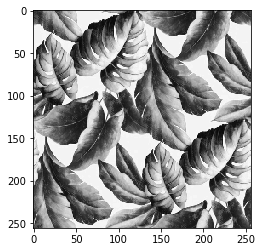

1 0.58717 0.35104


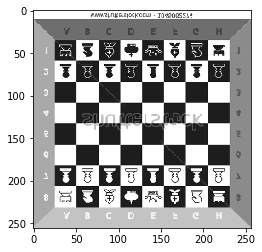

In [7]:
# Show components
for i in range(components[0].header['NAXIS3']):
    print(i, round(np.mean(components_data[i]),5), round(np.std(components_data[i]),5))
    plt.imshow(components_data[i], cmap='gray')
    plt.show()

In [8]:
# Read input data file
hera_hdl, hera_data = fm.read_fits_map(datafile)
hera_hdl[0].header

Filename: ./data/testdata.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      26   (256, 256, 3)   float64   


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  256                                                  
NAXIS2  =                  256                                                  
NAXIS3  =                    3                                                  
WCSAXES =                    3 / Number of coordinate axes                      
CRPIX1  =                128.0 / Pixel coordinate of reference point            
CRPIX2  =                128.0 / Pixel coordinate of reference point            
CRPIX3  =                  1.0 / Pixel coordinate of reference point            
CDELT1  =            -0.003125 / [deg] Coordinate increment at reference point  
CDELT2  =             0.003125 / [deg] Coordinate increment at reference point  
CDELT3  =          100000000

0 2.40901 1.14848
None


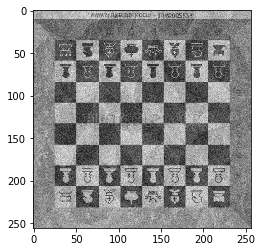

1 2.46221 0.93597
None


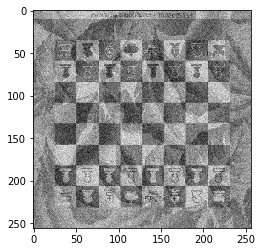

2 2.51876 0.88706
None


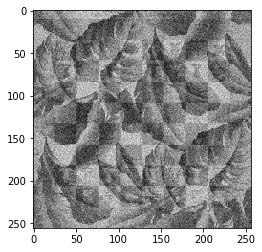

In [9]:
# Show mixed frequency channels
for i in range(hera_hdl[0].header['NAXIS3']):
    print(print(i, round(np.mean(hera_data[i]),5), round(np.std(hera_data[i]),5)))
    plt.imshow(hera_data[i], cmap='gray')
    plt.show()

In [10]:
# Read noise models (to calculate it's power spectum)
noise, noise_data = fm.read_fits_map(noisefile)
noise[0].header

Filename: ./data/testnoise.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      26   (256, 256, 3)   float64   


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  256                                                  
NAXIS2  =                  256                                                  
NAXIS3  =                    3                                                  
WCSAXES =                    3 / Number of coordinate axes                      
CRPIX1  =                128.0 / Pixel coordinate of reference point            
CRPIX2  =                128.0 / Pixel coordinate of reference point            
CRPIX3  =                  1.0 / Pixel coordinate of reference point            
CDELT1  =            -0.003125 / [deg] Coordinate increment at reference point  
CDELT2  =             0.003125 / [deg] Coordinate increment at reference point  
CDELT3  =          100000000

0 0.00359 0.40041


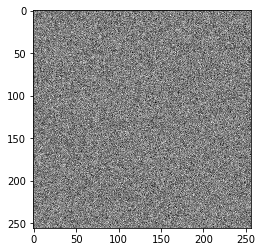

1 6e-05 0.40114


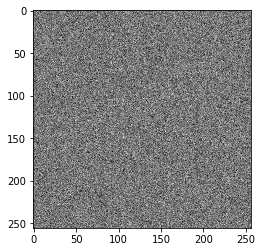

2 -0.00012 0.40104


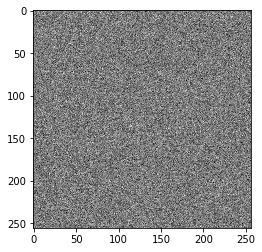

In [11]:
# Show noise maps
nvar = []
for i in range(noise[0].header['NAXIS3']):
    nvar_field = np.var(noise_data[i])
    nvar.append(nvar_field)
    print(i, round(np.mean(noise_data[i]),5), round(np.std(noise_data[i]),5))
    plt.imshow(noise_data[i], cmap='gray')
    plt.show()

In [12]:
# Check the shape of the maps
assert(noise[0].header['NAXIS1'] == hera_hdl[0].header['NAXIS1'])
assert(noise[0].header['NAXIS2'] == hera_hdl[0].header['NAXIS2'])
assert(noise[0].header['NAXIS3'] == hera_hdl[0].header['NAXIS3'])

assert(components[0].header['NAXIS1'] == hera_hdl[0].header['NAXIS1'])
assert(components[0].header['NAXIS2'] == hera_hdl[0].header['NAXIS2'])

In [13]:
# Pixel size in degrees
skycell = np.abs(hera_hdl[0].header['CDELT1'])
assert(skycell > 0.0)

In [14]:
# Get/calculate frequency conversion matrix (FCM, or mixing matrix)
conv = fm.get_testconvert()
print(conv, conv.shape)

[[1. 3.]
 [2. 2.]
 [3. 1.]] (3, 2)


In [15]:
conv.shape

(3, 2)

In [16]:
# Get central frequencies
freqs = fm.get_testfrequencies()
print(freqs, np.mean(freqs))

[100. 200. 300.] 200.0


In [17]:
# Get FWHMs, arcmin (same for all freqs)
fwhm, sigma = fm.get_fwhm(freqs.shape[0], 0.01)
print(fwhm, np.mean(fwhm))
print(sigma, np.mean(sigma))

[0.01 0.01 0.01] 0.01
[7.07768167e-05 7.07768167e-05 7.07768167e-05] 7.077681669066825e-05


In [18]:
# Check shapes
print(conv.shape, freqs.shape, fwhm.shape)
assert(conv.shape[0] == freqs.shape[0])
assert(fwhm.shape[0] == freqs.shape[0])

(3, 2) (3,) (3,)


In [19]:
nx = hera_hdl[0].header['NAXIS1']
ny = hera_hdl[0].header['NAXIS2']
nf = hera_hdl[0].header['NAXIS3']
nc = components[0].header['NAXIS3']

In [20]:
# Convert variances from a list to an array
nvar = np.asarray(nvar)
# Find the variance in Fourier domain (per Re or Im field)
nvar = nvar*nx*ny/2.0

In [21]:
print("Assumed noise variance per Re or Im part of the pixel in Fourier domain, nvar: ")
print(nvar)

Assumed noise variance per Re or Im part of the pixel in Fourier domain, nvar: 
[5253.64703276 5272.79470965 5270.10199165]


In [22]:
bins, topbin = fm.calcbins(nx,ny)

In [23]:
bins

array([[5923, 5922, 5921, ..., 5919, 5921, 5922],
       [5922, 5920, 5918, ..., 5916, 5918, 5920],
       [5921, 5918, 5915, ..., 5912, 5915, 5918],
       ...,
       [5919, 5916, 5912, ..., 5908, 5912, 5916],
       [5921, 5918, 5915, ..., 5912, 5915, 5918],
       [5922, 5920, 5918, ..., 5916, 5918, 5920]])

In [24]:
topbin

5923

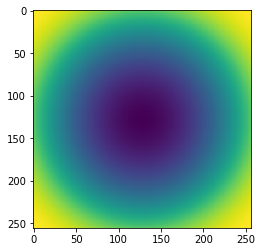

In [25]:
plt.imshow(bins)
plt.show()

In [26]:
beam, beamarea = fm.makebeam(nx,ny,sigma,skycell)

In [27]:
beamarea

array([2.97477949e-09, 2.97477949e-09, 2.97477949e-09])

In [28]:
beamfft = np.fft.fft2(beam)
beamfft = np.fft.fftshift(beamfft, axes=(1,2))

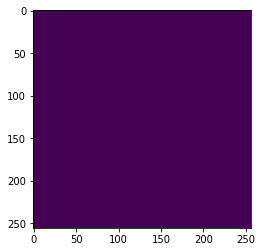

In [29]:
plt.imshow(abs(beamfft[0]))
plt.show()

In [30]:
datafft = np.fft.fft2(hera_data)
datafft = np.fft.fftshift(datafft, axes=(1,2))

In [31]:
noisefft = np.fft.fft2(noise_data)
noisefft = np.fft.fftshift(noisefft, axes=(1,2))

In [32]:
compfft = np.fft.fft2(components_data)
compfft = np.fft.fftshift(compfft, axes=(1,2))

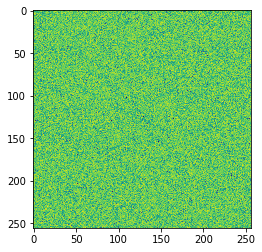

In [33]:
plt.imshow(np.log(abs(noisefft[nf-1])))
plt.show()

In [34]:
# Finding power spectra for the noise realisations
noiseps = np.zeros((nf, topbin+1))
for i in range(nf):
    workspace = np.abs(noisefft[i,:,:]**2)
    print("Noise level calculated ", round(np.mean(workspace)/2,5), " and assumed ", round(nvar[i],5))
    summ, num = fm.azav(workspace, nx, ny, topbin, bins)
    print(round(np.mean(workspace)/2,5))
    noiseps[i,:] = summ

Noise level calculated  5254.06981  and assumed  5253.64703
5254.06981
Noise level calculated  5272.79484  and assumed  5272.79471
5272.79484
Noise level calculated  5270.10249  and assumed  5270.10199
5270.10249


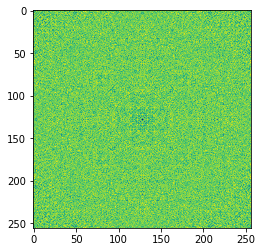

In [35]:
plt.imshow(np.log(workspace))
plt.show()

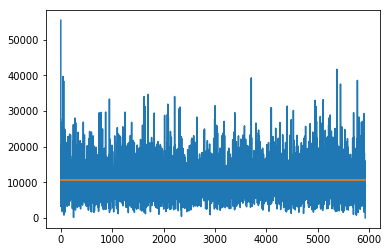

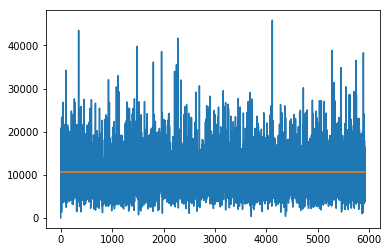

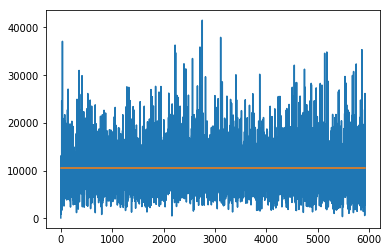

In [36]:
# Plot the noise power spectra and the noise floor for each frequency
for i in range(nf):
    plt.plot(noiseps[i,:]), plt.plot([0,topbin-1],[nvar[i]*2, nvar[i]*2])
    plt.show()

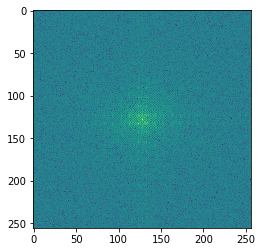

In [37]:
plt.imshow(np.log(abs(datafft[nf-1])))
plt.show()

In [38]:
# Finding power spectra for the data
dataps = np.zeros((nf, topbin+1))
for i in range(nf):
    workspace = np.abs(datafft[i,:,:]**2)
    summ, num = fm.azav(workspace, nx, ny, topbin, bins)
    dataps[i,:] = summ

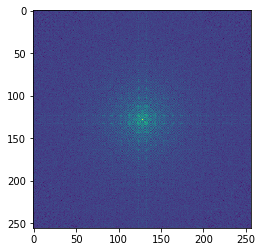

In [39]:
plt.imshow(np.log(workspace))
plt.show()

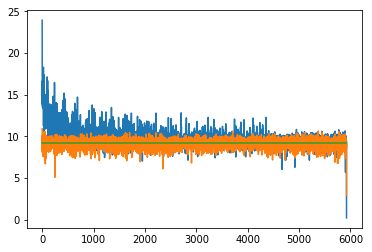

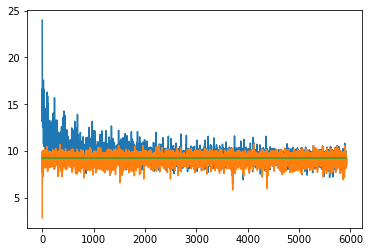

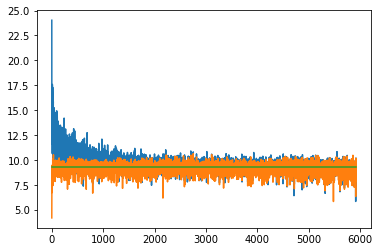

In [40]:
# Show logpower spectra of noisy data and noise floor
for i in range(nf):
    plt.plot(np.log(dataps[i,:])), plt.plot(np.log(noiseps[i,:])), plt.plot([0,topbin-1],np.log([nvar[i]*2, nvar[i]*2]))
    plt.show()

In [41]:
# Find Intrinsic Correlation Function (ICF)
icf = fm.make_icf(components_data,nx,ny,nc, topbin, bins, usecross=True)

0 0
1 0
1 1


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


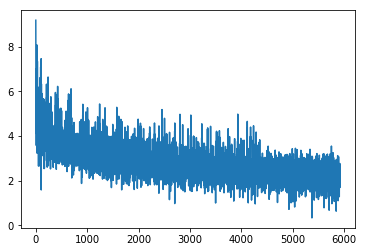

In [42]:
# Show the off-diagonal ICF values
plt.plot(np.log(icf[1,0,:]))
plt.show()

In [43]:
# Find hidden (uncorrelated) variables
mapsfft = fm.vistohid(icf,bins,compfft)

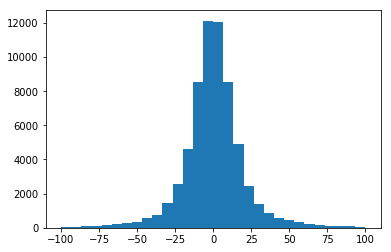

In [44]:
# Pixel value distribution of the visible Fourier image
plt.hist(np.real(compfft[1,:,:]).reshape(nx*nx), range=(-100,100), bins=30)
plt.show()

In [45]:
# Pixel value distribution of the hidden Fourier image (uncorrelated part)
plt.hist(np.real(mapsfft[1,:,:]).reshape(nx*nx), range=(-5,5), bins=30)
plt.show()

In [46]:
# Calculate RL = FCM*L, where FCM is the mixing matrix and L is the Cholesky-decomposed (cross)-spectral terms (ICF)
rl = fm.updaterl(topbin, conv, icf)

In [47]:
datapfft = np.zeros((nf,nx,ny), dtype=complex)

In [48]:
# Calculate predicted frequency maps with the component mixture
for i in range(nx):
    for j in range(ny):
        ibin = bins[i,j]
        datapfft[:,i,j] = fm.predict_mode(mapsfft[:,i,j], beamfft[:,i,j], rl[:,:,ibin])

In [49]:
datap = np.fft.ifft2(datapfft)
datap = np.fft.ifftshift(datap, axes=(1,2))

In [50]:
#Show predicted frequency maps
for i in range(nf):
    print(i, freqs[i])
    plt.imshow(abs(datap[i]), cmap='gray')
    plt.show()

0 100.0


1 200.0


2 300.0


In [51]:
comprec = np.empty_like(mapsfft)

In [52]:
# MEM functional to minimise
def F_mem(x,i,j):
    n = x.shape[0]
    endRe = int(n/2)
    xRe = x[:endRe]
    xIm = x[endRe:]
    xCmplx = xRe +1j*xIm
# Predict data
    ibin = bins[i,j]
    datap = fm.predict_mode(xCmplx, beamfft[:,i,j], rl[:,:,ibin])
# Find Chi2 term
    chi2Re = np.sum((np.real(datap - datafft[:,i,j]))**2/nvar)
    chi2Im = np.sum((np.imag(datap - datafft[:,i,j]))**2/nvar)
    chi2 = chi2Re + chi2Im 
    
# Entropic part
    sfftr = xRe
    sffti = xIm
    psir = np.sqrt(sfftr**2 + 4.0*modelp*modeln)
    psii = np.sqrt(sffti**2 + 4.0*modelp*modeln)
    tempr = psir + sfftr
    tempi = psii + sffti
    valuer = psir-modelp-modeln-sfftr*np.log(tempr/(2.0*modelp))
    valuei = psii-modelp-modeln-sffti*np.log(tempi/(2.0*modelp))
    value = np.sum(valuer + valuei)
    fmem = 0.5*chi2 - alpha*value 
    return fmem 

In [53]:
# Chi2 functional to minimise
def F_chi2(x,i,j):
    n = x.shape[0]
    endRe = int(n/2)
    xRe = x[:endRe]
    xIm = x[endRe:]
    xCmplx = xRe +1j*xIm
# Predict data
    ibin = bins[i,j]
    datap = fm.predict_mode(xCmplx, beamfft[:,i,j], rl[:,:,ibin])
# Find Chi2 term
    chi2Re = np.sum((np.real(datap - datafft[:,i,j]))**2/nvar)
    chi2Im = np.sum((np.imag(datap - datafft[:,i,j]))**2/nvar)
    chi2 = chi2Re + chi2Im 
    return 0.5*chi2

In [54]:
# MEM functional to minimise, returns F_MEM and the gradient
def F_mem_grad(x,i,j):
    n = x.shape[0]
    endRe = int(n/2)
    xRe = x[:endRe]
    xIm = x[endRe:]
    xCmplx = xRe +1j*xIm
# Predict data
    ibin = bins[i,j]
    datap = fm.predict_mode(xCmplx, beamfft[:,i,j], rl[:,:,ibin])
    dfftr = np.real(datap - datafft[:,i,j])
    dffti = np.imag(datap - datafft[:,i,j])
# Find Chi2 term
    chi2Re = np.sum(dfftr**2/nvar)
    chi2Im = np.sum(dffti**2/nvar)
    chi2 = chi2Re + chi2Im 

# Find Chi2 gradient
    cgradr = np.zeros(nc)
    cgradi = np.zeros(nc)
    
    for l in range(nc):
        for k in range(nf):
            resp = np.sum(np.real(beamfft[k,i,j])*conv[k,:]*icf[:,l,ibin])
            factor = -2.*resp/nvar[k]
            valuer = factor*dfftr[k]
            valuei = factor*dffti[k]
            cgradr[l] += valuer
            cgradi[l] += valuei
    
# Entropic part
    sfftr = xRe
    sffti = xIm
    psir = np.sqrt(sfftr**2 + 4.0*modelp*modeln)
    psii = np.sqrt(sffti**2 + 4.0*modelp*modeln)
    tempr = psir + sfftr
    tempi = psii + sffti
    valuer = psir-modelp-modeln-sfftr*np.log(tempr/(2.0*modelp))
    valuei = psii-modelp-modeln-sffti*np.log(tempi/(2.0*modelp))
    value = np.sum(valuer + valuei)

# Find entropic gradient
    egradr = -np.log(tempr/2./modelp)
    egradi = -np.log(tempi/2./modelp)

# Total gradient for each Re and Im part
    fmemgradr = 0.5*cgradr - alpha*egradr
    fmemgradi = 0.5*cgradi - alpha*egradi
    fmemgrad = np.array((fmemgradr, fmemgradi))

# Total F_mem value    
    fmem = 0.5*chi2 - alpha*value
    return fmem, -1.0*fmemgrad.flatten()


In [55]:
# Chi2 functional to minimise, returns Chi2 and the gradient
def F_chi2_grad(x,i,j):
    n = x.shape[0]
    endRe = int(n/2)
    xRe = x[:endRe]
    xIm = x[endRe:]
    xCmplx = xRe +1j*xIm
# Predict data
    ibin = bins[i,j]
    datap = fm.predict_mode(xCmplx, beamfft[:,i,j], rl[:,:,ibin])
    dfftr = np.real(datap - datafft[:,i,j])
    dffti = np.imag(datap - datafft[:,i,j])
# Find Chi2 term
    chi2Re = np.sum(dfftr**2/nvar)
    chi2Im = np.sum(dffti**2/nvar)
    chi2 = chi2Re + chi2Im 

# Find Chi2 gradient
    cgradr = np.zeros(nc)
    cgradi = np.zeros(nc)
    
    for l in range(nc):
        for k in range(nf):
            resp = np.sum(np.real(beamfft[k,i,j])*conv[k,:]*icf[:,l,ibin])
            factor = -2.*resp/nvar[k]
            valuer = factor*dfftr[k]
            valuei = factor*dffti[k]
            cgradr[l] += valuer
            cgradi[l] += valuei
            
    fmemgradr = 0.5*cgradr
    fmemgradi = 0.5*cgradi
    fmemgrad = np.array((fmemgradr, fmemgradi))

# Total F_mem value    
    fmem = 0.5*chi2
    return fmem, -1.0*fmemgrad.flatten()


In [56]:
def F_mem_deriv(x,i,j):
    n = x.shape[0]
    endRe = int(n/2)
    xRe = x[:endRe]
    xIm = x[endRe:]
    xCmplx = xRe +1j*xIm
# Predict data
    ibin = bins[i,j]
    datap = fm.predict_mode(xCmplx, beamfft[:,i,j], rl[:,:,ibin])
    dfftr = np.real(datap - datafft[:,i,j])
    dffti = np.imag(datap - datafft[:,i,j])
    
# Find Chi2 gradient
    cgradr = np.zeros(nc)
    cgradi = np.zeros(nc)
    
    for l in range(nc):
        for k in range(nf):
            resp = np.sum(np.real(beamfft[k,i,j])*conv[k,:]*icf[:,l,ibin])
            factor = -2.*resp/nvar[k]
            valuer = factor*dfftr[k]
            valuei = factor*dffti[k]
            cgradr[l] += valuer
            cgradi[l] += valuei
            
# Find entropic gradient
    sfftr = xRe
    sffti = xIm
    psir = np.sqrt(sfftr**2 + 4.0*modelp*modeln)
    psii = np.sqrt(sffti**2 + 4.0*modelp*modeln)
    tempr = psir + sfftr
    tempi = psii + sffti
    egradr = -np.log(tempr/2./modelp)
    egradi = -np.log(tempi/2./modelp)

# Total gradient for each Re and Im part
    fmemgradr = 0.5*cgradr - alpha*egradr
    fmemgradi = 0.5*cgradi - alpha*egradi
    fmemgrad = np.array((fmemgradr, fmemgradi))

    return -1.0*fmemgrad.flatten()

In [57]:
def F_mem_minimize(args):
    f,x,i,j = args
    xmin = opt.minimize(f, x, method = 'CG', args = (i,j)).x
    xmin = xmin[:nc] + 1j*xmin[nc:]
    print(i,j, xmin)
    return i,j,xmin

In [58]:
def F_mem_grad_minimize(args):
    f,x,i,j = args
#    xmin = opt.minimize(f, x, method = 'BFGS', jac = True, args = (i,j)).x
    xmin = opt.minimize(f, x, method = 'CG', jac = True, args = (i,j)).x
    xmin = xmin[:nc] + 1j*xmin[nc:]
    print(i,j, xmin)
    return i,j,xmin

In [59]:
# Initial starting value - zero assumption
x0 = np.array([[0.,0.],[0.,0.]]).flatten()
# Assumed unit model for entropic term
modelp = np.array([1,1])
modeln = modelp
# Regularizing parameter
alpha = 0.25

In [60]:
print(opt.minimize(F_mem_grad, x0, method = 'BFGS', jac=True, args=(120,100), options={'disp': True}).x)

         Current function value: 1.013709
         Iterations: 4
         Function evaluations: 55
         Gradient evaluations: 44
[ 0.75812059  0.46676907  0.93114355 -1.5780896 ]


In [61]:
print(opt.minimize(F_mem, x0, method = 'BFGS', args=(120,100), options={'disp': True}).x)

Optimization terminated successfully.
         Current function value: 0.876077
         Iterations: 15
         Function evaluations: 102
         Gradient evaluations: 17
[ 0.70915757  0.55654412  0.92157919 -2.08955743]


In [62]:
args = (F_mem_grad,x0,10,10)

In [63]:
f = []
fg = []
iaxis = 1
x0 = np.array([[0.,0.],[0.,0.]]).flatten()
ax = np.linspace(-10,20)
lenax = len(ax)
f = np.zeros(lenax)
fg = np.zeros((len(x0), lenax))
for indx, xx in enumerate(ax):    
    x0[iaxis] = xx
    f0, fg0 = F_mem_grad(x0,120,100)
    f[indx] = f0
    fg[:,indx] = fg0

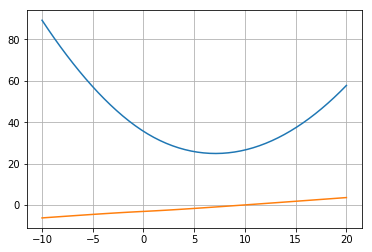

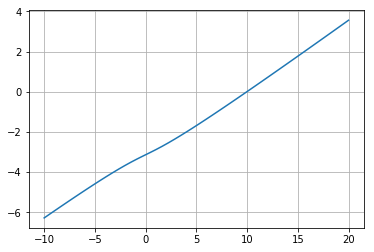

In [64]:
plt.plot(ax,f), plt.plot(ax, fg[iaxis,:])
plt.grid(True)
plt.show()
plt.plot(ax, fg[iaxis,:])
plt.grid(True)
plt.show()


In [65]:
# Make reconstruction of the components
if (not multithreaded):
    start_time = time.time()
    for i in range(nx):
        for j in range(ny):
            ibin = bins[i,j]
            xmin = opt.minimize(F_mem, x0, method = 'BFGS', jac =F_mem_deriv , args=(i,j)).x
            xmin = xmin[:nc] + 1j*xmin[nc:]
            comprec[:,i,j] = xmin
            print(i, j, ibin, comprec[0,i,j])

    elapsed_time = time.time() - start_time
    print("Single-threaded minimization took ", elapsed_time, " sec")

In [66]:
F_mem_grad(x0,10,10)

(19.932649806742845,
 array([ 1.82736657, -0.2661347 , -0.73829923, -0.25858483]))

In [67]:
if multithreaded :
    args = []
    for i in range(nx):
        for j in range(ny):
#            args.append((F_mem_grad,x0,i,j))
            args.append((F_chi2_grad,x0,i,j))

    start_time = time.time()
    p = Pool(8)
    datarec = p.map(F_mem_grad_minimize,args)
    elapsed_time = time.time() - start_time
    print("Multi-threaded minimization took ", elapsed_time, " sec")
    
    for dataelement in datarec:
        i = dataelement[0]
        j = dataelement[1]
        comprec[:,i,j] = dataelement[2]
    

32 0 [-2.24980747 -5.19973941j 15.6365227 +26.80118266j]
48 0 [-0.18974196 +1.67497248j -3.43822659-13.22631424j]
56 0 [-3.05208394+1.56623745j 28.7902039 -9.95317429j]
0 0 [ 1.67527678+0.j -8.23262347+0.j]
40 0 [  0.80973589 +0.37161448j -25.35623249+26.82416539j]
24 0 [ 2.61303238+0.59923662j -5.10355626-1.06624762j]
0 1 [-3.7839762  -3.08154683j 48.11252598+24.49796084j]
32 1 [-1.93752962+2.14417827j  2.86030848-4.50417854j]
56 1 [-1.92199478-2.18776176j -1.47332008+4.04674933j]
32 2 [-2.34503101 -8.09798021j  9.56824957+31.28127392j]
48 1 [-8.14786246-1.96179372j 23.46554598+4.51812065j]
0 2 [  3.03562231 +4.43405881j -21.66662665-34.74317066j]
8 0 [-2.71566683-0.33020391j  4.17932228+1.21929113j]
40 1 [-3.44812934-1.56445182j  9.28325601+5.71814995j]
24 1 [-1.65795194 +3.70080155j 16.49424652-22.4665194j ]
16 0 [-2.30302084  +5.46476105j  9.64237143-106.60342182j]
56 2 [-2.44504711 -2.94627911j 14.37322834+17.96785822j]
24 2 [ 2.06986479+0.70902652j -3.74171047-3.52602455j]
0 3 [ 

24 18 [ 1.6473623  +3.86479375j -4.55873589-10.36219948j]
48 19 [-3.23392245-2.69379374j  2.9371931 +1.17359928j]
56 20 [ 3.14954514+0.97010808j -0.6917773 -0.21056834j]
32 18 [-0.91525435 +8.12428307j -0.35803977-20.19431512j]
0 19 [  3.39854717 -1.42973781j -19.41077532+17.18175829j]
16 15 [ 0.59710827+3.89223526j -2.41653995-7.72400491j]
24 19 [  6.32886447 +3.85541554j -14.64384572-18.39137641j]
8 16 [-4.93065508-2.03171849j 16.91951056+8.23683481j]
40 22 [ 0.70853107-3.27728556j -2.04954343+4.60622112j]
0 20 [   4.87508545 +4.31956573j -110.94973898-86.39505644j]
48 20 [  2.8711295 -1.00078736j -13.98503133+4.52269809j]
16 16 [ 0.53673793-4.44656468j -2.11625341+9.39406502j]
24 20 [-3.29660757+2.08297692j  8.49213309-7.25936823j]
0 21 [-1.23402385-3.21865526j -0.86078664+8.95278242j]
56 21 [-2.13476534 +6.58100235j  4.71289987-25.99795426j]
32 19 [-2.16670118-1.80696758j  3.15513438+2.76357693j]
16 17 [-3.57298157+10.65547925j  5.37404489-13.06926344j]
40 23 [  2.58135733+0.702763

48 39 [-0.90378862-0.4620594j   1.8272673 +0.11765768j]
16 38 [ 0.10615609+0.68741236j -2.3739242 -1.81168506j]
40 39 [-0.78530713+2.97429785j  0.84074298-2.99485605j]
32 32 [-0.19780778-0.74430521j  2.53491548-0.70433988j]
56 36 [-0.36908805-1.45713219j -0.21734668+9.64689805j]
24 35 [  3.68833199 +6.88389297j -17.29960152-23.51807328j]
8 35 [ 2.51456862 +4.45159793j -5.73226943-17.53318804j]
48 40 [-3.23715329 -3.05981331j 10.47474143+15.8881879j ]
0 38 [ 1.20493354+1.41808487j -6.98554252-1.5982336j ]
16 39 [-0.61830468-2.32822257j -8.20872219+3.97158107j]
8 36 [ 1.08150707+0.31753561j -6.18020666-2.80608722j]
24 36 [ 0.75188864-0.16109826j -9.21881514+5.43276119j]
32 33 [-0.62353698+1.28625377j  0.78886526-0.75094461j]
16 40 [-2.60042503-0.36499367j 19.36565588-2.29558915j]
40 40 [ 0.80521555 +3.99425955j -5.66496001-10.14694856j]
24 37 [ 0.65169802-1.48991946j -4.14937474+5.79618595j]
40 41 [ 4.46030961 -1.72840339j -9.3893557 +10.03981317j]
0 39 [  9.24292299+4.59856274j -21.1788

8 57 [-1.68091381+5.3085504j  0.76843859-7.9178477j]
48 55 [-2.67000619-0.9097221j  10.43288939-5.70991793j]
16 54 [ 3.20674385-0.02047522j -5.12853107+0.56176369j]
48 56 [-1.06974616-1.14327601j  2.4993673 +0.31084852j]
16 55 [ 3.9906928  +6.22851368j -5.80969713-14.1073432j ]
24 53 [ 2.2201984 +3.73732717j -7.81479118-8.78810232j]
40 59 [  5.06111229-1.02218298j -12.96031235+3.84057987j]
56 54 [ 2.61100389+2.65635836j -1.9011612 -4.1686983j ]
8 58 [ 1.03723427-0.63987678j -5.07040634+2.62628451j]
0 56 [-1.50303151 +0.57481585j  3.11342553-18.73940167j]
48 57 [-3.18880147+0.95397374j  7.9649671 -3.12288583j]
32 50 [-3.83360208+0.11409424j  9.34126228+2.50663843j]
48 58 [ 1.43785193+0.18633783j -5.50852995-0.70541373j]
8 59 [ 4.26427709+1.33132019j -8.03822523-1.61678395j]
56 55 [ 0.87834221-2.04557253j -5.99406976+9.0941508j ]
40 60 [ 0.70313552+1.26625781j -0.71640259-2.1430434j ]
56 56 [-1.02980559-0.24048121j  9.96613527+4.01231771j]
24 54 [-0.33027578+1.41212375j -0.93201116-6.952

32 66 [ 1.8745193 -2.40455738j -7.24598757+6.20128596j]
0 73 [  6.20272787 +6.59733451j -15.74709559-15.53812763j]
48 71 [ 1.86191781 +5.97569595j -4.57712674-16.03837858j]
40 80 [-3.3372686  -2.55837806j  6.94618334+15.46441324j]
16 73 [  7.48275722 -2.98723743j -15.38889921+11.33833412j]
32 67 [  4.74179421-0.54436125j -10.89155652+3.82934224j]
40 81 [0.29911564-2.03068363j 1.46634422+7.52604285j]
16 74 [-1.64512278-3.22391192j 10.83731508+8.89114968j]
8 77 [-0.05488467-2.13528237j  2.27841278+6.19149845j]
32 68 [-2.8459849 +1.18729475j  2.86580303-0.34714561j]
56 73 [-2.42384961+0.02491455j  3.32367566-3.56058839j]
24 71 [ 4.68351797+1.70773805j -5.49692195-3.90959156j]
40 82 [0.28965062-0.27937936j 3.5855019 -0.29898558j]
0 74 [-1.64855031+0.74852025j  0.70729925-0.54188274j]
48 72 [-3.1367095 -0.51729545j  9.35196932+2.20218177j]
16 75 [ 2.23237178 -2.76308657j -0.36216735+12.47245255j]
24 72 [ 3.53691635-2.22766102j -7.44495583+4.9343532j ]
32 69 [  2.99737958-0.20172352j -12.996

56 86 [-2.94587941-2.30742071j 17.82493996+5.78934973j]
40 100 [ 0.62077536+1.57746365j -0.24222493-5.06334503j]
8 94 [-1.16259153+1.04659677j -3.6197742 -1.98317537j]
48 90 [-2.03667026-0.93083231j  1.10887044+1.10353016j]
0 91 [  1.19477389 -4.54171464j -18.83164787+30.53312972j]
32 89 [ 5.39045348+0.07735704j -9.77319399+2.1295389j ]
24 89 [ 1.89630427+0.84707662j -1.28059584-1.97472754j]
56 87 [-1.59633193+1.80041967j -0.14982036-3.98015164j]
16 91 [-4.13826314-2.30145706j  2.67510117+4.02469089j]
40 101 [ 0.53086258-0.09220391j -0.4346952 +1.62608789j]
0 92 [  0.10983858-0.761239j   -10.22134561+6.68159455j]
32 90 [ 3.01349179+0.54788917j -4.74862833-4.73513999j]
0 93 [ 1.808856  -0.95887207j -2.44934875-1.10956983j]
16 92 [ 0.16561851+0.75611249j -1.792245  +1.66550005j]
40 102 [-1.36773467-3.15801204j  1.95264227+5.55765754j]
8 95 [-4.06446723-2.27130551j 29.12443015+4.29857576j]
16 93 [0.37872472-0.11535528j 0.68133152-0.71913448j]
24 90 [1.15078384+0.15745576j 0.47854023+0.184

24 105 [ 4.97500397 +8.69814761j -5.15889674-16.88284933j]
16 108 [0.21178363+0.23288606j 2.09131307-9.12232621j]
32 110 [  4.26328672 +3.63031172j -10.65718919-13.66579777j]
40 119 [-0.47163354-0.20173792j  2.54927333+0.32230028j]
48 110 [-3.24732874+0.02839303j  3.5298461 -0.37096079j]
24 106 [ 2.04286371-0.09614474j -2.53412366+1.1395135j ]
8 111 [ 1.19964466-6.1939324j  -2.87941093+7.21075384j]
56 104 [ 0.56959124-0.97818095j -1.52085546+1.45890808j]
48 111 [ 0.56699824-2.57057233j -2.82772741+6.5833918j ]
8 112 [-3.05556044+2.38179319j  3.36776564-2.03194096j]
16 109 [ 6.51118374-0.53730415j -9.08414438+4.04059271j]
0 109 [ 0.4928088 +3.81077842j -0.36527795-7.00386711j]
40 120 [-5.36987397-0.94262787j 21.79786343-0.901617j  ]
56 105 [-4.61822685+0.88100967j 12.03203711-1.24280604j]
8 113 [ 2.3528117 +4.96935774j -0.81382158-2.10002625j]
40 121 [-1.48765948+2.42766194j 10.90937667-5.04214019j]
24 107 [-1.4348883  +2.97811131j  4.53853974-15.6105606j ]
40 122 [ 3.96652437+0.1242084

40 137 [ 1.86935365+0.96919113j -3.77664615-2.62208782j]
16 121 [ 4.0184278 -3.48145565j -7.82515622+5.51945701j]
24 123 [-1.97039419-3.42342356j  2.31239437+2.72741194j]
48 131 [-1.26836856 -6.46251497j -0.5293791 +10.63032516j]
32 130 [ 0.19026499+0.42163799j -5.58515881+3.60494376j]
24 124 [-0.68436436+0.50772181j  3.28758677-2.05237403j]
56 121 [-0.22642883-1.81772061j -1.34384392+0.53244084j]
24 125 [-4.54405124-2.1574701j  12.02342709+6.44208024j]
40 138 [0.37187757+0.53452636j 1.78132585+0.49855115j]
56 122 [-0.48667689+0.03024176j  0.75002633-1.84979477j]
32 131 [-0.11393508-2.78057113j  1.42904865+7.53065513j]
16 122 [-2.84187367+2.34605037j  1.78121451-3.80340202j]
8 131 [ 2.15748745+0.69385275j -6.10575517+1.04179292j]
40 139 [-0.63642551+3.95406641j  2.79537019-7.90157573j]
24 126 [-2.9245718 +1.33665887j  5.12072967-3.03030328j]
0 127 [-2.10880948-2.0110353j   3.68332451+1.36211672j]
56 123 [-5.93597447+0.21194239j 11.88570193-2.72640115j]
40 140 [ 2.26341921+0.32624601j -

0 139 [-4.17464191+0.37813138j  9.39281985+1.90391975j]
48 149 [-2.0871545 -0.5694349j   5.14781702+3.50068048j]
48 150 [-0.92130978+0.30166352j  7.28198288+0.26552054j]
48 151 [ 3.21649907 +4.12938398j -2.52198473-15.88048098j]
40 156 [0.29791356+2.37901829j 0.97570304-1.75681546j]
24 143 [ 2.38480346-2.48268638j -3.23241938+3.47666517j]
56 146 [-0.36309188-0.35689358j  2.32294176+2.90141364j]
8 146 [-1.59355414 +1.77930145j -5.02431374-10.00095679j]
32 145 [-0.08732765+0.13357745j  1.17730322+2.41993494j]
16 142 [ 0.52033805+2.08304463j -1.66010797+1.65600861j]
0 140 [2.27663888+2.81860994j 0.14631179-6.8043409j ]
40 157 [-3.19973199 -5.67688848j  6.7236946 +14.78423766j]
56 147 [ 1.10565918+1.85676705j -7.08681278-5.69396778j]
48 152 [-0.59959904-0.97130268j -0.07549376-1.65417144j]
8 147 [ 3.78658986+4.40362683j -6.835375  -8.54118134j]
32 146 [ 1.58347259-1.23600014j -3.29337309+4.08684453j]
16 143 [-2.29909681+3.19942721j  3.30485683-3.65555223j]
56 148 [ 0.18340461+0.42767399j -

24 160 [-1.10770252-1.52121523j  2.04615102+4.79839178j]
0 157 [ 1.56556819 -6.48361643j -5.17406646+12.36993542j]
48 171 [-0.70750912+2.31501066j  2.02614199-6.56217257j]
32 165 [-1.55110183+0.73158101j  3.59676333-1.79170644j]
56 163 [-1.53504507+0.9112516j   4.61052797-0.50033712j]
16 163 [ 0.34460924-0.86216326j -0.86147449+1.70828511j]
0 158 [ 1.15777151-3.48514471j -2.07741717+9.58051994j]
24 161 [-3.11781715+1.13253355j  9.81358355-4.74645589j]
40 171 [ 2.9027382 -1.95064173j -5.86629997+8.18616116j]
48 172 [-1.79881605-0.72976579j  2.75781164+0.46733271j]
56 164 [ 0.27083631-2.07924767j -0.08174707+4.62083363j]
0 159 [-0.17644165+4.90914461j  3.03111086-3.39300841j]
16 164 [ 0.80464383-1.71134169j -5.48258982-0.06856274j]
32 166 [ 1.92847716+0.16479826j -4.1670574 -0.50547684j]
24 162 [0.02395537-0.93383399j 1.23121245-1.41713938j]
32 167 [  3.30374779 -8.6842226j  -11.4354668 +21.29087442j]
40 172 [0.45357482-0.4800151j  2.44591052-0.53520768j]
48 173 [ 2.48119138+2.05622452j 

32 182 [-1.22181388-0.02553099j  2.2313348 +1.58672117j]
24 181 [-1.89441299 +5.05863624j  2.13572886-13.00770216j]
0 173 [-4.18298865-2.61475219j  9.59772683+5.83756155j]
48 195 [-3.0207357  +3.43281995j 13.66787423-23.78674702j]
32 183 [-4.46067394+1.51784538j 10.72167137-0.77519698j]
56 180 [1.46673183+1.76521152j 1.1290489 -1.23357765j]
16 180 [-0.81173272+1.6274279j  28.03619256-3.82178961j]
16 181 [-0.89427311 +0.03959745j  6.17630784-10.62543101j]
40 188 [-0.13821567+1.18909559j  1.72251278-0.81999729j]
8 176 [  1.49096969-0.75198603j -10.55589913+4.20222903j]
24 182 [-1.60065916 -4.99443402j -2.6436883 +11.59025872j]
56 181 [-1.68084897 +4.50172878j  2.77867184-16.90148162j]
0 174 [-0.49006746 -1.59709381j -3.00898981+10.43680623j]
8 177 [ 2.88241578+3.20523466j -5.10412319-6.63088662j]
32 184 [-0.68975985-1.56562439j  2.22398574+4.93338004j]
40 189 [ 3.71005947-3.90176195j -3.1844339 +3.08813508j]
48 196 [  5.42205792 -3.35503558j -10.42993513+10.83121959j]
56 182 [-1.51186711

56 200 [ 0.16346893 -2.21141658j -7.74646467+19.61700179j]
40 205 [-2.18976472 +1.34233689j  6.68363277-17.30409733j]
48 211 [-1.78728614+1.53791958j -0.85477278-3.55263368j]
0 192 [  2.3568634 +1.47102208j -19.52122154-6.90235601j]
40 206 [  3.45397695-0.00913065j -16.498972  +4.89290505j]
24 199 [-5.04391321+1.29104157j 13.19183515-4.24194677j]
16 198 [-3.57374291-0.00559625j 11.48138842+3.89263434j]
32 199 [ 1.63641295+0.63953995j -4.88651165-2.9229717j ]
48 212 [-2.3845818 -1.86397633j  1.66437867+2.75552648j]
56 201 [  3.41191369 -2.77489325j -18.43219978+25.77936959j]
8 195 [-3.97553936+1.39620438j 13.46115304-7.14005702j]
32 200 [-0.67089804-2.76445217j -0.81810596+1.68013982j]
16 199 [-2.61311903 +2.46321816j 12.67590943-20.83774853j]
48 213 [  5.68814129 -5.45069671j -15.0064889 +12.08899399j]
0 193 [-0.22339369+3.50416553j  2.72849129-7.03997769j]
24 201 [ 4.38751426+0.36676258j -1.46909029+0.05992977j]
16 200 [ 0.08041801+2.00461387j -1.52819052-3.72186681j]
24 200 [ 2.64570

8 214 [  6.10386165-0.53152229j -23.42393002-0.27691111j]
48 229 [ 0.66980014+1.11868719j -0.97068379+0.46846282j]
0 211 [-5.95497568 -0.41567761j 86.6698423 +38.56139251j]
24 217 [-4.58054072-4.56021792j 12.66723745+9.18767732j]
56 219 [1.4039476 -2.89841202j 1.70612263+3.34393755j]
40 223 [ 2.34868525 -5.05518616j -5.12012763+18.39903678j]
0 212 [-0.92723434-3.07577581j  1.63625358+5.49312546j]
8 215 [-1.70274055-0.34442353j  3.42447027-4.66568239j]
32 213 [ 2.0166638-0.36227268j -5.9952955+6.34949911j]
48 230 [ 1.00040961 -3.08687583j -7.05121068+10.0777347j ]
16 217 [1.44543169+4.0783042j  1.64944996-8.78953576j]
40 224 [ 1.34716706 -0.97558592j -8.01220105+14.9948962j ]
24 218 [-0.49082858 -1.80307217j  2.77747898+11.92430021j]
8 216 [ 2.6217641-2.10627438j -3.8923349+6.74285662j]
8 217 [  5.65248197+0.14738343j -13.71886954+3.62269208j]
16 218 [-1.03106417-2.53333211j  4.01626657+0.40486703j]
56 220 [-1.09737802-0.12734848j  6.25708344+0.10248521j]
32 214 [0.72420098 -2.40423351j

48 249 [-0.43484159-2.29923088j  1.33338037+0.66171958j]
32 232 [-0.74101122 -2.68879776j  5.90512426+11.19396388j]
0 226 [ 3.10428529 +0.72571101j -3.85186029-11.3446036j ]
16 234 [ -0.2386043  +3.75099631j -35.87714594-58.45194385j]
8 235 [-4.85885945-3.27568114j  3.37700081+3.21044876j]
16 235 [-1.35714915+1.31134937j  4.67968997-3.18519322j]
40 241 [-0.52700275-1.50776227j -0.4904341 +7.05888012j]
0 227 [ 6.47071406+7.20411639j -3.91616206-2.82186808j]
24 235 [  4.43133608+2.66064532j -10.85907376-9.76287435j]
48 250 [-1.53927567 +2.64758967j  8.74191976-10.89568913j]
56 234 [ 1.38473836+2.03160218j -5.90006342-2.87726156j]
40 242 [-0.84844758-2.00715561j  4.33013835+7.93099223j]
16 236 [-0.98571804+1.32988368j  1.75731801-3.16679002j]
8 236 [0.24810597-4.77352813j 1.0194421 +4.26566814j]
24 236 [-3.52531211+0.01752707j  8.5991156 -3.93549251j]
32 233 [  4.13600078 -2.49916527j -13.94492972+13.00009318j]
16 237 [-12.65019783-4.23783552j  17.17737921+4.10233901j]
48 251 [-0.32430841

24 251 [ 3.75944221-3.61965421j -6.16635959+4.39925347j]
8 253 [-4.60999256+3.77365923j  7.68587623-8.30202673j]
16 251 [ 2.851077   -6.09272584j -7.77159449+18.05903167j]
41 6 [ 3.72186403+3.84208356j -4.03633946-6.91503451j]
32 251 [-5.43859755 -9.3046332j  20.51489189+31.47194039j]
0 244 [-5.35507454+0.90820463j 21.99306704-6.30001937j]
49 7 [0.20587612-2.12810212j 1.47406362+6.7435228j ]
56 254 [-3.18599827+0.97197817j 15.27452912-2.6339036j ]
32 252 [0.32513282 -4.28108611j 2.42348171+15.83016727j]
8 254 [-2.70513041-1.94972427j  7.4513763 +8.94758482j]
56 255 [-1.25728113-4.50831011j -4.29286087+7.79914558j]
0 245 [-2.78129215-0.94397141j 32.62039644+9.95059967j]
41 7 [-1.41479421-1.26878593j  2.85940407+3.27726364j]
0 246 [ 2.30774778-1.11808784j -4.18711764+4.31797356j]
16 252 [ 0.60995777+0.87705285j -3.8227241 +1.1172342j ]
57 0 [ 3.26356836 +6.48086948j -5.22741121-11.42869122j]
49 8 [  5.00553293 +3.781787j   -12.72974081-10.26896275j]
0 247 [ -4.10275214  -4.11407457j 125.

41 24 [-1.3729877  +1.6569748j   8.19016064-16.37435013j]
49 24 [-0.7290797  -5.14894439j -1.65569064+13.49492043j]
9 15 [ 1.97254994-6.86766564j -5.30998424+8.86117491j]
33 11 [ 2.39381034-0.89927242j -4.55140165+0.8371815j ]
25 11 [-1.00326016+0.28283015j -0.37908188+0.60852691j]
1 7 [-0.61880823 +2.6761728j   2.56493911-16.23476577j]
41 25 [0.36270577 +2.71713323j 1.83954254-14.02767616j]
57 17 [-0.48753227+1.69939359j -3.15969376-6.01934802j]
25 12 [-11.63699488+1.65849059j   8.10836562-2.02460567j]
17 17 [-1.17962918 -3.31348436j 10.16650326+24.20671223j]
33 12 [-1.37401187-1.71042145j  0.16263332+3.70819223j]
49 25 [-0.60013529-2.22508575j  3.64329194+3.73731802j]
33 13 [-6.02298705+2.56557793j 11.58856988-1.96530514j]
17 18 [-6.1407875  +1.84709582j 23.68380521-13.07930417j]
9 16 [-5.51379166 +6.29279446j 25.74907404-24.83869336j]
41 26 [ 1.42646363+1.42958874j -1.47225466-3.65395629j]
1 8 [0.76264996 +4.62705282j 0.92628483-21.68369593j]
17 19 [-9.07938475 -3.45724446j 17.80068

17 35 [  1.21821784-1.02936655j -11.4594494 +4.84686914j]
57 37 [  7.27419045 +3.13285522j -35.195076  -13.64814685j]
25 30 [  6.97014826 +3.67956832j -22.65838861-13.258418j  ]
33 28 [-5.81647361-3.20480619j 10.27827482+4.15352509j]
9 30 [ 4.9310305  +1.09266173j -4.76893694-11.09615018j]
57 38 [  5.99526188 -2.92126187j -13.64851642+10.36679472j]
41 43 [ 0.74033226+1.13166322j -2.71357938-3.06446476j]
49 44 [ 4.16177535 -4.80041066j -9.70000204+17.97324886j]
17 36 [ 1.03096988+1.41500036j -6.80974987-5.97986727j]
41 44 [-3.57723387-8.81227927j  3.26576195+8.16845805j]
57 39 [1.76565381 +7.34720526j 1.14645998-16.62191437j]
1 25 [-0.1157103 -4.54307867j  8.25951454+9.68964535j]
49 45 [ 1.41425907-1.5940357j  -3.99527068-1.49314638j]
33 29 [ 0.43539892+1.10526585j -2.11694496-2.75645045j]
25 31 [  3.10732327 -2.96731842j -12.61807898+13.44715134j]
57 40 [ 0.39875271-1.45814991j -1.13606293+2.18696063j]
1 26 [  7.06343759 -5.71708186j -18.98185272+10.16169412j]
9 31 [ 0.20135859-0.69672

17 52 [  9.41944456 -8.30070382j -29.39037879+25.00274864j]
1 42 [-1.93771052 +2.22830357j 26.99287544-10.86838036j]
25 46 [-8.55030462+2.14988394j 11.88834704-2.56749573j]
41 66 [0.60084424-2.94300846j 0.35552184+6.86801991j]
9 50 [-2.95707029+1.86994739j 14.29551488-8.46045018j]
9 51 [  0.74299207-1.20605632j -10.95262375+6.00147174j]
49 63 [-1.55549264 -1.9580322j   6.78446245+20.60607517j]
1 43 [-3.14204389 +3.07812915j 19.70170224-10.66876966j]
17 53 [-6.41198318 +3.8424275j  25.20315894-16.35202028j]
17 54 [-0.31979996+2.10781265j  1.62496354-2.28727349j]
57 55 [ 1.90644489-1.19218874j -6.8558128 -2.69941341j]
9 52 [-0.01773942-3.13452761j -3.10465749+8.94078937j]
57 56 [-0.25039821+0.46766538j -0.56937373-0.61215288j]
25 47 [ 2.15268522-1.50708792j -2.9732225 +3.2594618j ]
33 44 [-0.72204301 +3.9896611j  1.63973553-10.4659507j]
41 67 [ 0.77746654+2.39962188j -2.16312335-3.78149142j]
49 64 [-8.26637349+2.67380629j 15.47924922-5.27374019j]
17 55 [-0.35944147 -4.03520599j -2.994364

1 62 [  3.78553246 -7.42940566j -12.49722286+17.49816676j]
57 74 [-1.04748688-7.23800707j  0.52561653+4.18375776j]
33 58 [ 0.88890661+4.66524712j -1.38076563-2.77366087j]
25 60 [-1.94599434 -4.48427597j  5.12672447+11.03041979j]
41 82 [-2.1321573 -1.26049461j  3.37800971+3.1253074j ]
1 63 [ 0.16853738 +3.2970695j  10.87112824-13.14306305j]
49 81 [ 0.83723552+0.32802679j -1.34656954-0.94177041j]
9 73 [ 2.61951334 +5.42833129j -8.18735028-24.21561081j]
49 82 [-2.27866771-0.51442364j  3.92273615+0.71208812j]
17 74 [-5.49681593 -5.38172717j 25.59458058+18.19384825j]
9 74 [  3.35008654-0.03530366j -10.2136737 -1.35708604j]
25 61 [-0.64347603 +2.90109843j -5.63089142-11.19127831j]
1 64 [ 1.34610791 -4.25509183j -1.25660643+17.2282443j ]
17 75 [-0.58180959-2.05286845j -1.64422475+3.70286717j]
33 59 [-0.95222257+0.62580537j  4.89968872-2.23942121j]
57 75 [ 1.05090321-2.56394258j -2.25308323+3.55157228j]
17 76 [0.43029549+0.0465939j  1.64055047-0.72668688j]
49 83 [-0.4710813 -1.61191278j -6.439

9 93 [-0.22960049-0.1757564j   2.18002591+0.95768767j]
57 91 [0.79580406-0.75458515j 0.20221897-3.68491673j]
49 101 [ 1.36729274-0.48485638j -1.26768098+0.3855029j ]
25 78 [-2.52721249+0.00321078j  1.41164332-0.14342192j]
41 96 [-0.92789627-0.28944454j  1.77477117+0.96998596j]
17 96 [-2.74456189-1.47895088j  2.3806369 +2.45086422j]
41 97 [-1.14032674+2.05756911j -1.72282077-9.78676658j]
41 98 [-0.64535129-2.18585922j  5.25515515+8.75585167j]
25 79 [ 0.79364695 -4.50172741j -1.09173102+12.33229079j]
1 81 [-0.55986681+0.42668794j -2.93404984+4.02860456j]
49 102 [ 1.16421357+2.20672015j -2.30709877-1.31155506j]
57 92 [ 1.28468512-1.24345167j -1.5564107 +1.6516613j ]
25 80 [-2.76743043 -6.17549384j 12.34253059+21.7657523j ]
41 99 [-2.71934834+2.38622749j  0.51331023-6.24725625j]
33 74 [ 1.54623731-1.8655391j -6.16669237+1.142428j ]
17 97 [-1.93861962+0.32971023j  9.88687061-3.98041118j]
9 94 [ 2.35584606-0.20163096j -3.62861477-0.8842456j ]
9 95 [-3.35394703+1.64270272j  6.53410406-1.60720

57 111 [-1.95513264-0.5748376j  3.60282309-1.5858506j]
1 98 [-1.47882521 -4.18513118j  8.21294187+13.19095446j]
41 113 [-0.95655365-1.08106789j -1.59338744+1.26841978j]
33 92 [-0.10865626-1.11364441j -0.16048521+4.50560932j]
57 112 [ 2.94403168-0.89392842j -6.75771952-0.19289947j]
25 98 [-0.55392336 +5.46893437j  1.57302516-10.623637j  ]
17 111 [  4.04879071+1.54675549j -12.94100062-3.19092594j]
9 113 [-0.49167872+1.64658499j  0.36352589+0.56876125j]
49 120 [0.0128968 +0.27619822j 0.33697108+0.69643469j]
41 114 [-2.26079331+0.14180819j 14.93613247-3.73378004j]
1 99 [ 0.55152251+1.18436209j -1.20273061-0.64922203j]
25 99 [-0.75243899-1.06877063j  3.33282774+0.60282184j]
9 114 [ 1.02341607-2.64376266j -6.8652258 +8.94756266j]
25 100 [-1.94566558-2.3090882j   7.66851518+6.52441768j]
17 112 [-1.41561914+1.09293198j  3.14399583-1.34083339j]
33 93 [ 1.87904615+0.69785609j -0.78021275-1.6116774j ]
57 113 [-0.2847791 +3.08005529j -1.09940202-5.39948179j]
49 121 [0.67696775-1.8277934j  1.560750

17 127 [ 1.70906372-1.76521302j -2.6281534 +0.27504871j]
57 131 [ 2.65127266-1.25018378j -5.15323511-0.32066587j]
49 136 [ 2.66394362-1.03687702j -8.09256328+1.89045298j]
25 117 [-1.5858268 +0.57339712j  3.81515014-0.70124728j]
1 116 [-3.14402619-1.41315136j  6.28037866+1.291201j  ]
33 112 [ 0.09320267+7.11210215j -0.7969818 -7.04336205j]
41 131 [0.0955176 -2.04781143j 3.81583059+7.69067005j]
9 131 [ 0.15360253+0.87158769j -0.83566549+0.99801815j]
57 132 [ 2.06636469-1.04961471j -1.2221313 +4.3104249j ]
17 128 [0.24912549-1.93358648j 1.60778144-1.70868578j]
1 117 [-3.00044998-1.09026124j  3.82657204-2.13589337j]
41 132 [ 0.56598063+2.55786973j -4.9931024 -5.35943914j]
25 118 [-3.8165204 -1.56589436j  2.83643548+0.91873621j]
9 132 [-3.76353224+2.76359282j  4.60135086-3.92456125j]
57 133 [ 0.24037508+0.69694169j -0.90191641-1.37740384j]
17 129 [-2.39151542+1.43655609j  4.51313215-2.12467961j]
49 137 [ 1.65169805+1.5968695j  -4.31385193-1.17276587j]
1 118 [1.1280641 +1.27890163j 1.6248591

49 149 [-0.98279041+0.79659751j  0.78300291-2.37225753j]
41 151 [0.07998488-0.08326974j 0.93430677+0.47877231j]
17 144 [ 0.64677048-0.74276386j -4.906305  +2.23657786j]
33 130 [-1.43720925-1.51733716j  2.08633909+2.01319268j]
25 133 [ 0.40379145+3.67426219j -1.11744995-6.11413555j]
49 150 [ 0.80670588+0.85546754j -0.53678157-0.70659094j]
57 150 [-1.59593114-0.42925327j  2.72044769+0.58854886j]
9 147 [0.91068512-0.3022986j  4.64220456+2.18437759j]
41 152 [  6.22602423-0.42959652j -15.8925222 -0.45785389j]
1 142 [-2.12065159-0.70450418j  4.57344397+0.30251679j]
57 151 [-1.9460263 +0.51761216j  6.37626759-3.12890664j]
33 131 [-2.80296929-0.17233817j 12.8118425 -3.60578448j]
25 134 [ 0.59657041+3.00358476j -2.59443198-4.90423172j]
9 148 [ 2.63134088-2.86832372j -2.07950863+4.57805903j]
17 145 [ 1.65050581+1.74840377j -7.46270651-3.71360185j]
1 143 [ 3.03689336-2.77546528j -0.6415065 +9.44276566j]
25 135 [0.45226451-3.50554274j 1.05991665+5.96200149j]
57 152 [ 1.09336794+1.24098319j -2.7506

33 149 [  3.81594702-1.20301635j -17.51556254-0.26624618j]
1 158 [ 0.62705267+0.07856044j -4.64539337-2.72769397j]
17 161 [-2.09242336+1.80594632j  6.64081985-7.11778191j]
25 152 [ 1.03405624-2.55267715j -4.07298915+6.11144771j]
49 167 [ 0.3862101 -1.38470387j -4.68091705+4.46352746j]
9 165 [-3.34112646 -4.32184981j 16.02217183+13.17158963j]
33 150 [-0.74735338-2.15010758j  1.66391052+3.51712987j]
57 171 [ 0.56239784-2.81776281j -0.16425862+9.21268376j]
1 159 [-0.03326205 -3.47258776j -0.79848266+12.60127997j]
9 166 [-4.44059553+2.42053871j 20.5944764 -6.36653439j]
17 162 [-2.47068124 -4.6429972j   4.19128177+13.07969195j]
41 168 [1.77959689-1.585992j   0.35879781+6.24645589j]
25 153 [ 0.70238723-0.21974104j -4.04918113-0.89983425j]
49 168 [ 0.19999476-1.74825029j -7.43341398+7.81969067j]
9 167 [-4.90754334+1.09548204j  9.26810082-4.06117378j]
41 169 [-0.09430831-1.49265505j  0.66456428+0.97719105j]
25 154 [ 0.05788304-1.50515316j -1.88125257+5.4998539j ]
1 160 [-2.47930861 +5.12909726

49 185 [-2.60912431+2.81035359j  4.89646899-7.05971286j]
33 168 [-2.4040974 +0.69076693j  8.04527874-2.27950481j]
9 181 [-0.33427247-0.01540327j -3.94456533+1.47873793j]
25 170 [-0.70096986+3.17586006j -3.55946997-6.12619598j]
17 177 [ 2.65820305-3.78790754j -3.42553064+6.44551169j]
1 178 [-2.91802918-2.04015881j  9.01798804+7.88397836j]
33 169 [-1.19585327+1.49999822j -1.18998285-4.17738627j]
1 179 [ 3.0014061 -1.93215238j -7.96515855+7.30075738j]
57 191 [-0.77435785-0.12487989j -0.74037343+3.55437833j]
1 180 [-9.68075673+8.07473253e-04j 59.41071966-4.85743895e+00j]
9 182 [ 1.48442606+0.52953881j -7.32831225+3.46730357j]
49 186 [-0.87307393-1.35927953j  3.35692937+3.44121956j]
41 185 [ 1.82441029 -8.21036652j -2.40184194+15.30987039j]
9 183 [0.41228965 -3.64481695j 6.60585842+17.83183491j]
17 178 [0.06258281 +6.72294472j 0.11099966-12.62330593j]
33 170 [ 1.11837943-0.8376742j -5.5640122 -3.1144374j]
57 192 [  2.13398886 +0.81046888j -16.21505195-20.62045652j]
9 184 [-0.77549817-0.4066

49 204 [-2.66287804-1.189005j    3.079675  +5.27689791j]
41 200 [ 1.9820542  +3.85561589j -2.21645885-11.41269132j]
57 206 [ 0.66472842+1.61718831j -2.69317355-1.28532328j]
25 191 [-2.53885226-1.73656913j 11.14960274+9.27120006j]
33 186 [ 0.98030801+0.64014474j -5.88675444-2.83380183j]
41 201 [1.25795207 +3.30537828j 0.17684237-13.76357j   ]
17 196 [ 0.68633575+5.24374198j -2.27868582-8.09970475j]
57 207 [-0.44342409 -3.58159714j  1.72387894+12.98395886j]
9 200 [  6.10111202+0.3265251j  -10.53336181-1.72996105j]
1 195 [  8.41765341 +5.05476132j -31.87622115-16.64345574j]
33 187 [-1.53018748-1.17496085j  1.80036397+0.48424023j]
57 208 [ 0.34494474-0.94135807j -0.5303227 -0.17073336j]
9 201 [-2.72617233+6.79163944j 16.75933487-6.68012933j]
41 202 [  4.24650331+1.08819527j -16.82944841-2.39676615j]
25 192 [ 3.11391004+0.79200152j -5.96166835+0.81496694j]
49 205 [-0.11711194+1.00625321j  1.14699025-1.41746991j]
33 188 [-6.16560789-0.48805286j 13.20077403+1.26977928j]
9 202 [  5.38708822 -6

17 210 [ 0.24663352+0.13458762j -7.14473378+0.71693092j]
49 221 [ 0.94663918-0.93103919j -6.4388176 +1.15462946j]
49 222 [-0.61742084 +8.3542916j   1.40171985-26.70148252j]
25 208 [-6.02595352+1.53754793j 17.96355274-2.91881503j]
41 218 [  4.1981844  -3.55502446j -27.89486222+20.9606737j ]
57 224 [ 1.60856571-1.02980677j -0.63151357+2.21959993j]
1 210 [-3.18635687 +3.39467895j  7.61219095-12.8800177j ]
17 211 [ 2.11635214-2.7490362j  -3.27992356+1.81838742j]
9 223 [ 2.7211133 +4.06315756j -6.10852429-5.98234926j]
17 212 [-1.94911709-2.00013044j -0.00769264+2.48215373j]
33 207 [-0.75596069-1.4039695j   0.75943782+1.03803065j]
9 224 [  4.7954268  -6.70198369j -12.18058734+21.95287313j]
57 225 [1.02484493+1.81870765j 0.33737844-1.22124102j]
17 213 [-0.44198476 +2.53322394j  0.00463233-12.5176166j ]
33 208 [ 0.977027  -0.80858252j -3.45039067-0.76581336j]
49 223 [-4.6077748 -3.77175069j  9.51199028+7.66371103j]
25 209 [-2.10707649-0.6343275j  5.52207444-0.7498851j]
1 211 [  7.46494949-0.50

57 241 [-2.07846618+1.41200027j  6.13972479+0.41126058j]
49 239 [ 4.29202902-0.78280101j -5.89306869+2.93599087j]
17 231 [ 1.02460379+3.70372968j -0.28612536-4.38193658j]
57 242 [-2.37655636 -2.7458841j   5.41256703+15.46423985j]
1 228 [-4.72146497 -9.72035317j  3.75221346+11.55932452j]
41 233 [-1.19002087+1.03477431j -0.52410915-5.20812759j]
49 240 [  5.15884775-1.81908762j -12.79638008+6.2519457j ]
1 229 [ 0.71711239+4.83556339j -2.30049561-8.8625038j ]
25 227 [  3.02295873-0.61356571j -10.59451114+0.52325812j]
9 242 [-2.47297332-2.59081306j -3.45113482+4.27585749j]
41 234 [ 0.96751695+0.23035509j -2.16911649+0.10841887j]
17 232 [-8.55824807 +5.23783422j 31.58890251-16.36722104j]
49 241 [  4.15925638-1.41779503j -15.62010687+7.80259181j]
33 223 [ 0.57925941+0.53152943j -3.965647  -0.4289055j ]
1 230 [ 4.06157949 -6.13309849j -2.09092051+16.07215889j]
57 243 [-1.91950518-1.50586864j -1.08705228+0.74937255j]
41 235 [ 2.61318392-1.50861759j -1.21396844+0.63330431j]
9 243 [  4.73259486 +

33 240 [-4.71557455-2.0830801j   6.26899289+5.11141125j]
58 3 [-5.15891039-5.02622498j  5.15417156+5.67202635j]
17 249 [-1.75086029+0.30488781j  1.26635853+1.20342737j]
49 255 [-3.42798515-1.25945299j  9.3752619 +0.31439224j]
25 242 [  4.41050022 +5.61438486j -58.64667504-69.12448204j]
33 241 [  2.51054445 +4.56801715j -11.55716933-12.90468757j]
25 243 [0.79212549-0.03278343j 6.52685709-4.33445094j]
41 250 [ 1.67678922-0.99654177j -2.07569781+1.3656018j ]
1 248 [1.23267984 +0.21155935j 4.82925877-15.11241755j]
10 9 [ 0.31997531+4.94250269j -0.66417555-3.87662744j]
50 0 [-0.97811266 -0.26366191j 16.05722719+34.69284973j]
41 251 [-1.06318907+1.55232871j -5.75910221-9.01288977j]
33 242 [-0.65159628+3.63630696j  3.27937928-4.0844393j ]
50 1 [ 2.26411677 +7.22044396j -4.90604803-19.40845367j]
41 252 [-2.19327158 -5.30029231j  2.76742199+15.1808049j ]
25 244 [1.84916313-0.90970488j 0.57756769+2.29221315j]
17 250 [  8.34237165 +5.05640952j -40.9642555 -30.52899647j]
1 249 [1.05539146 +1.69160

18 11 [  5.99619671+3.60353823j -10.89329378-6.81979244j]
50 17 [ 2.36467251-0.41879482j -5.59009325-1.37082203j]
10 24 [ 0.83455459-4.61886872j -2.14229265+9.34696095j]
34 1 [ 6.10154317-1.2448204j  -8.89967397+4.78819616j]
42 15 [ 1.93013631 +1.88964451j -4.57030978-19.15342836j]
58 21 [-0.56751277+0.71272262j  4.12116433+0.60156856j]
26 7 [  8.74652494 -5.09161108j -21.5577546 +10.99408079j]
42 16 [-1.16952232+0.44406262j -0.17641156-3.54221023j]
10 25 [ 3.65736069+3.35752375j -6.52270026-8.71923902j]
34 2 [-1.6744917 -0.07883718j  4.34459227+2.33510768j]
18 12 [  5.16458299-0.53374887j -12.70379788+2.37975738j]
2 9 [ 0.24299343 -3.80042331j -4.09926377+12.56759169j]
58 22 [0.90586915-1.61635298j 1.16028163+2.18768824j]
50 18 [-1.47911881+0.30861143j -0.96513296-0.34877849j]
26 8 [ 10.83954287 -4.84900116j -31.87375534+17.37235427j]
10 26 [  5.12829094-0.50011744j -10.2210626 +0.26711557j]
58 23 [-2.73056421-2.24012492j  2.32761676+3.76931036j]
26 9 [-3.27473138+2.77636811j 10.09809

34 19 [  4.89317623+0.75865309j -43.03264992-0.05330556j]
18 31 [-0.41286002-3.75137465j  1.21336342+1.99990589j]
58 41 [ 2.10224963 +4.5493621j  -7.26249372-16.22228245j]
42 32 [-1.31725979 +2.67566051j  0.49301464-12.64553194j]
2 29 [  1.11852607 -2.08654876j -11.24848308+21.02907242j]
10 40 [  3.03843339 +3.78603506j -44.00613056-45.87091505j]
26 25 [  3.90568292 +4.19050328j -17.92406023-17.99777652j]
58 42 [ 1.65502594-0.55591255j -0.49531163-0.88780482j]
42 33 [ 0.82568786+2.52987738j -1.12265382-2.20507444j]
34 20 [1.21184959-0.75649659j 0.65465699-0.91337996j]
42 34 [1.28365156 +2.45034191j 0.98950636-18.68216617j]
50 33 [ 0.73949163-1.21617555j -0.66334767+0.12892578j]
10 41 [ 0.9918337 -2.00376104j -7.91118207+5.61831972j]
10 42 [ 0.11498598+0.32220183j -5.94187588+0.85240572j]
50 34 [0.65403632+0.03746227j 0.61941807+0.85722334j]
2 30 [ 2.42529547-2.47150242j -7.69686914+6.54364407j]
42 35 [ 0.76095728-0.03900577j -1.44683046-1.44281263j]
26 26 [-1.11339344 +3.5542304j  -3.9

2 47 [-2.92360566+1.88368993j  7.16019926-8.89682864j]
10 57 [-5.46097573-0.10164581j 24.08928376+0.78190578j]
34 36 [-0.44793394+0.6258594j  -3.29317032-3.80496498j]
58 59 [  7.44762415 -5.76554752j -15.0588934 +13.46145307j]
50 53 [ 3.1906537 +4.85029633j -6.08889351-5.42812644j]
26 39 [  3.80202743 +3.68964382j -13.55715017-10.35899033j]
50 54 [ 0.10152422-2.86304686j -3.14276079+3.54684787j]
2 48 [ 0.65470485-1.50792652j -8.08390642+4.22549635j]
26 40 [-2.70544439 -3.90812363j  2.91807897+11.74834953j]
42 54 [-0.49612483+2.72198498j  1.65903062-7.6159377j ]
18 50 [-2.16677294-0.7926083j   1.97635827-0.29703616j]
10 58 [ 1.68022077-1.96167276j -3.31087464+6.181933j  ]
50 55 [ 0.48544661+5.10754414j -3.54109892-8.94638696j]
58 60 [-3.26497852-1.05950409j  6.45019688+5.88217494j]
2 49 [  0.40303729+0.30671027j -10.13923048-2.99639607j]
26 41 [-4.63772639-2.66451453j 12.54518807+7.40227898j]
18 51 [-1.91199779-2.84450793j 28.62574854+0.28822437j]
2 50 [ 2.43085751 -3.42035817j -8.15248

10 72 [-4.47456387+0.59526861j 15.6698921 -3.13539603j]
34 58 [-1.34617729+0.54931698j -2.00099203-2.26297436j]
58 77 [-0.82455089 -5.61373837j -0.03354093+11.38612299j]
58 78 [ 1.59596987+0.344207j   -2.40003211-0.76703789j]
18 68 [  3.61520112+2.04509904j -10.63088537-4.44389501j]
42 74 [-1.46067689 +3.05156158j  7.51962022-28.74094188j]
26 56 [ 0.1162948 -1.14177211j 13.42565007+6.6825776j ]
58 79 [-1.64383194+0.76695468j  3.57100396-3.03959705j]
34 59 [ 1.0555175 +3.89690148j -0.62505794-4.45782097j]
58 80 [-0.22165023+0.39805666j -0.81873381-1.40629545j]
2 65 [-2.5506985 +0.55278242j  3.56409542+0.29521266j]
18 69 [-0.86605883-1.53385904j -0.69239921+2.11625672j]
50 71 [-2.19444978-1.81966388j  3.42272832-2.25012923j]
10 73 [1.05511387-0.06997408j 0.42693637+1.91534695j]
34 60 [ 1.20335725+1.41611144j -4.66031846-5.8777711j ]
58 81 [ 1.3488284 -3.51827231j -3.36912166+9.67328492j]
42 75 [  5.39751949+0.805536j   -12.43688153-3.38373624j]
26 57 [-0.29751348+2.10832808j -2.59244865-

50 88 [-0.65946908-1.06907173j  5.92821344+1.09691007j]
18 85 [ 2.65510458+1.00254737j -3.58613931-2.45243839j]
10 87 [-0.58578467+3.46912553j  1.25509322-4.36411538j]
34 81 [0.85609268-0.21256439j 1.91384267+2.76942655j]
58 97 [-1.39826546-0.99643626j  2.10693613+3.52934669j]
58 98 [-0.68041766+1.00117322j -0.0691202 +1.88826753j]
18 86 [-1.11797514+0.07174455j  1.08136972+1.72696587j]
2 85 [-0.95090147-1.13671769j  4.58918679+1.36529009j]
50 89 [-0.85947725+0.81329413j  1.91315489-2.19361175j]
42 90 [-2.60068093+3.36550213j  3.75748757-5.43188382j]
34 82 [-0.20862911+0.87022007j  1.47552455-3.4331924j ]
10 88 [  3.4564484-2.77451841j -15.3758749+9.46411784j]
50 90 [2.01306116+0.05065905j 0.1486482 +1.99428558j]
18 87 [-6.7581662  -5.3756507j  21.09935224+14.60761516j]
34 83 [ 0.3915896 -0.15444674j -5.32008431-0.44597351j]
26 75 [-3.77852308+0.2741554j  18.37077042+3.42619336j]
18 88 [-3.2151452 -3.20399563j 13.26406675+8.51945882j]
50 91 [-0.60815245+0.36467795j -0.09267951-3.593631

50 109 [ 2.6758086 +2.27082293j -4.95121262-7.46940318j]
58 115 [-4.28574033+0.24286003j 16.16854926+0.86787368j]
26 92 [-1.45744832+1.61206629j  3.02509377-3.62326281j]
2 99 [-1.64419891+0.6621577j  7.75020874-7.7047705j]
42 105 [0.30214746-0.57756074j 2.03848464-0.77880598j]
10 106 [0.40304903-0.12438125j 0.24287931+0.30396845j]
34 101 [-2.02749833 +6.04040467j  5.11927215-25.77839043j]
50 110 [ 0.34820675-0.59019552j -1.71510986+5.26711797j]
26 93 [ 0.92035581-0.54661218j -2.68888013+2.15750958j]
50 111 [-5.57485106+0.14868095j 10.044497  +1.68624772j]
34 102 [ 1.4648791 +0.50121398j -0.38952768+0.83668569j]
10 107 [-2.65591189+1.53143879j  2.94999092-3.84849753j]
58 116 [-0.90852832+0.08235001j  2.48476165-4.62680466j]
26 94 [ 1.02564128+2.07877173j -3.79988438-1.14325463j]
10 108 [ 0.20774909+2.31266928j -4.22350965-3.30315962j]
34 103 [ 2.36612615+2.69219235j -6.04515331-4.01402847j]
18 106 [-1.74298654+0.41978262j  3.95607567-2.98309064j]
58 117 [-0.66525614+0.62372706j -1.01210

58 133 [ 1.78559881+2.9230094j  -0.91848466-4.82015469j]
10 126 [ 3.24771081+0.90478912j -7.05542947-5.4119946j ]
34 120 [-0.32458743-1.38498356j -8.03456386+8.83919963j]
50 126 [ 0.85070669-2.4697269j  -4.94255922+4.47770386j]
18 124 [-0.09037728+0.91648682j  1.492472  -0.23598622j]
2 115 [ 1.14873333-1.42320793j -2.04430539+3.23035188j]
26 109 [ 1.32608187+0.65471172j -7.55425445-0.59909007j]
34 121 [-3.01559396+1.41338004j 15.53335687-4.35355194j]
50 127 [-0.10087994-1.71202029j  2.48088827+1.85968998j]
42 124 [1.10984778-0.14263077j 1.0466844 +1.12140645j]
58 134 [ 0.29449263-2.01255794j -0.17858638+1.59174699j]
34 122 [ 0.89787336+1.20570285j -2.06206525-2.38607953j]
42 125 [-1.42266474+1.00806257j  3.22201356-3.97410282j]
18 125 [-5.59751093+2.25895125j  6.02998402-4.95043461j]
26 110 [-3.1663485 +0.9063146j  10.68138575-3.30890104j]
2 116 [ 0.05779387+0.29017526j -3.90876239+3.32196108j]
10 127 [-2.47835919-1.53690712j  1.85501456+4.29364711j]
42 126 [ 1.52156012+0.46862715j -2.

58 150 [-0.55647017-0.02999746j -0.41822456-0.02240106j]
50 144 [ 0.31503456+4.25119399j -0.96592782-3.89639629j]
18 140 [ 0.81370554-0.69081414j -2.56765991+3.65896821j]
10 149 [  5.32326388 +6.23797656j -15.28530643-15.33394247j]
26 126 [-2.77676017  -3.07846304j 94.49077296+104.5613888j ]
42 143 [ 1.8284519 +0.85969786j -1.91981504-5.84093461j]
2 129 [-1.11845723-0.04129925j  0.69647839+2.05931409j]
50 145 [ 2.87346152-3.23322881j -6.80850248+8.59793695j]
18 141 [-5.16131414-2.15766301j 19.34774803+2.69281908j]
26 127 [ 0.90172844-2.38316096j -2.23244682+1.26710869j]
58 151 [ 4.58295583+0.78171401j -8.19297994-0.34855182j]
58 152 [ 0.68762429+0.06092552j -0.86080465+0.39269936j]
34 140 [-1.59379426-0.37631536j  4.39095982-2.19634961j]
10 150 [-1.37502568+0.35920685j  8.51652066-3.89776667j]
2 130 [ 2.34839289-0.62576548j -3.95080385-3.60346421j]
18 142 [-0.30733442-0.50601417j -2.67201074+4.91063275j]
34 141 [-4.39673288-1.36394773j 12.06557006-0.83998125j]
50 146 [-0.44763975+0.112

34 157 [0.40764538 +5.87497794j 1.63468299-23.95280038j]
18 159 [-6.24425932+3.18895563j 13.09187525-9.49510295j]
2 148 [ 0.17704652+1.21028698j -8.18768659-3.47094713j]
10 169 [-3.00790627+2.58572359j  3.90222903-4.94129276j]
58 168 [ 0.61125974+1.93273094j -0.25129859-1.85402003j]
26 144 [-1.07063088+1.32723507j  2.40107058-2.50318648j]
42 158 [0.17866604+3.54085533j 1.29125584-5.69535707j]
50 162 [-0.43753599+2.03072255j  2.82717576-4.34915229j]
2 149 [ 2.70107209-0.32758207j -4.09197186-1.95983121j]
34 158 [-0.08620847+3.09869189j  1.40788636-4.42258042j]
18 160 [-1.34641069 -2.8267038j   0.95785546+11.95149395j]
10 170 [-0.27239265 +1.80541563j -3.82675673-15.30260407j]
42 159 [-0.71482633-0.78501359j  2.28705189+3.44439879j]
26 145 [-1.72078732-0.27455968j  5.71210941+3.34313028j]
50 163 [ 2.86726899-1.3653025j  -1.94224413+1.49847514j]
34 159 [0.70805487-1.04600288j 3.58938666+1.0358069j ]
2 150 [ 0.19517582-1.37570795j -3.11321088-1.41618333j]
26 146 [-1.36884316 +4.75289679j  

2 168 [-3.97931321 -1.64068481j 50.63778379+18.84005785j]
58 182 [-0.2706358 -0.73504189j -1.59373051+2.86370881j]
2 169 [-3.30070712+0.43437113j  5.48496636+3.0194354j ]
42 178 [-0.74819066+2.16222245j -2.02958734-2.99371799j]
34 176 [ 2.46874014+2.53078538j -3.87442223-7.95646856j]
18 176 [-1.07257203-2.80735333j  2.9634663 +2.29984566j]
10 186 [-1.49388181 +1.6289063j  11.1658305 -13.39052693j]
42 179 [ 2.66840529-0.77870945j -3.75945178+2.44502886j]
18 177 [-2.39472015-1.91729019j  3.48417214+4.14694156j]
26 163 [ 3.50801463-0.63589885j -7.25915605+3.96680915j]
2 170 [ 2.68013089-1.76116533j -8.23777024+8.36623201j]
34 177 [ 2.41407055-0.32610819j -0.3537369 +0.41994824j]
18 178 [-0.22579158+2.61099133j  0.01264909-2.30290323j]
50 180 [ 0.37400856+0.61399924j -4.66634043+0.69949742j]
26 164 [ 0.73752116-3.41274222j -1.05054383+6.51155295j]
58 183 [-0.82996898+0.43018227j  2.19948836-1.18126063j]
10 187 [-0.9107982 -1.09356188j  4.27131243+4.35460554j]
58 184 [-3.34209262+1.73302238

34 194 [ 0.18174821+2.97653248j -1.11505771-2.97645041j]
50 199 [ 5.07621807+2.04925719j -5.97159912+0.28334j   ]
26 182 [ 1.72587062 +5.61925888j -2.19243774-12.35434848j]
50 200 [-0.2752077 +3.8584685j   0.37325342-4.33244848j]
42 192 [ 1.97379146+2.35482666j -5.80670535-8.64021045j]
58 203 [ 0.54858334-2.18323169j -1.94299154+6.60064285j]
34 195 [ 1.16027268-2.28392041j -0.17958551+2.69444918j]
10 204 [-2.35347526 -4.19220597j  5.80870429+17.43828467j]
26 183 [-3.53216788+2.29285999j  4.71256206-2.09737956j]
18 190 [-2.85867761-0.10145825j 13.59866085+3.72911543j]
42 193 [  3.06338788 +1.30260882j -10.59536606-10.56883545j]
2 189 [ 1.1729833 +1.11261064j -5.92416407-2.64811642j]
50 201 [-6.15594202+2.22902165j 11.74917984-9.61684977j]
58 204 [-1.3479501 +0.39976519j  5.41684173+0.91410813j]
10 205 [-1.65247236 -1.42727179j  2.35683841+13.66228457j]
42 194 [-1.01421755-0.73232556j -0.47342494+9.52921052j]
26 184 [-1.88061462-2.96962277j 10.3537155 +7.89649769j]
2 190 [-1.71920614 +2.

34 215 [-0.26591794 -6.54462878j -2.82389848+19.12755934j]
18 206 [ 0.2011058 +2.56647825j -0.47820259-5.75648088j]
42 213 [ 3.57075252+8.48301289j -4.46383981-9.97394114j]
50 220 [-0.42832447+1.34060789j -0.85221751-4.97198763j]
42 214 [  3.06322146+0.70632814j -10.66657814+0.35832702j]
18 207 [-3.50125781 -2.70168216j 40.43340436+53.65110001j]
50 221 [  5.75675251-1.90216388j -20.6783427 +9.42657345j]
2 203 [ 1.19438604+2.26470721j -2.47414866-3.11571225j]
26 198 [-3.07831699-1.60747594j 23.64812048+7.95758364j]
34 216 [-4.89428205+0.1968026j   4.4649035 +1.82464357j]
10 221 [  5.7922147  +4.66834224j -11.69124979-10.0439141j ]
42 215 [ 1.92331229-1.43533249j -5.39078247+5.582784j  ]
58 220 [  4.27781842+1.13471686j -15.47136181-5.47148943j]
50 222 [ 2.77483936-1.4163685j  -8.96068615+6.21206047j]
34 217 [-3.59470894+2.74905607j  5.08478541-8.47627999j]
42 216 [ 1.23667367+2.64162049j -2.26731778-0.69553267j]
34 218 [ 3.94247251+0.10313592j -8.19118267-1.4346743j ]
50 223 [  2.183360

26 215 [-0.51261357+2.26168135j  6.38092862-7.21310265j]
18 223 [-2.08047694+3.58211279j  5.08662745-6.39097995j]
42 234 [-2.9324226 +0.15197989j 12.66420526-0.99328117j]
50 236 [  4.0265739 -1.4269047j  -14.29814059+0.62924987j]
42 235 [ 3.81505066 +5.4636051j  -8.01445212-10.80366693j]
10 235 [  2.51461512 -0.61034694j -12.04497285+14.06432951j]
26 216 [ 1.40386304-0.07565907j -3.6939322 +2.36393531j]
50 237 [  3.72402425-0.49220242j -11.87321416-0.591276j  ]
34 239 [-0.49629526+2.50257388j  0.80201294-8.34108311j]
2 219 [-2.09163153+1.13159873j  3.96014456-2.50848892j]
18 224 [ 1.97029721+5.55298022j -6.028631  -9.90775106j]
58 238 [ 1.74538714 -3.43165813j -4.9015086 +12.40767708j]
50 238 [ 4.0225569 -1.01353449j -6.33015496+3.7127458j ]
34 240 [0.95900719+6.74587619j 0.65485681-8.27450831j]
26 217 [-0.13149857+1.16256475j  2.14092179+3.54870288j]
18 225 [-5.37000485+0.15766473j  5.74425837+0.90480855j]
58 239 [ 0.8332015 -1.17842091j -6.21753835+3.73443975j]
50 239 [ 0.29733228-0.

35 0 [-2.46202756-12.23780718j 11.79520343+59.48684585j]
26 232 [-0.37195702-0.59280491j 10.52133564-1.64157423j]
42 255 [ 0.67835032 +4.81458246j -5.55391583-31.88347269j]
10 251 [-0.19146027-0.1692249j  22.82231304-3.03227605j]
51 2 [ 2.89181561-0.36391392j -4.58305243+0.02037685j]
26 233 [-4.9334163-10.53180922j -0.9811394 +9.67371722j]
2 235 [-2.07456544+1.12436747j  5.2762385 +0.07223404j]
35 1 [-0.1589339 +1.36474042j  0.54761893-2.50448649j]
58 254 [ 1.80504106+1.22855084j -9.38507976-9.84850558j]
43 0 [ 6.33904275+3.90650077j -5.79979725-5.2199733j ]
10 252 [ 1.12680976-1.07640242j -4.05367383+4.28501225j]
18 240 [-2.38084251+0.37798285j  7.42992293-1.44749866j]
51 3 [-5.38051276 -8.09692955j 13.84492146+17.13346867j]
43 1 [0.11548977 -6.61538353j 0.38215241+35.15299708j]
2 236 [-0.77455872+1.76394584j  4.6365502 -4.12844853j]
58 255 [2.06787695-0.88746387j 0.02926157-2.36786324j]
35 2 [-2.86430746-0.50143132j 23.42824817+4.93943478j]
10 253 [ 2.10957698+1.28499716j -3.1086211 

43 18 [-5.53658801+0.8503262j 18.1720372 -0.8479234j]
19 2 [-1.81226884+2.61999476j  7.00488749-5.19397051j]
11 15 [-0.0861416 -2.91084899j  2.38729245+8.04899551j]
26 249 [-8.28955245 +4.48216412j 17.62079568-10.71444098j]
19 3 [ 0.29977905 +0.27796935j -5.38190829-13.14842335j]
35 17 [-1.43601283 +3.45589056j -4.24688398-13.15374695j]
51 20 [ 0.38442035-0.55511054j -7.05793328+2.47734237j]
59 17 [ 0.26842771-1.53815494j -1.50029516+5.54932025j]
11 16 [-4.33807172+1.71413405j 25.69625603-4.24529353j]
2 252 [-0.85992141 +3.17489609j  5.75337722-21.24755989j]
59 18 [-3.20413736+2.21867467j  9.44419519-4.65752554j]
35 18 [-4.80168542-12.49340813j 12.54116868+23.0578527j ]
11 17 [-5.57641651 +3.02787759j 35.5703367 -16.2035127j ]
2 253 [ 5.50922044+0.38897451j -8.30147762+1.43057045j]
26 250 [-3.56267836+2.41590473j  8.07124158-8.71047418j]
51 21 [ 0.56458353+0.1639568j  -4.32201463-0.71640851j]
19 4 [-4.48262232-1.88423639j  5.50186873-0.07702556j]
11 18 [-6.38787925-1.62991911j 10.93354

51 40 [-0.4803776 +14.42390282j  6.40782916-51.08994444j]
43 33 [-0.01492854-0.31827771j -1.81959121-1.20548694j]
11 33 [-1.62489589-3.67659398j  2.96531904+4.96686272j]
59 35 [-0.78317232+0.2963989j  -2.61185182-2.44569417j]
19 18 [  2.2939747 -1.81508029j -19.09225769+8.88455421j]
59 36 [-2.71021369-0.00898151j  1.04816116-1.40645853j]
35 35 [ 0.45123439 +0.33166598j -3.88236637-10.6664529j ]
19 19 [ 0.7086582 -0.45023674j -3.44007321+0.90375646j]
51 41 [-1.79183005-2.23000276j -1.08888283+3.679035j  ]
3 15 [ 3.63999496-5.96034438j -6.25468813+6.24752386j]
59 37 [ 0.57168263+1.11878693j -4.06334848-3.87386625j]
11 34 [0.77482442 +4.17760764j 2.72226116-12.09195987j]
27 15 [  5.27933825 -1.51496344j -65.78132577+26.65892266j]
43 34 [-1.54922167-3.37250653j  5.53115206+6.9218339j ]
59 38 [-1.02964314-0.01445866j  3.88495979+2.14123139j]
19 20 [ 2.45325338 +4.87982751j -4.68850644-13.97885826j]
51 42 [ 2.97082894-0.47332466j -4.67357088-1.04374203j]
3 16 [-9.21582372 -7.60078247j 17.745

43 52 [-0.81671814+0.79119728j -0.26506673-1.08135258j]
27 33 [ 1.42176146+1.54910087j -5.36830113-3.24321684j]
19 33 [-0.77227409-1.64274992j  4.84779297+0.74391499j]
35 52 [-0.33891222+4.38818778j  0.35407497-1.6415612j ]
27 34 [ 5.46586656+6.79052349j -4.6330656 -3.47724349j]
51 57 [-4.81713698+2.24134143j  8.80844386-2.82628333j]
3 32 [ 4.1004348 -3.87325724j -6.29370366+3.79285343j]
35 53 [ 2.84818449-1.69930706j -7.06267328+5.34817147j]
59 56 [0.43875408-0.31090143j 0.38255611+0.28664412j]
43 53 [ 2.32184936-1.04069952j -2.33072788+4.34951431j]
19 34 [-2.85345683 -2.04410789j 21.51093774+16.53461345j]
51 58 [  2.58711494-0.15661669j -17.30303875-3.7898338j ]
43 54 [ 2.61410217+5.94255985j -4.60717968-9.83807595j]
27 35 [-0.69106751-0.82842358j -0.10351706+3.51615101j]
11 54 [  1.15141528 +6.34006777j -19.40579291-56.16565919j]
59 57 [ 1.26895278-3.03215658j -5.05311993+4.07913687j]
51 59 [ 0.86012693-1.81935467j -2.95426494+3.38180263j]
43 55 [-0.50688177 -3.57970741j 14.47511493

19 49 [-0.79104148-2.77764914j  0.55591992+7.15435555j]
3 54 [-3.21726789 +5.46977996j  5.6561376 -12.68786709j]
51 79 [ 0.18192452+0.9953687j  -3.07298049+1.70369062j]
43 69 [-1.64437951-1.3933979j   3.92208376+3.84656398j]
19 50 [ 2.16208639 +3.19881465j -2.9597862 -10.31631439j]
59 75 [ 0.35086786-0.85807196j -0.54665049+3.43139479j]
27 53 [-2.4779283 +0.42812369j  1.94062402+2.83368706j]
3 55 [-6.60815777-1.22197885j 18.65164064+4.01466727j]
35 71 [-4.11507156+1.82375492j 18.49169724-9.11010527j]
11 65 [-4.16848374-3.2047967j   8.79369161+8.03808483j]
43 70 [-1.38759427+0.93721847j  2.64609773-4.2544571j ]
35 72 [-1.8802367 -1.37449336j  6.03801539+0.82457476j]
51 80 [-2.7657052 -0.79954771j  9.01144086+4.58440178j]
35 73 [ 1.09715874-0.88895834j -2.72375842+3.08065538j]
19 51 [-1.49700957-0.34057295j  6.72895378-5.04317758j]
27 54 [ 1.5134186 +3.91877107j -5.10123887-7.53187085j]
59 76 [ 1.43873149-2.25004864j -3.56837469+8.40508001j]
59 77 [ 0.20434584+0.10788435j -0.14956299-0.9

27 69 [ 0.7196149 -0.94358233j -3.25456541+6.17805194j]
59 94 [0.46999017-0.62479462j 1.3636741 -0.86388307j]
3 69 [ 1.73076232+0.04276972j -8.06243792+6.58032609j]
11 83 [ 1.80686351+0.0373693j  -1.20088652+1.71661284j]
51 100 [  1.83082466-0.51989906j -15.88535682+1.07981632j]
19 69 [0.51522066 +2.91440922j 1.90728364-18.01882754j]
27 70 [  1.34244928-0.69802291j -11.18032464+0.34727614j]
11 84 [ 4.09291594+3.77092436j -5.27691975-3.82960364j]
43 87 [ 1.80472907-0.51964821j -3.82127727+2.80630784j]
35 90 [-3.15907369 -4.23883816j 14.83196522+11.51802708j]
59 95 [-0.41163349-0.12342217j  1.24703863+0.47025153j]
19 70 [-0.84614276-4.37399587j  4.97024238+5.90282162j]
11 85 [ 4.71430808+3.60215785j -7.73983438-6.50743727j]
27 71 [ 3.08883045-1.58079949j -3.81452144+1.73245333j]
51 101 [-1.38464392 -7.44067342j  1.18819742+16.18657999j]
43 88 [-0.7732108 +2.8946153j   2.19352719-7.17101455j]
35 91 [0.44132733 +3.58778044j 1.43584728-16.62083375j]
59 96 [-1.08608952-1.77080187j  1.9382362

11 101 [-2.67013062+0.96872581j 13.2899022 -0.14523755j]
51 121 [-2.7567675 +1.6893398j   7.47196475+0.80652869j]
27 90 [ 3.08639007+3.67811192j -7.40603641-5.45076779j]
35 109 [ 1.68717716+0.12989405j -4.05991703-2.38812275j]
43 105 [-1.92923696-1.60520107j  9.7928376 +0.63439624j]
59 109 [ 1.30744012-3.56972641j -9.82037612+9.2515817j ]
51 122 [-0.64703003+1.13932762j -0.90468977-2.1738848j ]
3 85 [ 1.18646693-1.0972387j  -6.07330548+5.25380205j]
11 102 [-2.80420386 -3.04065276j 11.70408953+12.11231852j]
51 123 [-2.29977415-0.71268754j  2.2942103 +0.53951756j]
59 110 [ 1.00965473-0.12394004j -2.60845416-1.76093232j]
35 110 [0.58392476+1.49656949j 1.92929365-3.41072344j]
3 86 [-3.27718253+0.27781641j 17.17088335+0.56999761j]
51 124 [ 3.03824978+0.49782711j -0.78827823-4.06043043j]
19 87 [-1.67928764-5.31644272j  3.05575535+6.44594096j]
27 91 [ 0.19282013-0.79784679j -0.5412398 +2.08486474j]
11 103 [ 1.77409085+3.32473074j -4.18439225-4.44594344j]
43 106 [-0.55670886+0.03065093j  2.793

43 122 [ 1.71793374+0.02625256j -2.90345753-0.25901795j]
51 143 [ 0.47479614-1.22034475j -0.25770978-0.19623321j]
43 123 [-2.44905876-2.20814357j  1.91871376+2.18720238j]
35 129 [-2.52286636+2.97470469j -0.44017381-4.09181354j]
27 107 [-1.41389855+2.33967502j  2.04583298-6.1958848j ]
11 120 [-0.03730195+0.24177532j  1.51239497+6.18031506j]
3 99 [ 1.71524429+0.22477426j -4.7253241 +3.42014029j]
27 108 [0.09523203 +2.89069365j 3.20697142-10.37751904j]
19 101 [-2.58054788 -1.83744643j  4.50712804+10.31488112j]
35 130 [-1.79306245 -2.05686628j  3.31376825+10.14053179j]
27 109 [ 1.18904285+1.69644743j -5.17061676-9.38752534j]
19 102 [ 2.7736946 -1.49873806j -1.16451429-0.61493409j]
43 124 [-1.87112573+0.31346872j  4.28105575-1.15376085j]
59 131 [0.97291513+0.39016845j 0.86955496+2.34588815j]
51 144 [0.99940346+0.96145594j 0.28789036+0.67872755j]
3 100 [-1.81202948+0.13961337j  4.86632803-1.23615522j]
11 121 [ 3.68498856-0.77973306j -5.48102788-0.81822249j]
59 132 [-0.09466245+0.99074286j  0

51 163 [-1.27289051+0.55485599j  9.73813344-6.06541021j]
27 130 [0.92587376+2.24609199j 0.74439362-7.78008279j]
11 140 [0.13597823+0.90402279j 0.49290063+0.81637432j]
35 144 [-0.15603162+2.4516501j   1.6622387 -4.37830869j]
51 164 [-3.86973478+2.47958067j  2.9475762 -1.9232697j ]
27 131 [-0.03507111+0.42137111j  0.5322982 -1.32489901j]
59 145 [-2.64662542-2.88222925j  3.8485691 +3.32750543j]
11 141 [0.99541935-0.48828802j 5.55347198-0.86921178j]
19 116 [ 4.98572657+3.32349689j -8.30217414-5.92423696j]
35 145 [-1.62978239+0.50133808j  2.3223282 +3.75524222j]
3 116 [-0.51839997+4.23563249j -0.75019384-8.74289021j]
27 132 [ 4.6441452 -1.47760524j -3.88492027-1.59133914j]
35 146 [  2.41337308-0.27431289j -12.01088932+3.96845876j]
51 165 [ 1.10890964+1.1820014j  -3.59220077-4.20008834j]
43 143 [-0.52277796+0.46193392j -0.87431389-1.45374329j]
59 146 [ 1.84080061-1.14573958j -8.41489913+3.13706534j]
11 142 [-1.2422534 -4.2296941j   3.07158472+8.73321312j]
3 117 [-4.47331496-1.02243274j  8.94

43 158 [-4.71606242+0.9624426j   5.36712314-1.49212839j]
27 148 [-1.07088672+1.05911829j  3.21925918+0.03315478j]
35 166 [-3.96311445-0.07230153j 16.58882294-0.12047283j]
51 181 [-1.27096935-1.49839101j  5.35325781+3.30903682j]
59 161 [-3.46057869-2.32459373j  3.80586333+2.8604434j ]
11 157 [-0.95457091+5.21556669j  1.43613741-8.80428796j]
3 133 [-0.90177389-1.07924952j -0.15547775+0.32933185j]
27 149 [-0.05924579-0.20491292j  1.55084408+2.18008586j]
35 167 [-1.68074671-0.45332116j -0.37836124-0.63783247j]
43 159 [  3.48133673-0.49058314j -18.00108873+5.70793082j]
19 137 [ 1.83197728+1.92524512j -3.87093556-3.37914656j]
43 160 [  4.15578134-0.91334919j -18.4203763 +1.12740428j]
51 182 [ 0.45739044-0.00812244j -4.7078317 +0.61847411j]
11 158 [ 11.70799622-0.85765288j -28.9949579 +0.94458078j]
19 138 [ 4.76939121-0.35202959j -5.02160849-0.74675118j]
35 168 [-0.62220544+2.23715436j -0.27281347-2.51823112j]
3 134 [ 1.91281298-2.74737012j -3.65900906+5.05262587j]
59 162 [  2.73775536+2.8562

3 149 [-0.60392964 +4.95615317j  0.79050879-14.36823124j]
51 196 [-0.24957541+3.51950244j  2.92445867-4.16472116j]
35 186 [ 3.95808474+3.64467917j -4.59462727-4.71514837j]
51 197 [-0.91122689+1.17927623j  3.31050169-2.80539171j]
19 153 [ 1.43055037+1.7303077j  -3.50404246-1.82711891j]
27 169 [ 0.36013306-0.68924692j -2.14702286+0.99719676j]
11 175 [-5.45037252 +4.3126914j  31.34881599-33.66381941j]
19 154 [ 3.04677195+2.99673426j -8.73916825-6.61537577j]
35 187 [-3.17271948+0.49822761j  8.5036413 +0.33515274j]
3 150 [ 1.87616753-4.57826083j -4.25332029+7.42220635j]
43 178 [-0.73094004+1.03473902j  2.63616686-1.19482046j]
51 198 [ 1.61906565+1.22107183j -3.50474748-9.15643563j]
59 179 [ 1.42435495+1.14508347j -0.42720314-3.20560547j]
27 170 [ 1.74921398-1.44311011j -5.45702049+2.94265563j]
3 151 [-5.44688454-1.17501095j  4.35705672+0.77471455j]
19 155 [-0.10872364-0.8250205j  -4.1280159 -2.63839327j]
43 179 [ 0.3651546 -0.5408722j  -0.06729757+0.40120524j]
3 152 [  2.67004726-0.4643947j

19 173 [-1.5507622 -1.57806336j  0.92627275+3.37423295j]
3 169 [ 1.16367027-4.52926867j -5.70409207+9.63852436j]
59 194 [-2.60393263+2.8387003j   3.27578106-4.81489247j]
11 191 [ 1.81779269-1.21324387j -3.07313409+1.59603866j]
51 213 [0.9694067 +0.50830367j 1.88748464-0.70172603j]
27 187 [0.53225371-0.78292557j 4.53133914-1.82195203j]
35 203 [ 2.31184516-2.23045326j -4.06859309+4.52811362j]
43 199 [ 0.04728878-0.14112433j -2.59857611+1.08166326j]
59 195 [-1.72239971-1.32741737j  1.80642729+3.41799342j]
27 188 [-3.74189076-0.18462429j 10.02521237-0.90911793j]
19 174 [ 0.74777614+2.79734488j -3.40713525-4.38791639j]
35 204 [ 0.5097853 +1.39831664j -0.32628627-0.39699678j]
11 192 [2.09198742-0.83820003j 0.53963118-0.98989655j]
51 214 [-1.9955468 -5.85414097j  2.20076303+7.35446571j]
3 170 [-2.83257604+0.59381778j 10.95439968-1.41248529j]
27 189 [-1.91350087 +3.24673482j -0.43888389-14.65717167j]
59 196 [ 1.1553193 +1.68375885j -4.05512485-6.20694643j]
19 175 [1.94146382-0.47736738j 1.9376

11 206 [-0.14995582+1.32620954j -3.29091161-1.71215826j]
27 205 [-0.6043515 -1.22349623j  3.83831435+2.58622446j]
3 185 [-2.60314869 -3.94454234j 10.02950131+10.47305511j]
43 215 [0.94502054-1.69368791j 1.23702974+4.96827379j]
19 195 [  3.46587492-1.84782842j -12.09043999-0.5994261j ]
59 211 [ 0.3209822 -1.1790977j  -0.79485242+3.51280274j]
35 224 [-1.15975174+1.41078266j  4.01813902-1.66623719j]
11 207 [-1.25013953 +2.31308432j  8.54816014-13.63627226j]
43 216 [-1.60956457 -6.9573387j  -0.39127267+14.86882213j]
27 206 [ 1.13609975-1.70179631j -2.7331448 +1.93855534j]
19 196 [-0.97579202 +8.51246092j  6.22340915-17.43321145j]
43 217 [-0.97322798-1.82047514j  0.98295475+3.16284518j]
51 232 [  2.09286156 -5.26601685j -10.21578537+11.25233212j]
35 225 [1.17283037 +3.63238729j 1.04678008-13.10864439j]
43 218 [ 0.48783061+1.00294025j -4.91282083-0.51713243j]
11 208 [-5.52250607 +4.20954016j 16.67338053-17.14237372j]
19 197 [ 3.33872343 -5.33240278j -9.1789217 +20.8990057j ]
59 212 [ 1.41869

35 242 [-8.55956374+11.2743203j  23.0223142 -44.21800806j]
43 236 [ 1.45260282+0.57592197j -1.94257438+4.34013589j]
51 246 [ 1.87274709-1.995051j  -1.66822251+2.0298099j]
59 229 [ 1.10923947+2.68327569j -8.51304669-6.60862496j]
11 225 [-0.86156744 -3.07071792j  6.4308315 +14.56031543j]
19 213 [ 0.5150008  +3.76260015j -0.07429841-13.28196635j]
3 201 [ 0.95707697+2.96477041j -8.27441075-2.85821982j]
19 214 [ 1.12546757-3.44879162j -7.16537453+8.07550401j]
59 230 [ 1.34815372-0.68946064j -2.0592839 +1.45123425j]
51 247 [-3.08017863+1.54934121j 11.17458243-7.26492254j]
11 226 [-1.51102692 -7.71328921j  9.17624086+46.67312045j]
43 237 [ 1.44233258+0.29723074j -1.65542432-3.24603656j]
19 215 [-0.18870115+3.44525479j  0.64031217-7.59936247j]
27 224 [ 0.16263825+4.76696934j -1.44977957-5.31545543j]
3 202 [-5.27020043-1.24285858j 10.12819182+4.2791411j ]
35 243 [-1.81203883-0.19436138j  4.18539002-4.26176637j]
19 216 [-3.86846297+3.49311663j 10.60690273-7.70547117j]
43 238 [  3.36224549-1.6741

52 9 [  3.55002571+0.43656542j -12.96241113+1.76745245j]
3 220 [  5.91250026-0.40258322j -10.68881407+6.32165314j]
11 247 [1.22487075 -2.56764278j 3.24235145+10.20846334j]
27 238 [-8.98217986+0.94906933j 23.04183233-6.38078936j]
52 10 [-2.18734793-1.74214383j  3.55646461+1.01605997j]
59 245 [-2.57395983+4.38786776j  5.99143914-3.45747645j]
36 1 [-2.90341675 -3.82265611j 22.04643586+15.3500141j ]
27 239 [ 2.98589564+2.63200461j -7.33366789-4.59117206j]
11 248 [ 1.44835242-18.24508842j -5.75488022+36.55294069j]
43 253 [ 4.21572483+1.19868817j -8.15116647-4.26287916j]
59 246 [ 1.90038153 +8.0934067j  -3.41475858-32.69563429j]
52 11 [0.04168763-1.09502467j 2.71956431+3.4199417j ]
59 247 [ 0.37097521+1.17373103j -4.00836983-6.60280731j]
43 254 [-1.43774964-2.17767329j  1.86568437+5.453392j  ]
3 221 [-0.65775185+2.86481968j  1.13393199-8.53288289j]
19 234 [  3.60104219-0.60212633j -11.02314316+7.0779064j ]
52 12 [-1.1784189-0.52215583j  7.9642896+4.00769206j]
11 249 [-6.21036253+0.10891028j 

19 254 [-5.90963693-2.17196698j 11.70978058+7.32167222j]
36 15 [-0.81252745-2.01383576j  3.14519129+5.80580515j]
44 12 [-1.60594445-4.56592704j  6.24454484+8.59707776j]
60 13 [  3.92800339 -8.90877818j -12.47799488+18.63104034j]
52 30 [ 0.66681423-1.29844565j -2.27226174+2.65119439j]
3 233 [ 1.94570918+0.99237672j -1.53202419-1.70207066j]
28 2 [-5.78856481-2.45313096j  7.55499751+4.7266086j ]
12 9 [ 1.25258148 +5.92123919j -4.03973778-12.18305806j]
12 10 [0.308097   +4.20724507j 5.16706121-21.61933999j]
3 234 [-0.91017276 -7.15247499j -0.57431636+24.59547501j]
44 13 [-2.54853617+2.13225731j  8.79142702-8.36901266j]
60 14 [-0.58018925-0.59600032j  2.03254802+0.09047067j]
52 31 [-6.54765626+1.74252959j 12.40056323-0.82178083j]
44 14 [-2.02096765+0.66369184j  2.3640693 -1.50042473j]
36 16 [-4.26889771+2.90867485j 14.68907434-5.17935523j]
19 255 [  3.59625437+0.22746585j -10.94727155-0.23497836j]
28 3 [ 1.3656304 -1.22558584j -6.48722958+6.83596329j]
60 15 [-1.45351551+1.05573208j  7.15970

20 15 [ 5.17765119+0.84344114j -9.42744581+3.05520696j]
12 28 [ 0.17045613-0.89304213j -0.98379327+6.38290097j]
3 249 [ 0.38501008 -1.73603786j -5.95057687+12.78799722j]
52 47 [-0.4606314 -0.66586955j  1.26537659+2.16474606j]
28 19 [-0.14366762+1.78352293j -6.26786282-8.28737979j]
36 36 [1.62604195+1.04485723j 0.45129595+3.93383862j]
60 31 [-0.59944066 -5.50367825j  1.86564266+10.11849844j]
20 16 [ 0.6353546 -0.45435637j -5.55102999-0.09344853j]
12 29 [ 1.80210359+2.3922834j  -5.53425738+4.59681911j]
44 33 [-2.09436794+2.01390616j  4.70316376-5.17199362j]
3 250 [ 1.97301547-1.97973863j -5.09597698+5.16218104j]
44 34 [-1.01441298+4.15740558j  1.06038767-3.33884859j]
28 20 [-0.2743704+1.5687226j  12.1234193+3.16436353j]
52 48 [-1.01928582-2.03567316j  1.85783069+5.82711103j]
3 251 [-0.22931003+1.35428683j -0.0737448 -4.77735738j]
12 30 [  1.86193603 +0.88073131j -23.32874334-11.90603757j]
52 49 [  4.29628294+0.25358994j -13.46673974-3.02842447j]
60 32 [ 2.20727494+1.03295948j -7.67401362

12 49 [  0.67818976 -5.77207298j -19.79318446+61.5336913j ]
28 37 [-5.06945037+3.79881884j  6.07858985-5.96789882j]
36 52 [ 0.29898088+0.3295502j  -6.51768663-4.94657851j]
20 33 [  4.52169329-1.57791248j -13.50723289+3.57644378j]
12 50 [-0.09278561-0.54039209j  0.96719793+2.22716004j]
60 47 [-1.10661185 +6.09706937j  4.63772036-18.53345752j]
52 68 [ 1.74071213-3.73174925j -0.30623288+4.89156499j]
12 51 [-4.30797524+4.5688751j  11.34301527-8.72442765j]
60 48 [ 1.26189978+0.77918169j -4.30869927-0.6018j    ]
44 49 [ 0.76199124 -4.1997594j  -2.82115976+14.72615957j]
4 13 [0.29226576+1.16790609j 1.81956657-3.81154934j]
36 53 [-3.12345785+3.53088683j  2.0807936 -4.44320198j]
44 50 [ 1.8526228 +0.95364449j -4.91741684-0.54410389j]
28 38 [ 1.74964273+0.99850434j -3.76101149-1.30193177j]
60 49 [-3.49997204-3.59903817j  6.41630893+8.44910585j]
28 39 [-1.32376624+1.19679013j 10.22785156+3.87983833j]
60 50 [-2.43034934-0.19438731j  5.86288027-2.12004358j]
52 69 [ 1.37666313-1.59366186j -1.7126291

20 53 [  5.75299706 -5.03594088j -21.95599928+10.28517441j]
36 68 [ 1.09081294+0.68824479j -0.07025277+0.09292737j]
52 89 [-0.53040049-0.1766717j  -1.85978887-2.41573423j]
28 53 [ 0.80816554+0.82621767j -1.7856898 -2.52465131j]
36 69 [  7.17525999+1.74550877j -10.14738077-0.52288227j]
52 90 [ 1.36315898-1.09870262j -8.44134317+6.45060457j]
44 66 [-1.5160197+0.34064827j  1.7583374+0.22618889j]
4 30 [  4.19521423-0.41390814j -17.59240351-4.54339623j]
36 70 [-1.04771642-1.79975787j  9.31480575+5.4693153j ]
60 64 [-1.81925422 -4.32153051j  4.42649989+14.63588233j]
28 54 [ 0.18519512+1.89987892j -1.16250985-3.58418389j]
20 54 [0.03594398 +4.65290524j 0.38032038-10.11344281j]
52 91 [ 0.97411999-0.02219782j -1.04170586+0.14681441j]
36 71 [-1.75107723+1.43388081j  5.96685379-1.72824119j]
52 92 [-0.50307244-0.31046116j -0.22875069+0.69197372j]
28 55 [ 1.85658141+3.76956441j -2.58391485-6.17132932j]
12 71 [ 1.87209144-2.05780909j -5.26282028+3.17558355j]
44 67 [-4.8407706 +1.76538475j  6.3492049

60 83 [-1.70648267+3.64446622j  4.78402016-3.30493553j]
28 73 [0.03592097-2.78908978j 1.54346235+6.96255206j]
52 109 [ 0.91216522-0.38191263j -4.53464311+0.00898552j]
4 48 [-0.83937582 +2.5990081j  2.53739051-10.9605055j]
12 86 [2.09519961+0.56120427j 2.85614166+2.3587324j ]
52 110 [ 3.83321265-0.23407359j -2.79565718+0.13071502j]
20 72 [-1.11418695-0.38253992j  0.77025178-0.81353463j]
60 84 [0.72285221+0.39068261j 2.66921066-0.85449615j]
44 81 [-2.40544446+0.57149592j  6.4485652 -3.28793842j]
28 74 [-0.79888594+1.35181171j -3.46822774-2.6334657j ]
60 85 [-1.42090959-3.45069993j  3.10311622+4.14933664j]
52 111 [-1.63797892-0.64419048j  5.18609432+3.62398921j]
36 88 [ 0.04519529+0.88310487j -4.44552533+0.8306695j ]
4 49 [-1.07269777 +2.6743185j   7.93661352-10.75915631j]
20 73 [ 0.70929987+0.02921282j -1.82438777-1.0036964j ]
12 87 [ 3.76347437+1.74225872j -1.98339347-8.24703365j]
36 89 [ 4.26063762+3.81582045j -6.60463673-7.2536184j ]
44 82 [ 1.94597638-1.0681995j  -9.44546101+9.173139

44 99 [ 5.26872443+1.81179383j -9.76436157-1.96070503j]
52 128 [ 0.61787589+0.89366614j -0.78070075-1.99553064j]
36 104 [ 1.23981096-0.87150841j -5.61472726-0.98523956j]
4 62 [-2.57931505-1.62295926j 12.67553922+6.79980326j]
12 105 [0.11964839-2.67569899j 7.17342814+6.59084451j]
28 93 [ 4.2735743 +2.00438918j -6.17793445-3.63072001j]
20 91 [-1.18116415 +3.90323211j  4.96184971-12.40210395j]
44 100 [ 0.63020274 +3.05697619j -1.45324636-20.72582641j]
20 92 [-0.69144196-1.4335207j   0.71982315+7.24852381j]
28 94 [ 0.94288225+0.18987797j -2.18681791-2.46403383j]
60 104 [-0.1962805 +0.55985259j -0.30029668-1.00329942j]
20 93 [ 0.15675325+0.4634784j  -7.77824935-5.54587744j]
44 101 [-0.63770104-0.82891023j  2.38357254+4.97342174j]
36 105 [-0.87603766-1.92093755j  9.69627496+8.638059j  ]
12 106 [-1.77761424+0.69060794j  4.12774692-2.75130371j]
28 95 [-0.46314889-0.93638055j  2.62028209+8.36555034j]
4 63 [ 3.09721371+4.12765888j -4.26619127-5.95769556j]
44 102 [ 1.49634434 +7.46493018j -5.4658

36 120 [ 1.31166263-2.78107858j -3.25058267+6.93508213j]
4 78 [ 2.46137109 +0.53562451j -3.56563344-10.84165011j]
60 123 [-2.43806063-3.19020319j  1.87592506+4.34126923j]
52 142 [-1.21286588 -1.41214199j -2.2858662 +19.77343203j]
12 124 [-3.50706422+1.07015257j  3.45360687-1.2021401j ]
28 112 [-0.05671849-0.40060051j  1.31892723+3.38036121j]
44 121 [ 0.21097982-0.26525309j -1.20884967-1.58650017j]
44 122 [-1.36599707-0.88783217j  3.39387055+2.51778312j]
28 113 [-2.10287132-1.34071803j  3.17257758+0.81584717j]
20 111 [ 0.66253146+1.02439019j -0.36082396+3.02742055j]
44 123 [-2.47940605-2.57745601j  3.16983442+6.60989312j]
28 114 [ 1.16451054+2.31234278j -3.67407604-3.78191825j]
60 124 [ 0.45816569+2.43701007j -0.65032041-0.11289986j]
4 79 [-0.10075364+3.24778891j -0.24135602-8.7880933j ]
60 125 [ 1.63720361-2.13661071j -3.31731858-1.34454841j]
52 143 [-0.19583589-2.11547186j -1.40085081+3.94492478j]
36 121 [ 1.76735702-1.66872337j -3.39415683+8.05219382j]
12 125 [ 1.23074825-3.68874236j

52 160 [0.59999297+0.48981454j 3.00174895-1.69864202j]
44 143 [ 0.78194612 +3.97340446j -6.5700278 -17.00605016j]
60 142 [ 0.82948911+2.06845422j -1.2718878 -4.04931705j]
60 143 [0.80187016-1.75585631j 0.16103051-1.20755378j]
52 161 [ 0.20316936-0.96171485j -0.44289568+3.57148984j]
60 144 [-0.50668292+0.67773801j  2.45217445-0.87332557j]
28 132 [ 2.63127503+1.17379566j -2.21196119-0.77229177j]
44 144 [-2.69368304+1.18972533j  8.09565275-1.19734951j]
36 141 [ 0.52235984+4.1049179j  -0.06220917-4.69321205j]
60 145 [ 1.6668182 +0.97129353j -3.58925839-1.10697058j]
20 121 [-2.2667149+1.34021537j  2.9029268+0.49304441j]
52 162 [-0.60491383+1.27098298j  2.1379638 +0.25418858j]
12 143 [ 6.05561227+1.54133585j -5.86962486-0.20696653j]
44 145 [-0.03184459-0.48176936j -0.30450801+2.401623j  ]
4 94 [ 2.37652311+0.16250566j -9.16505251-2.93360998j]
36 142 [ 3.35139405+1.63896556j -7.02621381-1.67197956j]
28 133 [ 2.33465089+2.59064852j -2.29161195-0.9194624j ]
20 122 [0.02288115+0.35880603j 2.0411

52 177 [0.53541467-1.66859751j 0.5772256 +3.63212967j]
28 150 [-0.85382318+1.10094533j -0.75685547-1.39332192j]
4 109 [0.18915377 +9.66625682j 8.28346055-24.06043291j]
36 160 [ 3.34762602+1.66011899j -3.32936421-1.28128662j]
44 163 [ 1.80284671-1.0978304j -1.26841232-0.5954654j]
52 178 [ 0.18296297-1.65884254j -0.87152621+5.16937548j]
4 110 [ 2.9564067 +3.29006611j -1.42973097-8.53207385j]
12 161 [-0.07820102-1.11934758j  0.71018419+1.4371991j ]
60 161 [  3.22288379+1.76818109j -15.39297875-3.41029304j]
28 151 [ 4.53272157+0.42223359j -9.93033835+5.65180011j]
52 179 [ 2.62146911-0.0488264j  -4.51521115+3.28206522j]
12 162 [-2.60321628+1.89770949j  2.24422163-5.29432405j]
36 161 [ 1.69167522-1.33316693j -8.69644497-6.16344524j]
44 164 [-0.05233908-3.0004298j   1.15284427+6.86002905j]
20 139 [-1.60682285+4.80420536j  4.91033624-8.56185951j]
36 162 [ 2.75333249-0.92702587j -5.42928795+2.33300742j]
12 163 [ 1.74068519-1.72787427j -3.17137307+3.89355925j]
4 111 [-2.43741685+0.31558361j  7.1

52 198 [ 1.06123112 +1.4519132j  -4.83965666-10.56054973j]
60 174 [-0.5637887+1.83179744j  1.9222407-8.18022411j]
20 156 [ 1.57005232+1.8934954j  -6.32260167-1.13437181j]
52 199 [-0.75503461+0.78971194j -1.08992469-1.42966432j]
12 183 [ 1.33959557 -5.96246478j -1.65499834+19.0684078j ]
28 169 [-1.0528976 +0.57947773j  4.78764282-6.52039072j]
44 181 [-2.34026489-1.57183763j  5.84702391+4.66755976j]
4 127 [-3.32691695+2.18606545j  4.29103225-5.00698851j]
36 176 [-0.78213687 -0.10412603j 13.81853569+16.63202046j]
36 177 [ 1.23351732+4.69251551j -0.34406495-9.28489678j]
52 200 [-1.97609313-0.16295856j  6.13858996+0.99917341j]
28 170 [ 0.15568397-2.47989487j -1.76380589+2.76123086j]
60 175 [ 2.55792979-1.37824883j -4.3136826 +1.04184931j]
36 178 [-1.92232836-0.50932328j  6.25619336+5.58967058j]
20 157 [0.68465727+1.48716047j 0.01785617-5.50979132j]
44 182 [ 1.48112793 +1.80885795j -3.82307783-13.63541706j]
36 179 [-0.92301567-1.88679261j  1.81440335+1.57295785j]
20 158 [1.61950318-2.5745151

28 189 [-1.391034   -5.12295218j  7.43889906+17.18658364j]
44 194 [  4.06175888-0.99478951j -12.68246976+0.59976182j]
36 194 [-1.59528737 +1.94600409j -2.64493251-10.49041179j]
60 192 [ 1.70573698-1.76417062j -4.60476338+6.5046988j ]
36 195 [-1.53633211 -3.908078j   24.98632095+10.69404382j]
52 219 [-1.97293219+2.97294948j  6.00011528-8.44074939j]
28 190 [-0.23856444+0.26274149j  7.06656805-0.47044247j]
4 143 [-0.42603623 +2.53131851j 17.05963451-13.62670257j]
60 193 [ 2.39153591+1.58771666j -3.63397457-2.73261287j]
12 204 [ 1.91852712-1.75396814j -2.79462857+5.48043588j]
36 196 [  1.31836142 +2.69364617j -12.45242462-13.99398709j]
44 195 [ 0.2125622 +1.74890335j -2.33951468-8.30082003j]
20 173 [0.12022535-4.97152065j 2.46674778+7.72686854j]
4 144 [ 3.37668076-1.80210435j -9.01850257+5.4860963j ]
36 197 [ 1.47923196+4.87509874j -1.56400313-2.95459691j]
28 191 [-0.32405371-0.02560995j  0.18436159+0.4643286j ]
60 194 [-0.70445563-0.13065408j  4.29587528-0.92515782j]
12 205 [ 0.11928246+0

52 237 [-4.7310686 -0.65967101j 20.32027859+6.03569307j]
28 208 [ 1.85804562-0.92749967j -6.73278721+0.91589932j]
60 210 [0.87324353+1.03678916j 7.09054673+0.80185152j]
4 160 [-0.56532138-1.94433764j  1.37252124+1.70506172j]
4 161 [ 0.64740907-2.78010308j -0.93176268+3.46838329j]
52 238 [  4.72412581 +4.80449826j -14.12530043-11.46922792j]
28 209 [-0.14038339+0.93117441j -6.69709542-6.77626082j]
20 188 [  2.15724687+1.47955155j -17.63135708-7.94728615j]
52 239 [-4.44804433+0.80161542j 13.95761989+5.36759048j]
12 221 [ 3.55511388-4.68395904j -4.57359193+7.64217547j]
36 217 [-2.12184153+0.48168721j  1.76025124-0.81754727j]
28 210 [  3.28537242-0.38842047j -12.5475025 +0.52955295j]
36 218 [-0.3465054  +1.71564382j -2.64774942-10.98193804j]
4 162 [ 1.54867644+1.57928033j -2.79975578-4.85593749j]
44 211 [ 0.85265234+4.67241879j -2.04297518-8.54486594j]
52 240 [0.11961301+2.53807648j 2.10547138-2.69051571j]
20 189 [ 1.35323565-5.2047001j  -2.93691377+8.18070669j]
28 211 [  9.34160964-3.15535

60 228 [-2.53635145 -1.15956427j  4.53746204+18.20501558j]
44 232 [-0.47876898 -3.44688379j -0.5362671 +21.34612621j]
4 177 [-2.84351473+4.58525907j  6.1369144 -9.72153338j]
36 235 [-5.89032356-1.31790123j  7.85847624+3.5264017j ]
28 226 [-2.0990694 +2.66325657j  6.75349355-4.50141449j]
53 0 [-1.63594963-0.28835347j  7.48918609+0.64703068j]
4 178 [-0.84600807 +3.47567101j  2.42348508-12.61275071j]
20 207 [ 2.89394414-1.29290384j -5.96233561+1.02209613j]
12 234 [ 1.44905299+2.47844158j -3.3744893 -1.11989479j]
4 179 [ 2.34384357+5.55672877j -5.43123262-3.92972572j]
36 236 [ -0.16269893+0.30762675j -25.32315294-0.28067454j]
20 208 [ 1.46059071-1.5673718j  -5.32700763+3.55875817j]
4 180 [ 1.43827145-0.02889983j -1.18823571+0.90892008j]
53 1 [-2.88025992 +0.01649579j 16.06564027+12.43279882j]
28 227 [-4.13636599-2.08017501j  2.78876163+5.44954796j]
44 233 [-1.02764496+0.85799264j  2.06490294-0.7258168j ]
60 229 [ 0.95238233 +4.24515849j -1.05753395-10.51645626j]
44 234 [-1.07492286+0.06314

60 241 [-3.56766774+2.05009054j  7.82310983-1.28778925j]
28 245 [-8.810218   -8.9703957j  15.77605009+24.40031655j]
12 252 [ 1.3588659 -0.1161628j  -3.68601681-3.36223532j]
53 17 [-2.21323753 -1.46392623j 11.20823215+10.22418758j]
20 221 [ 2.90345196-2.49528508j -6.80837632+8.74949449j]
44 253 [ 3.08788347-2.63305257j -2.25058124+3.41639799j]
60 242 [ 4.01459602-6.26978227j -6.39015241+8.30960681j]
4 198 [  2.99515106 -1.55991503j -22.07639814+10.2908851j ]
28 246 [-2.63040907 +3.77565805j  7.68866221-10.20494853j]
53 18 [-1.7590908 +1.61383451j  1.84770815-3.97593194j]
4 199 [-1.2573377 -2.73919323j  4.73964837+3.18385195j]
44 254 [ 1.64877184-0.42174736j -5.52720364-1.61869013j]
12 253 [ 1.64561226+1.85591081j -0.78582241-1.23535287j]
36 255 [ 1.04698974 +2.84146469j -1.81915991-25.98573947j]
37 0 [ 4.00279215+1.68562452j -2.24812353-3.75539744j]
53 19 [ 1.73663212-4.57009605j -2.55505317+5.83068553j]
4 200 [-5.35027379 -3.23863909j 18.87106111+14.06071471j]
20 222 [ 1.30890358-0.676

53 36 [-4.45625476-4.50155262j  5.90922568+7.10845429j]
4 215 [-3.76595694 -6.78838641j  4.52273998+13.46017253j]
53 37 [ 3.43737145 +4.91580659j -4.02170855-10.38196699j]
29 5 [  5.22218331+1.84801952j -17.15382649-8.33420747j]
13 14 [-2.34069256 +2.28174533j  4.41853586-13.5962965j ]
61 6 [-1.75466331-0.17418661j 11.9942141 -2.41530065j]
37 19 [-1.66759903+0.78491564j  5.33059504-3.44896641j]
4 216 [-0.10894715+3.07120635j -2.53832952-5.08877312j]
45 14 [0.77993178-2.21865772j 3.10531451+4.59199618j]
20 238 [-1.31453022+1.4110438j   2.66120868-3.64031995j]
53 38 [-5.6174602-0.08401363j  9.0068153+0.16391394j]
45 15 [  1.26684954+0.26903548j -14.75887114-2.91648807j]
29 6 [ 2.28703831-0.36777362j -4.82828302+2.92647447j]
61 7 [-6.86637281+1.4345414j  28.91336682-3.12957891j]
45 16 [-2.59984853-0.1732706j   7.27510283-4.47157998j]
13 15 [  6.06236128 +4.13512727j -26.50436082-14.92103333j]
45 17 [-0.59222824-0.13247864j  3.19589118-1.26157922j]
53 39 [  5.9688369 +1.88866262j -15.79813

13 31 [-1.16057045 +2.44569626j -5.46803544-27.30087566j]
61 25 [-1.77783284-1.13928483j -0.02794644+1.35265896j]
45 33 [-0.33661143+0.19856893j -0.6926111 +1.23898266j]
29 21 [-4.07183415 +2.30175738j  7.33925107-13.76531792j]
4 234 [-1.0534569  -1.23002145j  2.92997638-12.03100746j]
13 32 [  4.58594668 -2.25802992j -14.61617569+14.6284074j ]
53 56 [ 0.49166647-1.99428434j -1.49967826+4.42310227j]
4 235 [-2.83950342-1.02089817j  4.86539147-2.01056849j]
21 2 [ 2.08758504 +4.10023585j -6.62649868-12.87851823j]
29 22 [-1.68686934 -6.31411172j  4.67031016+24.25131312j]
61 26 [ 2.65870479 +5.93595694j -3.85802991-11.42752088j]
4 236 [  4.21864673 +4.15019305j -20.12524194-23.92973639j]
61 27 [-3.27450709-2.07266066j  5.84615663+6.74128937j]
37 34 [-4.385301   -1.30165284j 25.66701751+20.84895826j]
45 34 [-3.16112905 +1.25807651j  9.36085853-11.92999002j]
61 28 [-0.04374564-0.27172092j -5.48371862-3.6301707j ]
13 33 [-0.6445579 +1.16672946j  1.16824837-0.5135002j ]
4 237 [ 1.78241702+2.0288

37 51 [-0.34551419+1.7630302j   1.05054733-6.30005204j]
21 15 [-8.31857813-0.83628675j 26.99523893-1.15917697j]
29 39 [-1.30414372+1.38405803j  7.23090108-2.36972422j]
4 254 [-2.82967026-0.63752451j 18.91914974+3.19065084j]
45 51 [ 0.18415363-0.24941294j -1.26510135-0.46263562j]
21 16 [0.13631501 +5.31305986j 3.98387969-17.96631133j]
4 255 [ 11.09040509+0.40381492j -24.58053687+5.91614448j]
53 75 [-0.94982459+0.65958879j -1.6143583 -1.43833169j]
13 51 [ 2.5915229  -0.8954441j  -8.50367541+16.62330204j]
21 17 [0.44012267+4.06773603j 1.61844055-5.08852342j]
37 52 [-4.69778114-0.69337599j 22.57341964+0.57681003j]
29 40 [-5.50740654-0.91492857j  6.63076119+7.46211597j]
13 52 [ 3.1183326 -0.96912908j -6.18709787+0.50747468j]
37 53 [ 2.71506482-3.00776039j -4.89791988+5.74627177j]
45 52 [-0.56421735-0.00773397j -1.12358922+1.21354774j]
61 45 [ 1.31481011+0.74293345j -1.03519915-4.64648532j]
5 0 [ 1.7125795   -2.33844297j 41.09015984+204.18129454j]
21 18 [-0.03179882-2.35135036j  0.9149564 +4

5 13 [-1.62246053+2.32957483j  3.18831477-7.85060978j]
37 71 [ 1.43958942-0.77102331j -0.3786094 +1.00669288j]
29 55 [-2.29540373-0.33110354j  3.96449012-3.73086403j]
13 72 [ 0.86372746 +5.29143361j -3.66644014-14.20726246j]
37 72 [ 3.62199694+1.08716381j -9.56418966-0.83685018j]
5 14 [ 3.56238552-5.36465894j -5.05016204+5.79727747j]
45 70 [ 0.58147968-0.12029424j -4.02980486+8.62411606j]
61 60 [0.15033371-2.62043614j 2.33309123+6.22656253j]
53 94 [ 2.79642544 -4.48263211j -5.29546019+10.07309094j]
21 36 [-0.5567915 -1.61677365j -6.07017929+9.21376387j]
21 37 [-1.58683181+2.92172348j  2.59982001-4.7882349j ]
5 15 [-0.0701086 -1.21988901j 14.997075 +17.43283658j]
13 73 [ 3.57175011+1.7293789j  -3.72091036-2.48057891j]
61 61 [ 0.31764315 +5.0453758j  -8.18599289-44.14879947j]
61 62 [ 0.7087558 -3.40964681j -1.82898612+7.72524136j]
21 38 [  5.91783949-2.56021491j -11.12361433+7.75733118j]
29 56 [0.45023111-2.05668583j 0.9031294 +5.16942562j]
53 95 [ 0.01403247-2.59043531j -0.3449286 +3.11

21 53 [-3.44518777-3.22306685j  4.38041446+2.25569425j]
45 89 [-0.80959493+0.28823033j  3.45190926+1.83731064j]
61 76 [-2.82187848 +3.87605076j  9.28981303-16.97984645j]
5 34 [ 3.16152087+2.98879786j -9.62725551-5.38869324j]
53 115 [-0.92331906+0.64286387j  1.12286059-9.30899434j]
61 77 [-1.02347206 +3.35167518j  9.12325527-15.43729471j]
29 70 [ 0.64635392+2.34254298j -4.31555285-2.86098771j]
13 90 [ 0.73426007+0.38851906j -2.35920195-4.87924703j]
45 90 [ 2.25748265+0.83223299j -8.87629256-1.8929726j ]
37 90 [ 2.66785453+2.35141066j -5.52212589-4.11719536j]
21 54 [-4.00859786+4.20321088j  9.75634065-8.65252385j]
13 91 [-0.15080704 -4.78990154j -1.05430998+15.59142697j]
53 116 [  8.67780995-2.95990667j -20.9212021 +5.95633555j]
37 91 [-1.58943395+0.22955352j  1.70953627+0.63966159j]
45 91 [-0.83426078 -0.7199104j  81.24772777-17.01871043j]
5 35 [  2.09845025 +0.07161604j -19.54493195-10.57765958j]
61 78 [-1.53180092+1.00583878j  1.69262117-0.80087948j]
37 92 [-0.22625576+0.25748636j -1.

21 71 [0.52540389+1.22467942j 0.5218075 -6.909353j  ]
45 107 [-0.26261146-0.84915547j -2.89259764+6.82107373j]
45 108 [ 1.1445889 -0.15793545j -0.53737931-0.4547423j ]
13 108 [-2.36157812-1.37325183j  3.69394087+1.69744749j]
37 111 [ 1.88533428 +3.06509597j -5.38581993-18.3915173j ]
45 109 [ 0.68055137+1.58449722j -0.49616519-1.7458843j ]
21 72 [-2.60496449+1.30906596j 13.07541902-4.30125831j]
5 52 [-2.16197991 -4.20163177j  9.71523524+51.29858843j]
37 112 [-0.39070773 +7.16939413j  0.83803751-15.52541117j]
53 132 [-0.19653012-1.1012924j  -0.78511747+1.68048245j]
61 92 [ 1.8975705 +0.85670627j -5.57469493-2.07880122j]
13 109 [-0.09957213-1.77672991j -1.21605675+7.97801223j]
29 90 [-0.27744597 -4.34017864j  1.13438544+11.46508597j]
45 110 [-4.29099516-1.88562156j 13.20158782+1.37072926j]
37 113 [-2.68624325 -4.33902286j  9.28073827+18.68574354j]
61 93 [-1.43990833+3.83711043j  4.21669731-6.54374427j]
53 133 [ 2.37577865+0.57137169j -1.98912785-0.96825132j]
29 91 [ 0.79518775-0.41424507j

5 68 [-3.22225371-1.1414716j   5.43895216+4.17098494j]
37 128 [4.34642195+0.08459699j 1.31330434-0.72075111j]
21 86 [ 0.64306418-1.81512092j -6.49461503+0.50370401j]
61 111 [ 0.53590338+1.54527698j -6.90884886-3.49453887j]
37 129 [-1.80790362-1.49513972j  4.82163381+6.49175246j]
29 108 [-6.77065985+1.70170313j  6.68129504-2.43300286j]
45 128 [ 4.57620432-2.31632972j -7.27553644+2.74362656j]
13 126 [-0.61439952+0.62592264j  2.26558139-2.24008142j]
13 127 [-1.01641022-4.04350174j  2.90072554+9.68706558j]
37 130 [ 1.11518912-0.02654133j -9.35532255-5.51993678j]
21 87 [ 0.35161549+0.14894245j -0.23546317+0.41223512j]
45 129 [ 2.30105822 -2.93483804j -0.71392874+11.43629462j]
61 112 [-0.20417914+0.37476673j  1.24786457+0.65068499j]
53 153 [-0.80348598-0.80481032j  0.87954604+0.63026984j]
29 109 [  2.44786198 +3.17754517j -15.38960129-28.08376302j]
13 128 [1.41050776-5.95506133j 1.17904447+2.40180179j]
53 154 [-0.39817085+0.16177722j  0.24857534-1.76763267j]
21 88 [ 2.88115919-0.72996754j -4

45 147 [ 2.83038337-2.70264885j -3.26191603+3.34869906j]
13 142 [-2.17940505-0.58149407j  6.15563692+5.80498349j]
21 107 [ 0.98973591-2.46328636j -0.86736776+3.24407782j]
5 84 [  7.19529322-2.3462462j  -17.2079751 +4.53026918j]
61 127 [-0.64810202-0.76714427j  0.16200832+0.54819771j]
37 147 [-4.94397328-0.59826269j 25.8615853 +4.09245171j]
13 143 [-2.35163858+1.19052113j  0.3561764 -0.65759248j]
53 174 [-0.57226517+2.59514605j  4.95892281-7.72977114j]
29 125 [ 2.24563841-2.96247477j -3.04208804+6.77280324j]
21 108 [-1.93909224+3.32629726j  4.36877826-7.6374107j ]
13 144 [ 1.13050092-0.17121632j -0.56623705-0.10411466j]
53 175 [-0.34425353-1.68764343j -0.05908887+1.39098607j]
37 148 [-0.19571675-2.79257967j -1.902413  +1.77749646j]
45 148 [-0.0398454 -3.20385407j -2.30849766+5.89779036j]
5 85 [0.50804087+0.61640099j 4.65139168-0.58319566j]
61 128 [-5.1610772 +0.64990431j  5.04614809-2.401961j  ]
53 176 [ 0.23053358+0.36058916j -0.94419954+1.20363322j]
29 126 [-0.14603706+1.10610673j -0.

21 125 [-0.12471812-1.31342135j  1.17216198+0.20032879j]
13 162 [-6.44078131+0.70315199j 15.89304171+0.9833351j ]
37 166 [0.00896396+0.57706928j 1.59039389-2.98281982j]
13 163 [ 1.68031776+2.06752957j -9.19229085-4.61042824j]
61 142 [-0.91701103+2.22132781j  3.76251053-6.28682981j]
21 126 [ 0.82425594+0.15584443j -2.42485915-2.30365117j]
5 102 [-1.19634829+1.93424112j  4.62259668-0.91240163j]
37 167 [-0.1259141 +0.09502496j  1.65903456+1.62429933j]
13 164 [ 4.103568  -1.55965725j -4.61592376+1.47928303j]
45 165 [-1.728113  +0.36967254j 55.34028273+5.63156064j]
29 142 [0.38802961+0.43986156j 1.46536291-4.89156242j]
61 143 [ 0.00660148-0.56857234j -0.20100168-0.76788429j]
21 127 [-2.60579374+1.35715803j  8.14540879-2.80650276j]
21 128 [ 1.2906601 -0.73576448j -1.44759563-1.52631021j]
37 168 [ 1.21424839+1.29709585j -0.34015398-0.48867676j]
29 143 [ 0.45163917+0.14578709j -1.42135795+0.93914525j]
53 193 [-0.93489885+0.11287774j  1.27193138+2.15844423j]
13 165 [-1.32305651 +2.41512499j -0.

45 181 [-0.50314329-0.65842848j -0.41414213+3.60646051j]
29 161 [ 0.65524288-1.71406605j -3.05814069+4.91116895j]
5 119 [ 2.15914271 +0.93509702j -4.27235799-13.22788557j]
13 177 [-2.13590323-0.84261566j  9.74403912+4.11005115j]
21 144 [-1.99707671-0.51247673j  3.63156696-0.63776867j]
61 164 [-0.25749732-0.95234431j  0.7271133 +1.1163986j ]
29 162 [  2.31414029-0.29927551j -15.53637431+4.06498172j]
45 182 [-1.2538046 -3.03001498j -0.73110165+3.62780621j]
5 120 [0.17133343-0.87516385j 2.86708163+5.2414823j ]
53 210 [-0.50897168+2.24756859j  0.39536765-5.28955516j]
21 145 [-0.58950593+1.3054974j   1.02853628-3.19906622j]
13 178 [ 1.37692463+0.47267003j -3.51233673-4.83698454j]
29 163 [-1.60201635+0.96730005j  2.62748665-1.97323101j]
37 185 [ 0.10331763-1.94935722j -0.98134234+2.62350209j]
13 179 [ 0.66924147 +8.38617783j -0.83168559-12.40488499j]
5 121 [ 1.28867262-0.67266954j -0.3086865 +1.32656874j]
53 211 [ 0.10622324-2.23470843j -1.93191082+9.8833158j ]
37 186 [-0.63994447-2.62022375

5 136 [ 0.17336818-0.63212714j -1.71353218+4.33747862j]
45 197 [ 1.16136264-2.2147457j  -0.95364281+3.85509699j]
29 180 [ 2.37776917 -7.46703455j -3.76756783+21.07642748j]
61 183 [0.52909183-1.08031398j 1.28488717+0.59207524j]
37 207 [-4.38308999-0.52652499j 36.15211132+6.7931361j ]
53 226 [ 3.48935581+2.03364058j -3.2114236 -2.95202223j]
29 179 [ 1.58520522+0.62314302j -3.53836754-1.12747638j]
13 195 [-0.88882884+1.8072033j   8.26570424+0.11061169j]
21 162 [-0.3891706  -5.04037349j -0.00198801+13.80394579j]
45 198 [-2.00531504+0.916241j    5.69600418-0.90984183j]
37 208 [ 2.72974908+1.95639402j -2.63014071-2.72897758j]
21 163 [-0.63809946-1.92643643j  1.18346874+6.55578715j]
29 181 [-0.43374201-2.23425286j  3.90069554+6.30989871j]
5 137 [-2.3584894  -2.02620518j  6.27816698+12.4291725j ]
13 196 [ 2.65901655+2.81241993j -5.75862275-5.18415878j]
21 164 [  1.9025632-2.41631961j -13.8159984+5.87064515j]
5 138 [ 0.6651181 -3.28276977j -2.63734608+1.4172916j ]
45 199 [ 1.72455146+4.38244052

53 244 [-2.75530393+0.22761686j  5.10873682-0.3116318j ]
37 224 [-0.90282354+1.28807975j  1.32327339-1.77476762j]
13 214 [ 5.99682566-3.19006571j -9.25462059+5.63064095j]
21 179 [ 0.75552796+0.81895327j -0.11561801-0.50163794j]
5 153 [  4.80875298 -2.33409878j -29.16688428+14.33893612j]
29 198 [-4.87362359+3.04392301j  4.6582339 -2.7022764j ]
45 215 [-4.09839104-4.94635998j  9.57387803+9.82481984j]
61 202 [ 0.51911545+1.37008584j -1.06777387-1.84153608j]
53 245 [ 0.95572531+2.26500227j -1.07660679-7.60815938j]
21 180 [  2.52418798 -1.08885575j -14.26600874+13.30577613j]
13 215 [-1.52957844-0.32647253j  1.13389666+3.46164688j]
61 203 [ 3.59038286+0.36386352j -8.57579702-5.07233077j]
53 246 [0.96397605-3.33085691j 0.14511773+5.93946308j]
37 225 [ 3.50384646-0.4642053j  -9.5633413 +3.34315993j]
13 216 [ 0.4133553 +1.40147113j -6.88978096+1.89322811j]
37 226 [-0.74594159 +5.30664535j 22.96847785-75.96122747j]
5 154 [-1.09133621-5.33155078j  7.7315871 +9.76406785j]
45 216 [  7.78655577 -5.8

13 232 [-1.98630285 -2.44998231j  2.77330849+13.55343201j]
61 220 [ 1.90911592+2.4371543j  -8.85485585+0.04300507j]
45 231 [-0.52156795+1.96265982j  0.54582136-7.05842232j]
21 193 [ 2.47609654-2.8852293j  -3.29502547+5.26277642j]
54 10 [0.46238702-3.38405148j 9.86816041+9.58824393j]
29 216 [ 2.59673897 -4.33972377j -3.15916855+10.88744715j]
5 170 [  9.876039   +1.87775925j -23.27404469-11.1811279j ]
37 245 [-4.66728075 +5.39148168j 14.10241099-15.87783054j]
21 194 [-0.34061112 +5.2599491j  -1.15175774-11.23448861j]
13 233 [-1.88687382+0.77706784j  1.67261641+0.22721445j]
54 11 [-9.72317713 +3.40219533j 64.14620955-24.85448291j]
5 171 [-1.96620507-0.07481004j  3.86503736+1.15865685j]
29 217 [-3.77938056+1.88255627j  8.42710749-3.01430026j]
45 232 [-5.86582668+1.50014963j  8.27346675-0.11392621j]
29 218 [-1.69785549 +5.58056779j  1.05136492-15.49042454j]
37 246 [-0.90629072+2.94903468j  7.41066025-1.79977846j]
21 195 [-1.45793503-1.22288291j 10.10619929-4.15615439j]
21 196 [  4.94724898+

13 249 [  5.05383028-0.78893392j -43.09939567-0.51942827j]
21 211 [-7.22502424+1.52234438j 27.03282783-1.82787462j]
61 236 [-2.01336355-0.66937438j  6.58919457-1.79156157j]
13 250 [-4.69520018+3.98732146j  4.11237089-3.215556j  ]
38 11 [ 2.39899288-1.65370345j -6.1541877 +2.88023834j]
5 187 [ 0.0731958 +0.99964303j -1.08917426-1.99145636j]
54 31 [ 0.83105093-0.59298103j -0.20226974+2.15025556j]
29 233 [-0.04458758-0.67281263j -3.19922085+6.17516912j]
21 212 [  5.56459561-1.42702201j -15.36581839+2.55409926j]
54 32 [ 1.4787594  -5.2949214j  -3.67137247+17.34915897j]
29 234 [-7.15329889 -4.22827498j 24.17105379+15.08088307j]
61 237 [-5.01372186+0.54818398j 13.99555159+4.78386501j]
61 238 [ 2.8833508 -4.44385917j -5.51686675+6.89240267j]
21 213 [-7.39081665 +3.97790223j 27.59913326-10.52713449j]
29 235 [-1.3524284 -0.37634965j  4.50025529+2.73302752j]
45 247 [ 2.02041269-0.00826946j -1.77344257+7.70887519j]
54 33 [ 2.97210865-1.36921189j -6.47854612+1.55757331j]
5 188 [-1.77794061+6.86855

46 7 [ 1.49249056-3.03084917j -3.62886116+6.89587525j]
61 255 [-1.04071523 +5.57202257j  5.19041938-25.0484912j ]
21 230 [-2.69046497-0.57566793j -1.48608831+5.67737067j]
29 249 [ 3.58319546-1.17055272j -7.42334716+2.37378149j]
54 50 [-2.59908442-0.56398637j  5.89570976-1.40868888j]
38 29 [-2.48227856-0.42300296j  5.09174528+4.99651831j]
5 205 [-0.33840324+0.12002947j  7.80703271-7.11057444j]
14 12 [  7.62736015 -7.62012665j -16.44347803+22.19336994j]
29 250 [-0.62990328-1.94664994j -8.95254677+9.35024272j]
62 0 [-4.12707325+2.01210237j 12.64487423-4.20061274j]
46 8 [-0.26047313-0.46046123j  3.82347484+0.91396113j]
38 30 [  6.31022622+2.14580915j -55.14667421-8.43992762j]
5 206 [-3.72520799-1.22960734j 13.40069366+1.1071486j ]
29 251 [-1.5277567-0.00959821j  2.4535476-1.22280039j]
14 13 [-8.26220718 -8.59260208j 24.2366754 +31.81429114j]
46 9 [ 10.69264658 +6.51628841j -18.4480616 -15.03184292j]
54 51 [0.10218038+3.05208731j 2.55730779-6.44381681j]
62 1 [ 4.88599939 -3.09191477j -7.782

21 244 [-5.63233779 +4.94733018j 17.6107023 -10.34275133j]
46 25 [-1.26523984+1.15921797j  4.19292766-1.05721021j]
5 227 [  3.53173618-1.72257331j -17.74437265+7.87521838j]
30 9 [-0.30856182+1.8876077j -4.17104245-3.5431404j]
14 28 [-0.22076581 -2.58083113j  9.79244551+13.99399711j]
38 46 [ 2.51256925-0.28810361j -3.87832906-2.51018057j]
62 20 [ 2.26157904+1.80148017j -6.6838715 -0.17107835j]
54 71 [-0.7528398 +0.01564162j  0.43108205+1.99692083j]
38 47 [ 0.23224617 +9.98309295j -5.84384808-19.02150684j]
21 245 [-1.93412245 +0.73647094j 16.6805143 -16.8852043j ]
5 228 [ 0.33119194+2.48592908j -1.55548966-4.55463524j]
30 10 [0.4739359 +0.62470038j 2.04880625+1.33380291j]
46 26 [-0.56041032-1.21664532j -7.89367466+7.69749339j]
14 29 [-1.01431391-0.9670028j  -0.40998804+4.05410683j]
30 11 [0.55263083 -5.56247804j 1.62027914+26.3489007j ]
38 48 [-0.61337694-0.15089106j  1.11919179+0.35120182j]
62 21 [ 0.57647731+2.55664942j -0.96149759-1.4668223j ]
46 27 [-2.95098784 -5.25009827j  4.600121

5 248 [ 0.08963602+2.15856363j -0.19465148-8.77914161j]
38 63 [-0.52939137+4.53452634j -1.06191636-4.59566466j]
54 92 [-1.9523887 +0.35024741j  6.03341902-1.61268203j]
30 28 [  4.24930208+2.90714645j -10.03085588-8.98327876j]
46 41 [ 2.46654137+2.89213322j -1.53315756-2.29155865j]
22 3 [  5.48206875+0.16157006j -17.77748757+3.32885167j]
54 93 [-0.75785199-2.07859895j  2.97418713+2.50476346j]
5 249 [ 0.47369631-1.88209062j -4.44305919+5.9631919j ]
62 36 [ 0.72731135-0.80593724j -3.31606583-3.7012394j ]
46 42 [ 2.76084625 -5.5584437j  -7.27786002+21.56620119j]
38 64 [  4.4892991  +5.2085832j  -36.20003924-28.96974875j]
14 48 [  1.41257497 +3.83904703j -13.84189724-15.35239774j]
22 4 [-1.54314197+0.62331498j  6.64216046-3.4109184j ]
54 94 [  2.60045592+0.6787694j  -10.72314901-6.42993823j]
30 29 [  9.99862322-5.22459916j -14.02043316+3.30853608j]
62 37 [  2.32424012-1.20510812j -14.31424085-4.42722043j]
14 49 [-8.10939757+0.38295494j 15.40538166+4.90243803j]
22 5 [  1.761755  -1.86360748j

62 56 [0.41506341+0.45372616j 8.02628493-0.36434555j]
14 61 [  6.11980208+3.92973411j -10.29879996-8.24601263j]
38 80 [ 0.14268842+1.0555393j  -7.36051053-2.45204028j]
46 63 [0.18466779-1.05055739j 0.53292301+1.20085531j]
22 19 [ 1.98275905+1.26836005j -8.30322601-6.30019937j]
14 62 [ 1.063248  +0.09499854j -1.87640817+2.75363477j]
62 57 [ 2.78206413+1.03004093j -3.14583285-5.12985074j]
30 45 [-1.65441943-0.82140301j  3.21107927-1.42315155j]
46 64 [-2.5865444-0.04134519j  5.0734928-1.97945683j]
54 113 [ 0.70667403+0.97273441j -0.32132455-5.68226727j]
22 20 [-0.93941081+0.22341512j  2.35617786-4.73021583j]
38 81 [-0.65066915+0.16543475j  2.97890697+0.35788884j]
6 11 [-4.32794961 -1.46986597j 17.1835502 +16.55182724j]
62 58 [ 1.62604395-1.27316782j -2.71242545+3.31046462j]
14 63 [-2.58930843 +3.64847106j 10.20133225-11.00594633j]
54 114 [ 2.4276658 -0.04132952j -7.49858541+1.73024885j]
30 46 [-0.76729763-2.42770766j -6.02757132+6.10807475j]
22 21 [-1.81139234+0.51230496j  2.17994432+0.10

30 61 [ 2.80788393-0.33131862j -5.90643324+2.30831714j]
22 36 [-3.03362113-1.64646453j -0.44773576-0.53731075j]
6 25 [ 2.31651494+5.31208697j -1.69907734-9.30773712j]
46 83 [ 4.70828483-1.7103635j  -5.63707558+1.75272118j]
22 37 [-2.63236332-0.25616318j  5.33940019-1.33829457j]
38 97 [ 5.63822064+3.34410399j -3.6466372 -2.47331004j]
54 135 [1.39439337+1.39494063j 0.81889277-0.90897998j]
14 82 [-2.69985731 -3.32347282j  5.11933266+10.67008254j]
30 62 [ 3.21540945-0.75127872j -3.48065351+2.34226855j]
6 26 [ 4.73962016 -2.99152034j -8.11099782+11.65437138j]
46 84 [0.02909651-2.84707485j 2.23637581+5.09338654j]
54 136 [-0.83545941+1.42836328j  2.42957418-0.79528185j]
62 75 [-2.8048617+1.02016459j  9.8702639-8.13858075j]
38 98 [-0.78500655+2.15895934j  1.88563905-3.08763586j]
6 27 [ 5.11501678-0.47532273j -7.94668552-3.73441992j]
14 83 [-0.60794933 +3.06119885j -0.99018741-10.32611388j]
22 38 [ 1.33053398-1.51836763j -2.44193838+0.05952971j]
54 137 [ 1.13131867+1.2471426j  -2.96633515-1.545

14 100 [ 0.37622572+1.26398307j -3.43098751-1.99832973j]
62 90 [ 1.06594116+2.00337862j -0.12856106-3.35804373j]
54 155 [ 2.06987787+2.12137233j -8.45510348-6.66616158j]
38 114 [-3.47524986-2.43925748j 12.79041698+7.17771762j]
6 46 [  3.20691916 -2.30107026j -26.94911493+20.23140034j]
46 101 [-0.77667579-1.86477768j  6.6037457 +6.61851651j]
62 91 [ 3.95616101-0.95164685j -8.07738666+2.18709443j]
54 156 [ 2.53089447+1.82965113j -4.88311404-8.23007198j]
30 82 [-1.3846327 -1.56753737j  2.56129536+2.77560982j]
38 115 [ 2.53560877+0.50757131j -7.89042998-2.64700518j]
62 92 [-1.72729881-0.75197733j 12.66742627-5.61059109j]
22 52 [-1.67582192-0.70604514j -4.50683045+3.05550045j]
6 47 [ 5.10808645-4.6220962j  -8.9951088 +9.47620892j]
46 102 [-2.12863656-0.75326439j  4.36898838+0.76189894j]
38 116 [ 2.6183792 -1.83876252j -5.11783129+7.23899953j]
22 53 [ 0.40224228-0.6158854j  -2.66102006+3.58173818j]
14 101 [-0.66873102-0.83646391j  0.13491042+0.13939095j]
30 83 [ 2.7059722+0.76404267j -6.8232

22 66 [ 0.20739429+1.62668514j -3.35029477+1.24162634j]
54 174 [-0.34087327-1.90851516j  3.01733248-0.15104431j]
62 111 [-0.63851909+1.87188006j  4.22208055-0.28434864j]
46 122 [-1.00340624-1.2875426j   3.38332013-1.02463253j]
6 65 [-0.05570307 -2.70813393j -1.0849847 +16.57249747j]
38 134 [1.00205513-1.94142063j 1.15767069+2.80036919j]
30 98 [ 0.58907629-0.62151899j -2.31730461+0.45963483j]
30 99 [-1.17961944-1.37014832j  4.73004215+1.01244438j]
62 112 [-0.33330304+0.25201151j  1.57932026-2.60164372j]
22 67 [  3.92242095 +5.28205787j -19.56193834-30.66241891j]
30 100 [ 1.08897341+0.16744465j -6.35119699+8.44460377j]
46 123 [0.93611236-0.5873112j  0.88354878-0.46891404j]
54 175 [ 1.62141018+2.12338285j -0.90421481-1.89587937j]
38 135 [ 1.00550951+0.03397522j -2.11975271-2.43844889j]
62 113 [-0.90509031+0.80978458j -0.17256124-2.49553879j]
14 115 [-4.66261466-4.99930322j  6.10839248+6.09203791j]
54 176 [-1.6465548 +1.32760333j  2.93672846-1.96776502j]
6 66 [-2.63172818-1.08499221j  8.95

62 127 [0.13934219-2.60246341j 0.1915642 +5.09420236j]
6 83 [-3.64637696+0.66045117j  0.94344351-1.35956804j]
14 134 [-0.44870026-0.42024884j  1.26719022+1.14381096j]
38 147 [1.33485309+4.30204696j 2.4018448 -8.76809748j]
46 142 [-0.46470499+2.48285433j  0.03147959-4.54409529j]
30 117 [-3.68176659-0.82687607j  9.71896537-1.01121892j]
62 128 [ 1.81221436+0.79653489j -1.5110962 +0.63488033j]
6 84 [-1.59612451 -2.35794992j  5.82086857+10.60463328j]
54 193 [ 0.65419669+1.56587358j -1.87544709-5.33946622j]
14 135 [-1.36174253-0.51893478j  5.53021681+0.89176661j]
62 129 [-2.32544561+0.3031317j   1.94085296-0.49067647j]
38 148 [ 1.07789503-2.95894143j -0.33041721+3.55288092j]
46 143 [-2.75770148-1.25948093j  4.29716808+2.21451082j]
30 118 [ 1.10558375-2.39699495j -4.44074719+4.37917937j]
62 130 [-1.58681396-1.33567418j  7.38647933+7.37282437j]
30 119 [-4.0668601 +1.4383842j   3.90852228-3.02370902j]
6 85 [-2.11391001-1.20277518j  4.90741402+3.90926162j]
22 87 [ 7.12770503+0.727984j   -9.03231

30 135 [  3.55865811 -5.21443387j -30.92429006+64.28062876j]
38 167 [-0.32949417+1.94172405j -0.63139191-0.51956978j]
54 211 [ 0.16632241+3.54411665j -5.06957059-2.84873474j]
14 153 [-2.57087978+1.07847024j  1.68552873-4.47059607j]
6 100 [ 1.471097  +1.51704567j -6.25098687-8.14516956j]
38 168 [0.62017984-0.35818391j 0.09916622+0.13516938j]
22 103 [-0.54757721-5.23908915j  0.7909062 +6.82316247j]
62 149 [ 1.02495279-0.71896392j -1.81327348-0.61040655j]
46 157 [ 1.53743933-3.18958242j -0.82359039+6.25930666j]
14 154 [ 2.58455951+2.31710455j -9.75141248-6.70346045j]
22 104 [-2.80591332-1.05411291j 14.14487462+1.99233427j]
38 169 [-0.13985302-3.36333387j  1.30367504+9.03355985j]
62 150 [ 0.74119128 -1.91484922j -3.78191698+10.11361032j]
46 158 [ 0.72800338+0.42968209j -1.78399806-1.48468543j]
14 155 [ 2.97070318+4.61006357j -2.22124013-6.47591626j]
6 101 [ 0.90345728+3.62678973j -1.20429893-8.02096428j]
30 136 [ 4.36199997-4.5191001j  -6.39132297+6.45806505j]
22 105 [-1.18646698 -3.373222

62 169 [ 0.99468912-0.58049225j -0.48654113+0.24808853j]
38 183 [-4.02817896+2.8327159j   4.34148453-5.56870067j]
14 172 [ 0.64732568 -1.93377229j -3.25951584+10.20898055j]
54 226 [ 1.36554768+1.2092131j  -1.05835475-2.09961055j]
22 123 [ 4.30871332-2.28780741j -7.76388892+6.75057328j]
46 175 [ 1.60275221+0.310057j   -0.71378462-1.34363911j]
46 176 [ 0.565207  -0.09039204j -4.93308833-0.94663831j]
6 117 [-4.62337903-2.30110583j 14.16644092+4.56607445j]
30 154 [-1.5127244 +0.83459265j  7.93530893+2.19431502j]
14 173 [ 0.20466176+0.09327849j -3.00302836+0.62921627j]
54 227 [0.60392458-2.88622385j 2.92678268+7.00837516j]
38 184 [-2.34581171-0.90029314j  3.38366967+0.96658755j]
6 118 [ 1.46490311+2.39170149j -0.11632007-5.18692792j]
62 170 [-1.38127039+2.78655438j  1.15355511-1.40403514j]
30 155 [ 1.45919818+1.92783367j -4.50815187-1.47325206j]
22 124 [ 2.45008933-0.06394196j -0.75814054-0.69072317j]
46 177 [-2.84086962+3.88616198j  2.65722481-3.56092895j]
30 156 [ 1.84091061 +0.36517226j 

46 196 [ 1.80315865 +3.77782896j -8.49265633-20.69003845j]
30 173 [-3.30838573-0.14394725j  8.16690331-1.66300841j]
38 204 [-1.57111227-0.88594677j -2.25751855-0.37096009j]
6 135 [-2.36015244-0.94027772j  8.53688055-2.27915773j]
54 241 [ 3.0583742 -0.12481676j -9.28600672+2.91304476j]
30 174 [-1.1484058+1.255769j    4.200092 -7.26110188j]
46 197 [-4.74006879-2.36602235j  9.83859918+5.68792422j]
38 205 [-0.74552702-10.51553718j  0.3532095 +46.15717307j]
62 185 [-1.23546416+2.02344589j  2.02555092-2.6985612j ]
22 138 [ 2.03246902-1.04857201j -3.40366598-0.87305943j]
14 191 [-2.5299256-2.14501564j 15.4029807+7.30136335j]
46 198 [-1.45131405+2.64953108j  4.01181617-0.02611659j]
62 186 [-0.93178176+1.3367683j -1.89155166-6.7784572j]
38 206 [ 1.72587779+1.83383928j -2.21614838-3.34257957j]
22 139 [-0.0773528 -0.87067461j -3.48320063+4.82245796j]
14 192 [-1.14997083 -2.77865269j  3.53179608+11.76467296j]
54 242 [-2.60053696 +2.38964371j 15.46790003-30.99700341j]
46 199 [-0.5540546 +0.48456953

6 149 [-4.11133176+4.74090524j  2.21749037-7.47915278j]
30 195 [ 3.05404565-2.07871128j -7.41797289+3.27247873j]
46 215 [ 4.38563147-2.01905755j -6.10489084+1.26453678j]
62 202 [ 0.21226688 -2.83956945j -3.34209638+11.25758949j]
14 206 [0.03997071 -2.1242748j  3.98424343+25.36175553j]
55 4 [4.26794741e-03 +2.4530778j  7.92008413e+01-78.16471696j]
6 150 [-1.61553804+0.8548062j   4.35114567-0.06179237j]
62 203 [-1.99230912+2.13542951j  4.76288669-3.91724436j]
30 196 [ 1.05801485-3.21752618j -2.86083896+9.14649477j]
38 224 [ 1.04397071+0.11599397j -7.58356838+0.13547566j]
6 151 [  5.66823111-0.40416491j -34.70001518+4.38160388j]
22 155 [-2.42008976-2.04941503j  3.614239  +1.34257361j]
62 204 [ 1.27796288+1.0946643j  -3.15552803-0.90059385j]
14 207 [  8.22626454-1.00514262j -21.74458928+1.32474327j]
6 152 [-0.78855438+2.76919992j  1.82178566+0.25333188j]
55 5 [-2.86954032-1.73883183j 11.30448412+6.55121803j]
30 197 [  2.5032877+2.04431696j -10.9333362-5.10564457j]
38 225 [ 0.22924088-1.181

55 19 [-3.65090118 +2.05468917j 30.97481418-14.49616009j]
62 221 [ 2.24316639-6.74123685j -2.63587417+9.62028424j]
46 231 [-1.13603724+0.39845377j  4.31269835+0.37491732j]
38 240 [ 2.07116646-1.06846212j -7.46023646+2.46768273j]
30 211 [ 0.20675691-2.24185367j -0.41619239+4.70055182j]
55 20 [-2.13912355+2.58004679j  9.08911163-4.41423046j]
22 176 [  1.25922574+0.40212649j -10.11392533-8.32889264j]
14 224 [-0.91896186+2.00134791j -0.80225969+0.64846963j]
6 171 [ 2.65406959+3.65427768j -7.18280182-8.76026334j]
6 172 [-0.93384056+0.5615187j   4.10207967-1.05102761j]
55 21 [-2.06116473 +4.83900753j 13.51615799-17.89146021j]
62 222 [-2.26175777+1.99408782j  4.75702014-3.78955084j]
46 232 [ 0.39358622-0.35558267j -2.75613859+1.69986102j]
30 212 [1.33681169 +2.78650835j 2.79341503-17.52058164j]
38 241 [ 0.76650122+0.59447248j -2.52265388-1.18130511j]
46 233 [-0.71039824 -4.62190259j  2.24396587+22.79630461j]
55 22 [ 2.44564089-1.86799297j -9.67165031+9.01713968j]
6 173 [ 3.47685202+4.60087551

14 239 [ 3.26664796 +3.58132923j -9.78185664-13.4960953j ]
22 193 [ 1.88099721+4.00416989j -2.6178083 +0.05867688j]
62 239 [-0.3816785  +1.97201061j  0.38877902-19.04821113j]
46 250 [  2.26830099 -7.03460084j -14.37953437+33.05184926j]
14 240 [-0.41572633 +2.87656289j  4.25739587-17.2389415j ]
6 189 [-0.54866469 +6.62307504j  5.80261287-34.32005121j]
55 39 [-1.00525804+0.42305821j  0.36209306-0.62223485j]
39 2 [  5.0620451 +2.89678424j -40.5704996-23.06511681j]
22 194 [-1.9098696  +1.4195693j  14.68992695-10.90461739j]
46 251 [-0.34262984 +8.57870432j -2.27763364-13.77665525j]
55 40 [ 1.58030457+1.60575661j -3.35640787-8.55980751j]
39 3 [-0.34837982+4.84338818j -0.7414158 -7.28281635j]
14 241 [  2.45701284 -3.877592j   -11.83769627+13.35558259j]
62 240 [-1.6656707 -0.64040708j  2.37226115+1.31360949j]
55 41 [-5.73990842+1.2605679j  19.90771063-8.39847058j]
39 4 [ 3.54366748 -5.99454522j -4.79897608+11.53832221j]
30 229 [-0.23930967-1.19029906j  2.0254938 -1.37164112j]
46 252 [-0.655267

6 206 [ 1.14065459-0.74981375j -2.9721478 +2.34381984j]
22 209 [ 1.14930505 +3.61924603j -4.20528548-11.62099424j]
63 2 [-0.74488135+2.26613973j  2.22110235-6.62239149j]
47 11 [  2.62308335-1.00564768j -22.73162653+9.68757864j]
22 210 [-1.58704463+1.21525647j  4.12898055-2.68736484j]
55 59 [ 0.89422116+2.10865339j -1.03885363-3.40966033j]
39 21 [-4.08936519+2.17620936j 13.46718453-5.36119506j]
6 207 [-1.31105978-3.69791834j  6.3460131 +7.6783099j ]
47 12 [-3.89351369 +5.8718276j   8.13472892-12.85071291j]
30 244 [-0.45346598+1.54493603j 12.91735346-9.53025135j]
6 208 [-1.81281271-0.44711977j  5.24580453-0.94259297j]
39 22 [  6.03845674 -1.33631689j -27.86819577+12.09145293j]
47 13 [-3.39848574+1.26346678j  9.44077885-1.0883553j ]
30 245 [ 1.0781806 -3.30904739j -1.0190272+16.84367285j]
22 211 [ 4.98390102+3.5766375j -9.80053738-3.1367696j]
63 3 [-2.70654059-2.08542506j  1.36564261+4.89874692j]
15 4 [ 3.14161222 -6.54085198j -9.50883106+18.85697434j]
47 14 [ 1.02768444-0.01747543j -6.52

55 75 [ 0.74508714+0.33206514j -8.12464622-1.32495742j]
63 18 [-0.17116031+1.07057072j  1.57648176-3.13144641j]
47 28 [  3.1934256  -6.01414876j -20.45384134+33.58091515j]
6 228 [-0.20847226-3.02722877j  0.46863147+7.09400024j]
22 226 [ 0.60465268+0.81051211j -8.15645182-4.08469611j]
15 21 [ 2.10318669 +3.88025322j -5.78877112-14.74850278j]
47 29 [-1.69656261 +3.44854009j  5.11607221-11.90608114j]
31 6 [-3.8887237 +1.82707789j 10.89565808-7.37776614j]
39 43 [-1.09731849+4.29933792j -0.36315451-3.89303177j]
47 30 [0.15964647+1.67175226j 2.42925044-5.83767191j]
63 19 [-1.58655948-0.6893868j   7.3926751 +3.58007562j]
15 22 [  4.19785    -4.2714482j  -48.95151617+32.62770343j]
15 23 [-11.09861731+7.39663096j  19.85662702-8.19071699j]
6 229 [ 0.27008057-1.56118632j -0.51091406+4.34972885j]
63 20 [ 0.71909567-0.03589747j -0.43421345-0.1775701j ]
15 24 [ 2.0256411 -3.05426246j -8.49819987+6.88032439j]
22 227 [  9.08119711 +6.24669303j -47.67376838-26.82037773j]
55 76 [-0.25406307 +4.60341431j

22 245 [ 0.82569561-0.72181504j -2.73326166+2.41989235j]
15 41 [-1.92939888+2.55244562j  3.77132435-6.74686542j]
63 35 [-1.97705654-0.64330868j  4.14807483-1.08071964j]
31 25 [ 2.48834066 +1.04238919j -7.32168692-15.0748498j ]
47 46 [ 1.62681108-4.78253557j -0.94229832+4.44148413j]
55 97 [-0.39375473-0.13989619j  2.39966082-0.21830962j]
39 56 [-1.21222932+2.06018272j  4.35370133-8.69806776j]
31 26 [-2.92122462+0.72723433j  4.26025476-2.57403514j]
63 36 [  5.77770225+2.44908396j -11.55571755-7.34199908j]
22 246 [ 1.34182362 -2.41596792j -2.83648798+18.35558131j]
15 42 [  2.73163013 +1.37777635j -27.41170417-13.50864059j]
6 245 [  1.6963505 +2.67649848j -16.15726778-0.30002636j]
55 98 [  2.72215664+1.76439272j -10.93395558-4.90360233j]
15 43 [ 3.07284986+3.22146028j -6.62880098-5.99178071j]
39 57 [ 3.95252173 +5.64869887j -8.67377003-20.26703019j]
6 246 [-0.29124538-0.54874375j  6.33098012-2.80262452j]
55 99 [ 0.0218927 +1.61736792j -0.68866152-2.51832022j]
22 247 [-2.22039083e-03 +5.113

15 61 [-1.81568706-1.93390999j 10.76484837+9.54410134j]
7 7 [-2.66508994 -6.47483693j 13.35374802+45.71317404j]
23 8 [ 2.03277991 -3.32348895j -5.68729039+12.5415401j ]
47 59 [ 2.12909677+0.60459804j -8.63110129-4.80075233j]
31 43 [ 2.40741753+1.04397674j -9.83719264-3.5841744j ]
7 8 [ 1.35594039-0.0113913j  -6.60671171+5.74229978j]
39 74 [  6.42992715+2.22019781j -26.64526872-5.75174398j]
15 62 [ 0.1869367-0.78568179j -1.4935478+2.80067092j]
23 9 [-0.25020739 -1.58163408j  7.09088412+10.93856342j]
55 116 [ 1.49963049+1.072529j   -9.6327728 -3.19003297j]
63 55 [ 2.23887962 +3.63849019j -3.91761128-13.42329463j]
63 56 [-8.97547889-0.19240742j  5.92546633-0.10424585j]
39 75 [ 0.94404479-0.32432141j -1.75691266+0.80828011j]
31 44 [-0.05224905-1.94763013j  3.13468829+1.27386727j]
15 63 [ 0.93080284+2.38403445j -3.15146124-0.07491025j]
15 64 [ 0.43725881-1.44091995j -1.9597988 +0.96495778j]
23 10 [  2.19368874 -1.8183678j  -16.32249314+13.50664042j]
15 65 [-1.43208335-0.41174248j  4.0056059

15 80 [-2.34587624-3.25676299j  3.36634368+2.19876802j]
7 25 [-0.88818834 -6.33660617j  2.39655881+11.92777136j]
47 78 [ 6.63122013-2.60882753j -4.53131317+1.66353685j]
55 135 [0.1968518 +0.2775447j  0.57712937-0.58604213j]
39 91 [ 1.13359113-2.15819835j -8.42115124+9.61773658j]
23 29 [-4.96753902-1.84537974j 11.84670752+3.50464633j]
15 81 [-0.56526403-1.59311603j  7.70375512-4.28025871j]
63 73 [-0.5758755 +1.90164559j  0.49921899-2.40141875j]
55 136 [-0.58100777-0.86878927j  0.88317521+1.03228058j]
7 26 [-6.14641485 +4.13702616j 13.49130676-18.17245787j]
47 79 [ 1.72063597+0.1024318j  -0.47849641+0.46042394j]
23 30 [0.173617   -2.17125356j 5.71327163+11.5444895j ]
15 82 [ 2.70981826-1.6094514j  -3.48610289+2.24007141j]
7 27 [-0.71987562+0.53246953j -1.48850441-5.46498908j]
63 74 [ 0.93007738-0.87303204j -1.90406892+1.13558481j]
47 80 [-2.61197091+3.08542068j  6.93222555-1.05067842j]
55 137 [ 3.07520321-1.34260833j -7.24336387+2.35643175j]
31 58 [-4.74475816+4.10163482j  9.1171034 -6.5

7 41 [-3.95594551+1.40043498j  5.62325694-1.90217594j]
47 95 [-0.22780006-1.16908726j -3.22600982+1.05415022j]
39 106 [-2.29966611-1.3652386j   5.86963779+4.25900001j]
55 154 [-1.20217856+0.56395598j  3.56253197+0.10025393j]
23 47 [ 2.65354579-1.21948899j -1.69683707+3.23575209j]
15 100 [0.3769163 +3.28881675j 2.27480759-4.70150422j]
63 94 [ 2.50875001-1.75660069j -9.41673799+7.64690615j]
47 96 [ 0.02205449 +5.127522j   -2.15848888-10.83057934j]
7 42 [-1.20811379-0.11963096j -3.53572678+2.1726828j ]
55 155 [ 0.94249889-0.17571934j -3.05417091-0.33976595j]
47 97 [-0.04930001-0.19323133j -1.06681454+1.57292691j]
31 77 [ 2.79754967 -2.29264708j -5.88110283+12.87796423j]
23 48 [-3.53119292+2.16250869j  8.71373374-2.20995852j]
15 101 [-0.26971893+1.16409549j -2.94282748-4.05938064j]
23 49 [-0.09440826+0.22804287j  6.76637454-0.22373211j]
63 95 [-0.61285119+0.85066581j -0.77728605-1.3801601j ]
15 102 [-1.08833015 +6.65285722j  5.44067486-22.88371583j]
31 78 [-9.93929223-3.31633548j  8.374690

39 121 [ 2.62622369-1.06150592j -0.98802461+3.30111534j]
31 93 [ 3.1561682 -1.56228098j -6.24506848+1.16261495j]
47 116 [-0.90527347 +4.35738681j  2.12085627-11.25585336j]
55 175 [ 0.32688566-1.2629118j  -3.51401931-1.00190761j]
15 117 [-3.25437175-0.01847627j  5.3266791 -2.90613406j]
7 60 [-6.22787787 +3.26093012j 13.5207131 -10.62728701j]
63 112 [ 0.02703164-2.60553326j -0.4309486 +6.18091945j]
31 94 [-3.44053699+0.26509281j  8.557238  -4.59110294j]
23 65 [-0.65414862-0.40653694j  3.25689063-5.8003405j ]
63 113 [ 0.49629941-1.00103181j -1.70557304+1.61614896j]
15 118 [-2.2477667 -6.28929986j  2.63084918+2.77806566j]
55 176 [ 1.87713585+0.35695527j -2.91377135-0.83818402j]
23 66 [ 3.02674617+2.75415492j -9.52017314-8.75178015j]
47 117 [ 1.52695295-2.50705685j -2.36315982+6.11847991j]
15 119 [-1.10556029+0.9475443j   5.2884685 -3.46421415j]
63 114 [-2.76685715+2.7099199j   6.76757967-5.19801885j]
7 61 [-1.23665259 +6.23271008j  5.08056776-26.2081821j ]
63 115 [-1.09778008-0.11135371j  

31 114 [ 2.60572153-0.21899797j -4.20463   +1.80725164j]
7 75 [ 0.84084544-1.03971045j -4.3124161 -0.62149737j]
63 133 [ 1.10021679+2.08321213j -0.64714385-1.06891884j]
23 83 [-1.10103985-1.86637789j  0.37036258+5.39095347j]
15 136 [ 2.08260081+0.10972603j -2.55305101+3.34729218j]
39 134 [ 1.24729162-0.97338575j -0.42083411+0.9459425j ]
55 192 [ 1.2301565+1.53406446j -2.5777361-1.48321061j]
63 134 [-2.54191055+0.42483032j  4.80494343-1.06184605j]
31 115 [  4.16165219 -2.6151338j  -14.51903935+14.74127476j]
47 136 [ 1.42630868+1.05237707j -0.3858294 -1.35563327j]
31 116 [-3.35848376+1.71103302j  5.64902719-4.75502978j]
23 84 [-0.50015747 +5.54993734j  0.57059701-16.31786983j]
15 137 [-2.767836 -1.84357527j  7.0551586+1.68657839j]
63 135 [-0.17257874+0.56515012j  1.96385417-0.09000116j]
7 76 [  5.78377987-5.22214628j -11.11321222+8.03964891j]
39 135 [ 3.69696698-0.81319701j -4.83309946+1.51247963j]
55 193 [-0.27686983+0.60504874j -4.72575522-7.71691989j]
23 85 [-1.63940574+1.43787533j  2

7 94 [ 11.12401931-3.93926469j -14.81608922+6.05604941j]
31 130 [-0.88620621-3.72890157j  8.56099135+3.88194645j]
47 153 [ 0.38082495+0.56498778j -2.29339583-3.99658205j]
23 103 [-1.47598472-1.20489329j  1.85794166-0.13710585j]
15 153 [-0.12138017-3.6716887j  -1.28124091+6.53298295j]
31 131 [  3.75802021-1.50743058j -12.86915487+6.01717249j]
39 150 [ 0.40838081+3.4222021j  -1.2633603 -6.94852625j]
7 95 [0.2836261 -0.86929049j 3.19093803+0.42491448j]
55 209 [ 0.71423818+1.29765765j -1.06445447-0.91313005j]
7 96 [-0.81440484+0.70638501j  3.52714212+0.40289195j]
23 104 [-1.35125014 +5.03048853j  4.62973422-29.50323309j]
39 151 [0.50420288-0.44539095j 1.83649976-2.49658924j]
7 97 [  4.5933264 +1.32671746j -24.17315485-3.28917257j]
7 98 [-0.63945937 +6.5885305j  2.75640243-14.1264212j]
15 154 [-6.22383589 -6.70916077j 20.4035181 +30.34576639j]
47 154 [ 0.87502823-2.50770946j -2.82014421+4.00729868j]
55 210 [ 1.21895108+1.03484831j -2.49987594-3.62322969j]
31 132 [-2.32198998-0.31543574j  4.

7 114 [ 1.56394925+1.92329645j -2.40537335-3.76002659j]
47 171 [ 2.77756803-0.8965433j  -7.86212303-0.81796266j]
15 169 [0.52363806+2.50664062j 0.11580952-0.79780444j]
23 124 [-1.45832511+0.5132955j   0.35008803-1.65725075j]
31 150 [  4.72868445-1.26484849j -12.6126267 +9.27228756j]
55 228 [-1.58924685 -5.76795314j 10.23156836+24.40810836j]
39 166 [-1.86512531-0.5795733j   6.17093323+5.36162107j]
63 170 [-0.69286905 +4.03628121j  8.36197037-13.36430967j]
7 115 [ 0.09515475+0.07847137j -1.0501744 +3.45042702j]
55 229 [  1.70248417-0.57965507j -14.13927794-1.40471377j]
23 125 [-2.74267262+0.23521763j 10.52549531+6.86077051j]
15 170 [-2.63593851-0.81288454j  1.81876262+2.60234159j]
47 172 [-2.04869404-4.35864075j  5.35474188+8.67891059j]
7 116 [-4.15737777+0.52096689j 10.3077602 -0.7240578j ]
55 230 [-2.75992988+1.5321565j  -0.28839683-2.98158411j]
39 168 [ 1.88966958-0.90360282j -7.18388956+1.88580213j]
31 151 [ 1.44829405+1.47470815j -6.27810233-1.75789971j]
39 167 [ 0.48878698+1.234553

63 186 [0.4777871 +0.31391004j 0.10591496-0.7487651j ]
39 183 [-1.24289733+0.1889774j   0.98286272+0.88826708j]
47 191 [-1.09460357+1.31630202j -0.63580731-4.93847749j]
55 250 [-2.89515272 -8.0551931j   7.76273964+20.41313434j]
15 186 [  7.37669201-1.92949491j -18.93479162+7.93574561j]
31 163 [-0.71837266-2.82218558j  2.16899623+5.77490831j]
63 187 [-1.03136065-1.21786284j  5.0426771 +5.11416256j]
31 164 [-0.01704186-3.16480136j  4.04696435+9.66490581j]
15 187 [-0.20014452+1.50082415j -0.72517859-3.21830638j]
7 133 [-0.59557208-0.31312198j 10.2279453 +6.66741529j]
23 144 [ 0.81419811-1.22722818j -2.61283763+1.99495282j]
55 251 [-5.04295494+1.12476845j 13.87820677-9.38126449j]
63 188 [ 2.07441161-0.65200376j -5.48719114+2.68117948j]
23 145 [-2.22482807+1.640935j    6.02530584-8.01719683j]
31 165 [ 1.32996071+0.78921853j -4.59968149+0.13457584j]
63 189 [-0.60095594-1.18845416j  0.4821689 +0.62998468j]
15 188 [ 1.64891634+4.2793663j  -6.69534908-7.75543629j]
47 192 [-1.48318216+0.78858475

64 10 [ 1.60425557-0.78402045j -2.95440053-2.48763805j]
63 202 [ 4.24625646-4.59158966j -9.04639694+9.77373963j]
23 163 [-1.46059696+1.26211091j 14.67048193-3.1810518j ]
23 164 [ 7.44414177-1.58998867j -5.02658411+1.34396313j]
39 200 [0.38627871-2.17800866j 2.55566124+8.10911777j]
31 184 [ 0.67716938-2.14663633j -0.91449418+2.21502688j]
47 211 [-0.4521649 -0.50618247j  1.08611416-0.51108516j]
63 203 [ 0.7207286 +1.09208489j -1.50995795+3.35428385j]
63 204 [-0.720869   +4.70171917j  2.55589678-14.17761609j]
39 201 [-0.29282416-2.437474j    0.21858749+2.28736683j]
63 205 [  1.20215206 +5.93870462j -30.29483964-49.07526809j]
31 185 [0.27852567 +2.03209096j 4.15904062-26.89451581j]
47 212 [-1.89154532-2.56030048j -0.07100716+1.29047878j]
23 165 [-3.02554214+2.85341984j  3.93873236-4.59825991j]
63 206 [-0.92903238-3.60319481j -0.31228282+8.06897479j]
64 11 [ 6.07996129+3.98963154j -8.31272972-6.28609219j]
7 149 [ 0.46634719-2.01335405j -0.94852428+2.74258709j]
7 150 [-3.70566307-1.32884657j

15 220 [ 0.67100901+2.68404813j -5.15226915-6.68430683j]
63 226 [ 2.58286488-0.48819654j -3.14575806+3.55454558j]
7 168 [-1.88457092+1.6507616j  2.45958572-4.6282953j]
64 26 [ 1.91330144-0.53204757j -1.97405097-0.25399294j]
23 181 [-0.68039766-1.50230999j  1.76562459+1.95058584j]
39 218 [0.0535687 +0.24905884j 1.41423461+0.8586784j ]
31 199 [ 4.32477012-4.7647652j  -6.83549086+4.61908367j]
7 169 [ 0.0735211 -1.14075472j -2.43224358+7.92350226j]
47 230 [  2.01353649 -4.06246819j -13.75743345+12.33367593j]
63 227 [-0.69581943-1.82629792j  1.23548581+0.64596767j]
7 170 [-1.82262915-0.9512908j   0.94088336+1.90485004j]
39 219 [  0.04071624 -0.69047692j -11.67201527+11.48112484j]
31 200 [-0.09701559 -3.1238264j  -1.59454666+10.65240974j]
47 231 [-1.64319496-4.42980277j  1.99528992+7.06837665j]
64 27 [-0.43059776+0.6829491j  -2.47186619-1.25667784j]
31 201 [  1.36119841 +3.4010676j  -15.60194008-32.04820076j]
23 182 [-0.99454101+1.99521296j  3.65986566-9.46096004j]
39 220 [-4.62115805-0.6808

39 235 [ 1.66684347-1.35751427j -8.78352022+7.71132751j]
7 188 [ 2.34984476+2.06489662j -3.35143093-5.25584028j]
23 200 [-3.3081718 +0.47986001j 11.58495253-4.53216012j]
15 236 [-1.40620017-11.46042853j -0.74861065+22.39121869j]
47 251 [ 1.73543403+0.4942692j  -7.33590614+5.86026727j]
64 45 [ 1.06051396-0.01275284j -4.28377184-0.38793101j]
23 201 [ 1.80752215+0.74362308j -6.63805266-0.44906759j]
31 213 [-2.87050187 -5.05345167j  7.838036  +17.76230341j]
63 243 [  4.90733994+0.4752314j  -14.54514072+0.64990688j]
23 202 [-5.85041757-1.09723126j  6.60013458+2.28082256j]
63 244 [ 2.56424161 +5.46924421j -5.31071526-15.61654971j]
47 252 [ 3.42947551+0.91586354j -6.77918299-1.97589363j]
39 236 [ 1.18037019+1.1204116j  -4.86920631+2.51232237j]
31 214 [ 0.9538091 +1.90892371j -4.99792202-4.95356187j]
15 237 [ 1.17346953-4.18808248j -0.58560985+5.67004428j]
7 189 [  2.40649416-1.16821072j -11.62087529+7.21388787j]
47 253 [-1.47534644 -4.23446719j 14.17078392+18.11248229j]
23 203 [-0.99330738-0.

72 11 [ 2.05746502+0.09157885j -3.60509073+1.98541387j]
23 218 [-3.11335187+2.58864792j  6.06825663-4.70060874j]
64 66 [ 3.72881173-1.61598672j -4.37782535+2.86778105j]
7 205 [ 3.27759735 -2.8513925j  -6.8614147 +10.95742126j]
31 236 [-3.42090575  +4.86889024j 31.83986176-146.28353566j]
80 3 [-2.95116974-2.30677687j  3.01351524+7.77838443j]
15 254 [-0.49705353-1.02379223j  1.84807166+1.85528029j]
39 250 [-4.19645681 +3.27646452j 11.74205711-14.83241347j]
15 255 [  0.61925465+2.86418752j -11.25902344+0.36183372j]
7 206 [ 2.3206681 +4.68504759j -2.41272024-7.04290816j]
39 251 [ 1.9618417 +1.65338594j -9.3493831-13.58763332j]
31 237 [ 1.23833402+0.25806415j -5.82544133-0.94970552j]
72 12 [-2.77150993-2.07683448j  7.6723118 +5.64218911j]
80 4 [ 1.33045277+0.24155246j -4.63327036+1.04422554j]
31 238 [ 2.47850063+1.93544439j -2.62798486-3.02448334j]
23 219 [-2.93257145 -4.36256381j 17.56211429+17.56562336j]
64 67 [ 2.89708171-0.62678786j -6.88295974+0.41005165j]
23 220 [  6.89043921+0.723274

88 17 [-5.0638478 -0.49866783j 14.09276889+7.05938732j]
64 84 [ 0.61239413+1.94372654j -0.7384089 -3.76525453j]
64 85 [ 2.08598382-2.73176595j -4.30223967+4.10354062j]
7 223 [-1.91693102 +3.46787974j 18.65213002-33.60356024j]
80 22 [ 0.98212205-0.5968771j  -1.95305678-9.14746595j]
23 234 [-1.31391572-0.03876728j  6.96616811-3.34312734j]
64 86 [-0.11688573+0.42343159j  2.94076882-2.42984562j]
96 11 [  2.92054797-3.33031189j -11.26993059+7.44356394j]
80 24 [ 0.59762254-0.19515626j -2.60657804-1.33049173j]
96 12 [-0.40004413 +4.05379488j -1.72214646-10.77864158j]
88 18 [-3.38740601+0.2647671j  12.65235079-1.66984466j]
72 29 [2.08884101-2.50927938j 0.68651119+5.66924729j]
7 224 [-2.13917177+1.00769877j 10.39266026-4.82760722j]
80 23 [-2.78541527+0.59874881j 22.99636532-2.2993153j ]
104 0 [-0.61482554 +3.7962642j  12.31827381-11.54913701j]
64 87 [-1.41812862-2.64907479j  1.70133731+1.80402173j]
23 235 [-2.67820259 +1.0791319j  30.72957676+14.91522562j]
23 236 [ 0.16119949+1.65356351j -1.205

104 17 [  6.28920632-0.25271764j -14.65088382-0.2396133j ]
88 36 [-2.69214691-0.98527435j  5.46823246+1.83504297j]
80 42 [-3.87069119-0.63710392j  5.58593615+0.35911136j]
23 254 [-2.21543827+0.65719342j  6.15469695-2.23981508j]
96 27 [-0.48906458-1.3442341j  -1.43457751+3.61980278j]
104 18 [-1.13033719+2.26008148j  0.89189187-8.39847902j]
7 239 [-0.96557358+2.9200922j -1.53931347-3.1980236j]
80 43 [ 2.99105622-1.0149954j  -3.47984177+0.75813526j]
88 37 [-1.4807651 +2.91781338j  4.29163656-7.01264583j]
104 19 [ 1.98401751+1.45659495j -4.25402006-5.98359864j]
64 105 [0.339638  +0.87988343j 0.13218406-2.11764868j]
72 45 [-2.6364806 +0.76070757j  1.52314618-0.79317123j]
23 255 [ 2.70461956 +4.04691483j -2.74377786-20.50640842j]
80 44 [-1.6895831  -3.74416228j  6.70793758+19.20400482j]
96 28 [-1.10699559+0.00459114j -0.53276079-0.37890443j]
88 38 [ 3.54743221+0.57975548j -4.27212463+1.46525842j]
72 46 [ 3.13616871-1.19921801j -2.91071262-1.17017253j]
88 39 [  4.46847419-1.00698985j -13.4299

7 255 [-2.53047446+2.23973535j 22.37827172-5.91261697j]
104 34 [-1.19075918+2.3076062j   0.09140562-6.80701695j]
80 61 [ 1.62633969+3.87343372j -6.9956348 -3.12848218j]
88 56 [-0.42694185+0.89280425j -0.7138792 -2.19392093j]
96 42 [-0.2419388 +1.06451295j -0.52360514-2.04789949j]
72 63 [-1.26930098-1.77591196j -0.77379684+4.10944981j]
80 62 [-0.35012382-2.61520809j  0.05326502+5.00589405j]
96 43 [ 0.48233266+2.54732013j -3.22483104-5.48604627j]
104 35 [ 0.10246542-2.41657505j -1.99375146+5.24871088j]
72 64 [-1.06988797+1.42373664j  1.45738207-3.45974899j]
64 127 [-0.04937624-2.23133896j -0.53918071+1.68296742j]
104 36 [-1.24961602-1.1260897j   5.22666175+1.03551234j]
88 57 [-0.24421219-1.0279135j  -7.48737116-0.96596829j]
96 44 [-0.32061493 -4.38041411j -3.33220319+14.86566561j]
72 65 [ 2.28060365-1.41694162j -2.8330836 +2.45762735j]
112 16 [-2.0516911 -3.13604739j 11.08126236+9.34947372j]
80 63 [ 0.53210697-0.43696321j -0.79202387-0.15969519j]
72 66 [-0.51868611-1.29933108j  1.8186311

88 74 [-0.49642556+0.8986955j   2.7596374 -4.05752763j]
112 36 [0.02073568 -6.42239598j 3.32931228+24.24823602j]
80 80 [ -0.46601103+3.19870520e-02j 323.21247054-1.17819784e+02j]
64 143 [-1.67636484-0.93590062j  2.48259084+1.65658575j]
120 13 [ 0.23287698-0.93391056j -4.13413709+3.37014157j]
88 75 [-1.87505203-0.89584042j  2.05991955+1.05050835j]
96 62 [ 0.69017508+2.47447371j -1.03799385-1.49319244j]
72 84 [ 1.33958707-0.64257181j -2.40742015+5.94989199j]
112 37 [-2.54441452-1.20304824j  7.1491501 +2.33485957j]
64 144 [-0.56810901+2.86132489j -0.15828443-4.31714731j]
104 52 [ 1.53369004-3.34075836j -2.23141556+8.82462057j]
120 14 [-2.12308849-1.19446257j  6.77458935+2.7356156j ]
120 15 [0.30783899+0.61745998j 0.72343293-4.35625775j]
72 85 [-1.72912664-0.34745734j  2.74709965-0.025308j  ]
88 76 [-1.7708436 -1.53934978j 13.99942083+7.08143454j]
96 63 [0.68541387-0.76323383j 0.64809507-0.10334363j]
112 38 [-0.92397764+0.87883995j  0.78939744-6.02007524j]
80 81 [-2.53656469+0.76799123j  6

80 95 [  1.74350074+0.88870755j -10.67031248-0.82608381j]
112 55 [ 2.20318206+3.9405813j  -5.16861276-7.67316194j]
72 104 [-0.24458323+1.51610693j -3.27647643-1.10036655j]
120 32 [-2.40133146-2.88126195j  1.45107003+3.59855094j]
88 93 [-0.10047789-1.59985852j -1.67663368+2.31626131j]
104 67 [-1.00642247 -0.10228726j 58.44811061+10.30132563j]
96 83 [ 0.29979614+1.10189857j -2.79096174-3.01106937j]
88 94 [-0.77380231+0.00347412j  1.44621242-0.26445143j]
120 33 [ 2.10630852+0.73232534j -2.33369258-2.3413701j ]
112 56 [ 0.68809793-0.5382193j -0.79798655+2.5941821j]
104 68 [-1.83431441-0.47817814j  8.80586565+4.91961694j]
96 84 [-0.4263679 +0.10212179j  0.71718452+0.30894071j]
72 105 [-1.20913568+0.1701072j  6.25327775+2.2320463j]
88 95 [-1.10791043-1.05889745j  3.89517756+6.89065579j]
64 161 [ 0.00468202-1.39648313j -1.24448629+2.4051841j ]
112 57 [ 4.41068795+1.18383803j -6.9112849 -3.4154699j ]
80 96 [-0.04409061-0.4287481j  -0.06597303+3.43695413j]
96 85 [-1.51461843-0.18417817j  3.2368

72 124 [-0.42364338+0.50382481j  1.46928835-0.10796633j]
64 179 [-0.95527202-0.64916396j  2.66261234+3.45087667j]
112 72 [-2.17273232+0.81990294j  2.51519833+0.16079376j]
120 46 [ 1.24819816+1.86676052j -6.62754969-7.19741446j]
88 114 [ 1.16993938-0.99031398j -1.31277342+2.47056263j]
64 180 [0.06163994-0.84204403j 2.34660698+0.0885768j ]
104 87 [-0.58074395+0.5526931j  -0.32021447+0.05818515j]
104 88 [-1.09531732-1.63588766j  4.60442255+2.87727925j]
72 125 [-1.61107913+1.43957663j -1.59047474-4.46961694j]
80 114 [ 0.75739137+0.28416597j -1.47971067+0.21521744j]
96 99 [ 0.26760235+0.53345029j -0.91758683-0.56863297j]
112 73 [-0.8129557 +0.02842141j  0.72293286+2.07128079j]
104 89 [-0.44350889-0.90226553j  1.6246992 +4.43263332j]
80 115 [ 0.93191895-0.78868995j -2.50188992+4.60050962j]
120 47 [ 1.16339578+0.01360643j -0.81363423-0.13531164j]
96 100 [-0.10306883+1.37868387j  1.09540739-3.25559772j]
112 74 [ 1.65739953-0.76459383j -3.86924142+2.67824483j]
72 126 [-1.00184716-2.97491836j  0

112 90 [-0.78816434-1.18745686j  0.47144428+1.44261665j]
96 113 [0.14733881+0.62003407j 0.81653436-1.43167979j]
64 197 [  3.23607682+0.36669467j -10.79209302-4.4753938j ]
104 111 [-0.07191953-0.01129264j  0.94766693+0.38694737j]
120 60 [ 0.50547808-0.17310323j -1.80283282+1.37401369j]
96 114 [-1.2940562-0.41287585j  2.4988832+0.25296152j]
72 146 [-0.71512006-0.48381918j  1.94630078+2.34848026j]
88 135 [ 0.39323179+0.56302835j -0.02599894-1.32205139j]
96 115 [0.55746374+0.35378356j 0.09265042+1.60682931j]
80 128 [  2.01739541 -0.83577653j -77.68696357-52.13846841j]
120 61 [-0.1258402 -0.77192697j  7.37261792+3.72980569j]
96 116 [ 1.85784146-0.19309266j -1.37016124-0.36898278j]
112 91 [ 0.22943459+0.96620604j -0.30189952-3.62707574j]
72 147 [ 1.42038781-0.45407858j -2.05450431-0.81347456j]
80 129 [ 1.56109471+2.00789135j -2.32861514-4.5969985j ]
64 198 [ 1.59961754+2.90112778j -2.09153773-4.55635796j]
120 62 [ 1.32629677-1.15697274j -6.93734449-3.22066949j]
104 112 [-0.23021597-0.8265056

96 131 [-0.49161156+0.45357857j  0.43547404-2.3529589j ]
112 110 [0.00562727-1.57656838j 0.611539  +0.85284005j]
80 145 [ 0.94572038+0.17898946j -6.17593614-3.26740561j]
120 79 [0.04270182-0.3904601j 0.07872912+1.5149214j]
64 213 [ 2.28009875-10.50292831j -4.77380149+26.93461711j]
64 214 [ 3.61588751+3.57604814j -8.25783132-9.60454879j]
120 80 [ 2.18910489-1.0937807j  -5.77466506+0.77170392j]
88 150 [-0.34896476+0.29275314j  0.85012592+0.51694195j]
96 132 [ 1.10541947-1.31740095j -1.41816801+1.16390406j]
112 112 [ 0.59872115-0.56815578j -1.18987168+2.01562823j]
96 133 [-0.4515896-0.14948835j  4.7130943-0.77217123j]
72 166 [-1.11904257-3.70874623j  1.58393085+7.47617987j]
64 215 [-1.35967763+1.71691877j  6.21876262-5.91651529j]
80 146 [-0.28895103+0.18619324j -2.65738687+1.53583996j]
112 113 [-0.71149348-0.41209312j  0.16207502+2.28671711j]
104 129 [-0.23715738-0.38107163j  1.72724035+0.32422575j]
96 134 [ 1.42305668-1.26601977j -2.21581778+1.21332824j]
120 81 [ 0.63307009+0.39457043j -

112 131 [-0.12615035+0.12729026j -1.74147061+2.81436014j]
72 183 [ 1.54685599+1.35946597j -9.21334729-2.63453271j]
88 169 [ 1.47180722-0.25977729j -1.59262561+0.45860452j]
120 95 [ 1.18524199+0.30358823j -5.51369068+3.80605796j]
104 148 [ 1.10431265+0.37797619j -2.62230653-2.92655996j]
64 230 [0.67264034-0.15938301j 1.16871318+0.46260711j]
96 148 [ 2.89978638+0.33746051j -3.2391156 -0.68556901j]
88 170 [-1.02764729-1.43280756j  0.75472838+1.76773322j]
72 184 [ 1.12823205+1.58880353j -4.81749137+1.65586969j]
112 132 [-1.53605938-0.06805929j  1.70709203-0.90352774j]
80 164 [-1.66505505-1.02291922j  4.50793476+2.63815123j]
104 149 [-0.26205121+0.68833939j  0.16163944-0.27077412j]
88 171 [-0.49369529+0.0891237j   2.54343197-0.18852245j]
104 150 [0.13425382+0.66345858j 1.39380904+0.64060521j]
112 133 [-0.06860938-0.05292355j  0.98016305-2.23384605j]
120 96 [0.4323742 -0.87897681j 0.49086262+0.01224548j]
80 165 [-0.40872788-1.01394222j  0.9027838 +0.32600491j]
88 172 [-0.4871596 -0.63137958j

88 188 [-5.23795475+0.16878676j  5.94998558+2.1385141j ]
72 196 [ 0.07025648+0.54985332j -0.61092465-1.01232327j]
104 169 [-0.80357392+1.05854623j  4.59752132-0.28977458j]
112 151 [ 0.79970467+0.00474986j -2.99802244+1.89903301j]
96 168 [-0.03723078+1.89059544j  0.81743117+0.7668479j ]
88 189 [-1.31901024+0.20196689j 12.19767113-9.22105991j]
80 181 [-0.66523108-1.24919264j -1.61996779-0.02625463j]
72 197 [ 0.52500771-2.46075419j -1.33067202+4.06044467j]
104 170 [0.15103646-0.30228334j 0.40242892-0.85864555j]
112 152 [ 0.81967036-0.52733469j -0.47260656-0.64271646j]
120 115 [-0.15922615+0.09039289j -1.74194645-0.4077411j ]
104 171 [-1.36185756-1.84296852j  3.93636023+2.90049662j]
64 244 [1.13522463-1.92692215j 0.56533498+5.7681727j ]
112 153 [0.70955174-0.03294046j 0.11929535-1.50262879j]
96 169 [ 1.44126419-0.82464859j -3.86149307+3.15666517j]
120 116 [1.05436566+0.66590144j 1.85422412-7.99858704j]
64 245 [-3.70166561-0.67741827j  3.10858231+2.61602348j]
120 117 [-0.15717655-0.02992577

104 187 [-1.73215834-0.01917582j 10.62695389+0.5700952j ]
112 169 [ 0.47614099+0.42851461j -0.86341574-2.57311246j]
65 4 [-5.66388801+3.30795556j  7.22369672-4.06675313j]
72 217 [ 4.52628689+7.0811905j  -3.00184957-8.29993725j]
120 135 [-0.10960149+0.06831355j -0.15623187+1.02976059j]
80 196 [-0.36758749-2.15947102j -4.33229725+7.37098034j]
88 208 [-2.15469908+0.27532716j  1.40278102-0.05128786j]
88 207 [-0.08423004+0.63064386j  7.18357852-0.23989746j]
112 170 [-1.93742284-0.19387284j  2.30244425-0.94665773j]
104 188 [-2.4567875 +0.04253194j 13.71806055+4.88095215j]
65 5 [0.44476871-0.78587221j 1.67006388-1.60195924j]
72 218 [-0.63442809+0.38422231j  0.74157907+0.59994263j]
120 136 [0.4335795 -0.05287883j 2.32953652+1.89701265j]
96 185 [  2.80727088+1.70344195j -12.04578165-7.34265874j]
88 209 [-3.17677494 +6.04820319j  3.54403967-15.2519154j ]
104 189 [-0.0079747 +0.75076941j  2.8406532-12.11001787j]
80 197 [-4.64158612+2.02410792j  4.70335133-2.33197812j]
112 171 [0.19544596+0.262215

80 215 [-2.38461175+2.70873635j  9.75200356-1.59224367j]
72 234 [ 1.26632287 -2.41598227j -4.9862775 +10.26388351j]
104 212 [-0.4903781 +0.62151239j -0.84228227-5.46544584j]
96 201 [ 0.51880437+0.4546472j  -7.06404139-2.38027571j]
72 235 [-1.57035086 -1.92246198j  6.18877325+11.69727307j]
112 190 [ 2.56151704-0.30368712j -4.9941138 +0.94903201j]
120 150 [ 0.17932781+1.78465269j -3.13842816-2.44268307j]
104 213 [-0.19881429+1.98892738j -2.9654071 -2.6121929j ]
112 191 [-0.97908497-0.80126529j  0.66014533+1.44873629j]
96 202 [ 2.73815957+0.04857036j -2.15987941+0.8420974j ]
80 216 [  2.50003771+1.84839691j -18.25736515+2.2004361j ]
65 16 [-0.03918894-0.96429418j -2.13918035+1.48792198j]
120 151 [-0.16199024-0.38294158j  0.74209538-0.47754757j]
72 236 [0.10716971+0.25901392j 3.73961303+0.03371266j]
88 225 [-4.52738154+0.63673645j  7.88226877+0.10775081j]
104 214 [ 2.29513346-0.52603544j -7.04688817+0.75466426j]
96 203 [ 2.44023959+0.83051224j -1.01696326-0.42043453j]
112 192 [-0.03442733-

112 207 [-2.57707936+5.23646847j  4.63452176-7.445807j  ]
104 235 [ 0.45386762-2.58336877j -1.12038826+2.17064129j]
120 167 [-0.35800629+1.02585928j  2.26736252-0.38383534j]
65 31 [-2.51289496+0.29388597j  2.78681943-1.89469691j]
112 208 [-2.79449357+0.15322801j  1.92231286-1.11166751j]
72 252 [-1.35992688+2.20147357j  7.67812372-4.84580224j]
112 209 [-0.1428445 +2.4121718j   0.38420983-1.90778972j]
96 218 [-1.31668697+1.51381893j  4.86714458-3.46707988j]
120 168 [0.58045045-1.36773032j 0.90893133+2.47091476j]
65 32 [-1.82191218 -4.64326226j  2.67129215+11.36786062j]
72 253 [-1.99950217 -2.33721477j 11.80629079+16.72006528j]
104 236 [ 1.81916608+3.95172531j -1.75296777-6.98693435j]
88 243 [ 0.36454526-1.38814207j -7.02915325+3.55039217j]
80 233 [-4.80444886 -1.86698495j 12.15837892+10.32862458j]
112 210 [0.46685446-0.24067124j 2.70913451+1.17792172j]
96 219 [ 0.50660192+1.89752258j -1.41278469-2.63451471j]
104 237 [-2.56697374+10.06352371j  5.91327561-22.90386995j]
112 211 [-1.3017339 

112 225 [-0.64778495-0.48747564j  4.44083663-0.5522149j ]
112 226 [-1.51899521-0.48456538j  5.71480421+1.58461489j]
65 47 [ 0.13322254+1.55649295j -2.50218118-3.57453728j]
96 235 [-6.32353709-1.96389367j 16.29259844+0.55715673j]
120 188 [ 2.34943644+0.002586j   -6.36582739+0.44758629j]
89 3 [-1.41822187-0.28557299j  1.68210983+2.19500659j]
96 236 [-0.73708946-1.74422011j -1.49546745-0.58292892j]
120 189 [ 1.60603983+1.25042838j -2.4005104 -1.17807791j]
73 15 [  5.25333713 -1.55343963j -26.88616346+11.87073831j]
89 4 [ 1.6522405  -5.4275398j  -1.40163529+51.05019346j]
104 253 [-0.49229679-1.30650939j -1.94659279+0.78288646j]
80 251 [  2.02143683  -2.53472389j -76.7498204 +119.61227392j]
120 190 [-2.12492542-1.70873414j  5.37546066+1.28953301j]
112 227 [ 0.43293488+0.81687242j -0.99408357-0.60072368j]
80 252 [ 1.27012205 +3.71651716j -7.72074487-13.47611403j]
96 237 [ 1.76617206 +7.62106517j -7.27038258-12.37739274j]
89 5 [-1.30465868-0.42665874j  1.62109181+4.11759158j]
112 228 [ 1.0448

105 14 [-4.77028453-0.60401415j  4.32379507-0.9964351j ]
112 244 [ 0.37274331-0.87276005j -1.06001187-1.09725819j]
73 33 [-0.5408511 +2.03259325j  1.09430601-1.99870842j]
65 60 [ 1.5460062+2.02788917j -3.629493 -8.78196652j]
120 210 [  1.8351107 +1.57557561j -12.66122692-5.45741696j]
81 14 [ 0.98869267+3.40632725j -8.16843876-8.4017896j ]
96 255 [-0.24599689-0.33961452j -5.98341053+8.06907192j]
73 34 [-0.0323159 -0.65589376j  0.63580898+0.90825597j]
89 19 [  0.07131596+0.21806315j -10.84858296-0.42589116j]
112 245 [-7.38900123-2.738119j   10.93483194+1.92159417j]
65 61 [0.78194574+1.42049112j 2.71472448-1.2497777j ]
73 35 [ 1.24663101-1.93267463j -0.26518564+3.54570068j]
97 0 [ 2.34538234+1.78731277j -2.72752625-3.31685565j]
105 15 [  3.17378305-1.48417008j -11.77511026+6.12233634j]
81 15 [  2.62741842 -0.79174655j -23.54949591+10.10784926j]
120 211 [ 1.61934162+2.0069629j  -7.11233034-4.07085863j]
73 36 [ 1.55095789+0.2499013j  -2.39760649+0.33320707j]
97 1 [ 1.558548  -4.20465925j -3

113 11 [-0.8477561 -0.61143526j  4.74003567-3.87534458j]
105 28 [-3.2623993 +3.34099437j  6.33458177-4.87859923j]
120 225 [0.15811205+0.6127625j 3.18009401+3.0789204j]
65 80 [ 1.18818575+0.25402998j -7.49809525-2.76151005j]
89 37 [ 2.55981208+3.86575006j -4.69433877-9.22835695j]
81 31 [ 0.5602324 +3.09165012j -7.21786831-8.44027218j]
105 29 [-1.75307216+0.89421025j  4.02421718-0.90414448j]
65 81 [-2.0176155 +1.71655034j 10.17101339-4.65069046j]
113 12 [-0.33572283-2.88556388j -0.08828052+2.43879465j]
65 82 [ 0.8576855-4.01360415j -0.0815016+5.84205102j]
120 226 [-2.73270257+1.00936801j  0.37704354-0.58207403j]
73 50 [ 4.02484528-1.19943933j -2.07287518+0.44607438j]
89 38 [-0.17505697-1.37354344j  2.2052274 +0.31546214j]
81 32 [-2.9546285 +4.70751475j  3.36082404-7.72349226j]
97 20 [-2.48283426-1.69971202j  2.83590167+0.972813j  ]
105 30 [ 0.20130831-0.19236602j -5.21144489-0.47931j   ]
113 13 [ 6.0393653 +1.26747532j -6.50612437-0.17880399j]
89 39 [ 1.16225924-0.62613058j -5.18343505+0

120 243 [-3.85890382+2.51474921j  9.04725648-7.39301133j]
81 46 [-0.18687903+0.03454335j -4.72736609+4.88351215j]
105 47 [ 1.40534504+0.80285252j -5.97828699-0.3173574j ]
89 56 [ 0.77669216+3.57696864j -1.56397007-4.69728705j]
97 34 [-1.82368836 -2.44031995j  9.31182517+12.8319417j ]
113 29 [ 0.48225641+0.37609647j -0.21858764+0.60600761j]
105 48 [-1.73412554-0.02513935j  5.77606302-0.49599175j]
65 103 [-1.98870212-1.20814396j  6.9187646 +1.00803645j]
89 57 [-0.22553241-0.09531127j  0.97010343+0.67599782j]
89 58 [ 1.43091232-0.98975145j -0.33050991+5.43435875j]
120 244 [-1.56884617 -4.17305133j  4.1871646 +20.17072907j]
81 47 [ 3.7877501 -1.50501552j -6.99095008-0.77380879j]
105 49 [-0.14905048-0.67495166j -0.41570168+3.61222528j]
97 35 [-2.67186136-1.5925094j  -3.31006501+6.95133595j]
73 69 [-1.82214829-1.39887526j  3.03835395+2.521006j  ]
113 30 [-3.2422167 +2.21894992j  2.93455651-2.7104764j ]
89 59 [ 2.88307883+1.89261503j -7.14920126-6.22251599j]
65 104 [ 0.19520248-2.94742741j -1

113 46 [ 0.57452295-0.155977j  -0.55385869+0.5966737j]
121 2 [ 4.32069402+1.47099679j -9.2838622 -0.80483537j]
89 77 [-1.54567701+1.19196857j  0.2649446 -6.26298636j]
105 71 [ 1.25524511-0.46860052j -2.03169599+0.82669682j]
121 3 [  3.12076095+0.42625487j -16.7142325 -2.82742568j]
113 47 [ 0.8315361+1.74987886j -2.2113563-8.3461278j ]
73 83 [-0.16906391-1.58597684j  3.42993628+3.797351j  ]
97 53 [ 0.6140835 +0.17084377j -0.42554702-0.09593775j]
105 72 [-0.36817703+0.15487933j  3.47982442+3.37882597j]
113 48 [ 1.03627994-0.509439j   -2.95174768+2.58257524j]
121 4 [  3.26494294+2.45137966j -11.71554149-1.94745402j]
89 78 [-0.17336748-0.09058804j -2.49070188+2.07501815j]
73 84 [0.31101908-0.08765853j 2.58045811-1.24726363j]
65 121 [ 0.99953335+0.17028717j -4.13331642-3.010317j  ]
97 54 [ 4.29311227+0.58842143j -7.31445902-0.51415259j]
113 49 [-1.62942269+0.88582487j  1.92064917-0.32811006j]
81 63 [-2.88516935-1.35437467j  1.71468872+0.30342047j]
121 5 [-0.86187938+1.71153202j  3.30215493-

73 101 [-1.93053401+0.30589091j  2.30569044-0.11184252j]
105 95 [-0.43719221+0.16954963j  1.73935735-3.57432348j]
121 22 [-0.49024365-1.96603483j -2.90547045+2.34162253j]
73 102 [0.39414055-2.58932214j 0.11525192+5.48587795j]
113 68 [ 1.07148946+0.63764753j -0.00613716-2.19993727j]
105 96 [0.1345448 -0.12626647j 0.12144102-1.77477716j]
113 69 [-1.08948124-2.77150291j  0.21695092+5.14133132j]
105 97 [ 0.56630057+1.57604497j -3.13064574-1.30036638j]
89 94 [-0.139947  +0.62672119j  0.16422379-1.72524774j]
65 135 [ 0.16959418-1.00776947j -1.94628495+1.13454581j]
73 103 [ 1.69292484-1.03321992j -1.92873189+1.90525471j]
97 65 [ 0.75794546+0.80153174j -4.33079258-4.58735445j]
105 98 [-0.36667853-0.89023314j -1.0696114 +6.74993323j]
89 95 [-0.76937079+0.45615812j  2.57086614+0.05018791j]
81 81 [-0.67570917 -1.54870062j  7.585794  +13.60479349j]
113 70 [ 0.26326766-0.77389975j -0.31553306+0.8313436j ]
89 96 [-0.45695593-1.30945883j  2.25839822+6.56090658j]
121 23 [ 0.75417775-0.95399993j -2.506

97 85 [-0.16804687-0.49680352j  0.51983322+0.48688912j]
105 113 [ 0.39929485+0.29624087j -0.1547853 -0.57877932j]
97 86 [ 1.76033869+0.09239277j -0.72725368-0.43392896j]
81 99 [-1.47269448-0.42409556j  1.05648357+0.20304078j]
89 114 [-1.08149841+0.11294145j  0.90612509-1.04602879j]
65 152 [-1.07928374-0.61991892j -0.05322405+1.72598188j]
97 87 [ 0.67481029-0.80880324j -3.13941554-0.37594691j]
121 43 [ 0.67162547-2.96417016j -4.65058783+7.35099612j]
113 83 [0.33194955+0.50223039j 0.5550842 +1.12051917j]
105 114 [ 0.58524679-0.10894273j -0.23651582-0.06661429j]
73 117 [0.08063438-0.8192056j  3.46792177+4.40903945j]
89 115 [-0.99636257+0.47381955j  1.92388217+0.04193351j]
65 153 [-1.17455875-0.6207935j   2.12559316+3.49160776j]
89 116 [ 1.15017865+1.22501558j -7.98978097-9.59561181j]
73 118 [-2.9005485 -1.06141909j  4.34942854+3.1942211j ]
113 84 [-0.17941411+0.2808712j   0.54993857+0.11303279j]
97 88 [ 0.29612208+0.22333231j -2.15386389-1.26180312j]
81 100 [0.5171873 -0.02651644j 0.24060

121 63 [ 0.82518318+0.25636546j -4.38220461-0.2436795j ]
89 133 [  1.25717105+6.03505807e-04j -12.67301122-7.96759525e+00j]
81 116 [0.46556022-1.03935276j 0.18738221+1.949744j  ]
65 168 [-0.74747819-0.32117803j  2.30197272-2.13039004j]
105 132 [0.34597262+0.07496883j 1.21456289-0.15485311j]
73 135 [ 0.52776177+0.15764j    -2.66150482+1.80179909j]
89 134 [-0.35570653-1.52998868j  1.06587205+5.38731926j]
121 64 [-2.5031536 +2.54164085j  2.26948736-1.85032163j]
97 101 [-1.02925196+0.28981427j  2.66282041-0.55880281j]
113 102 [ 0.65861794-0.31111057j -1.87341797+1.36473207j]
89 135 [-1.4253665 +0.08438522j  3.86429792-0.4504817j ]
81 117 [ 0.09489168-1.65108604j -3.19322562+8.24291711j]
73 136 [ 0.84521712+0.25716412j -5.67620382-1.75216404j]
65 169 [-0.66537418-1.84036875j  0.44542071+1.27375997j]
121 65 [0.35763548+2.13546768j 1.18754034-2.64826578j]
81 118 [ 0.82160012+0.87108612j -1.02396048-0.17288069j]
65 170 [ 2.40136295-1.54346443j -4.62153121+2.10614889j]
97 102 [-0.07382112-0.676

73 154 [-0.47830454-1.40736858j  1.17669077+3.16982263j]
97 122 [ 0.22112254+0.42157812j -0.23652201-0.06656897j]
89 153 [ 1.64711281+1.20938638j -2.30805758-0.8768269j ]
65 185 [-0.70704494-0.7531286j   3.39859489+2.62495495j]
81 131 [-0.89769433-0.51703641j  3.34199043-0.87234436j]
113 120 [ 0.08824822+0.05653682j -0.04864018+1.08704534j]
121 80 [-0.09841268-1.31131311j  1.59371568+3.8249004j ]
105 149 [ 0.68222264-1.90931763j -3.01153409+6.11648155j]
73 155 [-0.74125275+3.12109869j  1.47540838-3.33233377j]
113 121 [-0.35839337-0.87815593j  2.16459095+2.66826649j]
121 81 [-0.89810057+2.60865488j  2.78208378-4.55999114j]
97 123 [-0.15909776-1.20397659j  1.30455184+2.48092244j]
105 150 [-0.44030283+0.98418108j -1.67078031-4.37880078j]
113 122 [-0.06557938+0.00944997j  0.11968837+0.64048325j]
89 154 [ 0.59702438-0.18839755j -2.22492975+1.80488669j]
81 132 [ 0.59376584-0.25149869j -1.67443223+1.51553723j]
121 82 [-0.3924649-0.40461994j -0.0928698-1.25255991j]
113 123 [ 0.97356048+0.53407

105 169 [ 2.86704194-1.33929165j -2.32243062+1.98648518j]
97 140 [ 0.09638148-0.8370096j  -1.6301852 +4.45410263j]
113 137 [ 0.03020465-0.64236516j -0.95676535+7.20903328j]
73 170 [  1.61679295-0.83648402j -10.37882802+5.76584216j]
81 151 [ 0.86202619+1.12011422j -1.05915207-1.90887901j]
65 200 [  3.52538218+0.18234667j -11.81554856-4.42513509j]
97 141 [-0.68348359-0.26858835j  2.58416288+0.12859093j]
113 138 [0.0491711 +0.05293185j 0.43999701-0.33319731j]
105 170 [ 0.01414345-0.89238621j -1.8528913 +4.09831471j]
97 142 [-0.68177105-0.13261017j  1.55400243+1.66632053j]
113 139 [0.1873807 -1.33314177j 0.77868128+1.44567618j]
81 152 [ 0.19470522-0.99311282j -1.34670258+1.94583028j]
121 97 [-0.94787791-0.78026464j  1.35755093+3.13578898j]
73 171 [-3.15978662-1.62787431j  6.30231366+4.01941223j]
97 143 [ 0.95017149+1.60689283j -0.61534104-3.32131274j]
113 140 [ 0.00369614-0.26072035j -0.14013124-0.85965728j]
105 171 [-0.54998168-1.53331272j -0.28032022+5.06183237j]
121 98 [ 0.14950224+0.17

105 191 [ 0.18381132+1.98137302j -2.46025447-1.84901624j]
113 156 [-0.19125232-0.36483993j  1.26247077+1.65034023j]
65 212 [-0.27546761+1.78171429j  1.42386978-2.03903969j]
81 171 [-2.02853514+0.9209516j   7.50572176-2.72815865j]
105 192 [-0.66603029-0.69874354j  1.74667631+0.75020105j]
81 172 [ 1.09379861+0.87178846j -2.62876203-1.70667476j]
65 213 [-0.26644706+0.35393841j  0.17223453+0.31753968j]
97 156 [ 0.21169834+0.45362459j -0.93331269-0.50777732j]
81 173 [-0.73560572+0.99127348j -0.83480743-1.04625359j]
113 157 [ 1.50520505-1.64404722j -1.77183663+2.92430695j]
73 191 [0.55501068-2.73833853j 0.75445104+1.30005721j]
113 158 [-0.25209984+0.70217771j -0.25427458-2.52062627j]
89 192 [ 1.00071064-0.48586543j -8.91657279+4.45327838j]
73 192 [0.93437635-1.40943675j 0.08816959+2.20571741j]
113 159 [-0.54988989-0.87514763j -0.93272909+1.25774986j]
121 112 [ 0.13154366+0.18640199j -2.60637621-1.7228697j ]
97 157 [-1.29214122+0.24849844j  1.72640728+0.89444592j]
105 193 [-0.04008818+0.04063

121 131 [0.09149341+0.25017592j 0.59919581-6.50467817j]
105 208 [-4.42997539-0.94764147j 20.50657006+3.22069688j]
113 180 [-1.66558824+0.74431295j  3.38521614-2.50635806j]
89 207 [ 0.09183031+1.38924891j -0.58441206-3.06285435j]
89 208 [-0.11450406-0.67695366j -0.09851195-0.07388003j]
81 188 [-0.52371755+0.25956415j  3.81912092+1.73227197j]
121 132 [-0.01072354+0.05291493j -1.43265708+0.47039545j]
113 181 [-0.99871321+0.75191634j -0.73421571-0.11632309j]
65 225 [1.08952364-0.90216627j 4.75606129+6.86649407j]
97 173 [0.60979684 +0.56291546j 7.03251366-11.49093741j]
81 189 [-3.34623097-1.96520714j  4.45019552+4.26952144j]
73 212 [0.57148428+1.75467444j 0.05311981-3.95723514j]
113 182 [-0.69114601+0.16287622j  1.71787487-2.55033227j]
121 133 [-0.12527044-0.06683919j -0.68147332+0.10585043j]
65 226 [  3.79422105 -2.22705434j -11.06360151+13.44793864j]
89 209 [-1.48922626+1.42623988j  5.22599645-8.71690861j]
97 174 [-2.31999794+0.44652953j  5.67702145+0.16859753j]
65 227 [-4.67782231-2.7565

113 198 [-0.92431491-0.05381702j  0.45961414-0.08237519j]
89 224 [-3.3391522  -2.50318402j  9.48494837+10.16298739j]
65 241 [-3.00138593+0.37808412j  5.39044693-2.78635273j]
97 189 [  0.43143419 +0.85636206j -15.14100398-27.95975039j]
73 227 [-1.77227104-2.29929645j 18.94257005-4.42996483j]
105 226 [-2.90683765 -2.96009096j 14.19539205+18.1935636j ]
81 209 [-0.38169975-0.39943701j  2.97699583+0.39229478j]
113 199 [0.25306701-3.34397213j 2.41902871+6.03852306j]
89 225 [ 2.93735946+0.08300808j -2.4850638 +4.16962106j]
73 228 [-1.34548007-0.30726271j -4.92217906-0.76510082j]
121 153 [0.09704005+0.39416169j 2.96269892-0.10832094j]
113 200 [ 6.29948409-1.40770077j -9.58484123+5.42762543j]
65 242 [-4.5122577+1.1867017j 17.856441 -7.3626706j]
89 226 [-3.98035936+0.22665208j  2.65675698-2.11386479j]
105 227 [0.02850715+0.90643333j 1.33820316-1.53579668j]
73 229 [-0.31400934-1.27587922j -1.97366503+2.25530523j]
89 227 [ 1.47472081-2.99048676j -1.46823679+5.05442513j]
113 201 [-0.41713914+1.9146

97 203 [ 0.37258861+0.20496395j -1.74906117-1.32668612j]
73 245 [-2.83102547-2.529505j    6.35892257+8.38236079j]
105 241 [  1.50409218 -5.44793491j -12.63562647+17.90615508j]
97 204 [ 0.43937596-0.77618373j -8.13900684+0.99939952j]
73 246 [-1.34178355-1.01919672j  7.43020341+1.50017013j]
121 176 [-0.55937241+1.58763657j  5.20111586-4.99170144j]
113 218 [ 0.70011373-0.82455694j -1.4932858 +0.89712834j]
81 224 [-1.74161475+1.96928529j  0.94454591-5.08065123j]
97 205 [ 1.88451129-1.74664743j -4.34405734+4.15063691j]
113 219 [  3.39707948 -6.83337533j -14.31769297+28.02829217j]
89 244 [0.26020052 +4.92048956j 1.4680091 -27.59930698j]
105 242 [-0.70490095-1.43361898j  3.84797884+2.96657985j]
81 225 [0.16873122-1.37227538j 0.0439105 +0.06500394j]
97 206 [ 0.43982275-0.81768555j -0.27994182-0.9118027j ]
113 220 [-3.0776078 -2.57051579j  9.09542213+8.24012293j]
73 247 [-1.13357002-2.31606226j  6.00415658+3.31816936j]
81 226 [  2.20249586 +3.02670202j -11.67253949-19.58930906j]
113 221 [ 0.094

74 7 [-0.93131628-2.23672795j  1.64325184+2.45833754j]
74 8 [0.97702279-2.17080635j 0.19798738+9.39533818j]
97 222 [  3.17595772 -5.47700222j -20.28424961+29.32202431j]
66 20 [-5.89250514-0.75091882j 17.28894371-2.96610093j]
121 192 [0.68828233+0.02026112j 1.43849479+1.26429465j]
97 223 [ 1.73680377+0.29642869j -1.68535503-1.86357703j]
113 240 [-2.50532427+0.46139099j  3.47701271-0.60230636j]
121 193 [-1.1963313 -2.46782927j  3.64498856+5.10354096j]
81 242 [ 0.05780445-2.37258703j -5.06629359+9.47280153j]
74 9 [  3.14682226-0.86394301j -12.44054125-2.73791628j]
113 241 [ 1.2215729 -0.04508055j -0.34801303+0.36545263j]
106 3 [ 2.46964908+2.92812217j -5.08509445-4.53752164j]
121 194 [ 0.66913165+0.6425449j  -0.93375185-1.00531499j]
90 3 [-2.32546962 +4.74321638j 11.83313665-21.82765586j]
113 242 [ 3.58265322+0.9722983j  -6.75768811-0.50683044j]
81 243 [ 0.7179857 +1.66949051j -1.69823346+0.08845096j]
97 224 [0.1546957+1.29463486j 2.2740388-5.43294608j]
74 10 [-4.20006892 +5.90847536j 12.

97 240 [ 2.34240192-2.68875909j -5.05400296+9.37458584j]
114 6 [-1.80242073-0.32849004j  2.70202793+1.86634305j]
121 207 [ 0.58727049-0.30680072j -1.91226791+0.18773621j]
74 29 [  3.05930817 +4.37306192j -17.04104386-19.25894102j]
66 39 [-6.13271885-0.07519928j 26.41026232+0.35416996j]
90 18 [-1.9045206+2.07577105j  8.9349588-2.67251538j]
114 7 [-0.95360958+1.78391149j  0.36805556+1.41005502j]
97 241 [-3.41440042-0.07652403j 17.17174943-3.16088868j]
82 1 [2.36261269-3.98468854j 0.67903333+6.99473576j]
121 208 [-1.74276224-3.61418808j  4.69013365+6.84507174j]
66 40 [-0.2288622  +4.30320414j  6.97888834-24.63880545j]
114 8 [ 1.6736002 +0.51388417j -0.89459537+1.16586882j]
74 30 [0.53018984-1.20914937j 1.83961725+2.29072137j]
82 2 [0.3768792 -0.42875278j 7.74538733+2.31619605j]
66 41 [-3.9161537 -2.15841429j  4.67424735-0.89361586j]
97 242 [0.35666035-1.07004203j 0.32216249+3.70742266j]
90 19 [-2.40369154+3.14541492j  6.03764309-4.90792853j]
74 31 [-1.2266103 +0.62531732j  2.91691698-2.24

114 22 [-2.04008848 +4.08055589j  5.16818625-14.05605014j]
74 49 [0.37964719+0.97719451j 0.6586285 -1.870996j  ]
121 226 [-2.97766682+0.08655011j 26.16244214+1.57350931j]
82 20 [-2.01045477-1.94573821j  4.26402514+4.75706011j]
121 227 [ 0.94304649 -4.81967069j -0.39851762+11.32472852j]
66 60 [ 0.8505952 +0.12330463j -2.13954268+0.91538762j]
90 34 [-1.32010447-0.56214606j  1.8059909 +5.51323781j]
106 36 [-1.61680938+0.63584981j  2.41488048-0.68671969j]
106 37 [-0.29995373-0.01645188j -0.99586301+0.06895191j]
74 50 [0.38091082-0.45937196j 0.70269204-0.2198529j ]
98 3 [ 0.01199996-2.6729119j  -6.02895719+5.51571295j]
90 35 [-4.25125549-0.5608933j  23.5173683 -4.02731465j]
82 21 [-5.65057421-2.14763949j 32.93632559+8.6179152j ]
66 61 [-1.13833473-0.23689148j  1.90355603+1.78963198j]
106 38 [-1.98854539+0.65434986j  0.69595379-0.92561787j]
121 228 [ 0.36454858-3.57033308j -1.08769332+5.43132666j]
114 23 [-0.17621973 +2.22263613j  0.96917519-17.70820398j]
74 51 [-4.12098829-1.53798757j  9.28

66 79 [ 2.99913468+1.20231137j -9.15770484-2.62252458j]
90 52 [1.0732629  +3.54801643j 0.75694961-12.6510652j ]
74 68 [ 2.54215247-1.75653354j -4.24472252+1.94657625j]
106 54 [-0.25646468+0.27882472j  0.21150863-6.02335585j]
98 21 [-2.33796013-4.44509389j  4.07370256+7.39645262j]
114 38 [ 1.70404681+2.35223489j -2.43477124-7.03022379j]
98 22 [0.00656885-2.41900936j 0.28959467+2.57250888j]
121 246 [ 4.60756032+1.4455373j  -4.45646936-3.07809853j]
90 53 [-0.46319895+1.47321469j  6.34760943-1.58559396j]
74 69 [-1.28689115-1.2263644j   0.93632348-0.99390389j]
82 37 [  7.8500468 -0.24105769j -13.55583423-0.87129467j]
66 80 [-0.88259928+0.65137528j  2.12579831-3.24219329j]
90 54 [0.35618348+2.40983239j 0.75581822-5.70136866j]
114 39 [-5.10281429+1.30580895j  8.66791338-1.85245522j]
121 247 [  3.45313091 +3.95372074j -15.75090972-21.02767165j]
90 55 [-1.33922405+1.40936344j -0.71717034-6.79410804j]
114 40 [-1.25383125-2.10910961j  3.02897413-0.16039738j]
98 23 [-0.57350238+1.43585931j  3.2267

114 57 [-4.64513508 -7.03590525j 13.64765246+32.06355081j]
122 8 [ 0.88590309-0.1146078j  -0.05362815+1.06749724j]
90 69 [-0.46565113-3.24455517j  1.00762707+3.21319436j]
98 42 [ 0.79912341+0.06647915j -0.50596693+3.04781218j]
106 70 [ 1.55823273+0.23025376j -8.74045727+5.71137025j]
114 58 [0.50972199-1.12280497j 3.00404676+2.17284171j]
98 43 [-1.82608341-4.92431342j  2.30229204+6.35571738j]
106 71 [-0.05913505+0.21557119j  0.87673888-3.92105167j]
82 58 [-1.62303911-0.62942976j  8.6114088 -0.13143024j]
66 97 [-0.34112621+1.60768188j  1.20037007-3.66109428j]
90 70 [-0.39632125+0.86849658j  4.68458991-0.49226667j]
122 9 [-0.0980833 +0.44911191j  0.15169303+0.17126512j]
66 98 [ 1.36126078+2.28573515j -0.31392979-0.45152749j]
74 84 [ 0.83845077+0.70120134j -5.08786945-1.56498184j]
114 59 [ 5.15830619+2.03779295j -5.52193467-1.98275372j]
98 44 [ 0.52930426+1.42556971j -4.70308776-1.75586639j]
90 71 [-0.46393599-1.19955313j  3.66154198+0.05054385j]
106 72 [ 0.45438517-1.09106399j -1.28429075

114 76 [ 0.92501365+1.1133229j  -1.0786629 -5.61141772j]
106 86 [ 1.52751512+1.14753686j -5.59907429-0.60136679j]
122 24 [-3.62011631-1.66457269j  7.47265036+3.33559215j]
66 121 [-1.68583036+1.97053833j  5.96564127+0.35108877j]
98 64 [ 0.84775854+0.20275904j -1.97563634+2.71416794j]
82 75 [ 3.52153304+0.55593411j -3.34718383-0.29784952j]
98 65 [ 0.54251923-1.63302361j -2.18470021+0.87281417j]
90 86 [-0.16043048+0.05328437j  3.2442064 +0.67734593j]
74 99 [ 0.57990036-1.98297615j -0.45972241+3.48066394j]
82 76 [-2.1100668 -1.63407793j  0.11908187+1.7723514j ]
74 100 [0.54618757+1.25770826j 0.24045494-2.61243219j]
98 66 [ 1.66193427+0.03316973j -3.71062908+1.70143j   ]
74 101 [ 1.27577042-0.80990731j -1.07859998+2.46768231j]
90 87 [-1.84278767-0.2375569j   3.06165736+0.25156589j]
66 122 [ 0.38509002+0.7843724j  -1.22642068-0.84106344j]
98 67 [-0.29225315-0.95860607j  1.11202873-0.68477372j]
82 77 [ 1.14648918-0.47554584j -3.00520969+2.2742006j ]
114 77 [-1.56784685+0.47679139j  4.26654406

82 91 [-0.72826954+1.55172903j  0.39629481-5.4706221j ]
90 101 [-0.46563715-1.08970764j  0.75301387+4.92791469j]
74 123 [ 1.00996114-1.22997781j -1.95201794+1.41684589j]
98 85 [-0.65581908+0.21129008j -0.01770916-0.58519484j]
106 102 [ 0.91608237+1.74029832j -1.72976396-4.88379992j]
66 136 [ 1.5790587 +1.32576172j -1.48186774-1.72485038j]
122 43 [-3.54704244-2.11296081j  6.90187321+3.03299239j]
74 124 [ 0.71538447+0.14676121j -1.96658874-1.05575949j]
90 102 [ 1.83126131+0.6808649j  -4.98562085-0.07941265j]
82 92 [ 0.44544874+0.43355324j -1.83490074-1.35413287j]
114 95 [0.04057367+0.05670945j 0.82179993-1.4173121j ]
122 44 [-0.08094566-0.42260387j  2.01579593+0.93774215j]
66 137 [-0.01895134-0.74194265j -0.88349778-0.27580524j]
98 86 [ 3.28268713+1.14202305j -8.30251958-7.76556082j]
106 103 [ 0.15837716-0.3367992j  -0.22200887-1.59630596j]
74 125 [1.34956803-0.40845299j 0.11689648-0.19271225j]
98 87 [-1.09950036-0.93670896j  0.92621215+0.18782673j]
66 138 [-1.91938507+1.33416212j  1.666

74 141 [0.14150364+1.28344125j 0.08733021-2.82169063j]
66 156 [-1.13623057-1.32053934j  1.67446806+1.15575886j]
66 157 [ 0.80606063+1.42345274j -1.38784588-3.12179827j]
122 60 [-1.72541984-2.82440326j  1.76309386+2.11222535j]
114 114 [-0.11207037+0.84343777j  7.37394448-9.04448793j]
106 117 [ 0.39514897+0.35810041j -3.04142745-1.3701186j ]
74 142 [ 0.1518783  -2.1061866j  -1.90537446+17.94688603j]
90 117 [ 1.03694931-0.3389891j  -0.8075679 -0.51912279j]
98 104 [-0.51594834+1.1728558j   1.51904579-5.03464327j]
82 111 [ 0.18971537+0.64688648j -0.22106381-0.28577543j]
66 158 [ 0.71622017+1.76476473j -2.95429369-2.92375545j]
82 112 [-0.06336959-1.62038753j  2.01175483+4.79893812j]
106 118 [ 0.1545494 -1.10254848j -2.86903714+1.26253527j]
74 143 [-0.51548688+1.40705643j -0.88429968-3.80218026j]
106 119 [ 0.42729274-0.1939443j  -1.34404318-0.99975796j]
90 118 [-0.27238288+1.0373865j  0.89323784+0.2396584j]
122 61 [-0.30540668-0.60082435j -0.48814094+1.09589534j]
82 113 [-0.64636865-0.6092738

122 78 [-2.05035803+0.72887025j  3.00132976-1.08139742j]
82 125 [-0.65047933-0.34239889j -0.60729744+1.00778771j]
66 173 [1.10297881-2.06021312j 0.86377765+3.50523325j]
106 138 [-1.01050573-0.41109786j -0.01432118-0.1212271j ]
74 165 [1.16821614-0.87149128j 0.37707549+0.49137471j]
74 166 [1.24116255+1.50642779j 0.97252961-7.36022425j]
82 126 [-0.73123598-1.06170727j  3.37733785+1.58426775j]
106 139 [ 0.14113595-0.39199058j -1.26569913-0.00380233j]
122 79 [-0.28360145-0.96205104j -0.48872263+1.83413305j]
90 131 [-0.0464639-0.04864613j  5.817928 +1.91748046j]
66 174 [-2.09034016+1.48475109j  5.38983848-5.24807969j]
114 135 [ 0.12920665-0.18186171j -2.96383209+0.21120893j]
98 119 [-0.59670347-0.0781541j   2.04475416-0.49139242j]
74 167 [ 0.99459007+0.68699271j -3.36738731-1.71913452j]
106 140 [0.37511044+1.47824393j 0.44926045-1.39344746j]
82 127 [-1.89221729+0.68790242j  2.1749455 -0.16033737j]
106 141 [0.02577998+0.13077843j 3.25122171+1.6584681j ]
122 80 [-0.51882599-0.2229794j   1.789

90 147 [ 0.23610543+0.28116558j -8.87451505-1.70225093j]
82 141 [0.51978663+0.89971765j 1.02819885-1.2386662j ]
114 151 [0.20888366+0.03360649j 0.62943892-1.67410076j]
122 97 [ 0.3234419 +0.44545662j -1.25036509-2.16148378j]
74 183 [-0.99475211+3.40559755j -1.39754779-6.29119318j]
82 142 [ 0.89772611-2.55168716j -3.72966529+4.32958176j]
106 163 [-0.05798972+0.12222576j  1.2203788 -1.66781588j]
90 148 [ 0.63058642+1.14953036j -2.35630254-0.5466818j ]
114 152 [ 0.06379599-0.85712715j -0.99722356+4.90286508j]
122 98 [1.38754856+0.42933485j 0.86247637-4.58434475j]
114 153 [ 0.02426892-0.28232771j -3.21300515+2.67525077j]
98 137 [ 0.03491899+0.20451464j -0.56772256-0.16407053j]
74 184 [-4.22168566-2.0133381j   8.9676882 +2.88558334j]
66 189 [ 0.12264147-1.1301607j -0.73659131-2.9673948j]
82 143 [-2.30917523-0.27020207j  5.05840576+2.25347617j]
98 138 [ 1.16436716-0.30915823j -4.40301941-1.94735786j]
74 185 [ 5.8030734 -1.79101832j -7.02762018+3.96401733j]
82 144 [ 0.03255697+0.64535087j -2.

90 168 [-1.00886981+1.1914063j   4.52732087+1.44046409j]
106 177 [-1.23065431+0.52415993j  0.78468238-1.3635807j ]
98 153 [ 0.23693501+0.69937072j -3.32486201+0.70674105j]
66 209 [ 0.53993248+0.6925318j  -0.99337972-1.42082814j]
90 169 [-1.03553496-0.91527382j  1.89542838+1.61609879j]
106 178 [-0.0216589  -2.18589642j -3.35323136+18.18806569j]
82 160 [-2.12414854+1.81327371j  2.21184394-1.37957361j]
74 200 [-4.85266589 +3.21079204j 18.25691174-17.15430159j]
106 179 [-1.58549438-0.8896677j  5.68875679+4.2204306j]
66 210 [-1.67076134-3.32658497j 10.26967006+3.23294465j]
82 161 [-0.10290339-0.3504654j  -3.01237774+0.87622512j]
106 180 [ 1.09859486+0.03891266j -1.14750629+1.78865609j]
114 170 [-1.32149187-0.67207104j  3.68127576+1.02548028j]
90 170 [0.46453707-0.87211111j 0.41351178-2.29022007j]
122 115 [-0.07544552-0.08180214j -1.38810991-1.32216181j]
74 201 [-3.92581534-0.07369914j  5.79072359+1.13260708j]
106 181 [ 0.09640028+0.61570474j -1.03397234-2.34016353j]
82 162 [-0.61279816+0.75

98 168 [-0.14815951-0.76720509j -1.27740251-2.59090884j]
74 220 [-1.05877458+2.43762586j  6.24098341-9.15754381j]
122 131 [-0.10749471+0.03445747j  2.68775398+2.29691272j]
106 195 [-0.84786885+1.62397609j  0.59919374-0.74763226j]
90 189 [-0.5941764 +0.68414524j  1.37595276+0.19303054j]
82 179 [0.01850537+2.64356979j 3.16190047-7.202729j  ]
74 221 [ 1.48889251+1.64067166j -6.08416393-9.59998912j]
114 186 [-2.1633999 -0.77654875j  2.74186802+2.68860763j]
98 169 [ 0.53801717+0.66936246j -0.86550946-2.92830897j]
66 227 [ 4.70298083 +6.72769838j -9.09616243-16.57349404j]
82 180 [ 1.56393233+1.23853991j -1.33385402-1.61003719j]
98 170 [-0.46741777-0.95217694j  4.56248829+4.32825435j]
74 222 [-2.45908457-1.11850277j  6.95128037+7.51844486j]
90 190 [ -0.11647184 -1.79444608j -11.47600763+12.97455253j]
106 196 [-0.21626845-1.19909002j  2.18956461-2.94269417j]
66 228 [-2.53137495-0.29386744j  6.3238281 +0.73796668j]
106 197 [ 0.98922704-1.00059799j -2.82763696+6.99136918j]
122 132 [-0.29476464-0

74 238 [-2.24693664-0.78492052j  7.06323426-0.47649206j]
98 188 [ 0.41702231-0.20825175j -0.94593654-1.57064385j]
98 189 [-0.78864152+0.39999232j  1.66983272-3.13176581j]
98 190 [ 0.29444343-0.95841559j -0.66418488+2.32255994j]
114 206 [-0.08530918+0.96357798j  0.72144562-1.20270255j]
82 198 [-2.14997018+1.67621065j  4.04529819-2.26716186j]
122 146 [ 0.43555427-0.11332874j -2.90865901-5.64302161j]
90 207 [ 2.26621845-0.72126111j -4.66749743+1.21021178j]
74 239 [  1.97569556+2.92110975j -10.49235238-6.93741025j]
66 240 [ 0.0151688 +1.74048505j -1.55733899-7.3351013j ]
106 215 [0.36886418-0.85964953j 0.20416678+1.88750834j]
82 199 [-0.10787842-0.11665318j  3.38708003+1.03472381j]
114 207 [-0.07436303-2.4950858j   1.72416209+5.94761901j]
98 191 [ 0.54365144-3.02881717j -2.61606661+7.149432j  ]
122 147 [0.12152096+0.30180251j 0.24940915+1.53405437j]
106 216 [0.17505053-2.03323453j 1.85125628+3.92114252j]
90 208 [ 1.05641147+1.68291774j -0.50923761-2.08263879j]
66 241 [-2.11754038 -2.265535

90 221 [-0.74604043 -9.34068073j 10.83901502+33.75579833j]
114 225 [-3.1935542 +1.93088795j  5.71528886-5.13413534j]
122 164 [ 0.71368625-1.35015415j -0.69946138+1.10230009j]
98 212 [-1.0714868 +0.9122661j   1.06658866-1.08064528j]
98 213 [0.41303751-0.40552055j 0.90568842+1.28087359j]
90 222 [ 0.51299074 +3.30430404j -1.58421038-16.26805783j]
67 2 [-0.83917932+0.01595328j  5.99479737-3.57801966j]
90 223 [-4.53228004-2.69618775j  4.02355615+4.50481321j]
122 165 [ 0.5877107 -0.20797945j -0.42886599+0.36677733j]
122 166 [ 0.70169041+1.30306014j -1.07232681-4.20878969j]
106 230 [-1.42846876 -1.81527338j  3.24040685+11.54292325j]
75 1 [ 1.49613345 +1.31160568j -6.3865103 -15.68198165j]
122 167 [-0.12864931-0.8319859j   0.19736197+3.54517169j]
82 214 [-0.17916543+1.09143649j  0.78475816-2.90811389j]
67 3 [ -0.87586832-1.21183068j -13.67085906+2.32298099j]
98 214 [ 1.41941047 +4.9201041j -3.32127091-15.2224661j]
114 226 [-0.09990059+0.97984964j  2.22214615-2.51479917j]
75 2 [  5.75246837-1.5

82 229 [  1.73680424+0.19806724j -10.38505515-9.13371052j]
75 21 [-1.64952289-0.64189578j  3.63642407+0.42706797j]
67 21 [ 0.79858243 +7.03984935j -6.10459472-12.41903275j]
106 243 [-4.06767979 -2.59587903j 18.34281557+13.96246858j]
122 180 [-0.22832272+1.69182353j  0.72484102-4.88162404j]
90 241 [-1.70694645 -4.4687851j  4.19746051+11.496991j ]
98 236 [-0.11405714-1.97260868j  1.24822634+3.36408579j]
106 244 [ 0.92620604+2.96585283j -3.22817167-2.29749077j]
75 22 [-0.54911461+0.03532078j  0.88179578+1.73053306j]
67 22 [ -0.63929646+1.75003592j -10.10213863-3.12553342j]
114 242 [-1.94975406-1.09640966j  1.78658396+2.90528742j]
82 230 [-0.73415635-0.55512842j  6.12507371+2.93927881j]
122 181 [ 0.7333804 -0.9205582j  -1.22701784+2.19029231j]
106 245 [-1.33136909 -5.05145444j  7.34442312+22.8312087j ]
90 242 [ 2.28541478+1.60942423j -6.87509725+0.0413598j ]
106 246 [-1.35490623+0.39712869j  1.17600779+2.54246169j]
114 243 [-4.41341003 -3.8927816j  14.92887032+11.05347132j]
82 231 [-0.6290

82 246 [-0.34035245-1.74915782j  0.00641434+5.21827429j]
91 3 [ 0.60602211 +5.65795707j -2.5103841 -14.9161504j ]
82 247 [1.4556312 +2.01723582j 1.99275231-2.70712396j]
67 35 [ 0.63355296+2.73978235j -1.22157605-9.68302167j]
91 4 [ 4.21638814 +3.49395816j -8.3133165 -10.82507354j]
82 248 [ 1.15826176+0.32945554j -9.29073609+0.13158372j]
75 38 [ 1.07569858+2.32868343j -3.28680003-6.42635182j]
122 201 [-1.14906256 -2.33392443j  2.86063766+10.68001109j]
98 255 [-2.32516066+3.61460199j 13.62163033-9.92741545j]
98 254 [-0.52797207+2.07079618j  2.53755665-4.02024324j]
82 249 [-2.32762814-3.09013456j  5.99726219+8.39149136j]
107 10 [-0.39842562+2.47418109j  4.35838146-9.33540282j]
115 1 [ 1.15430786+0.93886581j -6.06361201-1.65516376j]
122 202 [-1.22155112+0.96281998j  0.67436612-1.95519805j]
75 39 [1.34457666+0.07004548j 0.77631001+2.88901696j]
122 203 [ 0.40231291+0.25538639j -0.8937996 -1.41682455j]
82 250 [ 2.1977003 -0.82370376j -2.08323536+0.29493936j]
91 5 [-3.2455362 -2.34647418j 14.2

91 19 [ 1.82537715+0.87196095j -1.203062  +0.01426585j]
75 52 [-2.34953585+0.63299394j  2.79323019+1.19230928j]
67 53 [ 0.93051241 +2.46857622j -1.23994686-14.43465659j]
83 13 [-0.58544644+0.15156543j  5.00128775+2.5493634j ]
122 220 [ 1.21422842+1.01775208j -1.58842585-2.14800522j]
83 14 [-0.822889   +3.33399431j  5.23358896-14.09333071j]
99 18 [ 0.3861084 +1.5173574j  -2.38758322-5.42989092j]
115 20 [1.19605297 +7.44535508j 0.6294804 -10.63373436j]
107 26 [ 2.99753838-0.58688172j -8.8980202 +0.18290159j]
75 53 [  1.66450207+2.10152537j -10.27099258-6.75756267j]
91 20 [-2.64178721-1.12592301j  1.86171528+4.25446472j]
83 15 [ 3.17807653+2.06537946j -6.07994102-4.81403753j]
115 21 [-1.63253218-1.70736079j  4.25511174+4.16360609j]
67 54 [-4.84633547-1.85787771j  7.37326961+2.81629833j]
99 19 [-0.52760691-0.43500394j  1.31442601-0.4673074j ]
83 16 [ 3.60085705-0.59269104j -5.73948966+0.09244941j]
75 54 [ 2.87078958+0.22254855j -9.61268446+4.55005395j]
107 27 [-1.58906419+0.13487486j  3.78

99 36 [-1.27435224+0.18515659j  5.11744193-2.13915689j]
115 38 [ 0.61623296+1.83734393j -2.26424819-0.90879462j]
107 42 [-5.60368962-2.30150474j 10.96889958+3.69256355j]
67 72 [-0.23297589-0.65365844j  3.72644081-0.00792295j]
83 32 [-2.07734592+2.62162527j  6.16396464-5.29716646j]
99 37 [-0.17756117 -2.3655725j  -8.12789532+10.12106521j]
115 39 [ 1.98488478-1.44148933j -3.30454905+3.94814294j]
91 37 [ 0.28454718+3.18287766j -1.72784478-2.07005679j]
122 240 [0.56579236+0.51330935j 1.17632644-1.75923057j]
83 33 [-1.94577459+0.15956939j  0.94536691+0.11158866j]
107 43 [-1.46133521+2.15523159j  4.41754665-5.32750815j]
107 44 [-0.52220192+4.52057421j  2.96809287-4.12490135j]
83 34 [ 1.19960262+1.81279983j -8.96506453-5.5541357j ]
67 73 [ 1.88960071+0.29289578j -6.89954425-2.08721017j]
75 69 [1.13156955-1.90208926j 1.04206339+5.90144202j]
115 40 [ 0.11933441-0.25506008j -1.56131251+3.09211481j]
99 38 [  2.86038658 -3.20573529j -28.60471504+38.39145246j]
107 45 [ 2.66043298-1.58306338j -5.818

107 61 [-1.29274355-3.49216618j  2.07999583+6.48224009j]
123 1 [ 3.50260438-1.15886464j -4.4513054 +1.411899j  ]
75 85 [ 0.67841409+0.19449778j -0.29282238-1.98690409j]
115 59 [ 1.62153503+0.48184607j -3.82531407+0.22311683j]
99 54 [-2.83707702 -2.278327j   21.0986397 +20.03004244j]
83 53 [-0.42061792+3.73036613j -0.42624085-2.59638152j]
75 86 [-1.8453706 +0.65999506j  3.50560593-2.47919153j]
91 52 [ 1.90446014+1.26852735j -6.57970577-3.11149793j]
67 91 [-0.71583098-0.09818423j  1.28810163-1.61315969j]
99 55 [-0.77985555+2.86331191j -4.07389031-7.53859374j]
115 60 [-0.66708306+0.68651306j  1.85256004-1.77947555j]
123 2 [ 0.41755917-9.30862734j -0.71148505+8.71003704j]
107 62 [ 0.92263507-0.46890179j -1.33871492+1.13515923j]
91 53 [-0.91112864-0.38278655j  0.91564987+0.08232863j]
75 87 [ 0.76011143-0.60031319j -0.09878009+1.23459011j]
99 56 [-2.14582707-1.7800096j   0.63671496+1.98134266j]
115 61 [ 0.01419724+0.66895546j -1.33474518-0.98007124j]
83 54 [-0.61142687-0.62229021j  1.8209712

83 71 [ 1.75056571-0.66776615j -8.29961115-0.70925832j]
99 73 [ 1.73676702 +0.04431691j -5.97036827-13.47522301j]
75 100 [-0.51679719-1.31798382j  5.71250065+0.6974481j ]
107 79 [-0.57709594-1.36958618j  1.97174323+4.07091972j]
91 70 [  0.57427    +1.14099221j -11.13127825-15.22688257j]
99 74 [-0.23533619-0.35147496j  1.3147002 +0.44291014j]
115 81 [-0.91511753-0.02690623j  5.6603428 +0.21894163j]
67 110 [ 1.25992659-1.20604127j -3.34616958+2.57269669j]
83 72 [ 2.86886719-2.59919931j -7.25933677+5.57048308j]
75 101 [-1.33700288-1.54347268j  0.14346553+1.15353814j]
115 82 [0.02382464-0.85499454j 0.88421551+2.71764725j]
123 17 [ 1.6281329 +1.81733982j -0.98729541-2.99564724j]
75 102 [-0.89063194-0.95973649j  1.30882885+2.63443832j]
67 111 [-0.81587596+0.1867673j   3.80228496-0.21313784j]
83 73 [ 1.68247496+0.65355192j -2.59375013-2.15704929j]
91 71 [ 1.8576313 -0.25498867j -3.13733618+7.16118593j]
115 83 [ 1.56311564-1.29883648j -4.96868481+7.99068727j]
67 112 [0.50820219+1.96834616j 0.0

75 117 [ 0.96932778-0.01336596j -6.01762943+1.07639558j]
91 86 [ 0.09610486-1.12476094j -2.27125454+4.02739205j]
115 100 [ 0.09089633+0.71449229j -3.75087983-7.11523299j]
99 90 [ 0.88324627-0.98309457j -4.24696589+1.41366129j]
67 128 [ 1.11218903-2.17856566j -0.51982558+2.74506728j]
107 99 [ 0.5593735 -1.01698136j -3.92523825+1.12833821j]
123 36 [ 1.20975698-3.6411559j  -0.01670553+1.14596427j]
91 87 [ 0.79977341-0.27767966j -0.54197227+0.40965018j]
99 91 [-0.75155481-0.04996157j -0.09217385+1.60430212j]
123 37 [-3.69344875+1.53567377j 11.41060117-7.42654658j]
83 91 [-1.53243178-0.63912927j 12.03474868+1.85483481j]
91 88 [-0.74709324+1.18068121j  1.28714134-1.85968309j]
107 100 [ 0.06116919+1.00135453j -1.45081874-0.36309422j]
123 38 [-2.52183323+1.75230001j  4.16457658-0.14366739j]
75 118 [ 0.37505666+1.1592545j  -0.2943958 -4.51055742j]
91 89 [-0.85355399+0.61287425j  2.05626413-3.57062017j]
123 39 [-1.92574361-1.12955961j  0.76775925+0.66178288j]
99 92 [-1.3905459 +0.12234516j -1.19

115 116 [ 0.01233579-0.53149j    -8.84125999+8.14297687j]
91 104 [-1.2906633 -0.30875385j  1.81745651+0.97527945j]
67 145 [-0.41771422-0.95889636j  0.67849444+2.33007271j]
123 57 [-0.56678721-0.97560161j  2.38868832-0.60198963j]
99 108 [-0.09388307+0.48897551j  0.73824513-1.5689264j ]
91 105 [0.40133777+0.85705345j 4.11745652-0.42680015j]
115 117 [ 0.68226568-0.75164983j -0.11173601+0.57947392j]
107 116 [-0.12842646-0.18135038j  0.83406378+0.56744418j]
83 112 [-0.26136868+0.36879834j -0.31422726-0.75764694j]
107 117 [-0.19541304+1.22209494j -4.4418159 -4.77582936j]
91 106 [-0.82414266-0.80930638j  1.0768805 +1.18056529j]
115 118 [-0.1965615 +0.21445145j  2.80217977-0.68839504j]
107 118 [-0.30187755+0.15098237j  1.14514829-0.90472161j]
123 58 [ 1.33210254+0.99707804j -1.81471601+1.7805928j ]
83 113 [-1.79645522+1.86303444j  1.03902152-1.61344597j]
67 146 [-1.32497046-0.59465594j  3.69024566+3.50588j   ]
75 134 [ 0.44248846-2.12398519j -0.18253942+3.02025958j]
99 109 [ 0.58965173+0.31041

99 129 [ 0.00215668+0.65260072j -1.08436745-3.03015352j]
75 149 [ 0.36592263+0.79540618j -0.07704005-0.45958053j]
67 162 [-4.01530782+0.66204274j 36.67014432+2.43917045j]
107 137 [-0.57619385-1.20147836j  1.30213295+1.30186703j]
115 133 [-0.32312451+0.34700616j  0.85746581-2.16616662j]
83 127 [-0.19375169-0.08763004j  1.3406787 +1.53095635j]
99 130 [-0.60969098-3.18812879e-03j  5.54637819+4.07358796e+00j]
75 150 [ 1.18450222 +3.0027228j  -4.90838604-10.10023228j]
67 163 [-0.44385679 +1.23853123j  9.28248646-22.87357856j]
99 131 [-0.77987602-0.59411539j  0.11489644+0.55243581j]
91 121 [0.66372802-0.2727535j  0.58407269+1.20428711j]
75 151 [-0.87655721-0.22476129j  1.14206068+3.0071873j ]
83 128 [0.51131664-0.07972332j 0.43673544+2.38445377j]
67 164 [0.10712323-2.41941208j 0.76819521+2.99281132j]
107 138 [ 0.21281079-0.19546885j -2.30053752+0.721026j  ]
123 78 [ 0.0469002 -0.06830612j -2.42573508+0.01309448j]
83 129 [-1.25321542-0.889079j    3.23844029+2.43322694j]
99 132 [-0.0703811+0.3

115 147 [-0.98082141+0.79879489j -3.95074812-2.0999198j ]
115 148 [-0.56505275-0.37263262j -0.88309933-0.57230368j]
83 145 [-0.27578757+0.03300177j -0.32436226-1.36305959j]
107 154 [-0.4365034 +2.25238405j -1.84665889-5.76756889j]
123 97 [-0.0102323 +0.22287066j  0.85125297-0.8332375j ]
67 181 [ 0.60889355+0.17800809j -2.88937992-0.91837558j]
75 168 [-1.24102333+0.42808482j  3.58577698-1.83777681j]
91 142 [ 1.00601458+0.09295466j -0.52107527+0.69533449j]
83 146 [ 0.24176121-1.40128052j -2.28243765+4.14223319j]
67 182 [-5.45863145-3.36649233j  7.76298943+9.35078402j]
75 169 [-1.3041792 -2.53726799j  1.62436248+3.8595194j ]
99 146 [ 0.10774206-0.3701169j  -0.09270435+1.57004205j]
115 149 [0.32675338+0.62832961j 0.20468913+0.56312864j]
123 98 [0.22696618-0.02315947j 0.5644715 -3.10922937j]
75 170 [ 1.13070435+1.96267307j -4.25924415-4.51766948j]
107 155 [0.54468077-0.99099652j 2.39448323+3.54340836j]
123 99 [ 0.95325424+0.6466509j  -6.11621688-6.02273031j]
67 183 [-0.48630315-1.01540837j 

99 163 [0.05207506+1.08691246j 3.11507741-2.65898763j]
91 161 [-0.09819946+1.80321797j -2.4547008 -7.84705185j]
115 168 [-1.15400577+0.31926643j  2.14279005-3.16821931j]
83 164 [-0.20824591+1.03026619j  0.2222391 -2.07058324j]
99 164 [-0.49988122-0.53148959j -0.36252847+3.62892662j]
107 171 [0.68040765+0.05383855j 1.80405289-2.29175867j]
115 169 [-0.42640912-1.8279915j   0.22471153+2.30408382j]
115 170 [-0.49145927+0.49854314j  2.37066464-8.90506322j]
67 198 [-1.7181757 -0.97573826j  0.65562633+2.16046485j]
107 172 [-0.36643638+2.20006606j  2.60564878-8.78636536j]
115 171 [-0.83763178-0.74322492j -6.87635952-9.74314428j]
75 185 [-0.65146562+1.15510757j -2.80347341-1.99324462j]
91 162 [-0.5818159 -0.00775136j  1.05533749+0.18469959j]
123 114 [-0.22858981-0.06101392j  3.29585932+1.59831838j]
99 165 [ 1.4206092 +0.55553297j -2.39528778-0.10194696j]
115 172 [ 0.47623269-0.2794708j  -0.49342606-0.22932376j]
67 199 [ 2.70421906-0.08868546j -6.76372892-3.36130378j]
107 173 [ 0.60211427-0.8029

107 188 [-0.0642512 +0.36572198j -7.01492066-0.6336347j ]
91 181 [  3.91706822-1.18029445j -18.86615751-7.06146994j]
123 134 [ 0.01933285+0.00647063j -0.31011839-0.24815978j]
99 179 [-1.03174586-1.08266728j  2.29642633+1.34644225j]
83 187 [-0.43163029-0.13163733j -2.34827932+5.46485293j]
123 135 [ 1.23117963-0.33099616j -0.66597884+1.35625728j]
115 187 [-0.56413736-0.20618041j  3.08162718+0.46976621j]
107 189 [  0.90012866-1.33229679j -14.66724561+8.18375354j]
67 213 [0.09617772-7.20475948j 1.52580513+9.89550753j]
99 180 [ 0.11507154+0.28639027j -1.33224845-2.02277787j]
123 136 [-0.01598171+0.10506802j -0.39367968-1.09948469j]
83 188 [ 0.49640793-0.33329414j -4.08010239+1.42071582j]
75 198 [ 1.03131327-2.75493745j -4.22997597+6.48429418j]
107 190 [ 0.58320197+0.60169537j -0.79095413-1.12342187j]
91 182 [ 1.23406281-1.44518371j -2.27269677+4.00894314j]
99 181 [ 1.18034656+0.2624612j  -1.05332142-0.96246127j]
123 137 [ 1.1241484 +1.33542762j -0.61781717-0.65312361j]
115 188 [ 0.95384492-

75 214 [-2.53896884+0.69025503j  4.12695364+1.34443823j]
99 199 [-1.19530882-1.04139923j  0.73014535+2.03653246j]
123 151 [0.60634317+0.07682146j 1.28928174+1.4385409j ]
67 228 [-0.423629  -0.66987065j -0.99215323-0.1795313j ]
107 207 [-1.80006363-0.26230606j  2.38335151-2.16193321j]
91 201 [1.2874435 +1.15424479j 3.22619012-2.25107077j]
107 208 [-5.06666271 -0.7297207j  21.4757303 +10.64839406j]
67 229 [-0.40828217 +3.4424801j  -9.34970967-64.24923302j]
91 202 [-1.15282364-2.05665151j  2.03351233+3.87686977j]
115 205 [-1.33201285-4.59125328j -0.67806395+6.2244118j ]
99 200 [ 2.07918584+0.87562363j -1.98665623-1.00051813j]
91 203 [-0.02076079-2.12635772j  0.56296403+3.97180551j]
115 206 [ 0.7113811 +3.19819601j -3.09620303-2.88175804j]
107 209 [-1.15798421+0.97927679j  4.51249036-2.30659176j]
123 152 [ 0.19203384-0.79629527j -1.14408044+0.81182846j]
123 153 [ 0.58819402+2.04792131j -2.57374884-3.22566681j]
83 205 [-0.62098796+0.41107857j -1.56494772+2.88061009j]
115 207 [-0.94073036+0.

115 226 [-4.50850826+1.84273524j  4.84669037-2.43040144j]
99 219 [-0.16343661-1.11670884j  5.76193778+0.12485009j]
99 220 [-0.27976072-1.33913402j -2.38473345+4.65588701j]
91 219 [ 2.04513841+0.70684534j -4.45937593-0.82088948j]
83 221 [ 0.14525241+1.38569299j -0.18443841-3.64237393j]
115 227 [-1.13793582-0.84216851j  4.48556033-0.90839667j]
75 228 [ 4.7968614  +3.41925378j -4.43683652-14.53860955j]
107 221 [ 1.6677233 +1.13395236j -3.50095798+0.77173594j]
83 222 [ 0.2316288 -0.18760464j -0.55632479-0.84387851j]
67 245 [ 1.40359784 +5.9770488j  -6.19963791-13.65631429j]
91 220 [  4.56661022+0.53094044j -10.92005331-2.7292155j ]
75 229 [-1.81851646-0.28293159j  9.840882  +5.01120922j]
107 222 [-4.80100521-1.52979553j  9.58884536+7.80706981j]
115 228 [-0.01970705-1.41187017j  1.71578813+2.91789245j]
83 223 [-2.68039847+0.54108729j  1.6500462 +0.07517409j]
123 174 [ 2.75283021+2.38528552j -4.99113361-4.78314457j]
99 221 [ 0.60044343-1.17340314j -0.61653911+4.57860415j]
123 175 [ 3.4261245

123 192 [-2.25586276+0.75244425j  2.29377098-2.41670126j]
75 245 [ 1.71872807-0.90772202j -3.84833546+3.97058733j]
99 235 [-0.74950363+1.08376411j  3.36121122-2.3003101j ]
115 244 [-1.68586295-2.31028382j  4.18166476+4.54601218j]
123 193 [-0.61180517-0.59112173j -1.07994637-2.03133292j]
107 240 [-0.86114488 -2.30173923j  3.32512695+12.10934317j]
123 194 [-4.21892861+1.69027868j  4.8299769 -1.79433593j]
68 5 [-0.98280749-3.44066136j  2.76104798+6.11765924j]
83 240 [-2.72332458-1.49994781j  4.46981042+4.43374827j]
115 245 [-0.17320603-0.01102032j  4.68495146-4.84229647j]
107 241 [-1.47456412+0.06980969j 10.88931662-5.94014425j]
68 6 [0.36706459-0.27742382j 0.52740812+2.62777232j]
91 238 [-1.29053941 -2.08696682j  2.46437228+14.10552684j]
99 236 [-4.42897602+3.26359416j 12.85417205-8.15554039j]
75 246 [-5.00375936 +1.79993388j  5.94181738-11.27086715j]
75 247 [ 1.13436475+1.69641215j -2.46047169-1.56417838j]
99 237 [ 2.36060193-4.88874065e-03j -4.64640311-5.43629212e+00j]
107 242 [-2.2126

84 3 [ 4.34891389-2.28595034j -8.73206461+7.57403197j]
91 254 [-4.34582931-1.3898191j  23.64407301-0.30282798j]
108 3 [ 4.12400996-0.91027124j -5.98181479+2.0579464j ]
68 20 [ 1.30555111-2.28466142j -6.57727409+2.91625767j]
108 4 [-0.07387695-2.61084226j -0.03104218+9.53590912j]
76 13 [-2.92387657 +4.2920591j   2.01489833-11.76947939j]
91 255 [ 3.7296974 -4.03225695j -5.01703338+9.20937028j]
123 212 [-0.02353073-0.17890698j -0.81788811-1.86725474j]
99 251 [ 1.39860508+0.87612623j -2.95888817+1.03682483j]
84 4 [0.58902115 +6.33962992j 3.53662661-43.86193334j]
116 3 [1.28881351-2.85344447j 0.58997016+9.86375543j]
123 213 [-1.41171219+2.88209952j -0.05588907-6.00264652j]
99 252 [ 1.65842989-0.95405665j -9.47349895+9.69051566j]
108 5 [-0.28499165+1.40505376j  1.31350298-9.7910338j ]
84 5 [-2.79331677-1.36102962j 11.16798701+4.79623351j]
76 14 [-4.11500042-0.14595306j  2.39739608+1.96845563j]
92 0 [-1.69527207+0.74114132j  5.19331142-2.13046097j]
99 253 [ 0.8926727 -0.24510866j -4.70046145+

123 228 [ 0.26967789+2.18997827j -0.49655775-1.30061985j]
68 41 [-2.17651213+0.39710118j  0.41743095-0.86350399j]
92 18 [-0.44230173+0.3233148j   2.38517134-2.89703076j]
100 17 [ 0.30996391-3.70435145j -1.43801489+9.15802198j]
108 19 [ 4.44809746-4.36132437j -6.37094822+8.1193566j ]
123 229 [ 1.77036787-1.13228275j -3.27198527+1.26113705j]
76 29 [-0.61952232 -4.08735489j  1.67863662+11.5238637j ]
116 20 [-1.89435358-2.19376215j  3.89380194+3.17401678j]
84 20 [-2.12300133+3.46194445j  8.408705  -8.12807082j]
100 18 [-0.51249735 -4.66544903j  6.40833699+17.32765527j]
116 21 [ 0.10640879-0.18516484j -4.08810027+1.02400413j]
68 42 [ 2.87564246+3.93343646j -3.68103154-7.87585175j]
108 20 [-1.6725948 -2.83310227j  0.53235385+7.65645755j]
84 21 [-0.81471866 +1.92208612j 10.26571499-10.71118798j]
123 230 [-1.28087344-3.38277987j  4.96811982+6.22791793j]
92 19 [ 1.49637425+0.62549021j -2.44443917-1.02176565j]
76 30 [-0.47136943-0.02483797j -1.48394078-4.55797181j]
100 19 [-2.40465871-1.11322165

76 44 [-0.88086561+0.79916811j  3.19655575-2.17500868j]
123 244 [-1.618729  -0.64897493j  1.89144258+0.11804643j]
76 45 [-0.6343211 +2.36512216j -0.97224604-7.63974572j]
84 38 [-0.32825334-2.07000302j  1.07758017+1.98410571j]
100 38 [-2.92364924-0.51573883j  4.7767413 +1.33155631j]
92 37 [-3.98463524-1.2317885j  11.94355568+9.38295962j]
76 46 [ 1.66800896 +5.60681158j -4.73234833-16.8650467j ]
68 62 [ 1.75844647+1.4152788j  -2.85064957-2.90130006j]
108 37 [-1.93511441+0.39300343j  1.90089357+1.01176832j]
123 245 [ 1.71302558+0.7081046j -0.89343558+1.1267124j]
84 39 [-1.50259643 +7.03848714j  3.72890573-18.0520939j ]
100 39 [  4.47416697-2.64248353j -13.90199837+5.87607868j]
123 246 [-0.86974195+3.15811082j  0.77052926-6.20740007j]
68 63 [ 4.84627366+0.23275102j -9.80813749-1.95491255j]
92 38 [ 0.01843307-0.38197595j -1.95238406-2.90225608j]
92 39 [-2.38909088+3.21073703j  2.50957332-2.34632374j]
108 38 [1.76766707-3.12248438j 0.27989837+2.86948576j]
68 64 [-1.07160473-1.50837217j  1.06

108 56 [-3.2545311 -1.28579796j  7.36920664+4.06196964j]
68 80 [ 0.44973564+1.84234095j -3.69509825-8.52046444j]
116 52 [-0.33151923+0.12554972j -0.77380463+3.14512328j]
92 53 [  1.61920964-0.45793528j -10.14351018+0.0296807j ]
124 10 [-1.47406476+0.8343865j   6.69549496-0.30940969j]
100 54 [ 2.19631456+0.76464679j -4.80615184-3.69855826j]
76 66 [1.41146914+1.1367574j  0.75193869+2.46238375j]
68 81 [-0.30096886-0.7088446j   1.24500914+1.06749613j]
84 55 [ 3.31430166+1.20512398j -7.01648319-3.567653j  ]
124 11 [1.57442227-3.65853252j 0.40515189+4.43265129j]
92 54 [ 0.59473124-1.13539655j -2.58061003+0.60265386j]
108 57 [-2.65353268-0.41229095j  8.06216081+0.90051559j]
100 55 [ 1.11420346+1.1091703j  -0.62040112-9.71710931j]
68 82 [-0.16319663-1.87983699j  2.72337532+3.32664663j]
108 58 [-0.3773017 -2.00515772j -2.23597774+5.0714879j ]
92 55 [-0.19850233+0.08936662j  3.02608827+0.75396846j]
124 12 [-4.30139163+0.72123344j  3.10370518-1.1196246j ]
76 67 [-0.38667512-2.81591516j  1.415555 

124 31 [ 1.96906721-2.11054915j -2.56106862+4.18670037j]
84 69 [ 1.17768451+2.48534297j -3.82603398-7.76202302j]
100 73 [-0.99773656-0.83319716j  0.89004469+4.19217275j]
84 70 [0.04216327-0.52278832j 1.81808254+1.54080136j]
92 71 [ 1.58562243-2.2222844j -2.80255659+4.6269493j]
124 32 [ 3.41173401-4.23087627j -8.43157567+9.14174205j]
84 71 [0.6469823 +0.4029385j  0.34310183-0.22665183j]
116 72 [-0.56961085+1.88130539j  2.0400745 -4.4518158j ]
68 97 [ 0.81832158+1.15937031j -1.97733215-3.7957772j ]
100 74 [-0.79403057+0.30431484j  0.33694003+0.95267605j]
124 33 [-0.06142401 -4.29584257j  4.11370304+22.94765117j]
108 78 [-1.87161044+1.33456398j -1.88711814-3.47940918j]
84 72 [0.04385068+1.59718954j 0.19977646-1.38677969j]
68 98 [ 0.50855872+1.01021096j -0.15904341-1.10814061j]
116 73 [-0.28941442 -1.00429024j  3.07936796+12.12947137j]
76 80 [-2.04978309+0.26049j    -1.57990207+3.52667913j]
76 81 [-1.19370051+1.82277335j  3.6565353 -5.85245591j]
68 99 [ 1.64150467-1.09845653j -7.19823178+1

84 89 [-0.05205915 -1.08770757j -4.45161522+11.2083617j ]
116 90 [-1.69965417-0.21330267j  5.61533113-0.19337981j]
108 93 [ 0.23687487+0.76922409j -1.09309148-2.43203928j]
76 95 [-2.02941446+1.30342095j 13.25620937-7.60278431j]
84 90 [-0.33666471-0.605223j    0.24952808+0.52467543j]
108 94 [ 1.24762604+0.5330397j -0.50515928-3.0465121j]
92 91 [ 0.92160598-1.22691366j -1.59530942+3.22167522j]
108 95 [-0.59295054-0.02651919j  1.48843944-2.05230262j]
100 91 [0.1261521 -0.64057819j 2.03692957+8.50277564j]
124 50 [-0.64222914-0.60970395j  0.47472146+0.43235125j]
116 91 [ 0.23192526+0.04427176j -0.22981791-1.33195055j]
68 117 [0.41053988-0.11928594j 0.51465468+1.81398724j]
84 91 [-2.90557425+1.56599671j  4.59781156-1.59478105j]
108 96 [ 1.11098248+0.41693209j -0.55596257-1.06396912j]
68 118 [0.2098274 -0.79902238j 0.64197632+3.61950495j]
100 92 [ 1.5934003 +0.52049719j -0.94495179-1.31090808j]
92 92 [-1.75310858+1.36608581j  4.44087291-2.37611748j]
76 96 [ 0.72239953+0.06778456j -1.26655761-

84 106 [-0.10403312-0.07979605j  1.22197804-1.41318138j]
92 108 [-0.7977114 +0.35651477j  4.00946393-2.41591033j]
68 139 [-0.87557921-0.42435308j  1.02542988+1.65097298j]
124 64 [ 2.10634856-1.75764839j -2.60924887+2.99813944j]
92 109 [-1.06373128-0.33400816j  0.73803485+1.889331j  ]
68 140 [-0.90955044-1.1831426j   0.41688978+2.40365189j]
84 107 [ 0.06344932-1.84012967j -1.14740353+2.52759917j]
76 111 [-1.38381809+0.26740423j  2.87586737-1.01521441j]
100 111 [-0.4961234 -0.19723223j  0.91851039+1.14084236j]
108 113 [-0.32569307-0.06136776j  0.86157992-0.36849512j]
92 110 [  1.93519368+0.44723429j -12.84071468-3.46938001j]
76 112 [ 0.765094  -0.12442861j -1.41245198+1.64109218j]
100 112 [-0.41112756+1.94080141j -2.37313682-2.85032054j]
84 108 [-0.2857729 +0.33841799j -0.17098226-5.0742j    ]
68 141 [-0.9444142 -1.26983463j -0.60493672+5.03531556j]
116 109 [-0.25739626-0.27611657j  1.20992981+1.25629687j]
108 114 [0.07082653-0.49443397j 3.54315336+0.94305752j]
124 65 [-1.15257511+0.5785

68 157 [ 2.18766243+0.11778955j -5.43142165-0.51529866j]
100 129 [-0.64674003+0.0048782j   4.20798672-0.54414094j]
92 126 [ 0.04201227+0.87582183j -0.86084261-5.03576387j]
84 126 [-0.63608735+0.25966223j -1.02533439-1.30370388j]
92 127 [-0.91719467+0.48269379j  3.85179423+3.31957363j]
116 128 [ 0.54849333 -1.17869469j 11.9285362 +26.13676335j]
124 82 [ 0.6241476-0.67804163j -0.6143951-0.05586223j]
108 129 [0.00138873-0.52124472j 0.47109095+0.73063516j]
76 128 [-0.16615761+1.76692552j  3.45047194-5.33016124j]
108 130 [ 0.92525636+0.68773682j -0.08085747+1.01014377j]
116 129 [-0.17156674+0.0045818j   1.60532148-0.91693681j]
124 83 [ 2.0176018 +0.48842761j -3.05272708-1.14061573j]
92 128 [-0.77251911+0.85273599j  1.67575168+5.8910069j ]
100 130 [ 1.42573659+0.33287654j -9.85401464-1.11210323j]
76 129 [ 0.84669471+1.03864911j -1.37384549-1.62547632j]
116 130 [-0.35616747+0.46845401j -2.13643789-4.15294466j]
84 127 [ 0.14138567-0.28986105j -3.6927069 +1.81435852j]
68 158 [-1.32555255-0.3151

124 102 [ 0.19201554+1.13648119j -0.07191011-0.83833443j]
108 144 [-0.51879489-1.38813188j -1.6357868 +9.06446226j]
68 172 [ 1.06842009+0.38669689j -7.5323242 +1.71159492j]
100 145 [-0.01704846-0.24560532j -0.18188666+0.66455644j]
92 144 [-0.93903809-0.31174989j  5.19290285+4.436326j  ]
116 147 [0.19376185+0.3473212j  1.13555829-1.52906664j]
84 147 [  1.19734563-0.26164152j -13.2522762 -1.68423388j]
76 148 [-0.28962057+1.36422306j -1.70297922-2.27644561j]
124 103 [-0.48204924+0.89586698j  2.77021481-2.75247717j]
68 173 [ 2.27128646+0.72448418j -3.53662332-2.00194923j]
92 145 [-0.26885686-0.13938477j  1.11021407-0.67565348j]
108 145 [-0.15656081+0.04191667j -1.31107919+0.71640898j]
92 146 [ 1.02226205+0.39975041j -2.56396111+6.01966654j]
84 148 [-1.34976707+1.25614524j  1.7139774 -4.77427869j]
116 148 [ 1.41594467-0.19466099j -2.55957427+2.2135568j ]
100 146 [0.34668176+0.41856872j 0.08012942+8.12953735j]
124 104 [-1.81196148-0.52620884j  3.60499726+1.23375611j]
76 149 [ 2.29794928+1.57

92 164 [ 0.84427913+0.69593711j -3.92660579-0.34103332j]
84 167 [-0.6013706 -1.33226908j 12.76676655+8.41171382j]
108 156 [ 0.63096209+1.521832j  -2.16632656-7.7750538j]
124 122 [-0.88525232-1.34726384j  1.8386252 +2.34553852j]
92 165 [ 0.75350456+0.7516304j  -3.71150904-2.29547848j]
124 123 [-0.10347352+0.02129926j  2.41520546+0.69321697j]
68 191 [-2.86708362+2.70157017j  5.13620595-5.19702416j]
92 166 [-0.66335783+1.24771324j -0.78494097+0.32301367j]
124 124 [ 0.85384766+1.30147507j -1.04089781-2.35834997j]
84 168 [-1.65243588-1.28275675j -0.07911831+3.56628662j]
76 164 [ 0.61897457+1.11962486j -2.77162882-3.04623446j]
108 157 [-0.94880458+0.5396197j   1.82247999-0.72436417j]
100 164 [-0.04965174-2.54134812j -1.34457842+2.60414498j]
116 164 [-0.28566294+0.99821495j -1.08243309-5.45596809j]
68 192 [ 2.24717423-2.24527778j -7.41365871+5.01430365j]
68 193 [ 2.61717292-1.43742554j -5.0506893 +2.68485257j]
76 165 [ 1.76724355-0.77208749j -9.77304111+4.94141472j]
124 125 [-0.0019269 -0.014

100 187 [ 0.94204512+0.54836462j -3.77212834-2.75759987j]
116 179 [-1.00272658+0.13200257j  3.67796938+0.48930787j]
124 143 [-0.04867989-0.04052301j  0.52074271+0.39388458j]
84 185 [ 1.01968644-2.26309564j -3.64199577+3.53859969j]
108 175 [ 0.46623342+1.38463408j -1.98247126-9.50329989j]
92 181 [ 2.90187357-0.26320319j -3.69814091+0.18192886j]
76 178 [ 1.75738709 -2.62056327j -6.04532134+12.87943027j]
108 176 [-0.37059319-0.08548477j  0.51820251-1.48971661j]
68 207 [-2.96099341+0.84794017j  3.0216219 -3.05544406j]
116 180 [-1.97475173-0.72491552j  4.07617948-0.71426923j]
124 144 [ 0.45947547+0.07544587j -0.44602112+0.12212095j]
92 182 [ 0.77747404-0.44213684j -1.58287541+3.08021218j]
100 188 [-0.16257886-0.04489663j -1.52952655+3.08629168j]
116 181 [ 0.66201401+0.98982287j -5.92439798+0.90072034j]
116 182 [ 0.44723336-0.76373009j -2.7407589 -4.22088107j]
68 208 [ 1.47503834+2.19877365j -0.7910213 -1.21796064j]
124 145 [ 0.15103157-0.07087468j -1.17708087-0.75050843j]
92 183 [-2.2237115

108 196 [-2.05760866+1.89380385j  5.22669372-3.57921646j]
68 223 [ 2.39035216+0.07591912j -3.70078491-0.47686912j]
116 203 [-4.06008799+0.64320374j  8.51781661-4.37410441j]
76 196 [-0.56783287+2.86262467j -2.47154058-6.62600024j]
124 157 [ 0.13804333-0.39460468j -2.25239224+5.05245488j]
92 199 [-0.31880445+2.33885795j -1.18826991-6.96450686j]
76 197 [ 0.61813336+2.02617464j -2.50441968-8.68688335j]
108 197 [-2.82876395+1.22732065j  3.33785537-2.84814574j]
84 200 [-1.44091171+0.48564442j  4.419574  -3.17997706j]
116 204 [ 1.29035725+1.1132244j  -4.03502956-0.62398128j]
84 201 [ 1.91326729-4.40178824e-03j -5.22666036-5.66153567e+00j]
108 198 [-0.19478806+1.83766824j -2.52236082-7.09466623j]
116 205 [ 2.27291492-1.04984305j -2.81090125+2.14787063j]
68 224 [  4.88984385+0.29127473j -17.26838936-2.69053204j]
108 199 [-0.34126826+0.59348208j -1.18112777+2.59615117j]
124 158 [ 0.54098816-0.25027506j -2.10093438+1.04928471j]
100 204 [-0.35828521-3.24630984j -0.24178901+2.7585565j ]
76 198 [ -0

100 220 [  2.61021523+0.28167985j -24.39500257-3.41436942j]
84 216 [-0.4271291 +1.75332863j  4.05640504-4.99548083j]
76 213 [-0.01115481+2.24601159j -2.70094429-1.27525699j]
92 216 [-1.04989187-1.3864498j   5.70179047+3.02431351j]
124 176 [-0.2361346 +2.30220097j  0.88950408-3.83651424j]
68 243 [-1.89547021+1.77231625j  7.9486752 -4.08110558j]
108 216 [-1.02054517-0.59484685j  0.60617417+2.32125585j]
92 217 [ 3.26414511+3.20198816j -1.00630627-3.07056525j]
76 214 [ 2.89735052-0.71966086j -6.89778743+0.59758282j]
68 244 [ 1.86586326-2.02797174j -5.29983001+6.64128745j]
100 221 [  4.11592587-0.77308962j -20.30672253+2.06184088j]
116 220 [-0.91903416+0.72785231j -4.68433063-3.21055024j]
84 217 [-3.66215066-0.66626535j  8.63096073+0.18078318j]
124 177 [-0.66193076-0.56692461j  1.12165192+2.39879382j]
76 215 [-2.46413634-1.07110367j  7.52071838-1.1897379j ]
92 218 [-1.69426261+0.84904325j  2.90056104-3.08333124j]
116 221 [-0.61974128+1.66537531j  1.19996446+0.68612686j]
108 217 [0.63064672-

76 229 [ 3.27588583+4.77638379j -5.61086344-9.70913728j]
69 0 [ 0.65740515-3.17267766j -0.03019866+9.20755147j]
100 239 [1.67067112-2.2578704j  3.0864843 +9.14342305j]
92 238 [ 3.16581702+3.05763116j -5.37034509-3.56324411j]
124 195 [ 0.21752192+1.44319807j -0.40876308-0.9494506j ]
84 234 [ 0.6197427-0.6249754j  -0.5739816-0.86988244j]
116 239 [ 0.30477179 +6.93997761j -0.24837428-17.33834318j]
108 233 [-2.13724347+1.49610265j  5.76996862-2.84914803j]
69 1 [ 0.47495285-2.30809168j -3.69163692+6.97757621j]
108 234 [-0.6724781 -0.65460465j  4.36511381+3.94329301j]
100 240 [ 2.92182747-0.51432739j -4.38229964+0.59630538j]
84 235 [  4.4652305 +3.62717979j -12.8755466-20.82540323j]
100 241 [-0.39279835 -5.97556386j -4.37802535+22.33938378j]
76 230 [ 3.11423495+0.80890238j -1.7960988 +1.24886729j]
69 2 [-1.21005998-1.58063298j  1.82877299+5.46278276j]
108 235 [1.78838386+1.897565j   3.89993612+0.51204031j]
76 231 [  2.77303731+1.68333673j -12.93245825-2.24940966j]
100 242 [ 2.10225943-2.0239

76 253 [  6.133369 -0.44337465j -11.6731648+2.33296614j]
108 252 [ 3.20560033-3.97070814j -9.72217764+9.32314091j]
124 214 [-3.99734441-0.38015371j  6.51406425+0.98387347j]
92 253 [  5.10945912 +5.40596825j -29.99186848-25.98334527j]
84 252 [-1.89750093+0.69416482j 10.73990599+8.60993174j]
108 253 [-7.3607198 -1.1258362j  14.11313509-0.65410642j]
124 215 [ 2.0852379 +0.74946832j -2.93156405-0.45792819j]
116 253 [-2.06161537-3.49543594j  3.10723466+7.46680311j]
76 254 [-4.84619353+0.24324604j 12.92689187-4.09120609j]
92 254 [ 2.69636913-0.61410552j -6.82540927+0.74329783j]
101 0 [ 2.2058103 -4.5727283j  -0.81137719+5.90964315j]
108 254 [-3.08222168-2.35479783j  6.88525723+5.5688844j ]
69 17 [ 1.27190935-1.78808063j -0.27921091+7.96923948j]
92 255 [-2.89517083-0.39431653j  8.62337012-0.48036649j]
84 253 [0.58181373-1.82260032j 3.58837371+2.6499759j ]
76 255 [0.03365742 -2.92093177j 7.17263868+16.65805859j]
116 254 [-1.74654336+2.76828625j  2.03980045-2.28770305j]
84 254 [ 2.07643398-0.10

69 33 [ 1.77480876+0.33823639j -2.61639278+2.4787068j ]
77 11 [0.39350875-0.62960998j 2.28549316+2.9900223j ]
101 19 [-4.48400251+1.59355257j 15.06703291-4.24859905j]
117 16 [-4.38247817-0.18716719j  7.41425701-0.42243059j]
77 12 [-3.45438494 +4.50785908j  8.34827728-11.17412217j]
109 15 [ 2.77776862+0.39246106j -4.46925392-2.22929969j]
124 236 [ 2.07645627+0.14197214j -1.91747056-0.23970027j]
69 34 [-2.85412083-0.76566248j  8.18317082-0.00328265j]
69 35 [ 2.02966099-2.85827742j -4.32547027+8.3216219j ]
85 10 [  6.72992417 -5.35246541j -14.87231736+17.50254818j]
109 16 [  5.99610776+0.54559889j -15.36759596+0.00512197j]
117 17 [-1.77907282-2.11650699j  6.09505256+3.30510436j]
77 13 [-5.82676875-1.54876898j 10.01223489+5.79534451j]
93 19 [-1.67725496+1.97183424j  2.99216718-2.71143191j]
69 36 [-7.03021899+1.37906191j 11.29849482-1.33871799j]
85 11 [ 4.1458016 +1.5844485j  -4.02079086-3.75838034j]
109 17 [-0.69164692 +4.12774556j  1.29079784-10.09445558j]
101 20 [  3.93476768+1.96649182j

77 33 [ 2.19083353 -2.27697054j -7.14799101+13.5529481j ]
117 34 [-0.73698016+1.03196193j  0.08123451-3.13302371j]
117 35 [-0.87527686-0.61435157j  0.09853919-0.65868589j]
93 36 [-1.63898358-2.79602111j  5.66667608+7.82533882j]
117 36 [  3.07218952-2.35976425j -13.31334017+4.84195266j]
101 37 [-3.14002873-0.725856j    3.73194652+0.58144013j]
109 34 [ 2.97508456+0.46424094j -6.09313059-1.84346831j]
69 49 [ 0.29420852+2.36690273j -5.97682913+1.55411664j]
77 34 [ 1.1633771 -1.50793624j -0.37274154+8.07876836j]
125 0 [ 2.64001583+0.71098204j -6.20771981+0.5744431j ]
85 25 [-1.35274124 -1.05951332j  9.46223081+18.72058193j]
93 37 [ 0.24341862+2.75733414j -0.0842434 -2.46159466j]
125 1 [-1.29215832-1.91285774j  4.28458551+4.10853275j]
69 50 [  2.02361836-0.93957584j -13.82935679+0.76543823j]
117 37 [-2.73745468 +2.08296182j  7.9329924 -10.24043225j]
85 26 [ 2.44969606-0.11377911j -9.22362216+2.65099093j]
93 38 [ 1.25201464-1.08153659j -1.04249159+2.22333463j]
101 38 [-2.01447803 +4.48961023j

125 17 [-4.3927093 +0.7327522j   6.98808397+0.99223165j]
101 52 [-1.34911795-1.14584413j  1.82607583+5.93414374j]
117 55 [-1.98307249-0.6798757j   4.388902  +1.71360888j]
77 52 [ 0.49994768+1.64026299j -2.17355875-8.02443986j]
77 53 [-0.31487253-1.9697538j  14.30522515+4.44622451j]
93 53 [0.74621521+2.48677252j 1.27427441+0.12109341j]
109 51 [-1.98933916-2.53862781j  4.68355206+4.9253109j ]
101 53 [  4.45240916+1.0284178j  -12.95002785-1.34441036j]
77 54 [-0.34030774 +1.57926771j  4.06530831-18.00112962j]
117 56 [-2.23153887+0.45732446j  3.91910909+0.21904528j]
101 54 [-0.52950525 +2.82926209j  1.20375319-11.86463793j]
93 54 [-0.04268596-1.3629244j -0.23244078+1.4707074j]
69 69 [ -1.17235717  -1.63482936j 132.71629577+160.53553554j]
77 55 [-0.65610573-0.96258014j  1.55972402+1.79745496j]
117 57 [-1.35929389-1.05023941j  3.42289207-1.3181995j ]
125 18 [ 0.2313256+1.22786427j -1.9347281-3.29867819j]
85 44 [0.09790799+1.25140256j 1.12946767-0.78363087j]
93 55 [-0.58800084+2.73301721j -2.0

85 61 [  0.92224744+0.70045698j -15.4792752 +9.5314145j ]
109 67 [0.13565344-1.86228149j 2.33667101-0.41361606j]
93 69 [0.93877375-1.14256863j 2.22952119+1.47648007j]
125 38 [-1.74776108-2.23363196j  3.3474648 +2.40558461j]
93 70 [-0.48673782-0.42229532j  0.43154591+1.43875312j]
117 72 [-0.40954906-1.10086847j  3.09979837+4.9011271j ]
101 77 [ 0.02806644+0.29285545j -3.13286833-1.40785409j]
85 62 [-0.52992016+0.13371722j  5.77859127-1.78593929j]
77 72 [  2.65136656 +2.51891863j -10.29188   -14.50470117j]
93 71 [ 1.62247174-0.64178741j -0.84567892-0.07129528j]
85 63 [ 1.9233555 -0.48697459j -3.35997127+2.60017891j]
69 82 [-3.24862041-1.61643509j  2.74473321+0.63132937j]
125 39 [-0.0491093 +1.8677563j   1.26005749-1.06025255j]
109 68 [-0.04224979+1.48108532j  1.33107227-6.11414197j]
85 64 [ 1.69343649+1.30489198j -2.09939874-1.42909083j]
117 73 [-0.47333956-0.30587436j -3.12997749+7.69246215j]
77 73 [-0.83984452+0.9182749j  -0.90241571-3.44043451j]
93 72 [  1.99276771-0.32404729j -18.197

117 90 [ 1.13246594-1.02025478j -1.3505999 +1.93120634j]
117 91 [ 1.0387613 -0.50741127j -2.68900746+3.6667062j ]
77 94 [ 2.22587811+2.44683782j -6.74440989-6.64249102j]
69 97 [-1.04077594-0.29565304j  2.00704597+0.40398305j]
109 83 [ 1.31943054-0.60414094j -2.37216885+3.33056204j]
93 89 [-2.59568676+2.01060323j 13.19316009-5.14165912j]
117 92 [-0.53195251-0.44596489j  2.17957776+3.61634829j]
101 92 [ 1.09834558-0.13640969j -1.24521853-0.24133482j]
125 56 [ 0.85150553+1.6155945j  -1.73633354-2.41311614j]
117 93 [ 0.45600825-0.94646122j -7.41986201+3.36259941j]
109 84 [-0.35048481-0.73952732j  6.83915093+2.75363747j]
85 82 [-0.7294268 +0.49114809j  1.83314597-0.4255491j ]
125 57 [ 0.97336158+1.18160343j -1.2052113 -1.0837005j ]
117 94 [-1.19255336-0.089271j    3.62475248-3.82825799j]
69 98 [ 0.23554337-3.81492472j -0.09025173+4.32994092j]
85 83 [-1.02908742+1.22503747j  3.41213221-3.15462019j]
101 93 [-0.74130161+1.14019689j -0.81077956-1.51636551j]
85 84 [ 2.23305711-0.60992249j -3.292

93 107 [-0.22272066-1.76492705j  1.32454692+4.10090689j]
69 114 [-0.28154871-2.44787656j  0.08966541+4.71697277j]
125 69 [-1.16825074-0.56406262j  1.24923383+1.26837342j]
101 113 [-1.00429186-2.9013787j   0.39109145+5.76019371j]
117 113 [-0.04720294-1.19399187j  0.86195805-0.41712908j]
85 103 [ 0.29676273-1.03041079j -1.15776553+2.35766284j]
93 108 [ 0.18297008-0.52729287j -0.65604534+1.79864962j]
77 107 [-1.78238983+0.42726985j  5.71250134+0.78437765j]
109 102 [-0.52764396+0.91365737j  0.47550484-2.42850245j]
85 104 [-1.11084924-1.86395287j  1.76052454+5.97489944j]
69 115 [0.70251893-0.90562051j 1.66247403+2.35828927j]
125 70 [-1.45504191-1.87145193j  4.49554696+5.43432911j]
109 103 [ 0.45991561+0.65896979j -0.48401188-0.23446775j]
117 114 [ 0.08050811-0.30896074j -0.6750662 -0.13907447j]
77 108 [-0.37967741+0.71494271j -0.21042584-0.38490254j]
69 116 [-1.00362728-0.770564j    1.45992171+0.26365039j]
117 115 [ 0.04521116-0.99810342j -1.73670527+1.41345599j]
101 114 [ 0.3076329 -0.1660

109 120 [ 0.10107068-0.06270059j -0.39842675+0.7099812j ]
117 129 [-0.29264682-1.11633271j  1.90077496+1.91714717j]
69 136 [  1.75479182+0.42866491j -11.4125362 -4.74832143j]
93 125 [ 0.07340041+0.16111629j -1.38749967-3.39872398j]
101 131 [-0.87920903-0.2672114j -0.27662051+0.1254313j]
77 124 [ 0.52600281 +3.62791498j -7.64088905-14.59082034j]
85 119 [ 1.39219305+0.00858586j -3.65754675+3.90086663j]
101 132 [-0.02424703+0.58820735j  1.01297003-0.32297862j]
69 137 [-0.4174365 -1.0179579j   1.00555823+1.11747193j]
77 125 [ 1.76194526+0.00427103j -1.44067942-2.0135241j ]
117 130 [ 0.00364969+0.0255185j  -0.76050762+2.99460448j]
93 126 [-1.20608661-0.53331408j  0.77106575+2.41158621j]
109 121 [0.28586082-1.79204635j 2.06594961+7.47235797j]
101 133 [0.67405838+0.19260974j 0.93633605-0.10566808j]
125 88 [0.24325179-0.3260995j 0.04970399-0.944865j ]
117 131 [-0.02758425+0.49478024j  2.47310341-2.64547735j]
77 126 [ 1.50087272+0.83476706j -2.23721797-1.65944396j]
101 134 [0.31114194-0.0230972

93 145 [-1.50591943+0.71966556j  2.84081227-5.61123266j]
117 148 [0.04271955-0.12012381j 2.48065684+0.70807752j]
125 111 [0.51925058+0.40794215j 0.80026008-0.28114512j]
109 135 [-0.09870426-1.63427315j  1.01418945+2.00444014j]
125 112 [-0.0677224 -0.08356565j -1.70718705+0.01945453j]
85 133 [-0.1440139 -0.70319426j  1.19363684-0.46220672j]
93 146 [ 0.54526207+1.14708226j -2.47270308-7.14728357j]
69 152 [-1.80435193-0.20950862j  8.76468387+1.58495751j]
117 149 [ 1.53041376+0.27727514j -2.66399066+1.65487492j]
69 153 [-2.31030244-0.13731536j  5.62956263-1.09016902j]
117 150 [-0.56320943-0.09759926j -2.76214187-2.00940615j]
101 149 [-1.11131976+0.08683854j  1.05880025+2.87180803j]
93 147 [-0.35994761+0.36573064j  0.24195564+1.72490143j]
125 113 [-1.14156227+0.55298989j -1.25109152-2.96195655j]
77 143 [0.16544487+0.0768981j  0.22494947-2.20708136j]
69 154 [  2.16259017+0.15206338j -17.12642908-5.07716351j]
109 136 [ 0.26262291+0.16194401j -0.77141745-0.56869098j]
109 137 [-0.17729361+0.743

109 153 [ 1.1463629 -2.58933138j -1.18155854+1.6834794j ]
93 165 [0.12595041+0.2335437j  0.24730596+0.63910952j]
125 130 [0.06248888-0.03658772j 5.22401959+0.02781699j]
69 166 [ 0.57598079-0.42478392j -0.82919915+0.52738784j]
85 150 [0.01185039-1.06663672j 3.06423121+4.54978176j]
77 159 [-2.01829995+0.16442659j  2.07469426+0.11513816j]
109 154 [ 0.21396688+0.72594911j -0.93909874-0.62076395j]
125 131 [-1.66940226+0.15982903j -4.78745828-0.17671038j]
101 167 [-0.10692159-0.09981816j -0.54211998-0.30303892j]
85 151 [ 1.59255368-0.259595j  -3.9616029 -1.1877062j]
125 132 [-0.01358106-0.01389845j  1.23998549+0.06620295j]
85 152 [0.21942014+1.34313752j 0.25410249-1.82151958j]
69 167 [-2.86701651-0.79140023j  4.87758621+1.88712198j]
93 166 [ 1.87974276-1.44121696j -3.74256916+3.25962538j]
117 169 [0.07099731-1.49033306j 2.22074269+1.75662872j]
77 160 [ 2.78514354+0.68414769j -5.34609939-0.69756885j]
69 168 [-0.86741427-1.1563607j   4.02465002+1.04023888j]
93 167 [ 0.82502209-0.56748967j -4.3

117 184 [-0.99589035+1.48072613j  2.04538967-5.10234386j]
101 184 [ 1.44884946+0.55376426j -0.67562415-1.48126883j]
125 149 [ 0.8801275 +1.17795364j -0.97682535-1.10805628j]
77 176 [-0.21094532-0.40676975j -0.2615945 -3.82126563j]
69 184 [ 1.58748568+1.88563709j -6.66308203-2.7601174j ]
109 176 [-1.38497087+0.27053324j  4.771628  -0.79370249j]
93 181 [ 0.25367219+0.53388573j -0.86952292-0.84371922j]
101 185 [-0.82774762+0.21028443j -0.23432662-0.54841567j]
85 169 [-2.02209532-0.42042298j 21.96411139+6.02495941j]
125 150 [-0.22638555-0.08873929j -1.42295259+1.2948321j ]
69 185 [-0.26501525+0.88202707j  2.42493531-2.7670283j ]
109 177 [  1.61405201+0.26716849j -12.72335836-6.44917005j]
77 177 [-0.68579344+1.77143251j  4.00044437+0.52967973j]
69 186 [-0.07111928-3.87737613j  1.38777314+2.76572518j]
93 182 [-0.43124351 -3.57886221j  1.29852506+11.5563251j ]
117 185 [ 0.08924753-0.14781616j -4.81638625+2.94870146j]
85 170 [ 0.72090532-0.08607822j -8.34619734-0.80616752j]
101 186 [ 3.5058957

109 193 [0.01228764-1.62125298j 3.37598781+5.99416205j]
69 204 [-1.59361854+2.7203914j   3.69349535-6.47926394j]
101 203 [ 1.60257417+1.41394091j -1.76436319-2.16379224j]
77 195 [0.73907911+0.2047063j  0.75556133-2.42739184j]
125 168 [-0.0636129 -0.58682377j  1.23746534-0.88061641j]
117 199 [-1.23703156-1.64938235j  4.79723381+0.63348472j]
117 200 [-0.30095344+0.72317396j -0.29908747-0.85425256j]
85 185 [-1.03293592-0.52169196j  4.58830938+4.02243941j]
77 196 [-0.86890328-3.70138152j  1.8505606 +2.71505191j]
101 204 [ 1.36243506+1.35932776j -7.72722756+2.14877862j]
125 169 [ 1.86980476+0.35872989j -3.69715359-4.74006605j]
93 199 [ 0.97759294+0.3875131j  -0.84028783-0.03468094j]
77 197 [-1.12618638-3.13493771j  1.48146332+5.11496132j]
69 205 [-0.30734567+1.42223522j  1.58636228-0.3340138j ]
85 186 [-1.93315501+1.19740206j 12.67600215-7.69349715j]
125 170 [ 0.55259932+0.54996183j -2.85623755-0.93459403j]
77 198 [ 1.12029501+1.4353711j  -1.11067515-3.55249278j]
117 201 [-0.36562874-1.0639

109 209 [0.02725855-1.8614958j  0.12768957+2.05527249j]
77 215 [-2.69834036-2.35494333j  9.18216656+0.02573557j]
101 221 [-4.23810993-0.68266455j  9.8223465 -2.19698606j]
93 214 [-1.08220275-2.38615974j  2.68227626+1.55787306j]
85 200 [ 1.49487255 -5.82852045j -5.41112092+12.55787152j]
77 216 [-0.04515735-0.76211445j -5.85501619+6.90348685j]
69 219 [-3.27808931+4.96293815j  6.71464161-9.31399072j]
125 190 [0.81333946+1.03268853j 0.15013307-0.29567515j]
117 221 [ 0.00142334-3.79128367j -0.43864961+4.81887967j]
101 222 [-3.1690949 +1.67163924j 15.04575461-6.85476785j]
77 217 [ 1.77030165+0.82752274j -6.06404204-1.0451747j ]
85 201 [  3.51414377+0.3176053j  -10.57717695+3.13550541j]
109 210 [0.47569663-1.45251935j 1.1120435 +2.53667133j]
117 222 [ 1.49697545-1.00255518j -1.6986247 +3.77284616j]
125 191 [-1.05991274+0.3761095j  -1.35983723-0.95731244j]
69 220 [ 1.51656905-0.13131452j -5.51189044+1.70228547j]
101 223 [-2.26642675+1.21340364j  8.58364229-5.35012022j]
93 215 [0.86003413-0.153

69 238 [-0.14973354 -8.95841634j  2.49651933+20.55455376j]
117 240 [-0.68557476+2.09018737j -1.01708217+1.28588178j]
85 220 [-0.33563342-2.3483227j  11.21490622+7.26579805j]
101 238 [-2.68988351 -5.11968767j  7.12368427+17.25677632j]
77 235 [-2.91143864-0.17757772j  3.97587301+0.69018952j]
109 224 [-4.33701115 -3.8194211j  19.15578131+13.61028442j]
93 229 [-0.68453908+2.0152215j  -0.59372465-4.27418456j]
125 208 [ 0.29658224-1.23901962j -1.41031601+3.79717236j]
101 239 [-0.09849763+0.01042977j -2.03753739+1.58377232j]
117 241 [0.84239784+5.00374115j 0.11292811-5.29349138j]
77 236 [-3.04297098+0.06184927j  1.78377528+1.05319116j]
101 240 [-6.0049473-1.8941752j   9.4220881+7.38341602j]
69 239 [-3.09689197-2.30023832j 11.61905722+8.10014773j]
125 209 [ 5.11212539-0.59578323j -7.81948695+2.65403846j]
77 237 [ 3.66499684+0.20544345j -1.26705366+1.26564432j]
109 225 [ 0.91800898-1.38221863j -1.10277684+2.70164448j]
85 221 [-2.62680408-3.47523066j  6.30258304+6.03796737j]
117 242 [-3.80962594

85 235 [ 1.60641411 -0.14784636j -8.83323281+13.29779773j]
125 227 [ 1.69264174-0.71619912j -1.54330725+0.0139995j ]
102 4 [ 1.14378012+3.10311108j -3.8995535 -4.5863525j ]
70 0 [  2.95009924 +3.87407617j -22.185099  -31.2079627j ]
93 247 [-2.85091831+2.63341112j  3.92309665-3.52850199j]
109 243 [-3.4779128 +0.89055642j  9.15753759-7.68717327j]
77 252 [  5.34096837 +7.03800981j -10.22506703-18.76689022j]
85 236 [ 3.35270811+1.94595615j -3.51085902-3.13004154j]
102 5 [-2.29508099+0.08856859j  1.77845761-2.28810679j]
117 255 [ 3.7528172 -1.42454146j -4.00793746+3.29935487j]
85 237 [ 2.89047879-1.54055499j -2.85008334+6.21537842j]
70 1 [ 4.67947467-3.48186807j -5.63717559+6.55847828j]
77 253 [-0.06536395-3.1575425j -2.8214943 +1.4715888j]
125 228 [ 1.82518354+0.04407248j -3.01588134+0.52333278j]
102 6 [0.83801311-2.44839636j 2.09050143+8.95560017j]
109 244 [ 5.89696691 -4.76922518j -9.72498941+10.63107306j]
118 0 [-2.56894417-0.18231542j  3.72088539+2.08958488j]
93 248 [ 4.85319482-1.6101

125 241 [-0.97858611+1.40479022j  1.45172336-2.95878695j]
118 19 [ 3.40969017-0.82998063j -5.08026654+2.39929906j]
102 23 [-2.1826724 -0.18337997j  0.56597147-2.54024333j]
78 15 [-0.07784932+3.04399547j -2.11549523-9.99995791j]
85 253 [-1.42062236+0.13590931j  4.49517667-4.42178676j]
125 242 [0.11681225+3.48327737j 3.12961175-1.63295956j]
94 8 [-4.3065782 +1.00787923j 21.54201616-8.7601554j ]
102 24 [-1.89599172-1.18488395j  1.39201565+2.08745827j]
110 6 [1.44144849 +2.8211901j  0.98529698-19.70281583j]
70 19 [-1.71423258-0.06767519j  1.11802985+4.52920905j]
94 9 [-0.96537889+1.32448154j  4.44905871-2.14881945j]
125 243 [ 0.8904918 -2.24059027j -1.06999378+7.4063373j ]
85 254 [-2.07107722+1.30788659j -0.52998031+1.07322906j]
78 16 [-2.06410649+0.07292998j  2.1101846 +0.3476335j ]
94 10 [0.04384525+1.71435715j 1.21728078-4.30616428j]
125 244 [ 1.25986357+0.28257631j -3.04925674+0.90245532j]
110 7 [  5.34765619-1.1058523j  -12.49157432+5.49867984j]
70 20 [ 1.88749955-2.11301227j -8.95631

86 15 [-4.47523635-0.39510571j 12.70637018-1.00496163j]
110 20 [-0.15768072 +1.81138715j -1.87602187-13.88223044j]
102 42 [-0.82922345+2.48156816j  3.55340002-4.47186171j]
70 41 [ 0.44080295-1.17307053j -3.60821247+5.31906023j]
118 38 [-0.05111885-1.62901312j -0.97885788+2.90012678j]
70 42 [-0.64233195+2.24795128j -2.25125607-8.72505742j]
118 39 [-3.06583669-2.70348619j  3.99304271+4.74725513j]
78 32 [-0.55079513+0.55634159j -0.32404558-4.0749461j ]
102 43 [-0.68648578+0.91578546j -0.34278322+0.15894415j]
126 4 [ 1.80344379-2.41716138j -4.97221956-1.79282532j]
86 16 [-1.64286152 +1.58021712j 15.18556793-23.83014843j]
94 25 [-2.59047624-0.76835647j 11.14929757+6.28866114j]
110 21 [-1.57903113+1.51419777j  7.88978749+3.27889162j]
70 43 [-0.1868562 -0.04533777j  5.16627189+2.67247266j]
126 5 [-3.17480613+1.43140146j  8.4316227 -5.56613511j]
78 33 [ 4.63263521-4.50476717j -8.26546543+8.33637764j]
94 26 [-2.02105816+0.805544j    0.96859815-0.49425235j]
118 40 [ 0.87745524+0.73880983j -1.269

102 56 [-2.29064865+0.87782896j  5.68090097+0.86795125j]
78 51 [ 0.60573061-2.08737658j -0.08422277+8.1016828j ]
118 57 [ 0.05739931+0.38773903j -0.51409272-1.65733361j]
126 17 [ 1.89064261-1.03609834j -1.15296675-0.74537025j]
94 45 [ 1.33184861+0.23196301j -1.73849182+1.01189768j]
110 42 [-0.38643481+1.40119962j -4.84625119-4.91632832j]
78 52 [-0.71765405-1.95973279j -0.58596148-0.75752451j]
70 60 [0.55771353+1.38620003j 0.43146816-4.02733774j]
86 34 [ 1.36041539-1.60058042j -0.95102902+2.37807282j]
102 57 [ 0.42352216+0.13216809j -6.52298377+8.95707123j]
118 58 [ 0.83566816-2.89940602j -0.23788103+4.11188378j]
70 61 [-1.3331178 +1.09658076j  9.69677473+5.30137996j]
78 53 [-2.78871303+2.39636603j  2.10666488-4.82048889j]
102 58 [ 1.02223567-1.21408142j -1.70135289+1.60004382j]
118 59 [ 0.10854509-0.24447392j -2.33514495+0.91321701j]
110 43 [-5.86889106+0.9515044j  18.27779501+2.41342949j]
94 46 [ 0.73823459+1.59106622j -0.60086209-2.43446972j]
110 44 [ 4.58260909+1.40933311j -6.608484

126 37 [ 0.65697677-0.66911138j -5.09390225+3.03067251j]
94 58 [-2.04325396-1.01424095j  8.34566731+0.52370774j]
110 63 [-0.57619959+1.09965617j  2.39841793-2.927123j  ]
126 38 [ 1.02750209+3.26567785j -0.76708611-2.23797895j]
86 48 [-1.79438901+0.02999118j  2.13425029+0.7575627j ]
78 69 [ 1.72718428+0.69239962j -2.11248139-0.87261432j]
110 64 [ 3.68509901+1.05758111j -7.06078462-2.41254801j]
118 74 [-0.44839141+0.33821406j -1.13125893+0.96063621j]
102 78 [-0.16467097+3.02639433j  2.79181312-2.75946237j]
70 80 [-1.04160872+0.49942071j  4.57774473-5.33278285j]
102 79 [-1.0705203+0.65822158j  1.3543589-0.57303865j]
86 49 [-1.94977238+2.03549509j  1.0080685 -5.81257249j]
86 50 [ 0.13926666-1.3728194j  -2.61922227+5.74589365j]
94 59 [-1.01570883-0.65861383j  1.23487738-0.02906975j]
78 70 [0.46334424+1.11959272j 0.64612153-0.14830832j]
118 75 [ 1.4581317 +1.20226976j -2.39439551-1.01239854j]
110 65 [ 1.09573852 -2.01787867j -5.73236409+48.19458782j]
70 81 [-0.2342177 +0.8550891j   5.9047812

118 91 [ 0.23891442-0.40257969j -0.6687979 +1.16560914j]
86 68 [-0.78489904+1.23499965j -1.64983501-3.86148219j]
70 92 [-1.39288937-1.92342685j  1.21319152+1.63674196j]
78 85 [  0.56129552 -0.20557903j -21.74367622-11.35611909j]
70 93 [-0.47830112+0.16703862j  1.83149154+1.00421945j]
118 92 [-0.26957373+0.44723395j  4.27549279-6.61154003j]
110 84 [-0.17486561-0.78589051j -0.14347417-1.07025009j]
126 55 [ 1.70443311 -4.31637291j -3.13584843+12.17282437j]
94 77 [ 1.06826595+3.05779069j -3.2995411 -7.854701j  ]
102 100 [ 0.57760332-1.04663926j -0.80291029+2.79562585j]
110 85 [-1.25346506-0.81562348j  6.23773988+2.09651156j]
70 94 [-0.55917406+0.17000191j  1.89292333+1.77355729j]
86 69 [ 1.21241959+0.55210297j -2.22046243-2.24040389j]
102 101 [ 0.2993525 -0.6333716j  -0.16605188+0.80123328j]
70 95 [ 2.08563201+0.82680875j -5.84506182-0.05659141j]
78 86 [-0.61987377-0.47758917j  0.96586601-2.14960451j]
94 78 [ 2.44558394-2.05126111j -6.52157923+5.41577851j]
126 56 [-1.3131808 -0.12992599j  

102 121 [0.30355081+0.22671151j 2.55492772-2.17081063j]
78 101 [-0.22665699-1.02101729j  0.53025596-1.78118031j]
94 96 [-1.06499818+1.06932681j -0.53164194+0.12493508j]
78 102 [-0.02184874-0.82008239j  0.70012034+0.82006707j]
86 86 [-0.71585937-0.08658628j -1.14157801+0.81936383j]
126 68 [ 2.15402656-2.40275911j -6.0214847 +8.77890328j]
94 97 [-0.07965792-0.4998057j   2.35633053+1.25293953j]
118 113 [-0.49471769-0.31679479j  0.84062081+1.37456188j]
110 100 [-2.21607175-1.48863966j  5.34128982+5.44962771j]
102 122 [ 0.76525235+0.13621841j -1.7011194 +0.0537888j ]
86 87 [-0.31547797-0.48404145j -0.01672633+0.40879231j]
78 103 [-0.46461373+0.39242754j  0.47863396-0.43455148j]
102 123 [ 0.16696316-0.40638821j -1.51397838+0.67223324j]
110 101 [0.09590361-0.75392046j 2.14003803+7.98557556j]
70 112 [-0.20146097-0.73793803j  1.91826553+0.58112979j]
86 88 [ 0.94072847+1.73103383j -1.02886886-1.79360207j]
78 104 [ 1.65441261-2.17268386j -2.20196358+6.87233989j]
118 114 [ 1.10820409-0.01067364j -

110 118 [ 0.75703587+0.13099071j -1.62525309+0.08464676j]
78 118 [-1.03176529-0.39609184j  6.93228464-2.50439727j]
118 128 [ 0.60897248-0.27689317j -1.01752046+4.42025191j]
126 80 [-0.96694111+3.18918142j  0.60671409-5.38829156j]
70 131 [-2.46012303-0.75895127j  7.20145572+4.06767727j]
102 143 [0.53213788-0.17726557j 1.43858376+0.17592412j]
118 129 [ 0.00345816-0.01609453j -0.32649749+0.08461035j]
94 120 [-0.44233488-0.40625563j  1.46463845+1.4897339j ]
70 132 [ 0.31537193-1.37130393j -1.67751464-0.36475028j]
110 119 [ 0.14915703-0.02913782j -0.42551214-1.80889461j]
78 119 [ 0.09076372-1.72087803j -1.37211088+3.60203166j]
86 103 [-0.31989789 -0.35251686j -0.09108352+10.33029264j]
126 81 [-0.87985085+1.46312171j  0.18832478-1.44842382j]
118 130 [ 0.82564646+0.17230443j -2.81925169-4.25922904j]
70 133 [ 1.07815316+2.90926473j -2.04232891-3.25981992j]
110 120 [ 1.56753547-0.18112336j -1.46237561+1.79683079j]
94 121 [-0.62666823-0.42331678j  0.74193659+0.91386369j]
102 144 [-0.81082439+1.0

126 101 [-0.08002355+0.22437058j -1.74159964-1.81574262j]
102 157 [ 0.64630963+2.16579036j -2.13535879-6.64880022j]
110 136 [-0.51354797+0.4939048j   1.37833147-2.44414165j]
94 134 [-0.20760063-0.6294824j  -0.11588044+2.75771852j]
70 152 [ 0.60641404+1.98948806j -1.46697994-0.34488774j]
94 135 [-0.02696687+0.65291431j -0.75615508-1.30796635j]
102 158 [ 0.39882414-0.97609905j -1.84130643+0.79643926j]
70 153 [-0.32024268-0.65089337j -2.74906969+1.00008562j]
118 146 [-1.12692596+0.96217279j  2.05890189-1.79042574j]
86 122 [ 0.25215115-1.42085628j -1.28340657+1.69170102j]
118 147 [-0.26962984+0.12868825j  0.52047483-0.07643329j]
70 154 [-0.64584373-0.49414542j  5.29004199+1.88550559j]
78 137 [-0.25944233+1.77918222j  0.47318319-4.75085205j]
94 136 [-1.43491622-1.3969305j   2.16349109+3.55899838j]
102 159 [-0.22301205-0.27925592j  0.6160178 +2.47987014j]
110 137 [-0.10399264+0.03968816j  0.37299609-2.91176659j]
126 102 [-0.68793152-0.36729636j  1.62941507-0.07849509j]
86 123 [-0.5505961  -1

86 136 [  1.1224122  -0.13924357j -10.33748075-13.40217754j]
102 173 [-0.29636575+0.37120974j  2.29150653-0.84918799j]
126 123 [-0.04195687-0.03985843j  6.00595915+0.88799969j]
94 151 [-0.00538874+0.8344368j   0.41021243-2.07127413j]
86 137 [ 0.08046684+0.5996361j  -1.4969293 -1.42729242j]
70 173 [-0.74891983-1.05636493j -0.95979928+4.64039789j]
70 174 [0.53075001+1.47052826j 0.37139215-1.04302751j]
94 152 [ 1.33363193+0.33814346j -3.1677806 -0.29947142j]
118 163 [-0.69488823-0.89140529j  3.08295792-0.26888718j]
110 154 [-0.24467446+0.15148191j -0.49556011+1.44856663j]
102 174 [-1.17079411-0.93350101j  4.3214581 -0.75894851j]
78 155 [-0.04572621+1.03473815j -2.02222282-5.8724134j ]
70 175 [-0.37788424-0.48861115j  6.78034299+1.69649151j]
86 138 [ 0.13160521+0.38492159j -4.90025391+1.16047775j]
94 153 [-0.47939505+0.70036343j -0.35773792-0.97789621j]
126 124 [0.26180048+0.34122583j 1.38412306-0.7153245j ]
70 176 [ 1.42537532-0.69799168j -3.89406405+0.32952067j]
86 139 [ 0.33286582+1.258

102 192 [-0.51097541+0.61925739j  1.7862251 -1.10514888j]
78 170 [0.29999894+0.72717944j 4.31533741+0.2003585j ]
94 171 [-1.42288218+1.41742766j  4.38307194-6.45508434j]
78 171 [-1.6508356 -1.13685024j  0.45926552-5.77101456j]
86 154 [-2.07047534-0.12043021j  0.81471244-0.79518047j]
102 193 [-0.43508101+0.84938605j  2.14233506+0.11944926j]
70 189 [-0.2707828 -2.77055393j  2.03192681+4.90092772j]
110 171 [-0.68864725+0.35371051j  1.1894663 -5.83421077j]
118 181 [0.31870043-2.7658248j  0.25215226+4.04332647j]
126 143 [ 0.19120913+0.07332694j -5.97654019-2.21081847j]
78 172 [ 0.09249206+0.74935154j -3.12334999-2.04834073j]
86 155 [-0.38600975-0.75772697j  3.55897256+3.02487812j]
94 172 [  1.07031115 -2.24012353j -11.88408971+14.15468518j]
70 190 [-0.69610625-1.43878155j  2.28585533+5.58344831j]
118 182 [ 1.2345892 -1.37952739j -2.43026267+3.75093881j]
86 156 [ 1.07415903+0.91179029j -5.05589807-2.06086321j]
78 173 [-0.22831649+0.45750622j -0.22198435+0.26393095j]
110 172 [-0.18720709+0.76

86 175 [ 2.74042186-1.23184759j -0.6985335 +2.54813418j]
78 186 [-2.91140467+0.98451575j  6.40520699-1.52789354j]
102 205 [ 0.86491033+0.78273956j -5.56834013+0.8983024j ]
94 192 [ 2.90654401+0.1961157j  -8.56332683-1.08688826j]
126 160 [ 1.51811862-1.46256967j -0.14004097+0.79616044j]
70 208 [ 0.71308908+0.87506421j -2.75657656-2.84180588j]
118 198 [-0.56384544+0.53805148j -0.2671597 -0.48733718j]
110 190 [-1.64054758-1.07670789j  4.48327041+5.06374045j]
94 193 [-0.74706856 -2.4368033j   3.6832549 +13.58212429j]
78 187 [ 1.03102256+1.37528754j -2.11740557-4.67248108j]
102 206 [-0.41694568+0.97205595j  0.46662837-0.68770836j]
110 191 [-1.36573282+0.62791115j 32.74526426+5.36129443j]
126 161 [-0.84743563+1.04107581j  5.32851029-2.5394249j ]
118 199 [ 0.09804408-1.06932315j -1.74776599+5.24365818j]
86 176 [-2.78302771+1.53703987j 15.38433215-4.59183098j]
78 188 [-0.39920448+1.12709214j  0.24610592+0.26571185j]
94 194 [ 2.14301204-0.61029932j -1.92511337+0.49382133j]
70 209 [-1.4931414 +3

102 218 [ 0.657846  +0.48404742j -2.87763042-3.50122593j]
86 194 [-1.11634523+2.65982563j  0.21290025-2.19808166j]
118 222 [-0.67328568+0.69217893j  1.38007464-0.70996868j]
78 204 [ 0.38036091-0.67113175j -1.98936666+1.89750977j]
110 207 [-4.2749413 +0.31397474j  6.28652584+0.33555489j]
70 226 [-6.81561684-1.53537756j 18.62735928+2.69675087j]
126 178 [-0.7346795 -2.40365908j  1.15593239+3.55794006j]
110 208 [ 0.66235283-2.15017983j -0.49635398+2.96227489j]
94 208 [-1.40452559+0.5509418j   4.60467187+1.41273028j]
78 205 [0.89157135+0.21519415j 1.0751185 -9.00559983j]
102 219 [-0.80228638-0.50190257j  2.70611728-0.19203308j]
86 195 [-2.01600103-1.68729232j  1.32556501+2.75369051j]
70 227 [ 2.51988529+1.62406936j -2.96963364-2.08675426j]
118 223 [ 1.90195161+0.68032995j -1.49920374-0.57432254j]
78 206 [-1.74882836-0.68601326j  4.26173152-0.25757265j]
110 209 [-1.16315931+0.77675795j 11.49731768+4.44999412j]
94 209 [ 1.71851638-0.83823033j -4.27067085+1.07701573j]
102 220 [ 1.99417196+1.21

126 196 [ 0.34729377-1.33338953j -0.8661394 +0.68060216j]
78 221 [-1.8787502 +0.23452444j  3.49203543+2.09589453j]
118 239 [-3.25391221+3.75738461j  1.59603933-2.48515035j]
70 240 [  4.22513242-1.46025518j -11.63575296+7.6449845j ]
78 222 [ 1.16902211-0.51478652j -0.31379595+2.92486155j]
118 240 [-1.09669482+0.38679195j  2.15250522+0.06780945j]
94 225 [0.42554917-0.08496536j 2.83186503+3.7176389j ]
102 234 [-1.75817713+0.46653909j  5.96509222-6.78333973j]
70 241 [-4.08053256+0.12524245j  5.13959271+1.27811886j]
110 230 [  3.79381266-1.70602369j -13.40031809+3.82152843j]
94 226 [ 0.36691971-0.75481688j -3.09414922-4.46733885j]
118 241 [ 4.19899502+0.68873702j -4.22766996-0.49169478j]
78 223 [ 2.68847522+5.51667297j -6.44083123-9.1875677j ]
126 197 [ 1.53064386-1.17715783j -4.85010786+4.60195382j]
86 214 [  2.59787599+0.81396771j -12.8850639 +1.36509717j]
102 235 [ 2.98630322-3.2184398j  -1.11674079+1.21906253j]
102 236 [-0.4312947  +3.35377666j -5.37554631-11.99354134j]
70 242 [  4.8901

103 2 [ 0.48625227-1.17581301j -0.67111925+0.82020685j]
71 4 [ 3.13773402-2.73010125j -4.97043597+2.71277512j]
126 211 [ 3.92724142+1.66752802j -5.28809605-1.20038969j]
78 234 [0.60137873+1.27914702j 5.20651136+0.29254325j]
110 243 [ 0.17985898-3.03753246j -0.37433002+4.6414601j ]
86 230 [  6.40169442-2.12088118j -26.66889111+8.05976215j]
94 243 [ 0.6074693 +0.06961794j -4.91522481-0.63607331j]
78 235 [ 7.38441704-0.32772899j -5.73310428-1.15410681j]
126 212 [ 0.41883844-2.79453542j -2.85146678+5.12441584j]
86 231 [ 0.0239817 -1.58763781j -2.90809188+3.94856959j]
103 3 [-1.39390622+0.24437803j  2.18224674+0.08637362j]
86 232 [-2.57112327-1.60138368j  2.69835201+2.19403043j]
119 6 [-3.29492056+5.68020218j 12.46026612-8.84235467j]
94 244 [ 0.3690022 +1.35924743j -5.84338317+0.93952591j]
78 236 [-1.14428591-0.89027396j  5.06887093+1.83935015j]
86 233 [-1.19402319-0.56390815j  1.16466574+4.28346972j]
71 5 [-2.00413591+0.20624329j  2.60611889+2.2332788j ]
94 245 [-0.9047976 +0.2091651j   3.

86 250 [ 0.82817061 +1.15957062j 12.11102115-17.78373585j]
119 24 [-2.058258  +1.54302799j  6.78596534-4.47245985j]
95 8 [-0.45271765-0.83324307j  0.99750859+9.32925949j]
119 25 [-0.98242409-1.83025467j  4.5483265 +3.32011624j]
71 20 [-1.48401995+2.62501736j  6.29737504-5.22587954j]
103 20 [0.17853564-0.41797552j 0.87511887-0.26866962j]
78 251 [ 0.48935777 +5.79398356j -8.23500857-17.20802556j]
86 251 [-5.40926424-1.72465955j 21.12641678+5.06519787j]
111 2 [-3.30809532 +4.91336812j 12.84067222-17.13167828j]
95 9 [-1.46101571-0.20711475j  3.56171641+0.36581293j]
126 230 [-1.70262562 +2.24731482j 71.95015309-91.59065402j]
103 21 [-0.03380155-1.21787235j  1.53165798+2.77214643j]
71 21 [-1.01675623+1.92859057j  3.68710239+1.14623452j]
78 252 [ 1.55662931-2.07524662j -1.52034354+7.29759329j]
103 22 [-3.71063047-0.14981606j  7.59122393+1.59370607j]
126 231 [0.21455121-1.50368145j 5.54856563+7.45616604j]
95 10 [-1.65429702-0.58450409j  1.57095159+2.06799861j]
103 23 [ 0.34801323-0.77467647j -

126 249 [-0.52219158-1.33854243j  7.39520867+2.79120675j]
119 42 [ 2.68955961-1.63420555j -2.96709122+1.1745902j ]
79 12 [0.12781771+1.40080061j 2.570515  -3.90481999j]
95 27 [-1.52076218-0.6659821j   7.56689406+0.23535602j]
71 40 [0.90387534+0.97542287j 1.24437862-3.92350561j]
119 43 [ 0.51652022-1.940155j   -7.49460251+3.72132416j]
87 11 [  3.38095942-0.30665193j -16.98148301+1.21377833j]
79 13 [-0.05668919+0.78886582j  0.96191338-2.61279896j]
126 250 [ 0.28147946 -5.71639668j -3.02144286+23.63028691j]
103 40 [ 3.30879714-2.46105578j -3.07756643+2.28841298j]
111 17 [ 1.65001766+0.96459607j -3.57928143-5.6522401j ]
95 28 [-0.02677182 +3.12779761j -4.1888194 -10.52511306j]
87 12 [-2.38465354 -3.69775972j  0.45912555+14.63045809j]
79 14 [ 2.83085699-1.66698253j -5.96078757+1.29803095j]
119 44 [ 0.01910297-2.14879462j -1.87384073+1.3547762j ]
71 41 [0.56507809+1.22977099j 1.29236621-3.77172034j]
79 15 [-2.26575023+2.62207471j 13.14161078-9.46750872j]
95 29 [-1.37273864+0.34720778j  1.316

127 7 [-2.03533719+3.17321691j  2.30532005-1.07251956j]
79 34 [-1.53800982-4.87525123j  1.44972317+6.11448434j]
87 24 [-0.57756617+4.19644126j  0.00913995-8.75693301j]
95 48 [ 3.79637825 +8.13408482j -5.10390997-10.19793075j]
71 57 [ 0.53957336-1.63379783j -0.9026127 +1.80153144j]
119 59 [-0.92863167-1.22222049j  1.21879882+0.90235796j]
111 33 [1.24434808-0.62136733j 1.19899096+4.69748961j]
95 49 [ 0.81595111+0.13960394j -7.08853333+2.60341322j]
111 34 [ 1.1129888 +0.39590602j -0.39172542-0.29670201j]
111 35 [-0.23903556+0.71165434j  1.32264223-2.46609271j]
79 35 [ 1.0725857 +5.06565356j -1.05813915-2.84698366j]
71 58 [-1.21394091-3.41833427j  3.4238005 +5.75854868j]
87 25 [ 3.16836525+0.7119146j  -3.92353419+0.45488424j]
127 8 [-2.68655111-1.7191408j   2.01327106+0.72863122j]
103 65 [0.39690228+0.54550552j 0.94561589-0.01492375j]
71 59 [-0.91487027+0.59492654j  4.88488258+4.60951963j]
119 60 [ 0.70892893-0.05310666j -2.94488986-1.46279725j]
95 50 [-1.7528439+0.70001532j  5.9877714+2.0

79 50 [-0.05167702+0.58929588j  2.42831136-3.30367882j]
71 74 [-0.85068746-0.22007718j  1.16784666+3.10859936j]
103 85 [-0.35165659+0.78482206j  1.82758271-0.30845694j]
95 66 [ 0.3631537 +0.27237519j -1.70573343+2.50687334j]
127 28 [-2.49009194-1.91616837j  6.78977461+6.13917147j]
111 51 [ 0.73039576+0.81529726j -8.39022064+1.41775087j]
119 77 [ 1.03649392+1.68929293j -1.43517085-3.52005241j]
87 41 [-1.90476904+5.2639611j   2.67954775-8.85542105j]
111 52 [ 0.49064669+1.07238004j -3.82976611-2.60023554j]
79 51 [-1.80900925-3.14593707j  2.61134366+7.4905832j ]
71 75 [ 1.35062421+0.24401882j -1.33103048-2.21664405j]
87 42 [-2.76713194-0.30687408j 11.60049677-0.68667785j]
111 53 [ 0.87134478-1.01954551j -1.01530504+3.85476877j]
79 52 [ 1.2268015 -1.97119131j -0.35477206+3.73415084j]
103 86 [0.27850953+0.32400777j 7.93801519-3.25046512j]
95 67 [ 1.64682082-2.18474001j -1.74094783+4.60417563j]
79 53 [-0.10156468+1.65308268j -2.41522383-6.94596854j]
87 43 [-0.3521646 +0.82606043j  0.42771041-

119 91 [ 0.8062236 +0.66647213j -0.99528357-0.85743555j]
71 93 [0.02685156+1.43543261j 1.69284524-0.60361076j]
111 73 [-1.25811606-1.13912762j -1.82264076-0.03481607j]
119 92 [ 1.1285354+0.02309195j -3.3267583+1.13649771j]
87 56 [-1.9023864 -1.59720677j  8.29092269-1.0263732j ]
95 83 [ 0.03850565+0.6587615j  -3.40417212-4.94022107j]
127 47 [ 1.44018008+0.11213947j -1.23664943+1.04492754j]
103 104 [0.16355321-0.06794712j 0.31616094+0.21460624j]
95 84 [-1.16422884-2.01273994j  0.94617905+1.4201015j ]
95 85 [ 0.82377564+1.24730444j -6.54641734-0.84400236j]
71 94 [-0.96662735-1.74972199j  1.75348573+2.5417042j ]
111 74 [-0.68376053+0.19208661j  4.4774903 -5.45504759j]
127 48 [-1.93133966+2.6136369j   1.10641124-4.85466085j]
79 70 [0.39249136-0.13999394j 0.13471917-2.52673665j]
95 86 [-0.39314522-0.39175041j  4.16705072+0.18394981j]
119 93 [0.64019829+0.19821256j 7.23472453-5.41900491j]
103 105 [-0.15293537-0.03570293j  0.72440612-2.54273525j]
79 71 [-1.22408889-1.22912583j  1.27581975+0.72

95 106 [ 0.21910142+1.03884807j -3.70802871-2.54257853j]
119 115 [-0.5842112 -0.47386632j  0.41700516+0.30887463j]
79 88 [ 0.76802923-2.44482055j -1.09975857+4.04409054j]
95 107 [-1.1005726 -0.71487796j  0.49196052+0.71366619j]
111 90 [ 0.63486707-0.04529194j -3.8239007 +1.65596773j]
127 62 [ 0.69999935-2.63541855j -0.14669538+4.56236966j]
119 116 [-0.00520849+0.15949655j  0.20852724+0.57052225j]
111 91 [-0.35687067+0.23188946j  0.35326502+3.70757986j]
103 125 [-0.16099821-0.3067041j   1.97908964+3.28910871j]
79 89 [ 1.28374978-0.01356483j -0.31232019-1.72889888j]
71 107 [ 1.73337383+1.71848387j -6.2337368 -0.94092808j]
119 117 [-0.32014882-1.41298315j  0.43894151+0.68341929j]
87 69 [-1.25057112-0.98119427j  2.10733022+4.91361741j]
79 90 [ 2.77324414-1.07827615j -5.86241408+3.66156684j]
127 63 [ 1.11000524+0.12391612j -0.86184697-0.67671148j]
119 118 [0.26570753-0.04178081j 2.52086137-2.38834246j]
127 64 [ 2.34046037+1.67005479j -4.39662431-0.92292436j]
95 108 [-1.30949849-0.54595648j 

87 85 [  0.95514015-0.48656578j -13.33944558+2.10564694j]
95 126 [0.48190157-0.99030206j 1.24617728-0.5955849j ]
111 109 [-0.26963309-1.1547117j   0.08626277+0.95387994j]
103 142 [0.01917609-0.19428965j 0.59689839+1.16943223j]
103 143 [-1.06673279-1.34394159j  1.64464661+1.05446452j]
87 86 [-1.09083367-0.78365011j  1.76698634+1.18178424j]
119 131 [ 1.516806  +0.24175382j -2.92783199-1.77503435j]
103 144 [0.00532329-0.46818548j 0.27641198+0.61149046j]
79 108 [-0.33470797+1.20851481j  0.91744385-5.2881617j ]
71 124 [0.26168679+0.36096851j 0.3782337 -0.22807847j]
95 127 [-0.16504591+1.30864253j -0.88616529-9.51673449j]
111 110 [ 0.78054851-0.2708433j  -6.14739275+4.17848575j]
87 87 [0.2730356 +1.02568287j 2.72506228+0.14357415j]
127 81 [ 0.9693866-1.56714521j -0.9116841+1.01229598j]
119 132 [-0.08725033+0.13504779j  0.66722703+0.4658976j ]
87 88 [-0.70961811+1.03014529j  0.44622824-0.83632278j]
127 82 [ 0.99291307+0.92971518j -3.46102425-1.36359554j]
119 133 [0.39784968-0.48581266j 0.9395

95 144 [0.0923826 +0.56795768j 0.28249855-0.51202103j]
103 167 [ 0.25190587-0.73541827j -1.85736822+1.4401779j ]
71 141 [ 1.08454463+1.3049464j  -5.47104396-3.56724684j]
127 100 [-0.13176148+0.07979052j -2.15604864+1.30214378j]
111 128 [0.01510546+0.10063589j 4.89856847-1.28552815j]
127 101 [-0.88724038-0.28412411j  3.72755839-1.53661756j]
95 145 [-0.56026038+1.13372911j  0.9050054 -0.66148927j]
87 105 [ 0.49266705+0.36140064j -0.54620659-1.11933791j]
79 120 [-0.33523887+2.35337303j  0.17890594-3.02489616j]
103 168 [-2.3579884 +0.88421928j  1.46885849-0.84536897j]
111 129 [-0.98103609-0.65504949j  1.909193  +1.83198323j]
71 142 [ 0.40289064-0.55578793j -2.63652836-0.09320991j]
95 146 [ 0.38870489-0.41624245j -8.10080905+1.46671955j]
103 169 [-0.77492963+1.10420829j  0.45335006-2.03704145j]
87 106 [ 1.15800798+0.20511468j -0.80671841-1.12009242j]
127 102 [-0.17431179-0.25908825j  0.07562369+0.30085986j]
111 130 [ 0.19543292+0.21743309j -1.36619066+2.36190687j]
79 121 [-0.08616398+0.0248

95 166 [ 1.22217974+0.44916104j -3.6141673 -0.91558113j]
127 121 [-0.71247087+0.42386299j  1.1677317 -0.72017913j]
87 122 [ 0.37931621+1.46677606j -1.5328403 -4.40657587j]
79 136 [ 1.5181897 +1.50980357j -1.57212609-2.48189539j]
127 122 [ 0.12937996-0.01519481j -1.82844724+0.08646778j]
111 145 [ 0.64274094+0.83879615j -3.48211789-0.11150218j]
103 185 [ 2.56500567-2.4995469j  -4.10647387+6.03925922j]
71 159 [ 0.12249756-1.25219225j -2.89956677-0.06689243j]
119 160 [-1.56610238+0.16597194j  4.27444826-0.5636959j ]
95 167 [-1.43244007-1.27212969j  0.1885247 -0.84534285j]
127 123 [-0.33125486-1.69134517j -2.23759957+2.40997483j]
87 123 [-0.53806712-0.65281166j  0.33854269+1.04072415j]
79 137 [-0.4661767 -0.44333005j -0.14160274-0.76030478j]
87 124 [ 0.63829638+0.28164676j -3.56649585+0.31940419j]
95 168 [ 0.58710062-0.75903741j -6.29771496+0.22034816j]
111 146 [ 0.26799649-0.37715697j -3.59440938-2.14359669j]
103 186 [-0.00412878+1.13837301j -0.30305349-3.18919152j]
87 125 [ 0.69962579-0.2

103 200 [ 4.24688994-0.29572689j -6.62919016+1.57320265j]
95 194 [-0.44782401+0.73781238j  5.31178345-5.0275919j ]
127 144 [ 0.39318107+0.15319796j -0.67623275-0.54682685j]
79 150 [-1.19508794+1.68809665j  1.68546246-2.32643965j]
95 195 [-3.17577837-0.98613905j 12.07720495+6.77084002j]
87 136 [0.39304284+0.18188264j 0.27501705+2.31918603j]
119 177 [ 0.59900673+0.28728567j -1.45529534+1.31276789j]
127 145 [-0.13898947-1.03991733j -2.03702468+2.83144469j]
71 175 [-0.86512274-1.51890984j  1.60827405+2.06885245j]
87 137 [-1.56298589+1.05133256j  3.34203029-2.12979257j]
103 201 [-0.39483339-0.66708599j  0.94515751+0.95183039j]
119 178 [-1.17823642-0.22583026j  4.00898851-2.13783435j]
95 196 [ 0.55830398-0.27581557j -8.16086442-0.74220193j]
127 146 [ 0.0928033 +0.28614969j -1.09853828-4.17477104j]
111 161 [1.15830499-0.12196671j 0.30284129-0.49452482j]
87 138 [-0.66304738-0.16239124j  1.81671133-0.80878323j]
79 151 [0.1831642 +1.6763294j 0.83505169-2.2811754j]
119 179 [-0.17808723-0.57159921

79 169 [-0.48321515+0.41041614j  0.72222157-0.36496404j]
119 198 [-0.89402835+0.80390045j  1.67772303-2.92155075j]
111 179 [0.60981362-2.03363709j 0.7327421 +2.37617682j]
71 190 [ 1.54439363-0.36456638j -4.45945167+4.81390213j]
87 153 [-0.61502726+0.95773721j  1.22852407-5.05261599j]
71 191 [-1.77059374+0.64384027j  8.49196442+0.12679275j]
103 216 [-1.94553835-0.83423086j  1.93832894+0.61207198j]
127 162 [-0.15589302-0.74912081j  1.96696603+3.11738886j]
79 170 [-0.90571803-2.42522515j  1.35568093+4.64529369j]
103 217 [ 1.65368481-1.75409177j -1.92024826+1.41753123j]
127 163 [-0.874832  -0.87173949j  5.44803281+2.61288817j]
79 171 [-0.24009729-0.74796322j  0.20454245+0.3154286j ]
87 154 [  0.86316436+1.02382678j -13.39073224-8.3109375j ]
71 192 [-0.56179912-1.29854275j -1.17760373+4.46254036j]
95 213 [  1.05767106 -2.05204034j -11.75336195+16.90405312j]
111 180 [ 0.1758479 -1.93669074j -0.20225925+4.33880846j]
119 199 [-1.40959313+0.99947713j  3.7123148 -0.04579046j]
119 200 [ 4.8417691

103 233 [-2.44574814-4.40851586j  3.43012721+5.24919196j]
79 185 [-3.06352646-0.38173664j  2.33858001+0.33931482j]
87 168 [-2.21438619-0.73402984j  1.92007745+0.30758218j]
71 209 [ 0.63677503+3.46677793j -0.49013774-3.3523295j ]
119 218 [-1.0693847 +1.04093071j  0.62304299+0.05566059j]
127 182 [ 0.21437956+1.76866572j -0.04626836-5.89001971j]
111 197 [ 1.08881543-1.89141981j -1.18982923+2.51405011j]
103 234 [ 4.05772813+1.84931715j -8.30911901-5.33159544j]
71 210 [ 1.33233532+1.44701992j -3.72413256+0.38140983j]
127 183 [-0.96752275+0.42964106j  3.47817812+1.15608291j]
87 169 [-0.23538833-0.64777305j  0.79044116+3.98789345j]
111 198 [-0.03359601+2.05411489j -4.71770238-3.96310497j]
103 235 [ 1.12080921+2.06223448j -0.60135702-4.35902841j]
71 211 [-0.96497009+0.18454502j  3.05737145-0.845714j  ]
95 231 [-1.59358576-0.19271011j  6.57175955+0.81225896j]
127 184 [0.08479298+3.16088941j 1.10300066-2.63087914j]
127 185 [ 0.85906901+0.45914255j -1.17222496-1.6737033j ]
71 212 [-0.50209469+0.2

111 211 [-1.1036097 -0.78471242j  5.02891128-3.24977252j]
103 249 [-0.1933702 -1.26699047j -0.67052066+1.47496317j]
79 206 [-1.09158864+1.98705701j  0.4467898 -5.58678573j]
87 188 [ 0.63340056+1.44613291j -4.86751374-4.87821928j]
127 204 [-0.40167029+0.61082316j -0.05393441-0.63440947j]
119 234 [ 3.12589958+0.52469899j -5.96244322+2.4331653j ]
95 248 [  2.68646333 -3.34528318j -11.31975698+17.50827904j]
71 226 [0.51659606+2.99283378j 1.477882  -0.56512587j]
87 189 [-0.22066997+2.55223186j  3.43625692-4.02187219j]
111 212 [ 4.51211651+2.09274647j -6.98524309-4.73473627j]
127 205 [-0.35942913+3.29470095j  0.16687395-4.93134964j]
71 227 [-2.42830765+0.36160448j  6.51100734+3.34389792j]
95 249 [-1.60464535-2.63282206j  0.20701268+2.36325297j]
103 250 [ 1.82401851+0.01625867j -5.18578055-0.03394581j]
79 207 [-1.31862816-0.53278354j  2.06600338-2.29563179j]
87 190 [ 0.31213915+0.70722622j -3.01807085-0.25050568j]
111 213 [-0.97953168+1.06367387j -1.00202489-4.57512177j]
95 250 [-3.5655415 -1

111 230 [-0.54219769+0.8311625j  -0.72992595-2.48879107j]
128 9 [ 1.0213246 -1.53445153j -1.86533836+0.87308319j]
127 222 [ 2.02733887 -6.30061768j -0.35898794+18.89775664j]
79 228 [ 0.60231599 -7.88448514j -7.09887207+12.63297725j]
136 7 [-7.93238506-0.79326335j 21.29759522+5.5857222j ]
71 242 [-1.00019503+0.32414893j  2.60699724-2.45427932j]
119 250 [  3.91946258 +6.11388222j -12.20578982-14.60567023j]
111 231 [ 1.21351402+0.39911594j -3.06157154-3.05461334j]
119 251 [-1.85744413-0.42111815j  5.85115514-0.22307126j]
128 10 [-0.07042005-3.63631626j  0.69761553+4.27410699j]
79 229 [  6.13798585+2.81347743j -10.68105751-5.81926226j]
71 243 [ 1.11679759+4.42779067j -2.4932692 -5.80049946j]
136 8 [ 1.88676249-0.60403448j -2.67816504+1.15980721j]
87 209 [ 0.60988451-1.9763647j  -0.39888737+2.19032121j]
127 223 [ 1.00661114-0.40729268j -0.16853347+1.48991685j]
128 11 [ 5.87777258-1.20175787j -6.13913829-1.0500516j ]
79 230 [ 1.85628189-1.29774979j -6.40945512+3.7549965j ]
111 232 [  4.43865

144 11 [-7.38900123+2.738119j   10.93483194-1.92159417j]
127 237 [-0.88253623+0.36672664j -0.41952763-1.44979935j]
79 249 [-0.04098286+1.1856253j  2.73672441+1.0570079j]
111 248 [-2.75757774-0.84325389j  2.96847056+2.36773567j]
79 250 [-1.96780803-1.8322312j   9.31898341+6.88055031j]
152 1 [  2.64110227+3.57800592j -11.46954134-2.39417679j]
128 32 [-0.19400609+2.67808255j  0.06350043-4.31046481j]
127 238 [-1.23517819-3.50964697j  0.90257228+3.94290979j]
87 222 [ 3.08424788-2.87747958j -3.40253686+6.74464491j]
127 239 [ 1.12538426+0.19758831j -0.68296659+1.58333929j]
111 249 [ 0.14423033-0.43545299j -3.44249222+3.28172953j]
127 240 [ 0.25427471-1.96854236j -2.92386418+3.44874341j]
136 28 [-1.77296501-1.80655851j  4.58208169+6.74588949j]
111 250 [ 1.05168369+0.07511074j -4.86956506+5.61486495j]
144 12 [ 0.37274331+0.87276005j -1.06001187+1.09725819j]
127 241 [0.93421372+1.09839357j 1.37400125-0.84219331j]
128 33 [-1.05018644-1.51072815j  1.47935056+0.41919417j]
87 223 [ 3.4865769-2.00792

144 29 [ 0.43293488-0.81687242j -0.99408357+0.60072368j]
136 46 [  1.8351107 -1.57557561j -12.66122692+5.45741696j]
160 10 [0.59262475+0.28327955j 2.08348156+1.05360245j]
152 21 [ 0.45386762+2.58336877j -1.12038826-2.17064129j]
128 52 [-1.59493556-0.1661553j  0.49658737+0.3926535j]
168 8 [ 3.23252041-1.6098203j  -7.28244988+9.20602733j]
87 238 [ 1.38983521+1.50947452j -6.21070198-1.81833656j]
152 22 [  4.64382077+0.38003176j -10.3829032 +1.33458903j]
144 30 [-1.51899521+0.48456538j  5.71480421-1.58461489j]
136 47 [ 2.98167113-0.70997102j -5.57021324-0.29534675j]
160 11 [-1.87597645-0.16219971j  5.79496855+7.79087247j]
168 9 [-1.12680564-0.30351142j 32.46601502+7.67251239j]
128 53 [ 1.26587908+0.26936023j -3.63186256-1.1103381j ]
87 239 [-3.65899854 -3.46945091j 13.60716156+16.49399236j]
176 0 [1.07183824-0.53089352j 1.15494104+0.34577489j]
152 23 [-4.33527676+0.19039763j 26.30841266+1.4716864j ]
128 54 [-1.0400597-0.99183381j  1.2975878+0.82915215j]
136 48 [-1.52368724-3.25617575j  2.4

168 25 [-0.35570375-2.49255182j  1.48803091+5.51567106j]
128 74 [0.26926719+0.32665568j 1.60826705+2.08682891j]
152 37 [ 4.0766214 +1.32014597j -9.91140188-7.52223915j]
160 27 [  6.10679465+1.43240604j -14.37345796-3.81833241j]
136 65 [-0.40757369-0.40286206j  2.63744023+0.36269471j]
144 46 [0.46685446+0.24067124j 2.70913451-1.17792172j]
87 254 [  7.88155792+0.29739217j -13.15867607-4.21550281j]
176 20 [ 2.56549291+2.4057211j  -9.39491145-6.95942079j]
136 66 [-2.12492542+1.70873414j  5.37546066-1.28953301j]
128 75 [-0.53238575+1.01154056j -0.09856871-1.70720272j]
168 26 [-4.80437185+0.58633121j 12.77752047-3.94486775j]
87 255 [-2.81008406-1.68961331j  7.1543666 +2.90448202j]
160 28 [-1.40122173 -4.87682529j  0.18541753+13.12739966j]
128 76 [-1.22888642-0.29955562j  3.93843534+2.89163346j]
168 27 [ 0.99873902-0.68926691j -1.00781101+2.2402855j ]
128 77 [-0.60833093+0.27492577j  0.62124924-0.31513333j]
176 21 [0.46615512+0.8231457j  0.50198407-4.20023122j]
144 47 [-0.1428445 -2.4121718j 

160 42 [-1.32175481+2.4720064j   0.64089991-5.45611763j]
184 17 [-0.50516114-1.54263098j  3.00778689+3.32982632j]
136 87 [ 1.06087482-0.67114069j -0.77497838+2.91863302j]
136 88 [0.58045045+1.36773032j 0.90893133-2.47091476j]
144 64 [-0.03442733+0.17578514j  0.63861811-0.43578j   ]
128 94 [0.35319326-0.71362593j 0.93431992+2.36067702j]
160 43 [-2.66474993+0.45996531j  5.82541308-1.65435257j]
168 41 [-0.01570272-4.51059005j  0.9426983 +9.93749714j]
136 89 [-0.35800629-1.02585928j  2.26736252+0.38383534j]
160 44 [-0.28991624-1.18274099j -5.29805892+9.24855932j]
136 90 [ 0.97781362-0.01134406j -2.11682328+2.54798015j]
152 56 [-0.42824536+1.03332613j  4.30310451-3.34989164j]
184 18 [-1.8289831 +2.25950222j  7.84133539-4.88921835j]
144 65 [-0.97908497+0.80126529j  0.66014533-1.44873629j]
168 42 [-0.17070076-3.22700442j  1.96620782+4.76830268j]
136 91 [-1.65162965-0.03454659j  8.22467817+2.48487524j]
168 43 [-0.00867645-3.20181027j -1.48724749+6.34078804j]
160 45 [0.49598897+2.15400212j 0.10

184 34 [1.1357503+2.09970822j 1.0038675-5.37504662j]
144 83 [-0.21861454+1.03860065j  0.74405951+0.34888484j]
160 57 [ 2.4122779 +0.15718787j -7.03458828-0.28879071j]
144 84 [ 0.88059931-1.94358611j -0.82320162+4.28443513j]
168 59 [-2.23021788-0.93100954j  3.35707615-2.64192629j]
176 49 [-3.55687708-3.49571975j  5.50567604+7.39215085j]
144 85 [0.19544596-0.26221549j 1.84231513+3.67211744j]
152 76 [1.57167893+0.42679208j 0.20570819-3.0086818j ]
160 58 [ 1.4659753 +0.30278793j -4.06727795-0.98123543j]
128 113 [ 0.05306905-0.09877603j -0.80364848-4.99476952j]
176 50 [0.64058754+0.34373469j 1.8173021 +7.66669039j]
168 60 [-1.16126607+0.43815826j -5.16191906-9.66865665j]
144 86 [-1.93742284+0.19387284j  2.30244425+0.94665773j]
184 35 [ 3.76690797+0.76585738j -8.67503874-3.51998906j]
128 114 [-0.500538  +1.58932147j  2.10150642-1.05031j   ]
160 59 [0.672222  +8.23775006e-01j 0.67020556+7.78339636e-04j]
144 87 [ 0.47614099-0.42851461j -0.86341574+2.57311246j]
136 109 [-0.46734284+0.09210598j 

136 123 [0.01698615-0.13535077j 0.9199718 -0.52633306j]
168 77 [-2.55119456-0.2391267j  14.497404  +1.17536814j]
152 93 [ 0.22378035+1.43207351j -1.83610779-3.21728634j]
160 75 [0.65914481 +1.16008437j 1.26212276-16.6085531j ]
176 63 [ 0.02412077+0.63544862j -1.38814557-1.64682112j]
144 104 [ 0.81967036+0.52733469j -0.47260656+0.64271646j]
168 78 [ 1.70902702+2.46234018j -4.23943652-7.0871585j ]
168 79 [ 0.68835196-0.95836817j -1.4748177 +2.32866968j]
136 124 [-0.97010162+0.78777359j  2.34045383-1.38319369j]
184 58 [ 0.30695095-1.06376104j -0.90223614-0.19841059j]
144 105 [ 0.79970467-0.00474986j -2.99802244-1.89903301j]
160 76 [ 1.72783988+0.4628786j  -1.29573994+0.92100511j]
128 131 [ 0.054441  +0.00894201j -2.00362319+3.33162393j]
128 132 [ 0.45849012+0.3300323j  -0.07054938-2.94046108j]
176 64 [-0.55266468-0.22755321j  0.29962406+0.18881302j]
152 94 [-1.7670773 -0.96414036j  0.82242652+0.70981115j]
160 77 [-1.41756494+0.3897269j   4.23105664+1.25681949j]
144 106 [0.72952619+0.27728

136 140 [1.05436566-0.66590144j 1.85422412+7.99858704j]
168 96 [-1.32240638+0.78319196j  0.9226489 -1.80541951j]
128 150 [-0.02242582 +0.21767096j  1.32523056-10.57134229j]
144 125 [-0.12615035-0.12729026j -1.74147061-2.81436014j]
184 72 [ 1.12823205-1.58880353j -4.81749137-1.65586969j]
160 93 [-1.28109895+0.88799567j  0.58800912-0.52569868j]
184 73 [ 1.54685599-1.35946597j -9.21334729+2.63453271j]
152 111 [0.39927976-1.05659416j 0.06661206+3.25312019j]
168 97 [ 0.94348127-1.10407559j -1.91456751+2.06795777j]
176 80 [ -3.94258917  +1.15693755j 634.17105822-227.40550689j]
144 126 [-0.04004058-0.66201578j  1.36958182+4.57137423j]
152 112 [ 0.78165837-1.86703486j -0.77839645+2.34802935j]
160 94 [-1.93374217+0.65760482j  3.04636023-0.41027308j]
136 141 [-0.15922615-0.09039289j -1.74194645+0.4077411j ]
184 74 [ 0.38712266-2.30753518j -0.57337772+2.91762754j]
128 151 [  0.15487181 +0.0947784j  -22.15725559+45.58588353j]
152 113 [-0.22082113-0.67686593j  1.29695334+1.37031645j]
176 81 [  2.17

176 98 [-0.56360332-0.75761192j  1.05154141+5.22947521j]
160 109 [ 2.30726499+0.82363116j -2.43394971-1.03853156j]
184 90 [-1.11904257+3.70874623j  1.58393085-7.47617987j]
144 145 [ 0.14932115-0.45510631j -0.39401301+3.452826j  ]
144 146 [0.00562727+1.57656838j 0.611539  -0.85284005j]
176 99 [ 2.45732938+0.47406931j -5.56507063+0.9645671j ]
160 110 [  1.01741194-0.11963908j -14.34505202-0.64998343j]
168 117 [ 1.26591797+0.5110758j -3.71088128-2.0258671j]
184 91 [-0.67992796-0.37558073j  0.12003377+0.42977596j]
152 127 [-0.23715738+0.38107163j  1.72724035-0.32422575j]
128 164 [-1.03235228+0.87328147j  1.48003082-2.49705194j]
144 147 [-0.62479313+0.02208715j  3.38781586-0.4719153j ]
136 160 [0.4323742 +0.87897681j 0.49086262-0.01224548j]
176 100 [0.76840151-0.93108851j 1.30377609-1.27873766j]
144 148 [-0.29902405-0.43517427j  3.40378253+0.80362472j]
160 111 [-0.54621486+1.21324066j  0.77026839-3.81529892j]
152 128 [-0.24693621+0.56953421j -0.26002714+1.58079272j]
136 161 [ 1.18524199-0.3

152 146 [ 0.33382171+1.29400101j -0.17163561-1.01693735j]
168 134 [ 0.71846563-0.04690143j -1.27669113+1.68438954j]
152 147 [ 0.12630539+0.08922907j -1.26382388-1.52861409j]
144 166 [-0.78816434+1.18745686j  0.47144428-1.44261665j]
184 106 [-0.89954483-0.78625995j  1.06638049+1.43855311j]
128 180 [-1.22888642+0.29955562j  3.93843534-2.89163346j]
144 167 [0.19599503-0.48994348j 2.40094452+7.02665761j]
136 178 [0.39578257+0.60007316j 1.43095416-1.86355311j]
168 135 [-0.75624204+0.56008247j  2.21395069-0.73458852j]
176 115 [ 0.66353736+0.36002971j -1.10122679+0.65829971j]
184 107 [ 0.67879955+1.03350014j -0.71747144-1.75674767j]
128 181 [-0.53238575-1.01154056j -0.09856871+1.70720272j]
160 127 [ 0.08773334+0.87398673j -1.19113883-4.95667949j]
136 179 [0.39899249-1.95703813j 0.50442504+8.11686666j]
152 148 [-0.23249383+0.43976109j -0.9340229 +0.92895853j]
184 108 [0.31653162-1.60134497j 2.44636435+3.9694137j ]
176 116 [ 0.78878558-0.42686282j -0.4820098 -3.15891705j]
168 136 [ 1.16317984-1

184 125 [-1.49409829+3.39585654j  2.94466315-2.32860173j]
144 183 [-0.8129557 -0.02842141j  0.72293286-2.07128079j]
160 143 [0.14733881-0.62003407j 0.81653436+1.43167979j]
168 154 [ 1.31608557-1.64938149j -1.31570131+4.55288964j]
176 133 [0.78668576+0.25580356j 0.40605645+0.16212744j]
160 144 [1.34405725-0.78220326j 1.07446147+1.45899459j]
168 155 [-0.4355829 -1.66772844j  0.45462069+1.18938667j]
184 126 [-1.78196162+0.30186606j  5.97422569-1.78655691j]
136 195 [-0.1258402 +0.77192697j  7.37261792-3.72980569j]
176 134 [ 0.79938027-1.14033668j -0.33424594+1.0706127j ]
168 156 [-0.34995094-0.28048149j  0.59478024+1.59420803j]
128 199 [-3.99564143-1.00773758j 23.31295942+5.83244839j]
136 196 [ 0.50547808+0.17310323j -1.80283282-1.37401369j]
184 127 [ 0.34257833+0.50784561j -0.57569663-0.40064447j]
152 163 [-0.92362118+0.19286932j  2.43264552+1.58287824j]
160 145 [0.23448256-1.6161885j  0.53593773+7.48224962j]
168 157 [-5.17515541+2.1391443j  8.80863664-3.2830272j]
136 197 [-2.34047814-0.5

160 159 [ 0.33578008-0.01147621j -2.66548685+0.95736485j]
144 197 [-0.5696709 +1.41445931j  2.33603921-4.2178499j ]
176 148 [-1.59841773-1.4562849j   2.55916615+1.89250957j]
136 213 [-3.12230515+1.93449849j  5.02042794-3.3653603j ]
128 216 [ 0.63555643+0.73126238j -0.00355179-0.4559833j ]
128 217 [ 0.40972794+1.60572223j -0.32779449-2.18708742j]
144 198 [ 1.09810055-3.28314212j -2.27787067+5.08588684j]
184 148 [-2.14640572+1.7528087j   0.40527119-4.49239338j]
128 218 [-2.82151973-1.62572795j 12.25307214+3.35684266j]
136 214 [-1.17641027+1.70572005j  2.87757589-4.47166101j]
152 181 [ 0.6671957 -0.84109059j -2.55747262+2.91800288j]
168 176 [-2.23453751+0.54366136j 12.15210933-0.18014061j]
144 199 [ 4.41068795-1.18383803j -6.9112849 +3.4154699j ]
160 160 [-0.84977621+0.29318625j  1.00962732+0.60761419j]
152 182 [-0.06915412-0.14948529j -3.80019723-6.68921819j]
176 149 [ 1.41747568-1.66824601j -3.59310897+1.80900607j]
160 161 [-0.3318252-0.949647j    0.6064309+6.75169813j]
168 177 [ 2.3657

160 175 [-0.35509713-0.01598342j  2.96087844+2.37873524j]
136 229 [-0.80580808-2.5526235j   1.19788419+5.88835479j]
128 238 [0.24259502+0.06651428j 1.30147202+0.40548703j]
176 166 [-1.37117108-0.29950438j  2.2880763 +1.20047312j]
152 198 [-1.02595306+2.76768574j  0.71026102-2.64570325j]
184 165 [ 0.6633442 +0.45709072j -1.20419537-0.37499687j]
168 193 [ 1.9469014 +2.00193187j -1.15108938-9.34316153j]
176 167 [-2.10781834-2.51678094j  3.43892498+3.1154228j ]
160 176 [ 0.17902072-0.77614088j -4.49335021+2.60226848j]
144 216 [ 2.38580423-1.27942285j -2.83154817+2.30705154j]
136 230 [-1.89427265+4.43569269j  4.8809857 -9.33923045j]
184 166 [-0.45445661-1.59464889j  2.01492311+4.06704868j]
160 177 [-1.94843103+1.28570571j  3.39908904+1.22313331j]
152 199 [ 2.07936341+0.38095895j -7.32209069+2.4984753j ]
144 217 [ 3.53835893-0.85768325j -4.31765593+1.66970891j]
152 200 [-2.51895906+1.62692352j  6.32869055-3.45042049j]
176 168 [-0.41125883-1.25058883j  2.64303241-1.19988528j]
168 194 [-0.1570

184 179 [-5.56827797 +3.95154755j 20.30105559-20.7562514j ]
168 212 [ 1.28122544-1.50276002j -2.83061166+1.95899869j]
128 252 [0.12247683-0.22940935j 0.71915106+2.55360713j]
136 248 [-1.32829775-3.88713044j  5.40658779+3.27261674j]
144 232 [-1.11702942-1.46451612j  2.16969828+0.65350093j]
128 253 [-4.31983743+2.35624912j  5.53016307-1.61981685j]
152 218 [-0.11556088-1.39731929j  0.45351724+2.71226655j]
176 181 [-3.5062836 +2.10496137j  5.89010665-3.25747254j]
160 200 [-0.94978294-0.5741174j  -0.69030873+1.68632771j]
176 183 [-1.37331144-2.21054998j  0.78907927+1.8251974j ]
184 180 [-1.869308  +0.50765842j  0.61006998-4.14702757j]
136 249 [-6.03901535 +2.83022993j  9.90079891-16.5634255j ]
176 182 [0.16129684-0.67520894j 0.08286483-0.16164392j]
152 219 [0.08489138-0.61428911j 0.71037973+0.86049523j]
168 213 [-1.54139166-0.17274742j  1.32203302-0.76018004j]
152 220 [-1.24961602+1.1260897j   5.22666175-1.03551234j]
144 233 [-3.05714063-4.02109669j  5.9967983 +3.63980283j]
160 201 [-2.6491

144 250 [-1.0351784 +1.86892531j  3.67757945-1.1347757j ]
160 219 [ 0.92392438+0.15848407j -0.56998615-4.19416408j]
184 197 [-0.56282269-2.01585518j -2.07313519+4.98061368j]
129 10 [ 3.31429953-3.13785615j -2.5817833 +3.68044918j]
152 233 [  2.80304364+1.4252668j  -10.58745874-5.93398056j]
144 251 [ 2.47283799+3.83148027j -4.71595171-4.67671285j]
184 198 [-0.31871732 -1.84516257j -3.73680811+12.54342511j]
168 231 [ 1.66033632-3.5248195j  -6.18095806+6.43412805j]
137 14 [-2.15606487+1.67823086j  3.77125074-3.18913049j]
129 11 [ 2.11443426-0.63216898j -6.13972214+3.21647454j]
176 198 [-0.70411658-1.18096234j  8.35974035+7.16219847j]
160 220 [-0.0809052 +0.46078972j -1.20588926-4.04250111j]
144 252 [-2.12608539+0.077567j    5.45119584-2.94033175j]
176 199 [ 3.0700523 +1.01127322j -6.57533719-2.94874276j]
184 199 [-1.35718429+3.03786682j  3.34593801-7.17885846j]
129 12 [-0.45598079-0.76940221j -0.34348305+0.60295955j]
137 15 [-1.21714617+2.0890449j   5.03340984-7.52229872j]
152 234 [ 0.487

129 30 [ 1.22291623+0.40316679j -2.2626119 -0.05784157j]
160 233 [-3.90062596+1.60705205j  7.32134935-2.30161148j]
184 216 [-6.67543830e-03 +1.50197873j  6.75320924e+00-11.09644474j]
145 12 [ 0.59199979-0.61035767j -8.18256077-6.89223424j]
137 30 [-4.89414673 +5.15517129j  9.19926771-11.10309346j]
137 31 [ 3.93593462e-03+1.42668006j -5.07936756e+00-0.58054108j]
152 252 [-0.04536278+2.86244182j 12.32677937-5.81636673j]
176 218 [-1.22148957+1.68224949j  4.060495  -6.00134125j]
184 217 [-1.38795668-4.26690382j  2.66806418+2.72786696j]
152 253 [-2.33256845+1.84393117j  6.64910948-2.50464165j]
168 247 [  7.69799875 +6.35974535j -90.97967238-33.89521796j]
145 13 [-0.65785753+1.13631649j -2.81484383-0.6460864j ]
160 234 [ 2.25355068-1.60003292j -3.99876243+4.21100773j]
129 31 [ 0.8801987 -0.72253661j -3.92209523-0.22183058j]
184 218 [-1.15129123-0.1147429j   1.09581829+1.18484792j]
137 32 [ 0.07341572-2.6632564j  -1.02992551+3.23265498j]
176 219 [1.80164253+2.55986704j 0.2608601 -4.42872315j]

160 252 [ 0.86347957-0.61209538j -3.81181372+2.34277392j]
176 233 [-2.78541527-0.59874881j 22.99636532+2.2993153j ]
160 253 [ 0.85056612 -0.82424318j 17.09576755+26.81468106j]
169 10 [-0.92226085+1.35745726j  0.80035389-2.72074587j]
153 14 [ 2.05830726+2.734743j  -6.13229665-6.2150411j]
137 49 [ 0.14681414-0.94901493j -1.41430128+0.41492671j]
176 234 [ 0.98212205+0.5968771j  -1.95305678+9.14746595j]
145 29 [-1.94557244+3.07734489j  5.93106524-5.61480605j]
160 254 [-1.93372492-1.3470194j   1.86032261+5.90475139j]
184 231 [-1.88275563-0.51341613j  4.57971297+3.31955008j]
129 51 [-0.35942913-3.29470095j  0.16687395+4.93134964j]
169 11 [-1.17527108+0.10877414j  1.73774389-3.26152584j]
176 235 [-1.93948607-0.10482568j  6.44654842+2.9038103j ]
137 50 [ 2.70161209-0.28131483j -4.65803355+2.31789567j]
153 15 [-1.53528343+1.41347565j  2.66008571+1.33252847j]
160 255 [-3.69197286-11.14297795j  7.42729629+40.22271456j]
137 51 [ 2.30912058-0.81002213j -6.34248647+1.14288345j]
176 236 [ 2.67909425+

145 46 [-1.38757338-0.22027104j  3.36990765+1.39394675j]
169 25 [0.20441359+2.65924923j 2.48774245-1.21542693j]
137 71 [-1.58902703+0.47960937j  2.22048995-1.17761236j]
184 245 [ 2.05746502-0.09157885j -3.60509073-1.98541387j]
176 252 [ 1.33045277-0.24155246j -4.63327036-1.04422554j]
145 47 [-2.14400416 +2.31618916j  6.05677204-10.24169966j]
129 69 [  3.74184616+1.14565736j -15.56743694+0.84285228j]
184 246 [-2.73509637+1.49911818j 13.54466856-5.36973237j]
169 26 [-2.65599499 -2.90320084j 12.32780956+15.63456693j]
137 72 [ 0.54875438+0.06286833j -1.54918104+0.05657548j]
145 48 [-3.13047782+2.02143409j 10.77599378-0.99422585j]
161 16 [ 3.41287801 +3.29681099j -9.26368431-13.42794788j]
153 32 [ 1.13105891 -3.81873816j -0.94704284+10.00611986j]
161 17 [-0.20435032-2.28946766j  2.59651622+6.64528478j]
169 27 [-0.2478209 +3.83261321j  2.55314775-7.68610687j]
137 73 [-0.86543005-1.25763961j  0.08034488-1.43669039j]
176 253 [-2.95116974+2.30677687j  3.01351524-7.77838443j]
145 49 [ 2.9526905 

137 92 [-0.15850785-0.40492952j -0.8221485 -0.2059586j ]
161 32 [-0.11079897-1.74009729j  2.56395504+1.65505791j]
185 5 [-0.20717792-2.76858517j -2.44438152+6.68267006j]
169 39 [-0.61072892-0.09519146j  3.87537884+8.72362666j]
153 49 [ 1.35472637+0.18026125j -2.17934229-0.02595877j]
153 50 [-0.32144189+0.08063504j -0.38544212+0.04929118j]
177 16 [-6.354239  -0.45960972j  8.54675873+0.09009856j]
129 88 [-0.4675073 +0.17041487j -0.83703565-2.09937434j]
145 67 [ 1.46160687+2.34150411j -7.25320871-5.4582621j ]
153 51 [ 0.1594649 +2.05839253j -2.54940697-3.39805744j]
169 40 [-0.44495357+0.03795518j  0.06381899+0.4553426j ]
145 68 [ 0.28572762-0.46331481j -0.66276699+2.44060807j]
177 17 [ 0.79488868-3.24633669j -6.74345855+4.18041503j]
137 93 [-0.66395111-1.26336163j  5.76086812+8.36848863j]
129 89 [-0.91812161+0.299829j    2.11141045-3.02812755j]
145 69 [-1.1048726 +0.02296846j  3.97687266+2.87899779j]
161 33 [-0.6533293 +1.72368872j -1.42051374-6.12482851j]
177 18 [-2.93737797+1.25235796j 

145 90 [ 0.30812771-0.29580102j -0.17107661-0.65652011j]
161 50 [-3.73254903 +4.45297509j 16.24190439-12.64175429j]
169 54 [ 2.28954176-2.62787095j -7.1777043 +9.77255299j]
177 30 [  3.02775967-1.47345578j -11.51001618+8.96217278j]
169 55 [ 0.73299911+0.25746633j -2.17766347+2.74502233j]
145 91 [-0.86144222+0.55283319j  2.23655879-1.74749451j]
137 111 [-0.94117388-1.29992194j  0.03730129-0.60012607j]
185 21 [ 0.42470016+1.11892496j -4.25846135-0.23081962j]
153 68 [ 2.17116269+2.02176804j -2.22286721-1.50492862j]
177 31 [ 2.81367682+3.44778912j -2.12545869-6.50444222j]
177 32 [-3.08240368+0.31452868j  9.71507909-4.10268273j]
169 56 [0.76913177-0.1728169j  0.15662364+2.77337653j]
129 108 [-0.49892181-0.42718515j  0.09766453-1.58219331j]
145 92 [0.60364882+1.42788009j 0.46474476-5.13523868j]
169 57 [  0.28368465-0.18938839j -21.49911163+1.45009018j]
137 112 [0.30712786-0.32829616j 0.4116267 +5.04274758j]
177 33 [ 1.37932334+0.32578804j -2.00421904-2.10289969j]
129 109 [ 0.5483533 +1.12899

185 37 [-2.78514253+1.7619284j   4.50444376-0.26372202j]
137 127 [ 0.71470955+1.4019443j  -0.50717331-1.52681907j]
129 129 [-0.15612066-0.31256188j  2.1963561 +2.83728479j]
161 69 [ 0.04182645+0.04718954j -2.86643153-1.90873539j]
169 70 [-0.72226249-0.13287657j  2.46413437-0.80877992j]
145 106 [-0.26537494-0.46027334j -4.16003553+4.42210895j]
129 130 [-0.00932902+0.00818025j -0.19113227+0.71142761j]
185 38 [-1.2053947+3.11763701j  1.498165 -2.40213665j]
137 128 [  0.04575437 -0.04693368j -11.76692325+16.29298138j]
169 71 [-0.12995201-1.56730142j -1.35730463-1.56243363j]
153 85 [ 0.64592326-2.28151388j -0.49801315+2.79072221j]
177 52 [0.98681914-2.2876769j 0.06880534+3.0347872j]
129 131 [-0.58805553+0.34723107j  1.51773262-1.28881212j]
169 72 [ 1.40306572+0.07850819j -4.91543188-0.19460886j]
177 53 [2.10030692+0.78595696j 0.46408675-0.85646442j]
145 107 [ 0.72890529+0.98814999j -5.86482669+2.30911135j]
161 70 [ 0.99364745+0.73523926j -5.99268929-1.22948617j]
185 39 [-2.24298443-0.073466

129 148 [-0.21696118+0.40804244j  0.24765367-3.50041271j]
185 50 [-2.71444414 -6.34070336j  2.14500065+16.36801873j]
161 90 [ 1.22217974-0.44916104j -3.6141673 +0.91558113j]
177 70 [ 2.28048391-0.95102546j -7.45684554+3.38997934j]
169 92 [-2.1216479 -0.79924091j  2.47488326+3.66375833j]
145 124 [ 0.06481572-0.42542715j -0.2029812 +1.08091551j]
153 102 [-0.3891081 -0.16602273j  0.00250859+0.43459j   ]
177 71 [-3.06352646+0.38173664j  2.33858001-0.33931482j]
129 149 [ 0.62723532-0.1816087j  -0.92232161-0.02791241j]
185 51 [ 0.50213126-2.10538951j -0.99216545+5.4267414j ]
169 93 [  1.12144355 +1.66777095j -10.1820009 -11.60362801j]
161 91 [ 0.60612578-0.78634108j -0.96118924-1.53599351j]
145 125 [-0.21990897-0.65288051j  2.04928557-0.84949474j]
129 150 [-0.20231591+0.66369837j -2.75199888+0.87832789j]
153 103 [0.02014471-0.39428935j 0.2106143 +0.5675814j ]
161 92 [-0.19967575+0.23993717j  0.66171676-0.92772091j]
185 52 [ 6.11784452-1.70281828j -3.68690362+0.57862534j]
137 143 [ 0.40519343

137 156 [-0.44626275+0.30852625j  0.80934552+0.56023841j]
185 70 [ 2.05091201+1.72758933j -5.50149063-6.19350534j]
137 157 [0.03900627-0.61214868j 1.83244467+1.93363173j]
145 142 [-0.3699321 -0.45807909j  2.16417166+4.90368053j]
161 112 [0.0923826 -0.56795768j 0.28249855+0.51202103j]
129 165 [-1.40609951-1.79540894j  3.74567497+4.41786024j]
153 121 [0.23655458-0.72348545j 0.05137923+1.2071602j ]
129 166 [ 0.4492326 -0.30187819j -3.21888982-1.30704866j]
177 86 [-0.90571803+2.42522515j  1.35568093-4.64529369j]
185 71 [ -0.81240451 -1.12474404j -21.79390001-21.73854602j]
153 122 [ 0.98570922-1.32388548j -1.39384125+2.06744828j]
169 110 [-0.13048944-0.42367704j  3.91078   +5.92972117j]
137 158 [-0.24336738-0.08399035j  3.3883294 +0.7786413j ]
129 167 [-0.37512178-2.21058601j  1.82015367+5.22627292j]
177 87 [-0.48321515-0.41041614j  0.72222157+0.36496404j]
153 123 [-0.46875014+0.69375564j  0.66523754-0.73929905j]
169 111 [-0.52045667+0.28194105j  1.24455227+0.5169071j ]
145 143 [-0.22321947

137 173 [ 1.56186417+0.18663183j -4.58487047-5.22277458j]
145 161 [-0.39924327-0.16353003j  0.38113089+0.14626941j]
169 125 [-1.51195065-0.91179802j  6.9128294 +2.3281574j ]
161 129 [-0.16504591-1.30864253j -0.88616529+9.51673449j]
185 87 [ 1.34704057-2.19041724j -3.46340245+2.45451883j]
129 181 [ 2.07417263-1.75130269j -0.56657613+3.77447356j]
185 88 [-1.202133  -0.53201015j  0.27107269+0.0956017j ]
185 89 [ 0.75333274+0.77808311j -2.76931908-1.8409872j ]
145 162 [-0.14303252+0.50789344j  0.35028419-1.06740482j]
177 103 [-1.04132166-0.03265283j  2.35472887+1.06303416j]
169 126 [-0.04791896+0.05892722j  2.61489009+1.33499882j]
185 90 [-1.1136387 -1.67574903j  2.50947994+7.88478652j]
185 91 [0.60560509-0.8231796j  0.96975375+2.32074311j]
153 146 [-1.08747103-1.1825227j   2.00381219+1.96516522j]
161 130 [0.48190157+0.99030206j 1.24617728+0.5955849j ]
137 174 [-0.47062318-0.60689628j  1.78447734+3.14827181j]
169 127 [ 1.20829735-1.56777836j -4.61666049+3.74557479j]
185 92 [ 1.42800025-2.3

161 149 [-1.1005726 +0.71487796j  0.49196052-0.71366619j]
145 176 [-0.28019559+0.06819459j  3.23883825-3.12553476j]
153 165 [-0.10406785+1.05718033j  0.35183392-1.08587741j]
129 201 [-1.06450398+1.19732681j  2.35892846-1.8908856j ]
169 144 [0.10681369-0.42922339j 0.49530198+1.09524943j]
177 120 [ 1.5181897 -1.50980357j -1.57212609+2.48189539j]
153 166 [0.13587214-0.87519312j 1.76695666+2.26798962j]
137 190 [-0.23898714-1.39278798j  0.35509693+2.13214595j]
185 103 [ 1.5192672 +0.54633998j -6.89676301-1.87657445j]
169 145 [ 2.19324648-0.14631217j -3.33675467+0.10436187j]
161 150 [ 0.21910142-1.03884807j -3.70802871+2.54257853j]
153 167 [ 0.58399017+0.08897019j -0.74289823-1.14519703j]
161 151 [-0.58735978+1.61798688j  2.14933501-3.47942191j]
129 202 [ 1.77699306+0.46694766j -1.88637996+0.18305437j]
145 177 [ 1.19490139+1.55581671j -2.21595547+0.45319753j]
137 191 [-1.44182515-2.57122831j  1.4219449 +3.63062695j]
169 146 [ 1.09107074-0.29911133j -5.88830897+0.72337083j]
153 168 [ 1.221213

137 204 [-1.54015304-2.61403166j  0.27378798+3.53485058j]
169 162 [ 0.66848654 +1.83552072j -4.95456826-26.07105733j]
161 175 [-0.50454487-1.04244669j -0.71967919+0.45540456j]
153 188 [-1.20363195-1.0651502j   0.99833249+1.38575933j]
177 131 [2.34562128-0.31034977j 0.41652517+1.46450243j]
145 197 [ 2.00838381+0.31568577j -1.57124824+0.55020029j]
129 214 [ 3.71901226+3.62216527j -3.53931329-2.72781424j]
153 189 [-0.07928063+1.88666991j  1.26680288-2.29450579j]
169 163 [ 1.36527704+0.14407444j -4.04061677+7.56160011j]
161 176 [ 1.08670951+1.15962311j -5.88751617-4.9074152j ]
185 119 [0.17302456+0.62045305j 2.59873151-1.58839234j]
137 205 [0.00951439+1.05962705j 3.04927304+1.52288997j]
161 177 [-1.63311653-0.80323256j  3.35186029-0.71781301j]
129 215 [ 2.02854686-1.07043618j -2.78985852+1.39995242j]
185 120 [ 0.51722358-0.1063667j  -4.28817634-1.29819559j]
145 198 [0.75546811-1.7461007j  1.77633001+8.16257531j]
129 216 [-0.36461178-2.53250817j  1.34689667+2.85792047j]
177 132 [-1.15872951

177 147 [-1.28444997+1.5454788j  9.83831973-5.9865127j]
169 182 [-1.47534386-1.79939732j  4.26428573+9.9203851j ]
137 219 [-0.28842068-0.18478203j -0.0088723 +2.03722066j]
153 207 [-2.21131523+2.3609643j   1.90191374-2.07659649j]
153 208 [-0.38827653+2.18698987j  0.87642005-2.86863994j]
129 233 [-1.75910321+1.46382104j  2.03498452-2.52017786j]
185 135 [ 0.51000524+0.0543435j  -3.11825165-0.19438842j]
129 234 [ 1.26547156+3.38124623j -3.1532859 -3.81892368j]
153 209 [ 1.83707955-0.13129672j -3.45993246+0.97571489j]
177 148 [-0.33470797-1.20851481j  0.91744384+5.28816171j]
129 235 [-1.5425867 +3.11459562j  1.52785615-3.4991304j ]
137 220 [ 1.19428517+2.28276881j -3.03072836-0.32481359j]
169 183 [-0.76735695-2.12122284j  1.80578223+5.18390961j]
161 195 [0.66160177-0.62068153j 1.90302876-0.83314815j]
185 136 [-0.59299919+0.17297628j  3.22982956-2.55668864j]
129 236 [-1.51975295-0.46292495j  5.28248804+3.67635953j]
145 214 [ 0.98822012+1.10211341j -0.6021247 -3.3867219j ]
169 184 [1.3828870

177 166 [ 2.77324414+1.07827615j -5.86241408-3.66156684j]
169 200 [-1.9023864 +1.59720677j  8.29092269+1.0263732j ]
137 235 [0.29849615-1.65804314j 1.42500289+5.00783701j]
153 226 [-3.51942767-2.36062717j  2.71179038+0.63203194j]
169 201 [-1.14709403+0.33973239j -0.81511718+0.11325209j]
161 213 [-0.17905756 -1.96278398j  0.73514963+12.96930704j]
145 229 [-1.14708293-1.52916347j  4.5952103 +1.60198084j]
129 253 [-3.15755946 +0.93370244j  4.19054946-10.87294796j]
145 230 [-1.48597565+0.867623j    1.25917451-4.93865804j]
153 227 [ 1.79852406-2.02740701j -2.15827826+2.70678955j]
169 202 [-0.07887906+2.40591578j -0.83966551-6.88767791j]
177 167 [ 1.28374978+0.01356483j -0.31232019+1.72889888j]
185 152 [-0.34354895+0.78154954j  0.90692204-3.62717171j]
129 254 [ 1.23682668-1.61653172j -0.12603694+1.79181065j]
177 168 [ 0.76802923+2.44482055j -1.09975857-4.04409054j]
185 153 [3.3366060e-03-0.32805766j 4.4792672e+00+2.1564959j ]
169 203 [  0.96620993+0.60144277j -12.24412642-5.14594595j]
129 25

185 174 [-2.30971076-1.81548701j  6.58106612+4.23749512j]
137 255 [0.69861007 -2.90983992j 5.78732292+12.87388184j]
177 182 [ 0.55928417-1.01730291j -1.89374032-1.44040528j]
145 244 [ 2.1225725  +4.40896172j -4.96307491-17.03773096j]
130 15 [-3.14264255-0.59208617j  9.1254851 -1.47827915j]
169 217 [-0.47283491-0.29725422j  5.05112166+2.95191128j]
153 240 [ 0.82866105-5.26239962j -2.18465858+8.87824293j]
145 245 [ 1.23704845-0.40738554j -4.96182041+5.83393076j]
185 175 [ 1.67603878 -4.3565877j  -8.11948647+20.39959369j]
169 218 [ 0.19821542+4.47251344j -2.71936413-8.76758488j]
177 183 [-0.57130836-0.9517052j   3.84965972-0.44191501j]
130 16 [ 3.01987728-2.24829293j -3.66814503+3.50235595j]
145 246 [ 3.68030494 -7.96049626j -6.69178847+17.99326265j]
177 184 [-2.78826725-2.0739334j 18.53799143+6.6816297j]
130 17 [-0.67356945+0.60773366j  0.96695672+0.31203984j]
145 247 [-2.12369917+2.83206984j  1.96207056-2.55434373j]
138 0 [-2.56894417+0.18231542j  3.72088539-2.08958488j]
169 219 [-0.877

161 248 [-0.45271765+0.83324307j  0.99750859-9.32925949j]
146 3 [-4.31288547+1.38371933j  8.48319489-2.58276622j]
138 20 [ 1.68632832+0.97853343j -2.25163927-0.86859637j]
185 189 [0.25463848+0.11142986j 3.23749237+0.74088869j]
130 33 [ 0.96926947-1.79085674j -3.84284497+3.16247489j]
146 4 [-1.76509877-3.48214799j  6.9130045 +2.13849849j]
169 235 [0.19758097+1.60015193j 2.50595644-2.6787686j ]
185 190 [ 1.46268974+1.10472421j -8.43550407-7.96207767j]
161 249 [-0.70060614+1.28465276j -3.87996241-4.29805797j]
153 255 [ 0.17115038-2.18797623j -1.8947177 +5.77844299j]
177 207 [  4.4469111 -3.14816062j -28.2513242+22.10544515j]
154 0 [ 0.48704691-1.22892941j -3.23759685+4.47874602j]
185 191 [ -0.09662096+0.48077954j -12.3172639 +0.55694576j]
138 21 [0.06028644+0.93865924j 1.41056438-1.73725834j]
169 236 [0.02157608-2.00477502j 5.59651338+3.99498652j]
130 34 [-0.89027278-0.92779595j  1.53904177+2.1525548j ]
146 5 [-4.78143352+1.07362973j  7.72127071-0.90894166j]
185 192 [-6.17780815-0.3636606

162 11 [-0.9047976 -0.2091651j   3.08526303+6.95526625j]
177 228 [-5.32472021 -7.46112261j  8.67539848+15.23950376j]
169 254 [-2.76628084-3.34615745j  3.2899647 +2.25021151j]
154 18 [-0.02535252 +2.92911463j -0.31035049-21.95794062j]
130 47 [ 2.66902178-0.24720116j -1.75350393-1.66503508j]
185 208 [-8.9289133 -2.72706535j 26.84242402+7.22907559j]
146 19 [  7.37433136-1.69247004j -16.99256414+8.03763949j]
169 255 [ 2.77231424-0.0762635j  -6.10040334+0.10922619j]
138 36 [-1.95266301+1.73635935j  2.7578156 -3.76978769j]
185 209 [ 1.12246339+3.47512546j -1.39802424-5.30205468j]
177 229 [-0.42720741+0.24350699j -1.39364473-3.34640103j]
138 37 [-2.43962295+0.43472501j  1.50935348-0.82258359j]
130 48 [0.42649115-3.03818999j 0.46511303+4.01936734j]
162 12 [ 0.3690022 -1.35924743j -5.84338317-0.93952591j]
130 49 [ 1.71106779+2.30890169j -0.53515577-1.9763065j ]
138 38 [-0.8174271 -0.11019118j  1.65264719+0.91098278j]
154 19 [-1.89267724-1.20198425j  4.40762351+2.4064425j ]
170 0 [-1.28304656-2.

138 55 [ 1.7667177 +3.02229425j -2.28742855-5.76971738j]
177 250 [ 2.65413963 +6.53555342j -3.72034209-16.77279848j]
130 63 [ 1.50569752+1.68060717j -8.15374347-0.2645054j ]
162 25 [ 2.50309934 -3.13451361j -8.61539589+16.53172192j]
170 17 [-3.54881484 -0.83455431j 24.10598258+13.53650254j]
185 222 [-0.50084238-0.93212923j  1.58116736+5.6702112j ]
162 26 [-1.04747602+2.97428985j  2.87591592-4.98875939j]
154 37 [-0.80228638+0.50190257j  2.70611728+0.19203308j]
130 64 [ 0.65584955-0.16756105j -4.23355348+2.48725391j]
138 56 [ 2.70037632+0.54233862j -2.46197479-0.9779262j ]
146 39 [ 1.66794086+2.13470326j -2.05168475-7.27181525j]
130 65 [ 1.70115054+1.39070879j -1.46394962-3.78613831j]
177 251 [-3.60875781-0.84097183j  9.00597128+5.63404473j]
154 38 [ 0.657846  -0.48404742j -2.87763042+3.50122593j]
185 223 [-4.96034655-1.32251359j  9.44912296+5.37019477j]
146 40 [-0.12141955+0.83036632j  0.39538779-4.78767789j]
170 18 [0.6909945 -0.2317067j  0.04515248+2.49507443j]
130 66 [-0.56404099-0.9

185 239 [ 1.13480094-2.19819649j -3.20088245+3.07425466j]
138 76 [ 0.77324467-0.39796701j -1.09844349-1.97894049j]
130 82 [ 2.54964828+1.74429392j -5.68143453-2.11190774j]
154 54 [-1.22353117+0.09532933j  2.92430299-3.11933089j]
138 77 [0.11699817+0.04260163j 0.15867787+0.43094381j]
162 42 [ 0.21413403+2.07241822j -3.72401928-8.39139049j]
146 57 [-0.87722141-1.14769987j  2.42547437+2.86691865j]
178 11 [ 1.60510479+0.93138381j -3.82892023-6.84230308j]
185 240 [  5.30622045-2.14578148j -15.01196776+6.18234783j]
162 43 [-0.74000211+2.33707499j  0.8036413 -0.95455532j]
154 55 [ 0.95643283-1.41472744j -3.12842145+2.71478169j]
138 78 [-0.9052064 -1.25124493j  1.86159805+3.12484972j]
170 35 [-3.48420392+2.14983821j  6.13990669-2.37998861j]
146 58 [-0.52099555-0.1544345j  -1.24361969-1.32024008j]
178 12 [-1.48010457-1.70769282j  3.28196201+4.08913053j]
185 241 [-1.16661294-1.95465208j  0.17617406+9.93912983j]
130 83 [-0.94274672+1.1402084j -1.29682941-0.5879119j]
162 44 [ 1.03922039-2.44593765

178 27 [ 3.18030949+1.20232331j -7.89426017-2.20552872j]
170 49 [-0.13911852-0.12702j    -6.33461411+5.79768446j]
146 77 [-1.97859081-2.93735977j  3.49241551+4.08109522j]
154 79 [  2.38463026+0.12869616j -10.25157168-2.99795794j]
186 2 [-0.05767055-0.78627579j  1.23279378-0.06835372j]
138 98 [-1.09157509+1.54099242j 10.64474206-5.94912565j]
162 57 [ 4.56870909 -3.74580903j -5.62426536+17.20481484j]
178 28 [-1.10803949+2.10146649j  2.28221714-4.14451907j]
146 78 [ 0.83779815-0.78743214j -0.53322414+1.39617363j]
170 50 [-2.70597858+1.14081062j  9.35831168-5.24864462j]
186 3 [-5.87475464+3.7387436j   7.25466574-8.61337106j]
130 95 [-0.84743563-1.04107581j  5.32851028+2.5394249j ]
146 79 [ 2.44907089-0.88313138j -1.78999911+0.88154541j]
170 51 [0.81773381+1.50121778j 0.07937187-9.52219916j]
138 99 [ 0.26048888-0.68679958j -0.47062974+1.02728311j]
162 58 [-1.53201833+2.57568798j  2.74057027-5.36000406j]
130 96 [ 1.51811862+1.46256967j -0.14004097-0.79616044j]
178 29 [ 0.68663092+1.12723274j

154 96 [0.49268734-0.35568707j 0.76848249-2.90032136j]
162 76 [-0.17214112+1.0276827j  -3.21147336-9.82991861j]
186 21 [ 0.34221525-1.99736608j 31.04789718+2.08347774j]
178 43 [ 0.53884383+1.11276035j -1.98361444-2.27223414j]
154 97 [-0.22301205+0.27925592j  0.6160178 -2.47987014j]
162 77 [ 0.22873596+0.12393865j -1.70948001-1.28171127j]
138 115 [0.10298229-0.07170464j 0.23746124+1.07249002j]
130 113 [ 0.19120913-0.07332694j -5.97654019+2.21081847j]
178 44 [-0.09380041+2.52730224j  6.69014402-8.7510719j ]
186 22 [ 3.60085574-0.12937941j -8.90044168+3.36016495j]
154 98 [ 0.39882414+0.97609905j -1.84130643-0.79643926j]
138 116 [-0.61382954-0.46610543j -0.30139169+0.36763253j]
170 70 [0.43934334 -0.44410237j 0.40162688+20.96372299j]
162 78 [-1.14617387+1.00949482j  0.11421752-4.53207848j]
130 114 [-1.72580622-1.25221174j  0.27123702+1.95134695j]
146 94 [ 0.57957165+0.21011014j -1.09078839-1.04458385j]
138 117 [-0.22224624-0.02766301j  0.704234  +0.17863924j]
154 99 [ 0.64630963-2.16579036

130 128 [-0.44174471-0.14028583j  6.40829055+4.08422388j]
162 94 [-3.02810791-1.10865184j  5.49566662+1.35002723j]
154 117 [-0.05663617+0.01712785j  0.55066922+1.3574258j ]
154 118 [ 0.41544004+0.64506324j -0.37783198+0.80518827j]
146 112 [-0.6610922 -1.61128503j  1.85792184+1.9614272j ]
154 119 [ 0.51633449+0.45333745j -3.25764331+0.1609719j ]
130 129 [ 0.05138736-1.47073729e-04j -0.49131119+1.03083812e+00j]
170 88 [1.32561346+1.00571014j 0.53985609-0.3940784j ]
186 40 [-1.13903197 -1.3154872j   5.41651576+19.39709521j]
162 95 [-0.19682324-0.36459589j -0.06900623+0.31796572j]
138 131 [ 0.02637503+0.01737064j -0.96824306-1.16536675j]
154 120 [-1.20461885+0.24958582j 11.58315184+4.64676792j]
130 130 [-0.36184438-1.28823281j -0.05371413-0.79672435j]
170 89 [ 0.07227274-0.19721711j -0.04431601+0.54282742j]
138 132 [-0.4038017 -0.03341629j  2.39786006+0.33500087j]
154 121 [ 0.17304408+0.51147596j -3.48016788-1.82199958j]
162 96 [-0.60822861-0.89108802j  1.36641826+4.41441769j]
178 61 [-1.9

170 106 [-0.26811156-0.72287264j  0.25830554-1.66293958j]
130 148 [0.57356433+1.47695926j 0.26472192-0.55931862j]
162 116 [ 0.67846532+0.44646563j -0.05143658-0.8317531j ]
162 117 [-0.52496947 +1.75380042j  1.66403408-11.17129045j]
138 149 [ 0.33496985+0.31189083j -4.72738903-2.23623974j]
178 80 [1.05713926+0.64081231j 0.98291013-1.77404322j]
186 53 [ 0.96163014-0.34847796j -7.0730748 -0.25914732j]
154 141 [-0.35351224+0.29309672j  3.68387416+0.2912023j ]
130 149 [-0.02467077-0.38407138j  0.93064572+2.51874219j]
162 118 [0.19210122+0.61316716j 3.02355733-2.04568714j]
130 150 [-0.04935118+0.0303363j   3.63853491-0.86634334j]
146 121 [ 0.63270057-0.28665526j -9.93165693+4.07836833j]
186 54 [ 2.05749656-1.10277446j -2.43190806+2.40032879j]
162 119 [ 0.39846225-0.30064712j -2.86093779-1.2661555j ]
170 107 [ 0.08229964-0.78526686j -5.5651959 +7.07962836j]
178 81 [-1.10516561+0.21477803j  3.98432354-0.65201655j]
138 150 [-0.88212719-0.30591707j  2.44564722+2.11246064j]
130 151 [ 0.26538249+0

130 165 [ 0.04459761+0.42114296j -0.23674642-0.56653105j]
186 70 [-2.94962991+0.52089407j  3.98935397-0.00603477j]
154 162 [ 1.20103885-0.24948086j -4.71218219-1.51705864j]
178 98 [-0.01085867+1.30861591j -0.02402143-2.31978663j]
130 166 [-1.65260698-0.11206648j  2.02857309+1.18919751j]
186 71 [  4.15322929+0.10524605j -12.60904258+0.40850578j]
170 125 [-0.95856064-0.97459861j -1.47845382+3.79229854j]
146 138 [ 0.75703587-0.13099071j -1.62525309-0.08464676j]
130 167 [-0.64065159-0.81018797j  1.42482199+1.82473608j]
154 163 [ 1.49287772+1.66821269j -2.93215487-2.71756289j]
162 133 [0.14095806-0.039698j   1.11217147-0.42048736j]
138 166 [ 0.74628131-1.93051514j -1.87505171+4.10308558j]
186 72 [ 1.82683647-2.55498849j -1.10480318+2.13791621j]
170 126 [ 0.76369515+0.7041051j  -3.9774397 -3.12756293j]
162 134 [0.03535866+0.02529211j 0.64307783-0.74260617j]
162 135 [-0.62666823+0.42331678j  0.74193659-0.91386369j]
170 127 [-0.53463417+0.38678249j  3.70349074-2.47276403j]
154 164 [ 1.93621955

186 91 [-1.24016466 +0.56869758j 22.42886875-10.4071205j ]
178 114 [-1.00985697-2.52850329j  1.11016546+3.75400661j]
130 184 [ 0.61516069-0.67794625j -0.66414779+1.46587993j]
146 156 [-2.21607175+1.48863966j  5.34128982-5.44962771j]
162 153 [-0.41537105+1.31861591e-02j  0.58867558+9.16047117e-05j]
154 181 [0.89178862+0.83820407j 2.58276358-1.5140296j ]
162 154 [-0.44948769-1.15835546j  1.44640725+2.9101222j ]
138 182 [-0.44839141-0.33821406j -1.13125893-0.96063621j]
186 92 [ 1.64949114-3.94431963j -1.75931429+3.4567153j ]
170 139 [ 0.71415006+1.20766161j -2.64271882-2.50924208j]
162 155 [ 0.96448954+0.78697234j -2.21505365-4.6022749j ]
178 115 [-1.39704768-2.15438738j  5.73728776+6.36310045j]
154 182 [-0.27128568+0.84132226j  0.01570665-0.70907502j]
186 93 [ 0.20820611+0.14137129j -0.59805556+1.18640146j]
130 185 [ 2.04607502-2.34724788j -7.0645434 +6.27214101j]
170 140 [ 0.95432346-1.35516653j -2.99420164+6.3786058j ]
154 183 [ 0.31164758+0.6288449j -3.39847274-1.4450412j]
138 183 [-0

138 198 [ 0.83566816+2.89940602j -0.23788103-4.11188378j]
130 201 [ 1.70443311 +4.31637291j -3.13584843-12.17282437j]
186 111 [-1.49197781+1.85200836j  3.99936583-6.8432375j ]
170 157 [ 0.33708415-0.00729454j -1.95213336-0.49157729j]
146 172 [-0.17486561+0.78589051j -0.14347417+1.07025009j]
130 202 [ 3.40125569-1.04147923j -3.22512617+1.7202878j ]
162 170 [ 1.25058187+1.33135876j -1.09943354-4.84954881j]
138 199 [ 0.05739931-0.38773903j -0.51409272+1.65733361j]
130 203 [-0.90599214+0.47116815j  4.58335421+0.32996819j]
154 203 [-0.1850762+0.24486124j -2.7790531-0.17023924j]
178 130 [ 0.40370687+0.05908581j -3.15458279+1.3458882j ]
178 131 [-0.62636698+0.34151437j -0.84959845-4.07036653j]
138 200 [-1.59607695+0.81232284j  1.31616654-0.76823274j]
186 112 [ 0.61457327+0.47956577j -1.64278823-2.15214125j]
178 132 [-1.60372992+1.29684817j  0.15102945-0.02496131j]
146 173 [-0.25184058+1.05116483j -3.79014472-3.22095759j]
162 171 [0.0067261 +0.64896086j 1.34746161-1.06358321j]
130 204 [ 1.6469

138 213 [ 0.69526359+0.03881661j -2.4609969 -1.46024876j]
130 222 [-0.23574295+0.34808358j  3.78603057+3.29009264j]
186 132 [0.08045727+0.20064193j 0.77864007-1.1451928j ]
162 188 [  4.43400941+3.06857156j -10.16082854-3.83968311j]
146 188 [-1.25234065+1.01052291j  0.73868516-3.25276349j]
178 147 [ 1.26451594-1.56525195j -4.82225892+5.10788824j]
138 214 [-0.79438153-0.25451175j  0.18273785+0.41335209j]
170 177 [ 0.44780864-2.37731499j -3.19669197+7.75107404j]
170 178 [-2.97929731+0.15720967j  5.76783871-3.66779707j]
154 217 [-1.73620863+0.63710389j  2.39949702-1.30330679j]
162 189 [ 1.0613945  +3.64371113j -7.42483137-23.99936548j]
178 148 [ 0.83913201-1.12292891j -4.05805705+5.22653419j]
162 190 [ 2.06172444+0.59378813j -2.25315393-0.52541224j]
138 215 [ 4.19399424-0.51311865j -3.43761651+0.87250514j]
130 223 [ 5.70079683+3.68720655j -3.61894479-1.64952294j]
138 216 [ 0.87745524-0.73880983j -1.26932935-0.81601763j]
154 218 [-0.16788263-4.01668133j -1.17854534+5.48689183j]
170 179 [-0.

170 192 [0.42750666-1.42953523j 0.03160858+3.71454749j]
154 231 [  6.33208889-0.01996211j -10.04436966-5.94253238j]
178 166 [-1.10939359-0.239125j   0.44191906-0.1138065j]
162 205 [ 1.11668415+2.81994586j -1.72839675-5.13975319j]
146 206 [-0.2764288 +3.05920882j  0.40067202-4.12831931j]
154 232 [-1.89599172+1.18488395j  1.39201565-2.08745827j]
146 207 [ 2.52456445+1.28818353j -4.11027182-0.54687225j]
138 236 [ 1.29095257-1.83163277j -4.17590739+2.74912959j]
186 151 [ 1.65892858-0.47698382j -4.86913029-0.33799659j]
170 193 [ 1.70605388+0.05940506j -3.29873572-2.61243718j]
178 167 [-1.83342003-0.29515998j  6.80455293+4.32180447j]
146 208 [ 1.00655819+1.26857601j -1.00082545-1.41498726j]
186 152 [ 0.54668708+1.22333597j -2.38544595-3.61669756j]
170 194 [-0.84779916+0.82397035j  0.73742057-0.75816102j]
130 238 [-0.85265703-1.33332246j  5.53671769+2.30736361j]
154 233 [-2.1826724 +0.18337997j  0.56597147+2.54024333j]
138 237 [ 3.40969017+0.82998063j -5.08026654-2.39929906j]
162 206 [0.34234

178 179 [ 1.95393706+2.46808749j -3.33882834-3.71652706j]
170 208 [-1.79438901-0.02999118j  2.13425029-0.7575627j ]
154 250 [0.83801311+2.44839636j 2.09050143-8.95560017j]
178 180 [-0.07780237-3.19814268e-04j  2.36544457-9.63225690e+00j]
138 254 [ 3.50007703-0.42882146j -2.40100131+0.14252082j]
186 170 [-1.29783773-0.98286291j  6.27387935-0.9060355j ]
162 222 [0.1953091 -0.10662307j 4.57161254-2.80620793j]
178 181 [-1.33889099-3.66814844j  2.22466262+3.04795489j]
146 229 [ 0.63569214+0.31469879j -1.67179135-0.80068758j]
186 171 [  2.36021339+0.74956352j -16.35814866-3.41460887j]
138 255 [-0.96988056-0.98080044j  1.98870156-0.12719905j]
178 182 [-0.40329218-0.20878617j  2.86196282-1.48289364j]
154 251 [-2.29508099-0.08856859j  1.77845761+2.28810679j]
130 254 [-7.64638748+0.75155667j 18.61570845-4.33113675j]
146 230 [ 1.63668528+1.09496981j -7.08980576+1.44417627j]
154 252 [ 1.14378012-3.10311108j -3.8995535 +4.5863525j ]
178 183 [ 1.12156667+0.72430687j -0.77536662-4.15812564j]
186 172 

186 192 [0.3680242 -0.70572128j 2.58510151-0.34528956j]
178 198 [ 1.52227777+1.59521501j -2.19767923-0.23200202j]
162 239 [-2.61125121+0.22789742j  4.15911845+4.23065681j]
155 14 [-0.27063634+2.65724526j -0.61921662-3.95339548j]
131 13 [ 0.8904918 +2.24059027j -1.06999378-7.4063373j ]
170 223 [ 0.2097457 -0.74239697j -2.88019031+0.33624088j]
146 246 [ 0.05409893-0.90818721j -5.52365148+5.65530008j]
139 15 [0.84239784-5.00374115j 0.11292811+5.29349138j]
186 193 [-0.49353307-1.28641546j  2.71765243+2.97143898j]
155 15 [-0.59918946+0.95864302j -0.78247101-4.44021628j]
178 199 [ 3.50561857+0.20067282j -6.86792959-0.98604849j]
131 14 [0.11681225-3.48327737j 3.12961175+1.63295956j]
162 240 [-3.15047065+0.05417172j  4.58978448+1.41910914j]
170 224 [ 0.80091182-1.89768837j -0.6629439 +9.61212872j]
155 16 [-6.0049473+1.8941752j   9.4220881-7.38341602j]
162 241 [-9.33194276+1.82217555j 10.25667192-1.79776633j]
146 247 [ 2.06564865+1.62283307j -7.15494316-6.44212692j]
139 16 [-0.68557476-2.090187

178 215 [ 0.66760655+2.76930113j -3.73286238-5.31247697j]
131 31 [-1.10770141-0.27553122j -0.14833388+3.39363529j]
139 35 [ 0.00142334+3.79128367j -0.43864961-4.81887967j]
162 255 [  3.14171814+0.4492044j  -12.5069724 +4.54694664j]
155 36 [ 0.78427303+3.29480722j -4.60272697-8.8967336j ]
163 0 [ 1.00444257+2.0813073j  -2.52764102-1.85570965j]
139 36 [-4.42436735+0.31210189j  9.91936649-2.04441044j]
147 4 [-1.29325808-0.20524181j  8.18142548-1.11749823j]
186 208 [ 0.49245647-2.77163531j -0.80894871+8.8714459j ]
178 216 [ 1.99324882-1.71072585j -3.77553578+4.25972955j]
155 37 [-0.87652586-2.0194466j   3.7068405 +0.07085498j]
170 242 [1.13005186 +4.71102354j 1.36964691-13.05100483j]
155 38 [-2.03796266+1.06391205j  4.58051502-2.97096051j]
131 32 [-4.18089552+3.33113658j  8.85013347-8.57749768j]
163 1 [ 0.17205151+0.13232608j -0.86774018-0.42597287j]
186 209 [ 5.43987675-3.93532251j -7.44818874+5.82439358j]
178 217 [-0.47831462+1.74968599j  5.74926656-5.52599736j]
147 5 [ 2.52838464-1.2081

178 233 [-0.93593735-2.76598946j  2.40299448-2.82979359j]
139 55 [-0.36562874+1.0639883j   2.08602982-2.84724316j]
131 49 [-1.62751428+2.32019386j  0.95045664-2.12591042j]
171 2 [-2.07107722-1.30788659j -0.52998031-1.07322906j]
139 56 [-0.30095344-0.72317396j -0.29908747+0.85425256j]
186 226 [ 0.03326682-1.4764923j  -0.3883003 +2.39431879j]
178 234 [-3.01705861 +4.6936699j  9.99851662-19.2383493j]
163 14 [-0.35936904-0.44337449j  1.38356162-1.95834508j]
171 3 [-1.42062236-0.13590931j  4.49517667+4.42178676j]
155 58 [ 1.67799715+2.99875492j -1.94119366-4.0397107j ]
178 235 [-3.17063003+4.64504571j  3.8402594 -4.58482982j]
139 57 [-1.23703156+1.64938235j  4.79723381-0.63348472j]
131 50 [-0.88244589-0.61216754j  1.56214568-0.15962301j]
186 227 [-0.67299012+0.84506741j  1.90222163-1.46013778j]
163 15 [-6.184752  +1.25037264j 11.27794897+0.04729858j]
171 4 [-1.233733   +6.85755559j -1.06105987-18.06478076j]
186 228 [-0.31530016-2.57744075j  3.25624654+7.73254091j]
163 16 [-0.08086251-6.0313

147 36 [-2.18504006-1.60053852j  5.57945942+1.29726295j]
163 32 [ 1.1362852 +1.92484983j -6.41036892-4.37820485j]
131 67 [-0.32174344-1.55471874j  0.14161975-0.34229531j]
155 81 [-0.99691151-0.48559668j -3.00316479+2.60958781j]
186 242 [1.66072779-2.58362828j 0.75329228+5.56366672j]
155 82 [-1.60178842+1.07620448j  2.67489465-2.37500843j]
171 21 [ 1.60641411 +0.14784636j -8.83323281-13.29779773j]
163 33 [-0.84748289+1.98736454j -0.12946012-2.00341622j]
155 83 [0.58511325+1.3047166j  0.16076691-2.34206846j]
131 68 [-0.8104531 +0.66686679j  0.21911975-2.15054697j]
178 249 [ 0.83855502 -3.52515375j -6.27316203+18.79231146j]
139 73 [-0.39580831+1.21788203j  3.86958111+0.92238115j]
186 243 [ 5.02551278+0.2014608j  -6.17146371+0.60998319j]
147 37 [  2.94425893+0.92194708j -14.74788754-4.48823506j]
178 250 [  3.45537714-0.95936441j -16.08230229+5.10246343j]
186 244 [-5.1993866 -3.17435634j 20.31476977+5.17768502j]
155 84 [-1.06502616-0.23349071j  6.35809135+0.56407333j]
131 69 [ 1.64746643+0.

187 3 [0.93564843+1.66920483j 1.03708116-6.70232974j]
131 85 [ 0.16866038-1.158936j   -0.4049751 +7.64750441j]
139 92 [0.35035155-0.02170975j 2.67909131-0.85656953j]
155 100 [ 0.57003086+0.05952532j -0.30395489-0.10683746j]
171 40 [-0.98738022+0.23298107j  6.31387853-0.33324194j]
163 48 [-4.12763203+3.27722266j  5.61899764-3.30214541j]
139 93 [0.59999748 +2.24371295j 1.61998173-12.19047186j]
179 10 [ 2.58196681 -2.35958489j -7.82132348+14.87095048j]
131 86 [ 0.55259932-0.54996183j -2.85623755+0.93459403j]
155 101 [ 0.45568291-1.69931469j -1.04413848+7.81634823j]
147 55 [ 0.7160255 -0.98769848j -2.81474679+3.55255473j]
155 102 [ 0.28281351-0.51691595j -0.64078206+0.39356341j]
131 87 [ 1.86980476-0.35872989j -3.69715359+4.74006605j]
179 11 [-3.84975709-0.59380729j  9.17073199+6.6763866j ]
187 4 [ 3.19334858+1.44219979j -5.87731348-0.20987344j]
139 94 [-0.43221101-0.00286524j  1.30182126-1.85975048j]
171 41 [-2.46572284-0.52717833j  0.95568704-2.08757709j]
155 103 [0.87913516+0.3978466j  

155 122 [0.31114194+0.02309722j 0.44313045+0.40390617j]
147 70 [-0.51346424+0.85065277j  1.70071775-1.09067811j]
171 59 [-2.1025979 -1.08886955j  1.43877284+1.82763145j]
155 123 [0.67405838-0.19260974j 0.93633605+0.10566808j]
147 71 [-2.59343716+0.19251375j  9.79489973-1.4405354j ]
163 64 [-1.16603882-0.32851494j  7.97462577+4.28428173j]
155 124 [-0.02424703-0.58820735j  1.01297003+0.32297862j]
179 28 [ 0.39757307-0.32439115j -4.44934021-2.68157006j]
171 60 [-0.67225812-3.22900978j  2.37422204+6.07703815j]
187 17 [-3.09689197+2.30023832j 11.61905722-8.10014773j]
139 112 [-0.18497692+0.1367081j   3.20137271-1.77194394j]
139 113 [-0.72836017-0.09364184j  0.01753161-0.90052596j]
147 72 [-1.97024744+0.44257039j  2.98341668-0.15898924j]
155 125 [-0.87920903+0.2672114j -0.27662051-0.1254313j]
163 65 [0.87417657+0.6105005j  4.76681327-0.21976835j]
131 105 [-0.60763712+1.32196909j  1.53826447-1.31767524j]
147 73 [-0.5737819 +0.57794683j  6.61046442-2.06426515j]
171 61 [-1.86712228+1.36919377j 

131 119 [-0.45193554-0.88637808j  1.75044939-0.22547816j]
187 35 [-1.99359296-3.26898188j  0.81433545+5.8557227j ]
139 131 [0.35522342+0.19789522j 0.76550418+0.46397972j]
163 82 [ 1.85124482-2.08624197j -2.26570924+4.92401642j]
155 142 [ 0.3076329 +0.16604898j -2.91588021-0.22693304j]
147 93 [0.11082075-0.18551441j 2.46597548+1.40060905j]
187 36 [ 1.51656905+0.13131452j -5.51189044-1.70228547j]
171 75 [ 2.00578839-0.63573862j -9.99704148+1.08263873j]
147 94 [-0.76650515-1.65978888j  0.68050753+2.59104794j]
171 76 [0.50625288+1.11870121j 2.71319207-7.05802522j]
179 44 [-0.55832018+0.13763518j  0.08941446-2.65609874j]
163 83 [ 2.04220435-2.64410102j -1.0358529 +3.43643589j]
131 120 [ 0.00235115+0.10273589j -0.38935076+1.82746868j]
139 132 [-0.09981134+0.02487768j -0.52872302+1.29465335j]
147 95 [ 0.92721503+1.38885313j -1.27612051-1.28889305j]
163 84 [-0.02834655+0.85139362j -0.44933608-0.90991386j]
179 45 [ 1.27074185+1.88216764j -1.19549671-3.53899544j]
171 77 [-0.36506874+2.24636449j 

139 150 [0.07578195-0.92018569j 0.00259646+0.64367093j]
155 157 [-0.61526987-0.18114076j  1.37376013+1.14111769j]
147 114 [-0.31109469+0.00247772j  1.50207697-0.32179124j]
163 99 [-1.55009799-1.05242407j  3.91318735+2.78704441j]
179 64 [ 0.21590555-1.78850817j -0.20344556+2.82145262j]
155 158 [0.5822754 -0.35061483j 2.03678069+2.97569228j]
147 115 [-0.12651291-0.78337638j  3.05995857-1.78569099j]
147 116 [ 0.19630348-0.05676582j -0.39150011-0.21390751j]
171 94 [-0.26612722-0.09422763j -0.82402306-0.61429241j]
163 100 [ 0.78653495-0.08266908j -2.92416161-0.23986074j]
179 65 [ 1.50181149-0.40396479j -3.31651308+0.47490516j]
171 95 [ 0.72608818-0.64814725j -2.67801571+5.13994457j]
155 159 [-0.13769406-1.12487592j  4.19669573+4.53684388j]
163 101 [-0.23557107+0.59048689j  1.11525938-0.70352407j]
139 151 [-0.24682836+0.71492361j  0.28662882-0.70828863j]
147 117 [ 0.55585621-1.69346738j -0.66071684+2.19519978j]
171 96 [-0.9586367 +0.28422747j  2.55031629-2.07403672j]
139 152 [0.17780651+0.86

163 118 [ 0.1524302 -0.2781908j  -0.55545565-0.42460654j]
179 81 [-1.21357139+1.25035494j -1.42062701-3.58268097j]
155 176 [ 2.21823453-1.37723712j -3.94103001+5.4056344j ]
187 63 [0.67871728+1.27983432j 2.37064883-9.90037664j]
171 112 [ 0.08236705-0.68255397j -0.51350408+0.68951943j]
147 132 [ 0.15807661+0.3904652j  -1.06052016-3.06194223j]
131 156 [-0.43806081+0.81215129j  0.14160497-0.48097076j]
155 177 [ 0.1390227 -1.77006665j -1.33052327+3.06921294j]
179 82 [ 0.40384226+0.62214907j -2.64141942+0.38061817j]
187 64 [-2.78758172+1.94232838j  9.37567951-3.94538498j]
163 119 [-1.25378988+0.61698467j 13.04753996+1.57954651j]
139 169 [-0.37301175+1.80971907j  1.40684557-2.04331551j]
179 83 [-1.88533262-1.29944417j  3.79277146+7.64827207j]
171 113 [ 0.16261719+1.27115988j -0.61370882-1.35889764j]
187 65 [ 2.84690323+5.38070913j -0.70604219-3.89899199j]
147 133 [ 1.12029793+0.54310973j -7.03300955+0.33836451j]
179 84 [  4.64024744-0.16773745j -10.47109   -1.55716898j]
155 178 [ 0.2341481 +

171 128 [-0.12383498+1.59096517j  5.32135521+0.34535648j]
179 99 [-0.38483899-0.59916971j  2.95840758+5.11943866j]
139 188 [-1.37944489e-03+2.6250791j  -1.90134140e+00-4.71765156j]
179 100 [-0.19524199+1.04054318j  0.6844731 -1.37289499j]
131 172 [-0.26213911+0.29009972j -0.77111549-0.19457626j]
155 198 [ 2.43504977+1.46241731j -0.94531743-1.63752023j]
139 189 [-0.93331329+1.10250598j  4.40085122-3.85155126j]
171 129 [ 0.41861658-0.40922508j -0.41356428+3.22186367j]
131 173 [ 1.8304857 +1.54274321j -5.25327879-2.14383669j]
147 148 [-1.03580385-0.61605906j  3.05103995-0.81866718j]
187 81 [ 0.1292236 -0.54014513j -0.72171743-1.75536103j]
179 101 [ 1.254157  -0.37761697j -1.76982882+1.96268642j]
163 136 [ 0.13024288-1.01034018j -0.69817713+1.52527609j]
155 199 [-2.26115164-0.06702328j  5.88369484+0.95695166j]
187 82 [ 3.81560897-4.09896911j -3.37690013+4.52327099j]
139 190 [ 2.15379378+0.82010315j -2.43275573-2.99545674j]
171 130 [ 0.83860791+0.23907358j -0.48055161-2.74969357j]
147 149 [

163 155 [ 0.46565353+1.29034452j -0.37592467-2.44576135j]
179 114 [ 1.16569679+0.48219545j -2.51743796-0.9845846j ]
147 169 [0.40031689 +0.93145164j 3.6623858 -11.98714802j]
171 146 [-0.39610136+0.60548495j  6.22141124-2.60046896j]
163 156 [ 0.5987454 -0.06856214j -1.71157244+0.19203066j]
147 170 [-1.42438799-0.85522473j  2.31702148+2.57330499j]
171 147 [-0.8038245 -1.4053562j   1.07434751+1.32322139j]
139 207 [-1.46985164-1.15717374j  0.99435425+4.25401281j]
187 99 [-0.90227189-1.56330193j  4.64890273+5.35258362j]
171 148 [-0.65651262-0.04743992j  0.42258493-0.88551792j]
147 171 [-0.53251545+0.2566206j   1.47028638-0.72105942j]
163 157 [-0.57535506+1.79165395j -1.47720594-7.85369739j]
187 100 [-0.6280099 -1.38646164j  1.72662978+2.5971382j ]
131 189 [ 0.9565618 -0.04189316j -5.11847849-0.38626809j]
147 172 [-0.35048481+0.73952732j  6.83915093-2.75363747j]
171 149 [ 0.23933322-0.36663217j -2.47445504+1.60448366j]
139 208 [ 0.47257601+2.90498782j -0.50323702-5.52610255j]
147 173 [ 1.319

163 170 [ 0.24727581+1.67625748j -4.22874001-4.71575573j]
147 194 [ 0.99090297+0.7541953j  -3.31678989-2.90360815j]
171 168 [-1.27545388-0.4231926j   0.29918404-1.64721113j]
147 195 [-0.20370555+1.16488256j  1.07556993-1.27384486j]
187 114 [-1.69265968+0.87357936j  7.00909179-5.31364708j]
179 131 [ 1.76194526-0.00427103j -1.44067942+2.0135241j ]
139 226 [-1.85137376+3.83634043j  7.10316677-8.6518455j ]
131 204 [ 0.86759247-0.14349226j -6.339316  +0.03757811j]
131 205 [ 1.28314899-0.19383767j -1.90477165-0.37182728j]
139 227 [-0.23907412+2.76627313j -4.55054835-9.75660224j]
179 132 [ 0.52600281 -3.62791498j -7.64088905+14.59082034j]
171 169 [-0.88261161-0.14319149j  5.76306199-1.65207625j]
179 133 [ 0.18124933-0.48416182j -0.28208996-0.06581628j]
187 115 [ 1.68220249+0.98175427j -1.66376842-1.55298467j]
131 206 [ 2.15064619+5.14205798j -2.01937485-3.38936538j]
147 196 [ 1.2689973 +2.15432985j -1.32326986-0.56751954j]
155 227 [ 2.44624309-1.47543588j -9.96265884+1.51802565j]
139 228 [1.7

131 220 [ 0.40315562+4.93336219j -2.85957232-4.5400626j ]
179 151 [-0.94618636-0.24524797j  2.54898506-2.92761523j]
171 184 [-2.04841257-0.77174453j  7.05934129+0.3160005j ]
187 134 [-0.51413098+1.60209109j  0.69693745+0.35278091j]
163 189 [ 3.78137132e-03 +2.01527782j -1.58526072e+01-32.62158336j]
131 221 [1.27702832+0.16249071j 0.41285975+0.80697811j]
187 135 [0.53931907 +1.1905275j  2.67695082-14.64680078j]
147 210 [-1.27602847-0.12936566j  1.97705256+0.54260348j]
155 245 [0.81101174+1.45327396j 1.20650678-4.97778982j]
139 243 [  0.2125161 -0.76633484j -14.86334865+3.29756276j]
147 211 [-2.54748819-1.65312579j  2.7596168 +1.94176556j]
171 185 [ 1.31142464 +2.02153557j -6.21619312-14.32164588j]
163 190 [-1.25481337+0.69479308j  6.62513732+3.60282437j]
139 244 [-3.02858838-0.7979102j   5.61111574+1.87080242j]
187 136 [ 1.60634444-1.19785561j -9.55988656+6.16368745j]
155 246 [-0.70747876 +6.94118894j 11.85649982-75.0951786j ]
171 186 [-0.00890747+2.7799378j  -3.82081444-8.61907324j]
14

187 155 [-0.19121326+0.7270675j  -0.82379453-3.14933734j]
179 165 [ 0.43338583+1.06073742j -1.0775076 -1.4869755j ]
156 8 [ 4.11652112+3.68978708j -8.13114253-6.81305139j]
140 5 [-0.53627209+4.20327392j -1.41847345-5.61351509j]
156 9 [-0.65767197+0.98725412j -0.13271104-5.02909132j]
156 10 [-1.71185507+3.04133274j  1.58490535-2.69441351j]
171 203 [-0.5338798 -2.58912071j  0.33109874+1.97936718j]
147 228 [0.66088441+1.05650125j 2.93020996-6.17548955j]
163 206 [-0.10030466+0.09269784j -1.15910127-0.33179803j]
187 156 [-1.88424086-1.57285743j  4.80593109+4.41002325j]
156 11 [-0.12517403 +2.25613171j  3.14922049-11.4389868j ]
131 236 [ 1.76133939+1.27496035j -2.26952316-1.98056903j]
163 207 [ 1.03154393-2.63957472j -7.48679456+9.94705016j]
171 204 [-2.33879696-0.60850038j  4.16890897+0.2690507j ]
147 229 [-1.4231788 +0.9212789j   3.38439367-3.75971081j]
171 205 [  1.53875796-1.78995007j -12.82175179+8.52936434j]
140 6 [0.35580953+0.60270299j 1.13298376+1.82777029j]
163 208 [-1.8845118 +2.5

140 21 [  2.14155282 +0.1350754j  -21.74505816-18.91214343j]
131 252 [-1.73668762+2.14775947j -0.32287763-3.88938163j]
179 185 [1.27494733+2.75553037j 0.25685349-2.2913542j ]
187 174 [-3.24862041+1.61643509j  2.74473321-0.63132937j]
171 219 [-1.72939246-1.9159597j   6.97772502+5.01023976j]
156 29 [ 1.50069391 -6.60670929j -3.18104045+11.03530311j]
140 22 [0.44923221-0.77925197j 1.45799033+0.80461228j]
147 245 [ 3.86055872-5.02725074j -6.72201795+8.44491224j]
131 253 [-0.78732949-0.18997373j -5.40779087+0.3977521j ]
163 223 [-1.41148049-1.19489243j  3.29942299+1.78636275j]
179 186 [ 3.45146578+1.01548573j -3.36317311+0.5237419j ]
147 246 [  5.43102448+5.34716426j -13.71741407-7.37762288j]
163 224 [-1.94206753 -0.37924205j 20.46449371+21.28136881j]
140 23 [ 1.79620934+1.82014613j -6.75487412-1.91167443j]
156 30 [0.24357181+2.54407552j 0.91231229-3.77989644j]
187 175 [ 1.56755081-0.14637906j -0.22860894+1.02475962j]
179 187 [-0.74851727+1.57224106j -0.25939713-2.20967318j]
171 220 [-5.305

156 47 [ 1.71382252-1.62176998j -2.34453684+2.58798368j]
163 243 [ 0.72455924-4.43606131j -0.74342022+9.08886502j]
179 208 [-0.91447474-0.43108492j  4.25969519-0.23176353j]
140 35 [-0.61974128-1.66537531j  1.19996446-0.68612686j]
187 185 [1.20564943+1.79325591j 0.95508512-3.55405434j]
156 48 [ 0.59344261-1.98037617j -1.89190359+2.26198368j]
179 209 [-0.49564205+0.43537953j -0.00108542-3.05920008j]
187 186 [ 1.80679827-0.85156589j -0.70938399-0.9753449j ]
171 238 [-0.10917008-0.47644772j  1.15655832+1.03463768j]
156 49 [ 2.09725511+2.48251495j -3.35315556-3.70623112j]
148 6 [-0.71035079+1.66891624j  2.34227125+0.5069882j ]
163 244 [-1.01597126+1.53658045j -0.42429411-3.76046008j]
179 210 [ 4.66150427+1.78877081j -6.79710071-2.45745588j]
156 50 [-0.23386378-2.31371439j  0.45157446+7.21130645j]
132 17 [ 9.48574415+0.56260344j -8.15324666-1.02779378j]
179 211 [-3.21400561+1.24449211j  9.66809893-5.7876523j ]
140 36 [-0.91903416-0.72785231j -4.68433063+3.21055024j]
187 187 [ -1.17235717  +1

179 224 [ 0.94172635+4.17317541j -2.02951042-7.71692186j]
187 206 [  2.02361836+0.93957584j -13.82935679-0.76543823j]
171 254 [ 2.34663153-3.94197801j -2.97225923+6.19256339j]
164 5 [ 0.16268427+0.59384617j -0.21162752-3.40058201j]
132 36 [-3.01750383-2.0315094j   5.25703187+3.93836331j]
179 225 [0.20147985+0.50398948j 3.80631977+2.17096332j]
148 21 [1.78838386-1.897565j   3.89993612-0.51204031j]
140 53 [-4.06008795-0.64320376j  8.51781647+4.37410447j]
132 37 [ 6.46306618-0.31867755j -9.25894194+1.29718777j]
171 255 [ 0.57889985 +2.17589642j -5.77512418-17.01943451j]
164 6 [ 1.56600988-1.73410102j -4.83152031-1.63323332j]
156 67 [-0.24126238-0.06243956j  0.2931283 +0.04347199j]
172 0 [ 1.05554739+1.02354781j -4.48201376-1.03308664j]
132 38 [-1.39010034+2.74723609j  1.11774313-0.8979481j ]
187 207 [ 0.29420852-2.36690273j -5.97682913-1.55411664j]
156 68 [-0.16257886+0.04489663j -1.52952655-3.08629168j]
179 226 [-2.26822084-0.03094224j 10.90480275-4.98391754j]
132 39 [ 2.73177862+3.10873

164 23 [-7.37169116+2.93836153j  5.37314656-2.61457598j]
172 15 [-5.37139407+0.90379907j 14.80538894-7.33794115j]
140 70 [-0.61297424-1.46330683j  3.10795987+4.73572207j]
164 24 [-0.08246473-0.8526305j  -0.43595093-1.32894872j]
148 39 [0.63064672+0.08283994j 0.18487968-3.06623183j]
156 91 [ 0.55824318+0.24736802j -0.22922001-0.32707823j]
179 239 [-6.88716508+3.53700339j 12.80737425-5.02608379j]
140 71 [-1.83748293+2.02481292j  7.79235462-2.62978876j]
187 222 [-2.85412083+0.76566248j  8.18317082+0.00328265j]
132 54 [-2.45908741-0.1501837j   4.08784485-0.05248179j]
187 223 [ 1.77480876-0.33823639j -2.61639278-2.4787068j ]
172 16 [-2.02559215+0.5450556j   7.19115941-1.32805596j]
179 240 [-3.07382759-2.19746413j  5.78667955+1.88299115j]
148 40 [-1.02054517+0.59484685j  0.60617417-2.32125585j]
172 17 [-3.04256543+0.2405969j  5.27080759-1.0307107j]
164 25 [ 4.67468581-1.74283835j -8.85326737-0.29260986j]
179 241 [-2.13128342+0.37148273j 10.56234792+4.24423638j]
140 72 [0.93243743-0.21408016j

132 72 [ 0.04371512-1.22644856j -0.26967001+2.85464776j]
164 40 [-1.04989187+1.3864498j   5.70179047-3.02431351j]
148 54 [0.22403718-0.709058j   0.40786779+1.72483051j]
140 89 [-0.47249651-0.70522735j  6.76236846+6.48100561j]
156 103 [-0.07501072-0.05204297j  0.55631195+2.00911349j]
187 241 [ 2.61904224-2.18107441j -2.39439422+1.30877698j]
148 55 [-1.36703574+2.6619813j  1.71658061-4.8067401j]
164 41 [ 2.15934071-1.25265395j -5.26139189+4.24008885j]
187 242 [-1.59741702-1.13298073j  9.5664774 +1.00342314j]
132 73 [ 3.52505504-0.52539059j -4.8588558 +1.194402j  ]
140 90 [  0.68137827 -1.56776985j -11.32516998+15.6194032j ]
148 56 [ 1.18366806+1.09117498j -1.64094477-3.50601769j]
172 34 [0.21065084-2.78706113j 1.4714965 +5.88434571j]
180 7 [ 0.35686714+2.02157749j -4.28436729-1.58314088j]
148 57 [-0.34126826-0.59348208j -1.18112777-2.59615117j]
164 42 [-2.0064805 +0.9132359j   2.32500708+0.38144692j]
148 58 [-0.19478806-1.83766824j -2.52236082+7.09466623j]
132 74 [-0.93103373-0.77594291j

132 89 [ 0.52019667-1.58434436j -0.37325249+2.98325331j]
172 45 [-1.77175983-0.91038454j  2.06509104-5.92859407j]
140 107 [-0.01309901-0.08675809j -0.75470764-1.13340205j]
164 60 [-3.12110673-1.68213589j 10.29894088+2.98210029j]
132 90 [-0.12354406-0.72466091j -0.56688908+0.96018993j]
180 25 [  2.77303731-1.68333673j -12.93245825+2.24940966j]
172 46 [ 3.87026978-0.72456318j -7.11913372-0.42113319j]
188 1 [ 2.91223233+0.90425806j -5.02701873-2.4580068j ]
148 77 [-0.8015272 +3.77196324j  0.69610207-8.25974042j]
156 123 [-0.28198237-0.06432005j -1.63038702-0.22188344j]
132 91 [ 0.08765985+0.00977576j -0.06740895-0.47220961j]
180 26 [ 3.11423495-0.80890238j -1.7960988 -1.24886729j]
148 78 [-0.23141598-0.14940219j  0.09008901-1.40610564j]
156 124 [-0.51324474+1.57890305j -1.48074739-3.36810295j]
132 92 [ 1.14770869-0.62439335j -2.44148172+1.0429912j ]
180 27 [ 3.27588583-4.77638379j -5.61086344+9.70913728j]
172 47 [-1.56728504+0.43575464j  2.93163364-2.72565842j]
188 2 [ 1.5497184 +0.566939

140 123 [-0.07796345+0.16294778j -0.86890847+2.4396541j ]
180 42 [ 2.89735052+0.71966086j -6.89778743-0.59758282j]
156 138 [0.42394673-1.25757081j 1.77279838-0.2694448j ]
172 61 [ 1.52240502+2.37912919j -3.61529219-3.3349368j ]
148 98 [-1.76623655-1.58277037j  0.81462976+2.68281097j]
132 109 [ 0.06953079+0.3887615j  -0.40698382-1.19446586j]
172 62 [-0.58598482-0.97972006j -0.22091915+4.67013356j]
156 139 [-0.0419942 +0.04864808j  0.71368573-1.66150018j]
188 18 [-2.47619142-1.3012345j   5.17700732+5.89187916j]
148 99 [-0.94880458-0.5396197j   1.82247999+0.72436417j]
156 140 [-0.53776502-0.00104746j -7.18453198-0.17248303j]
172 63 [ 2.59684323-1.20019786j -2.85382781+2.19116546j]
132 110 [ 1.24981308+1.81860282j -4.12244482-0.33824787j]
164 82 [  1.72968735 -2.40802561j -11.13682735+12.01079176j]
180 43 [-0.01115481-2.24601159j -2.70094429+1.27525699j]
156 141 [-0.13978901-0.06025305j -1.11599455-4.27726925j]
148 100 [ 0.63096209-1.521832j  -2.16632656+7.7750538j]
188 19 [-3.80819161-0.5

164 96 [ 0.03293892+1.39311949j -0.58964785-2.37361505j]
188 33 [ 2.39035216-0.07591912j -3.70078491+0.47686912j]
156 160 [1.09002372+0.35538859j 1.20195931+1.38428588j]
132 130 [-1.30672839+0.51905526j  7.25844509-4.85535488j]
172 83 [0.37626884-1.80177178j 1.5242603 +2.04182145j]
188 34 [ 0.58419279+0.87542427j -6.63934681+1.69548177j]
180 59 [ 0.61813336-2.02617464j -2.50441968+8.68688335j]
148 114 [ 0.23410197+0.36691681j -2.97742087-2.58009088j]
140 139 [-0.042701  +0.12942973j  0.16684707-0.24785194j]
172 84 [  2.2198476+0.22819316j -13.6350617+0.20216544j]
132 131 [-0.0019269 +0.01487445j -1.71511537+0.52944888j]
164 97 [-0.28534504+1.07247636j  2.37242048-0.71566258j]
132 132 [ 0.85384766-1.30147507j -1.04089781+2.35834997j]
148 115 [-0.38838943-0.31063334j  0.24542388+0.60289526j]
172 85 [ 0.42225553+0.29091831j -3.80113443-2.89801676j]
164 98 [ 0.79770099+0.21763911j -0.76939576-2.74283588j]
180 60 [-0.56783287-2.86262467j -2.47154058+6.62600024j]
188 35 [ 0.67805801-5.147347

140 158 [-0.05207775-0.36598061j -1.8436088 +0.51574876j]
156 177 [-0.58109898-0.11316668j  1.15724124+0.49914264j]
180 74 [ 0.56730193+1.23691698j -2.7554413 -5.86988253j]
156 178 [-0.77343611-1.9167367j   1.32931635+6.26853158j]
140 159 [ 0.65191151-0.2173723j  -1.65909584+0.59918953j]
188 49 [-2.96099341-0.84794017j  3.0216219 +3.05544406j]
148 129 [ 0.17727869-0.20841151j -0.05065975+0.30708188j]
172 104 [-0.95191414-0.06271102j  4.42978112+0.27900244j]
132 154 [ 0.19201554-1.13648119j -0.07191011+0.83833443j]
188 50 [ 0.82909415+1.05239832j -1.62734822-2.05856228j]
156 179 [-0.34591769+1.18589516j -0.22228249-1.43914785j]
164 112 [-0.93903809+0.31174989j  5.19290285-4.436326j  ]
180 75 [-1.2514441 -1.10779456j  4.51456765+2.48628905j]
148 130 [0.64022194-0.41937653j 1.15072569+2.69688006j]
188 51 [-0.29297522-3.18497045j -0.48778433+6.0073327j ]
132 155 [ 0.32760907-0.38033839j -0.39754562+0.42667449j]
172 105 [-0.65170075+1.4432345j   2.1610425 -3.78915997j]
164 113 [0.3700763 -0

156 195 [ 0.35117532 +2.21950907j -7.63815518-34.27362324j]
132 171 [-0.89550834+1.08223022j  1.17023199-2.9612602j ]
172 124 [-0.28284569-0.16335098j -0.46482631-3.02559431j]
156 196 [-0.21741339-2.25187317j  2.7830691 -1.64424558j]
164 130 [ 0.04201227-0.87582183j -0.86084261+5.03576387j]
140 175 [-0.94997939-0.89833593j  2.84118887-0.68756775j]
148 146 [-0.0158765-0.0934886j  -0.9715993-0.06553929j]
164 131 [-0.45765949+0.09898889j  2.266886  -3.36249184j]
132 172 [0.60249014+1.48716154j 1.49153124-3.82808556j]
188 67 [ 2.96665618-3.11138696j -9.82314701+6.47525279j]
156 197 [ 1.41092269+1.77792351j -6.25191812-3.4166566j ]
180 92 [ 0.61897457-1.11962486j -2.77162882+3.04623446j]
172 125 [-0.0455148 +0.82238659j  2.47300019-2.76640006j]
172 126 [0.5872324 -0.23068593j 1.32534546+2.20673032j]
164 132 [ 1.47523798+0.02073112j -3.55910389+1.7678307j ]
172 127 [-1.75995488-0.40696334j  0.96368394+0.60102614j]
132 173 [ 2.0176018 -0.48842761j -3.05272708+1.14061573j]
188 68 [-0.14585938+

180 108 [-0.28962057-1.36422306j -1.70297922+2.27644561j]
148 166 [ 1.42759944+1.12227437j -7.12209981-2.46665096j]
132 188 [ 0.19095768+0.54056979j -1.88765055-3.00384791j]
164 144 [-0.79776892+0.32346552j  0.96414479-1.01699734j]
140 196 [  1.28019258-0.89811942j -21.9709693 +6.92614579j]
140 197 [ 0.61233392-2.30590778j -1.42796642+2.74021226j]
172 142 [-0.33817874-0.29252025j  0.56162607+0.39744917j]
180 109 [-0.81380375 +1.37951293j  6.43310953-10.37476082j]
164 145 [-1.08566409-0.60181211j  2.57722612+0.62416001j]
188 86 [ 0.82407638+1.11098541j -1.62099781+4.49203661j]
172 143 [-0.49245871+0.47000525j  1.1747905 +0.11029945j]
132 189 [ 1.14254813+0.16843492j -1.43252992-1.09264328j]
188 87 [ 1.45791161-1.86262377j -1.45391767+6.52221075j]
148 167 [ 0.77804431+2.23193745j -1.36069224-3.36023675j]
180 110 [0.35802468+0.35921508j 3.3542234 -1.68056789j]
140 198 [-0.28955178+1.4670435j   2.09684038-1.25182092j]
132 190 [ 0.05474551+1.71824922j -0.93409855-4.5922905j ]
164 146 [  1.9

172 161 [-0.24010642-0.63084826j  0.05822159+1.66415256j]
140 212 [-2.84978431+0.1754313j   7.39892177-4.06731531j]
148 186 [0.31068206+1.18938887j 0.53909575-1.55744466j]
156 227 [ 2.3256322 +2.29354175j -7.17787823-5.7257524j ]
164 164 [-1.75310858-1.36608581j  4.44087291+2.37611748j]
164 165 [ 0.92160598+1.22691366j -1.59530942-3.22167522j]
156 228 [-4.30235662+0.83691771j 11.04214884+0.50656155j]
140 213 [-2.00322878-1.77475372j  4.91250163+4.63311589j]
172 162 [-3.2317267  +1.20911354j 40.46578192-13.80963826j]
148 187 [-0.37235134-0.91664484j  3.54534596+2.7973522j ]
180 122 [0.03829976-0.16945413j 0.63689288+1.04315359j]
132 206 [-0.64222914+0.60970395j  0.47472146-0.43235125j]
148 188 [  2.78481115+0.31700706j -10.46189153-0.16285265j]
172 163 [ 0.57867283+0.93737831j -0.79246538-0.92266707j]
188 106 [ 0.66108032+1.60545199j -3.32443491-5.83221322j]
172 164 [-0.06681012-1.42141946j  0.86402549+1.84407684j]
156 229 [ 0.04413217-3.49533712j -2.34951497+7.8238649j ]
148 189 [ 0.14

172 184 [0.04385068-1.59718954j 0.19977646+1.38677969j]
140 229 [  4.83873077+0.39670052j -13.53172304+4.81546969j]
164 184 [ 0.32441919-0.73828718j -2.52434008+1.95805935j]
156 241 [ 0.86700451-0.05632094j -3.78414833-1.09945214j]
148 205 [-2.27192834-0.55316919j  2.72940913+1.09807918j]
172 185 [0.6469823 -0.4029385j  0.34310183+0.22665183j]
132 222 [-3.40980196+3.15518965j  2.63505885-2.21386941j]
148 206 [ 3.42092292-1.07454503j -7.45612974+1.11706232j]
188 121 [-1.77412915+3.81277285j  1.41605911-5.64445992j]
180 140 [-0.57387203-0.29984333j -1.7796959 +1.32172205j]
164 185 [ 1.58562243+2.2222844j -2.80255659-4.6269493j]
172 186 [0.04216327+0.52278832j 1.81808254-1.54080136j]
140 230 [ 0.07725522+0.17311949j -1.87999631+0.04404836j]
164 186 [ 0.49991068+0.17032599j -0.80492294+0.27569075j]
180 141 [-0.88991636+0.82542124j -0.10721519-7.48759395j]
156 242 [-2.14273237+0.56718822j  5.22657239+2.88666144j]
164 187 [ 4.11924111+0.35980262j -7.93442743+1.05764484j]
156 243 [-1.23025547

172 203 [-1.27817196+1.68135249j  1.67554947-3.18263987j]
180 158 [-0.22263468-0.48007065j  2.52460045+5.76995044j]
148 225 [-1.91458367-1.23915188j  4.96744999+0.83726628j]
140 246 [-1.59919152+1.20546062j  2.72503913-0.67804502j]
180 159 [ 2.57019215+0.17823134j -7.98014683+2.68019912j]
188 137 [-0.86606503-1.47506725j  2.17649416+0.02303332j]
132 238 [-1.28362564+2.68407797j  0.55244197-1.88935458j]
180 160 [ 0.72239953-0.06778456j -1.26655761+3.72172032j]
188 138 [0.2098274 +0.79902238j 0.64197632-3.61950495j]
140 247 [0.1981836 -1.79797965j 4.12492953+5.25610152j]
164 202 [ 0.59473124+1.13539655j -2.58061003-0.60265386j]
157 3 [ 0.8926727 +0.24510866j -4.70046145-6.95921033j]
172 204 [ 1.87764314+0.66089837j -1.8332599 -2.30606866j]
148 226 [ 2.48218268+0.88114722j -1.65066667+0.25012563j]
132 239 [-5.34835531+0.21520167j  5.40092683+2.21542916j]
180 161 [-2.02941446-1.30342095j 13.25620937+7.60278431j]
140 248 [ 2.3390192 +0.24396609j -6.53250794+1.08768065j]
157 4 [ 1.65842989+0

132 254 [-0.30684373+2.51041668j  0.57748414-1.68645736j]
188 159 [ 0.81832158-1.15937031j -1.97733215+3.7957772j ]
132 255 [-2.48335958+1.30343856j  3.35308113-2.33126387j]
141 8 [ 3.70523226+1.05453028j -4.50966427-1.86047154j]
157 20 [-4.42897602-3.26359416j 12.85417205+8.15554039j]
180 178 [ 1.13796864-0.04590902j -0.28414274-0.0425728j ]
148 240 [0.05443681 -3.41888944j 2.56953156+15.75427976j]
157 21 [-0.74950363-1.08376411j  3.36121122+2.3003101j ]
164 219 [-3.98463524+1.2317885j  11.94355568-9.38295962j]
188 160 [-1.33602377+1.02024996j  2.68668339-1.58911282j]
188 161 [-1.1424356 -3.77131713j  1.12526047+3.74762168j]
141 9 [ 0.74638519+0.14090714j -5.87465289-0.07063065j]
172 220 [ 0.40895145+0.1249281j  -1.02139825+0.90719832j]
133 0 [-3.37729028+2.42073814j 11.44659629-0.18759315j]
180 179 [-1.36895959-0.63896984j  1.65777398+0.87170132j]
188 162 [ 0.6568129 -0.87268693j -1.91011289+1.72273116j]
148 241 [-3.12778443-0.63930948j  1.87822207-2.05402792j]
141 10 [-1.28190503-2.

157 38 [  3.20117855 -1.61671038j -38.97861724+16.73405401j]
188 176 [ 0.44973564-1.84234095j -3.69509825+8.52046444j]
141 27 [-1.9361924 +3.79834955j  9.8646307-10.05075315j]
164 235 [  4.28956854-1.64086288j -11.04515859+5.82061589j]
172 237 [ 3.56310522-0.83954215j -5.03106878-1.25387487j]
133 18 [ 4.75755843+2.87488689j -2.6089319 -1.34592135j]
141 28 [-0.01970705+1.41187017j  1.71578813-2.91789245j]
133 19 [ 1.75278103-1.82742035j -0.97499913+0.56402628j]
164 236 [-2.39211676-0.32616122j  5.70002779+2.37900576j]
149 1 [ 0.30096291+4.21851498j -4.04732545-6.56088438j]
188 177 [-0.98541552+2.57719708j  1.21878819-5.45532785j]
180 197 [ 1.46512128+1.99657766j -4.16037942-4.41410721j]
172 238 [-0.52289125-0.97963811j  3.90513383-2.0056288j ]
157 39 [-2.52121562-0.40479493j  7.13004195+1.84065622j]
141 29 [-1.13793582+0.84216851j  4.48556033+0.90839667j]
188 178 [-0.31849119-0.05831574j -0.11934384-0.69284203j]
133 20 [ 2.69395766-0.78918537j -2.74124552+0.96651049j]
141 30 [-4.5085082

172 255 [ 3.78715465-2.38831947j -9.15319274+5.99947793j]
188 191 [-0.22156   +0.85764811j -1.27656177-0.50153448j]
157 57 [-1.19530882+1.04139923j  0.73014535-2.03653246j]
149 16 [-0.86114488 +2.30173923j  3.32512695-12.10934317j]
188 192 [-1.07160473+1.50837217j  1.06821635-1.62336645j]
141 49 [-0.94073036-0.76798335j -1.11829554+2.05575708j]
180 212 [-0.88086561-0.79916811j  3.19655575+2.17500868j]
133 37 [0.33708661+1.51037154j 1.73538459-3.06755608j]
157 58 [ 2.97770189-0.39274146j -3.15571177+1.50647518j]
173 0 [-4.61627727-2.06950893j  8.50238428+3.8815949j ]
133 38 [-7.43489928+2.00457001j  8.69758779-3.72481374j]
141 50 [ 0.7113811 -3.19819601j -3.09620303+2.88175804j]
188 193 [ 4.84627366-0.23275102j -9.80813749+1.95491255j]
164 255 [ 1.89530534-0.56195076j -2.815769  -0.37111175j]
149 17 [ 2.90433884-4.00116594j -8.68080493+4.74454838j]
157 59 [ 0.38976974+1.17858218j -1.77844398+1.98842806j]
165 0 [-0.80118047 +1.1339563j   8.5633241 -10.00890783j]
180 213 [ 1.16834243+0.07

157 74 [0.3190335 -1.2934427j  0.44397624+0.89732085j]
133 56 [0.20489698+3.38545085j 0.33038395-5.87325063j]
165 14 [ 1.23909327 +4.71861671j -5.48027468-10.52335083j]
188 209 [ 0.95554343+1.65804041j -1.38086251-1.94243584j]
157 75 [ 1.18034656-0.2624612j  -1.05332142+0.96246127j]
133 57 [-0.00430975+1.75036479j  0.62321279+0.25150426j]
165 15 [-0.73876997-0.94150937j  5.64276626+3.3766774j ]
188 210 [-0.70583684-1.67229865j  0.19085412+4.27014431j]
149 35 [ 1.6677233 -1.13395236j -3.50095798-0.77173594j]
173 19 [ 0.30021672-0.04361421j -1.95680304+0.37966496j]
141 73 [ 0.56676877-0.79054031j -1.08856533+1.28581092j]
180 224 [-0.08673494+3.68364533j  1.14281404-4.33026458j]
133 58 [ 1.06819859-0.96666751j -2.46100142-0.27744419j]
188 211 [-0.47357258+0.72365197j -0.3459504 -3.8507782j ]
157 76 [ 0.11507154-0.28639027j -1.33224845+2.02277787j]
141 74 [ 0.19841733-0.78404914j -1.98455279+0.30908085j]
165 16 [-0.0383822 +0.47513553j -2.91417552-2.13055397j]
141 75 [0.22160293+1.08196358

188 228 [ 0.6315329  +4.76464974j -8.42967457-21.25345551j]
157 92 [-0.49988122+0.53148959j -0.36252847-3.62892662j]
133 77 [ 0.87033108-1.35156692j -2.17078215+3.286246j  ]
165 32 [ 1.79791385+0.72259422j -4.6946103 -1.22088297j]
180 239 [ 1.90777518-1.26499861j -3.27663502-1.34778623j]
149 50 [-0.32929456-1.35154363j -0.43673055+2.96418772j]
173 39 [ 1.26712725-1.17361132j -3.85240906+0.52053315j]
180 240 [-1.60242147 +2.26386284j 11.90856683-10.43093393j]
149 51 [ 1.36939482+0.45612364j -0.70891099-0.34779621j]
188 229 [ 2.34904381 -4.99599898j -5.66370058+11.68315183j]
141 90 [-0.77257926-1.47333507j  0.74888515+2.17020184j]
157 93 [0.05207506-1.08691246j 3.11507741+2.65898763j]
141 91 [ 0.39775228+0.57047583j -8.82382192-4.46262936j]
149 52 [ 0.48949869 +5.33260695j -3.49211436-11.32819732j]
165 33 [ 1.19706339+1.18287723j -3.18011042-2.40194499j]
157 94 [-0.45913123-1.09173569j  5.64205996+4.11250968j]
173 40 [ 3.08063962+2.07164163j -4.03530534-3.32119943j]
165 34 [  3.17373852 

188 242 [-1.51683322+0.79712901j  0.45913042-4.49724873j]
141 108 [-0.56505275+0.37263262j -0.88309933+0.57230368j]
173 52 [ 1.11444541+0.60905978j -2.3288959 -1.64279337j]
157 117 [-1.31918215+0.40848732j  3.485795  -1.36190189j]
149 70 [ 0.3699918 -1.52085307j -3.08976721+6.89917177j]
173 53 [ 1.18555807-1.27785673j -2.17967089+8.60096488j]
173 54 [-0.62499928-0.85051814j  3.50898841+1.08856471j]
165 47 [ 0.51079361+3.37230192j -1.53576948-4.58640919j]
141 109 [-0.98082141-0.79879489j -3.95074812+2.0999198j ]
133 94 [-0.49519473-0.28678176j  0.12613214+2.28075484j]
188 243 [ 0.39307992+0.06569136j -2.48570605-1.15644706j]
173 55 [-1.96549285 +2.52319464j  3.76026984-12.88228987j]
181 4 [-1.95136947-2.70722213j  1.0223561 +5.59920518j]
149 71 [-0.32242701+0.43323244j -1.06164605-1.16253251j]
173 56 [ 0.96550819+1.31640838j -2.2396898 -2.16804073j]
141 110 [0.19414273+0.15251465j 5.86973348-0.19565687j]
165 48 [-2.10161035+1.83438492j  0.7951098 -0.81355709j]
133 95 [0.08541693+0.40033

141 122 [-0.15031817+0.10667531j -0.07778844-0.28370458j]
133 115 [1.15848762+0.64046266j 2.16799372-5.00637703j]
149 87 [-0.01227173-0.40062133j -1.51745997+2.98268812j]
165 65 [-1.95972718+0.06143695j  1.30563381+0.58529461j]
189 4 [0.54785971-0.68234425j 0.77486827+1.6948716j ]
181 23 [-0.70590274-1.27557957j  1.64569528+0.45929132j]
157 134 [ 0.0144253 +0.19372769j -1.90431925-1.16493271j]
173 71 [ 0.10008037+0.50231359j -2.80523425-1.72648126j]
173 72 [-0.23064478-0.44913266j  0.65118344-0.21440471j]
165 66 [-1.4915654 -1.05578488j 10.64260907+5.66698991j]
149 88 [ 1.06896625+1.01206656j -3.39976884-3.16777156j]
141 123 [-0.32312451-0.34700616j  0.85746581+2.16616662j]
181 24 [-3.04779106+2.10866133j  5.69336911-7.37218004j]
173 73 [-0.3595097 -1.47516552j  0.89423959+0.71711647j]
149 89 [-0.90183616-0.62014416j -4.30039448+4.47351951j]
149 90 [ 0.40903697+0.78723895j -0.03268703-4.57978859j]
141 124 [ 0.14373996+0.13647813j -0.5831869 -0.39511471j]
133 116 [-0.02244649+0.12835698

149 104 [0.03020587-0.1245707j  0.21706183-1.64381671j]
165 90 [0.46242786+1.86511566j 0.10997602-3.1893295j ]
165 91 [-0.58119796+2.04471711j  1.70031339-2.70910108j]
189 19 [-2.94071997 +2.8745935j   1.60721878-11.01971216j]
133 132 [0.05229659-0.1052592j  1.4583455 -0.54809664j]
157 150 [ 0.295667  -0.55974082j -1.81672635-0.61821039j]
189 20 [0.02786743-2.84514745j 0.54599491+2.69608858j]
181 38 [ 1.03339804 +5.66833248j -5.46787754-15.20005822j]
173 89 [0.54577866-0.11148036j 1.60669716-1.90666832j]
189 21 [-1.88162488 -2.37622495j  0.77138674+13.44952371j]
165 92 [ 0.65611873-0.54829844j -2.72613218+1.85039347j]
173 90 [ 0.92930691-0.04808148j -3.0528487 +0.57151167j]
157 151 [ 1.31640806+1.54447886j -7.83127493-7.07421437j]
149 105 [-0.61317118-0.56676948j  1.03333641+1.81163722j]
133 133 [0.19675872+1.94909055j 1.82273211-4.37216977j]
141 142 [ 0.13079846-0.26001557j -1.03087474+0.59198949j]
181 39 [-3.20092969+1.0073105j   8.70859269-1.82477496j]
189 22 [ 2.61981416 +2.1851988

133 149 [ 0.37802097-0.5920758j  -0.37479723-0.04378696j]
149 121 [ 0.39905037-0.06014257j -0.96937097+1.71362917j]
181 54 [0.73161977 -3.46209549j 0.64276405+12.62976895j]
133 150 [-0.43840301+0.17091667j  1.4735917 -0.29255051j]
165 109 [ 0.38244829-1.33056097j -1.94202818+3.93033681j]
157 170 [-1.88914128-0.42117103j  0.16774583+1.19283886j]
141 162 [-0.12015479+0.42986113j  0.19059628-0.45769927j]
173 107 [-0.02938251-1.0038269j   1.78238472-3.00740237j]
157 171 [ 0.01107393-0.34238012j -2.85911265+1.5859819j ]
133 151 [ 0.9551422 +0.55728174j -5.28533432-1.01935962j]
181 55 [ 0.32638182 +3.17391963j -1.25704862-18.37067793j]
165 110 [-0.12585364-1.1070672j   4.49427374+2.33564265j]
189 35 [ 2.21684121+1.08399182j -4.0369258 -3.88408467j]
149 122 [-0.14684727+0.32257764j  0.02693307-0.6366549j ]
157 172 [ 0.91110512+0.08269852j -8.7234535 +1.84795137j]
173 108 [ 0.45916793-0.71759983j -0.9301487 +1.3812587j ]
141 163 [-1.24116695+1.04049999j  0.52670768-0.4519435j ]
133 152 [-0.136

189 50 [ 1.42403788-1.75556579j -3.3758759 +1.08928584j]
157 186 [0.71512782-0.24562425j 0.48869374-3.37353887j]
133 170 [0.10370035+0.74794739j 2.42172238+2.76706292j]
165 131 [0.01928831+0.40543065j 1.56947176-4.34491959j]
133 171 [-0.60522267-1.2794728j -1.17073847+5.2195793j]
141 182 [-0.06210747-0.32482589j -0.09144239+1.87475827j]
181 67 [ 0.30521782-0.47644089j -1.23779209+0.94186372j]
173 121 [-0.76635057+0.7254459j  1.91283779-0.0010926j]
133 172 [0.03468583+0.58424352j 1.5678652 -0.99352085j]
157 187 [-1.9600441 -0.83331352j 10.76322008+4.43021466j]
165 132 [-0.27636987-0.98863926j -0.21017113+2.50997809j]
181 68 [ 0.06569599+0.5408953j  -1.54133748-3.46830906j]
173 122 [ 0.09117933-1.71835547j -0.17039135+4.32008928j]
141 183 [ 0.14087842+1.4638316j  -1.03417475-0.01697241j]
133 173 [2.23938115e-03-1.80727825j 2.69020336e+00+0.86206121j]
165 133 [-1.1907497 +0.75869113j -0.18741614+1.42002667j]
149 142 [-0.47609414+0.33656967j  0.69900738-1.63008583j]
189 51 [-0.27053013-0.1

157 203 [ 1.88262295-1.62883832j -1.95074409+1.93959749j]
133 194 [-0.1921654 +0.68229613j  0.98066657-0.37278538j]
141 203 [-1.60957187-1.14825581j  7.36026684+4.27236959j]
181 84 [ 1.72316078-3.7276315j  -2.44312801+4.25098643j]
149 160 [-0.02236876+0.31114306j -1.64956416-0.72756696j]
173 136 [-0.16332403-0.01635734j  1.09485007+0.60890856j]
157 204 [-1.09346231-0.09114872j  0.74034997-0.250067j  ]
149 161 [-0.42928037-0.21663108j  1.85234537+0.76925371j]
133 195 [ 0.00579652-2.05013992j -0.56396488+1.68035071j]
181 85 [-1.43823627-0.80039809j  7.32971341-0.00348084j]
157 205 [-1.11026395+0.96697534j -0.23334344-2.12785668j]
165 148 [-0.21036469+0.97567298j  3.16308781-2.02917927j]
133 196 [-0.51816901-0.3885589j   0.70150596+0.37436329j]
189 64 [-1.19193927+0.8814597j  13.23517817-3.49520175j]
165 149 [-0.13334927+0.03731396j -0.96676799+1.58619487j]
149 162 [ 1.21451774+0.11155837j -8.48497878+0.71378711j]
141 204 [-2.10906033+2.33734436j  2.93306489-4.55732969j]
181 86 [ 1.130704

141 218 [ 0.61623296-1.83734393j -2.26424819+0.90879462j]
165 163 [ 0.52762625-0.16797404j -2.05073478+1.53466136j]
133 213 [0.94910924+0.64825865j 2.08441492-0.77640734j]
181 104 [0.53494405+1.30196427j 0.02916153-1.00359625j]
173 156 [ 0.95153209-1.11097038j -1.08987047+0.91455179j]
157 222 [-1.60771646 -5.71289657j 15.38861787+36.95299872j]
181 105 [-0.87655721+0.22476129j  1.14206068-3.0071873j ]
181 106 [ 1.18450222 -3.0027228j  -4.90838604+10.10023228j]
189 79 [-0.19260155+1.01276966j  4.54625266+2.7298347j ]
165 164 [ 0.4806404 -0.2240734j  -0.64709994+2.46214455j]
157 223 [-1.16134009+1.10884246j  5.81974698-3.8661562j ]
149 180 [ 1.95494016+2.40870606j -2.92094421-5.3429717j ]
141 219 [-0.44937994-1.77433736j -0.48224648+2.66580928j]
157 224 [0.6672663 -0.99727385j 0.29279834+0.97747814j]
173 157 [-0.94913321-1.45251789j  1.15878451+1.83860146j]
133 214 [-1.99166932-0.50782429j  5.80887664+0.4004454j ]
181 107 [ 0.36592263-0.79540618j -0.07704005+0.45958053j]
165 165 [ 1.20603

173 173 [-0.02760302-1.02241441j -2.19583566+1.39598581j]
133 233 [-3.70421785+4.20638211j  5.31291404-1.78908082j]
189 96 [ 3.19490853+0.79583342j -4.10777062-1.04595465j]
181 124 [-1.27380805-1.16059289j  2.83411132+0.04211359j]
173 174 [-4.38717197+0.01404212j 10.99211114-4.78347037j]
173 175 [-1.39461326-2.23340887j  2.05399442+3.71002464j]
165 179 [ 0.19921945-0.8993572j  -0.48062455+2.06690724j]
149 195 [-1.29274355+3.49216618j  2.07999583-6.48224009j]
133 234 [ 2.44296147-1.58776345j -4.46774322+2.17472796j]
157 240 [-2.88734289-0.12862931j  8.84377815-1.91949112j]
141 237 [-1.46304348+0.04916913j  3.96251707+0.37455911j]
181 125 [-0.4995249 +1.81095356j  0.06506622-5.16498128j]
165 180 [-1.98682473+1.19135095j  9.09251859-3.4896222j ]
189 97 [  1.27851976 -1.70962843j -28.61859951+24.14543136j]
149 196 [ 1.15508754+0.20275372j -5.10875891-0.81924309j]
189 98 [0.3856247 +0.79531897j 0.02775806-6.35874225j]
173 176 [-0.85808728-0.06093495j  2.68125779+1.22179841j]
157 241 [ 1.414

133 255 [ 3.50260438+1.15886464j -4.4513054 -1.411899j  ]
149 208 [ 1.40912035+0.31573033j -7.15931113+1.3183582j ]
173 193 [ 1.52813684-0.7512193j  -3.33190435-0.36199724j]
181 140 [-1.56468189-0.13506084j  6.30193533-0.09104835j]
158 3 [-3.27892083+2.38548727j  9.60591739-4.36193904j]
173 194 [ 1.08024502 +3.60283097j -2.18527994-10.17333543j]
189 117 [ 0.82584318+0.04379466j -0.35561072-0.08492743j]
165 196 [ 0.90158406-0.63682163j -3.38440707-0.21043292j]
149 209 [-0.99050567+0.19803906j  1.68324874+0.38133239j]
141 251 [-1.21978441+0.09191672j  9.5778559 +3.27784314j]
158 4 [ 0.3659194 +1.2166954j  -2.50077592-1.89685767j]
181 141 [0.85404609-0.3112571j 0.42496841+5.4663381j]
173 195 [ 1.54601004 +2.04059516j -6.97538913-11.03510608j]
181 142 [ 1.72027574-0.71871108j -7.27890419+3.41249767j]
158 5 [ 0.58545713 +6.27517638j -1.54169631-12.08862069j]
134 0 [-1.12014557-1.14631006j 10.71886847+6.08495013j]
173 196 [ 2.90955425-1.83013605j -3.59999901+3.2264658j ]
165 197 [0.80031277+

181 158 [ 0.91436747+0.4564379j  -3.19223969-2.68607214j]
142 7 [-0.58800287-1.21109677j  0.5128679 -2.02039181j]
181 159 [-0.42775422-2.9107222j   1.44590838+3.64653679j]
134 16 [0.56579236-0.51330935j 1.17632644+1.75923057j]
158 21 [-1.8145531 +1.08806355j  2.52726306-1.11723213j]
149 224 [-1.9062487 +0.64110108j  2.28201952-0.06433338j]
181 160 [-1.04274904+0.04785847j  3.64695194+5.34088536j]
189 136 [-0.88244544-1.63490219j  0.48761545+3.03490743j]
181 161 [-0.47843446+0.0351111j  -3.65438026-3.21190892j]
142 8 [ 1.65840587+0.18759598j -1.02062362+0.61587892j]
158 22 [ 1.75780545-0.11742234j -1.44392035+0.66033441j]
149 225 [-0.94780634-1.49077009j  0.49771413+3.81289316j]
173 215 [1.20083077+0.87986528j 3.11120267-1.9081072j ]
165 217 [-2.47991844+0.43486465j  8.85910048+1.26681302j]
189 137 [-0.16401943+1.4880343j   0.75768205-1.83079094j]
181 162 [0.19370639+0.8748151j  0.59674021-1.28111445j]
142 9 [ 0.60162851 -4.98646431j -2.95870122+20.34282998j]
149 226 [ 1.36157461+3.6413

165 235 [-0.35361862-0.95284458j  0.19612594+4.01127171j]
142 24 [ 0.70248506+0.23405686j -8.79904941-3.67876232j]
189 154 [-2.4086611 -0.17857646j  3.42571934-0.32834807j]
173 231 [0.39784823+0.9811542j  2.47961806-1.99668536j]
134 31 [ 1.32769536+2.75137688j -1.5000125 -3.30533734j]
181 179 [ 0.49518856-0.20930266j -1.24909181+0.10950978j]
142 25 [-0.07982929-1.97255602j  4.85474371+4.84018851j]
158 37 [ 0.20820035-1.54992493j -0.0974957 +5.74360016j]
189 155 [-0.88196548-0.05442375j  0.37027688-0.22906553j]
149 245 [ 2.10845901-0.87408946j -0.5541071 +4.1159836j ]
173 232 [ 1.26690551+0.89903463j -1.08787924+1.11573083j]
134 32 [ 3.21621314-0.59163188j -5.22190632+0.66363846j]
189 156 [0.0125994 -0.78845873j 0.00253531+1.00883946j]
165 236 [-2.64178721+1.12592301j  1.86171528-4.25446472j]
158 38 [-0.02684817+1.86298891j  1.31667912-0.95181772j]
142 26 [-3.04597567+0.82115086j  9.64767144-3.60099517j]
134 33 [ 1.25168137-3.09917669j -1.28085074+3.8361854j ]
173 233 [-3.51573972-0.191

150 4 [ 4.17363003 +5.31210766j -6.96090442-10.77071283j]
134 47 [-0.36288498+2.05929094j  0.27365701-4.96696702j]
181 192 [ 0.79996995+2.12837187j -4.62275975-3.38551679j]
173 252 [-1.99152106-1.20942906j  3.95047557+5.3518909j ]
150 5 [-1.51778219+2.44123221j  0.61765192-1.79490724j]
165 249 [ 0.69232401-1.31219187j -4.58571901+1.00124061j]
142 43 [-0.14290566+0.91335077j -1.01853258-2.45228379j]
189 178 [ 0.99965262-0.5442315j -6.3459958 +7.2211124j]
134 48 [ 2.49643293+2.43721294j -5.38898971-5.56415756j]
173 253 [0.41697308 +4.09305112j 1.3888751 -22.17490758j]
150 6 [-3.17676381-0.46481071j  8.26352573-0.78546928j]
165 250 [  0.45261682+0.12156254j -15.25897078+0.06323906j]
158 58 [ 1.50523958+0.24918201j -1.44740336-1.59057401j]
181 193 [-1.53170956-4.32262082j  3.35973967+7.62787062j]
142 44 [0.3462736 +0.60004012j 1.72089862-4.59480349j]
173 254 [  2.54052638+2.9461608j  -11.09222005-5.46263901j]
142 45 [ 3.45917394+2.88657411j -8.84227499-2.61917877j]
189 179 [1.00366791+0.82

166 12 [1.09721219+3.8064019j  2.10299725-9.40432291j]
181 208 [  2.61756174+1.31569673j -27.58757549-3.3279224j ]
158 75 [ 0.30433788+1.241133j   -0.96572124-2.18512994j]
142 63 [ 0.94358791+0.04785362j -5.97879764-1.38389836j]
134 66 [-0.64360962+0.13924026j  2.43306904+4.21367453j]
150 21 [  1.3365411  +1.10919943j -27.23196831-19.51050858j]
181 209 [ 1.26386019-0.03241685j -4.32851399-7.62622668j]
174 14 [-3.50524886 -5.26407337j  6.10177263+11.71282102j]
142 64 [ 1.10420896-0.23481857j -4.05524426+2.02918223j]
174 15 [0.6059997 -0.27326944j 0.67400039+1.58954981j]
189 196 [1.53970021-1.97156968j 0.29092562+4.00551596j]
134 67 [-0.8226755-0.27434577j  5.9958433+0.40902919j]
158 76 [ 1.25924284-2.09831856j -4.0441155 +4.53896777j]
189 197 [0.40882074+0.13945077j 2.22894496+0.06464709j]
158 77 [ 0.75280459-1.34907926j -1.13981981+0.98644074j]
150 22 [ 0.74127495-0.18599778j -3.58370667+1.42373365j]
134 68 [-1.71631044+0.67051921j  0.32160192-1.05122592j]
181 210 [-2.03853186+0.861864

142 82 [-1.6206663 +2.21883552j  4.59985802-4.35121712j]
150 37 [ 2.65299903 -3.60239828j -7.21820208+11.86763266j]
158 97 [-0.26103945+0.32335436j  1.61306753-0.95106724j]
166 29 [-0.60261371+1.51790804j  4.58829547-0.23368549j]
150 38 [ 0.34306652+0.50509515j -1.25089556+1.20883218j]
166 30 [-1.15635625+0.34548255j 10.54422495-2.25439894j]
142 83 [0.43420367-1.54848375j 0.63882374+3.85238428j]
174 30 [-3.25340023+0.2764869j  19.30638042-5.05921018j]
158 98 [-0.43335571-0.01514816j  2.04868514-1.19880844j]
189 214 [-0.42857263+4.32664671j  1.5838093 -6.69001438j]
142 84 [0.02212026-0.13651649j 0.49588428-0.27562242j]
181 225 [-1.87429707-0.70882001j -0.381489  +2.11789538j]
150 39 [-0.10638265-0.82082329j -0.88265955+2.13592374j]
166 31 [-1.85206105-0.57091511j  1.56900406+0.83517422j]
134 85 [ 0.22311442-0.07842588j -0.59518985-5.50076335j]
158 99 [0.02045026-0.5109717j  1.27256759+2.38479169j]
174 31 [-4.95575995-0.21811338j  9.55900489-0.97661288j]
158 100 [-0.18918476-1.63630143j 

158 114 [ 1.42662915-1.05559834j -0.44231739+0.94107206j]
134 99 [ 0.68094081-0.36283904j -0.6695889 +0.86502317j]
166 48 [ 1.05641147-1.68291774j -0.50923761+2.08263879j]
181 241 [ 1.03792531-2.14013548j 15.16471776+4.62502739j]
150 58 [-1.85225127 -1.76662774j  6.19703168+10.94916519j]
142 101 [0.05227875+0.58836206j 1.85026559-0.83998974j]
181 242 [-2.22353954+0.78723952j  7.3249    +5.79890741j]
158 115 [-0.12463826+0.44296213j  0.20416943-1.11390122j]
134 100 [-1.38291647+0.13738176j  0.54850087-0.03472967j]
174 50 [-0.94304367-1.50699601j  1.31396205+1.38671208j]
134 101 [0.45474675+0.17494096j 0.3663733 -0.55603885j]
166 49 [ 2.26621845+0.72126111j -4.66749743-1.21021178j]
150 59 [ 0.98922704+1.00059799j -2.82763696-6.99136918j]
134 102 [-0.19221569-0.79543734j  0.02934125+1.16783807j]
158 116 [ 1.57859022+1.2387625j  -1.66653076-2.29984631j]
174 51 [ 1.55516487+1.79236922j -2.38704762-3.48417885j]
166 50 [-0.36332165+3.15689135j  0.60891159-4.06396504j]
150 60 [-0.21626845+1.19

158 130 [ 1.59059296+0.13590241j -3.42284191+3.59042682j]
174 68 [-1.39702708-3.21343615j  0.15915383+5.09018458j]
166 71 [ 4.00688058-1.91151254j -5.08140863+0.59049827j]
142 117 [ 0.1075955 +0.36866122j -2.43223718-2.17377105j]
182 1 [-1.89998996-0.39186691j  3.63607746+2.42434055j]
182 2 [-1.19911408-2.21699869j -1.03284765+1.36138803j]
189 249 [-0.48675624-0.08388364j  0.76791098+3.43441835j]
150 75 [ 0.09640028-0.61570474j -1.03397234+2.34016353j]
174 69 [ 1.82110898+0.58490472j -2.19755645-0.52700009j]
166 72 [ 1.29295477+0.16637223j -7.35340841+1.80024886j]
150 76 [ 1.09859486-0.03891266j -1.14750629-1.78865609j]
142 118 [-0.68810022+0.64177763j -6.57726022-1.72412684j]
166 73 [ 0.77573536+3.0847057j  -2.54312948-3.04037304j]
150 77 [-1.58549438+0.8896677j  5.68875679-4.2204306j]
174 70 [ 0.10261215+1.63353333j -0.79882171-1.44499851j]
182 3 [  6.6264685+1.2797023j  -21.1250533-4.73488415j]
189 250 [-3.03463686-0.23866773j  7.1189479 +1.92026988j]
166 74 [ 0.47908636-2.04782505j

166 90 [ 1.42433388+1.08385704j -0.8725463 -3.92975613j]
158 149 [  2.72086366-0.84278892j -11.1560963 +1.484832j  ]
142 135 [-0.0131888 +0.04058295j -1.94539196-0.96101766j]
190 7 [  5.13380863+2.01956472j -79.62795398-8.42549804j]
134 136 [ 0.69263323-0.86742952j -0.07707977-0.14657098j]
174 86 [-1.83127039-0.65192944j  2.28702516-1.99709984j]
182 21 [ 2.17079535 +5.18302879j -6.70050084-11.08814533j]
190 8 [-0.21230628 +7.18687764j  0.55975605-21.10693042j]
150 93 [-0.05798972-0.12222576j  1.2203788 +1.66781588j]
158 150 [0.38767792+1.086346j   0.22665451-1.01835702j]
166 91 [-0.57535759-1.15322962j  1.22116711+1.45292355j]
134 137 [-0.06439547-0.06707773j  0.2872121 +2.07503806j]
182 22 [-0.80833703 -4.17969817j  6.46325593+16.90106692j]
150 94 [ 0.89427514+1.55171005j -1.19008012-1.67628897j]
142 136 [ 0.57355721-1.2739654j  -0.80988369+2.30959162j]
174 87 [ 0.79766159+0.43111095j -4.51283386-7.39402027j]
158 151 [-0.16807254-0.13918997j  0.23821333+0.29166275j]
166 92 [-1.8736993

174 99 [ 1.33452857-1.6842275j  -2.29165871+2.81612019j]
158 173 [-1.9003374-1.54457606j  4.3029441+1.36773018j]
166 107 [-0.22133369-1.04720481j -0.70217901+2.50346072j]
142 150 [ 2.2203818 -0.34685818j -2.37933425+0.31098175j]
150 114 [-0.86891734-0.59577699j  0.78402599-0.14957487j]
134 155 [-0.18005993+0.54065952j -0.49658219-0.0307574j ]
142 151 [-0.56155214-0.33186334j  0.96250174-0.65286182j]
182 37 [-0.13464946-0.56728216j  3.19362396+0.08787704j]
174 100 [-0.12497864+1.49705488j  1.59319998-6.10211984j]
190 25 [-0.52022669 +3.58768399j -0.36428231-11.67021999j]
150 115 [0.02577998-0.13077843j 3.25122171-1.6584681j ]
158 174 [-1.79175593+0.55804581j  2.61439608-2.09272708j]
150 116 [0.37511044-1.47824393j 0.44926045+1.39344746j]
190 26 [-0.48142227 +2.26010085j -4.30790517-12.76179766j]
174 101 [ 1.53990895-0.52876374j -2.05323288+0.66489906j]
142 152 [0.14977692+1.72368895j 0.59787631-3.46078978j]
150 117 [ 0.14113595+0.39199058j -1.26569913+0.00380233j]
182 38 [ 2.94605445-2.

158 190 [ 1.66193427-0.03316973j -3.71062908-1.70143j   ]
142 171 [-0.01252536-2.49347435j  0.86797088+6.57668167j]
166 124 [ 0.48958873-0.0600695j  -1.45439595+2.96066635j]
150 133 [ 0.27731966+0.38151624j -0.73939606-1.19172238j]
134 175 [-0.04051503-0.06595081j -0.24796352+0.1842919j ]
158 191 [ 0.54251923+1.63302361j -2.18470021-0.87281417j]
182 52 [-0.38139787-0.71118896j  3.1058178 +2.56298924j]
190 42 [-0.27867677 +0.90610171j  3.41270844+10.26715683j]
158 192 [ 0.84775854-0.20275904j -1.97563634-2.71416794j]
166 125 [-0.0464639+0.04864613j  5.817928 -1.91748046j]
174 116 [-0.57581862+1.04961426j  2.93324752-3.71443855j]
142 172 [-1.32481699-2.21682398j  0.85659907+1.2682708j ]
190 43 [  5.35821433-0.43932278j -10.44759761-1.60091001j]
174 117 [ 0.07189116-0.87246653j -0.47552284+1.08251927j]
182 53 [-1.4966053 -1.19464439j  3.89312471+2.66315419j]
150 134 [-0.78734573+0.19309721j  1.71962524-0.96652506j]
174 118 [ 0.50635486+0.58594214j -0.52014655-4.61930933j]
134 176 [-0.5188

182 67 [-7.00283233 -5.53841986j 20.28269127+14.9131069j ]
150 151 [ 0.08879643-0.34521041j -0.59563678+2.49989117j]
150 152 [ 1.00792988-1.47621364j -1.90162148+5.90860606j]
134 190 [-0.49521286+0.06377838j  4.01718735+3.460203j  ]
142 189 [-0.95688035+0.08561988j -1.8039833 -1.92758701j]
190 60 [-0.47853406-0.0817884j  -1.21140389-0.10218081j]
182 68 [ 3.54787354+0.19727189j -9.88163892+6.73977617j]
174 137 [0.01023906+0.34577511j 0.13115781-2.45493289j]
150 153 [ 0.15837716+0.3367992j  -0.22200887+1.59630596j]
166 141 [-0.16554715-0.75694178j -0.67139964-1.480589j  ]
158 210 [-3.54984449-1.24355059j  2.66747628+4.5162303j ]
174 138 [ 0.30026489-0.85279275j -0.39528508+2.06433522j]
134 191 [ 1.06503426-0.38433043j -4.00810479+2.50578129j]
158 211 [ 3.17541751-0.84763875j -4.88693913-0.37878313j]
190 61 [-0.58635664 +3.99221576j  1.4547056 -13.72591638j]
166 142 [1.324348  -0.47139325j 1.52409576+2.74144373j]
150 154 [ 0.91608237-1.74029832j -1.72976396+4.88379992j]
142 190 [-0.251881

166 161 [-1.17479585-0.73609758j  2.57874817+2.9864911j ]
142 205 [ 2.70535534-1.3835231j  -6.37920341-0.03370607j]
182 87 [ 1.46489828+0.1616785j  -4.97879716-2.72470741j]
150 169 [ 0.74077053+0.69396338j -3.58199223-2.69293615j]
158 227 [ 2.07291959-3.28622064j -3.50188263+5.75032828j]
134 205 [-1.93977883+2.59799271j  1.11800736-2.37898442j]
174 155 [ 1.32654559-0.11054678j -2.19507272-1.34390688j]
150 170 [ 1.52751512-1.14753686j -5.59907429+0.60136679j]
166 162 [ 0.7185555 -0.6914031j  -2.14716078+3.46558611j]
158 228 [-1.81870131-1.1302155j   4.20743316+3.45513999j]
142 206 [ 0.83840803-1.70679209j -2.4070303 +0.73257521j]
190 78 [ 1.87684758+0.52222636j -3.06361803+0.4327448j ]
134 206 [-0.75689389-0.09386715j  0.06577739+0.19411357j]
150 171 [ 2.01236429-0.95416407j -8.31203773+2.07150422j]
174 156 [ 0.24011909+0.5132181j  -2.68386651-4.47149908j]
142 207 [-1.760549  -4.5907581j   1.28563954+8.44613632j]
182 88 [-0.05146907-0.16075543j  5.2942501 -0.81524435j]
158 229 [-0.85444

174 173 [-3.2853651 -1.21635714j  9.90065269+4.48797355j]
182 104 [1.05810004 +1.11350845j 0.68367029-13.42231311j]
150 187 [-2.40537131+2.27155349j  1.36260435-5.70538798j]
142 221 [ 3.38864873+3.99547471j -5.98922505-2.32693774j]
190 98 [ 0.71622017-1.76476473j -2.95429369+2.92375545j]
174 174 [ 1.4109724 +0.41352482j -1.48911866+0.56779925j]
182 105 [ 0.54490357-0.53883255j -0.32330445+0.12077972j]
166 178 [-0.96953178+0.75304452j  0.43747119-0.86257734j]
134 223 [-1.27323894-2.45941938j  2.83966582+1.27492227j]
190 99 [ 0.80606063-1.42345274j -1.38784588+3.12179827j]
158 245 [ 2.73189385 +4.57314736j -8.2456317 -10.10409658j]
182 106 [ 2.01492533+1.30263582j -2.28930688-1.74601173j]
158 246 [  3.66575963+1.12231399j -13.6059221 -4.06426012j]
190 100 [-1.13623057+1.32053934j  1.67446806-1.15575886j]
142 222 [ 7.31446883-4.3370758j  -5.86136779+5.05279176j]
174 175 [-0.91502889+0.50342597j  1.37569838-1.4885604j ]
166 179 [ 1.61002043+1.68074812j -8.28457871-9.02197526j]
134 224 [ 0.

134 240 [-0.40464309-6.63029901j  3.34441109+9.98412795j]
159 3 [-2.58930839-1.10937074j 17.51421713+0.06256475j]
150 202 [-0.25646468-0.27882472j  0.21150863+6.02335585j]
166 197 [0.51757547 +3.2136808j  2.69418951-11.94904094j]
150 201 [-2.08393972-0.50096279j  9.39824931-0.16827966j]
174 193 [0.01777005-1.38600839j 0.68812933+8.93546407j]
159 4 [ 1.01716817-10.44077068j -2.33317721+29.25893415j]
174 194 [-1.76510619-0.1432366j   1.30048819+1.62728999j]
190 120 [ 1.5790587 -1.32576172j -1.48186774+1.72485038j]
150 203 [0.04918892-0.87923408j 0.02536873+0.54938571j]
142 237 [0.68091604+4.87251863j 0.91930157-9.4479614j ]
150 204 [ 2.14871076-0.15063931j -4.24666554-0.48757168j]
166 198 [ 2.32282366+2.97428862j -2.99858522-3.83502421j]
159 5 [-1.855215  +0.34275283j  6.33660438+1.91246393j]
190 121 [-1.29264621-1.47698173j  5.20897965-0.14975662j]
166 199 [ 1.32477252 -2.45931652j -6.24173114+11.70580821j]
150 205 [-4.21456607+1.48974336j 11.90641571-2.75895532j]
142 238 [ 3.95326002+3

134 254 [ 3.16426347+0.15413308j -3.09307227+0.84306436j]
182 144 [ 1.93009418+0.82138747j -4.69172209-1.66631156j]
142 255 [ 3.56595143+0.32210107j -4.60492182+2.95409278j]
134 255 [-3.69313452+2.22069159j 12.43178807-6.20747048j]
166 217 [0.41136364+1.23631039j 1.27672672-2.09629269j]
150 218 [-1.98854539-0.65434986j  0.69595379+0.92561787j]
174 207 [-0.79450192-3.4739083j  -0.4867095 +8.49024974j]
182 145 [-0.55660577 +1.06306591j -1.47808284-11.38361294j]
159 21 [-0.68750998-0.80234337j  8.53313489+0.13239477j]
190 141 [-0.04827608-0.67722031j  1.11398252+1.34836261j]
143 0 [ 2.24505355-4.32742558j -2.42737664+2.29191024j]
182 146 [ 1.69465954+1.60455648j -4.52171361-6.06030404j]
150 219 [-0.29995373+0.01645188j -0.99586301-0.06895191j]
190 142 [-0.92802048+0.04259074j  0.70874992+2.49690031j]
135 0 [0.17220083+0.14438873j 0.23461569-0.47695261j]
190 143 [-0.0206757+0.76102304j -0.2862608+0.30035472j]
174 208 [  1.41918889-0.99940792j -15.63134855+3.26898026j]
166 218 [0.62157298+0

182 164 [-0.22471453+0.30555797j  2.65145786+0.50652828j]
150 235 [ 0.28807601 +0.64780458j -2.08404709-13.84637187j]
143 14 [ 3.58265322-0.9722983j  -6.75768811+0.50683044j]
190 163 [ 4.12591598-2.45347095j -9.53717079+8.93157657j]
166 231 [ 1.66816003+0.29079717j -2.5496579 -3.45234088j]
174 225 [-2.71792086-4.16142343j  5.98819786+5.55646351j]
190 164 [ 1.45622994-0.55454561j -2.64874793-2.00437252j]
143 15 [ 1.2215729 +0.04508055j -0.34801303-0.36545263j]
190 165 [0.58968162-0.02412143j 1.6290894 -3.24457067j]
182 165 [ 0.96268848+0.1231658j  -1.85807917+0.79728516j]
159 34 [  3.17595773 +5.47700222j -20.28424963-29.32202432j]
135 22 [ 1.67690949+0.76012082j -1.08466181+0.0772684j ]
150 236 [ 2.42275815+1.22528291j -4.9338622 -0.49892888j]
174 226 [ 0.6339532  -2.35949058j -1.72062476+21.53754932j]
143 16 [-2.50532427-0.46139099j  3.47701271+0.60230636j]
182 166 [-0.78469611+1.23912581j  1.88147707-1.42331724j]
143 17 [-0.28099027-1.34388926j  2.04500585+2.11202464j]
143 18 [-4.417

174 244 [-0.26838427-0.39591654j -3.73289073+0.89585558j]
190 185 [-0.66437321-1.02471872j  8.23460875+7.23950561j]
150 248 [-0.05720236+0.00739393j -0.14247955+0.03141734j]
166 247 [-1.76692659+0.78535113j  1.70528974+2.94043438j]
135 38 [0.15908149+3.20035554j 2.69092247-7.34219744j]
182 183 [ 0.12012923-2.56398036j -1.10465183+4.56011321j]
174 245 [-3.81231417+2.29561381j  6.64150614-1.76077251j]
150 249 [  5.75114358+2.50723759j -12.35662354-3.70608152j]
166 248 [-2.07740845 +4.21413456j 10.88325751-17.87055782j]
143 34 [0.62185399+1.48429359j 0.24115293-1.01190223j]
143 33 [-1.98172312+0.74488492j  5.89697485+0.98642182j]
182 184 [ 2.40237912+0.29952357j -0.92312018-3.48944302j]
174 246 [-0.86463108-0.29758982j  2.87379001+1.41794587j]
159 52 [ 0.43937596+0.77618373j -8.13900684-0.99939952j]
190 186 [ 2.51055639-1.58354929j -4.46155719+4.31755923j]
150 250 [-3.96716645+0.54263795j  7.81723791+3.76472017j]
143 35 [ 0.09455511-2.56790621j -0.89203363+7.89933972j]
182 185 [ 3.3643622

159 67 [  0.43143419 -0.85636206j -15.14100398+27.95975039j]
151 13 [  2.31469474-0.81009271j -11.41381384+3.5252508j ]
175 4 [-1.99132577+0.14326351j  1.02733678+2.92805008j]
135 55 [-0.67601007-3.08055112j  0.10620344+8.60346317j]
167 9 [ 1.741974  -0.29189407j -8.96789914+1.08557472j]
135 56 [ 0.56109592-0.2154194j  -1.61731369+0.00669992j]
159 68 [ 1.81792884-0.45087061j -2.9498892 +1.03984165j]
175 5 [-4.63054783 +2.29297435j  9.65957199-16.78945553j]
175 6 [  3.41808128 +4.5103883j -24.7855784 -17.7704567j]
151 14 [-0.70490095+1.43361898j  3.84797884-2.96657985j]
182 202 [1.20765569 -5.01171376j 0.01427418+15.23206841j]
135 57 [ 3.01337306-0.90514972j -2.56003397-0.30985649j]
190 201 [-1.01466918 -0.16645955j  4.56726182+12.44552161j]
167 10 [-1.18265258-0.68931354j  8.95829025+2.3373089j ]
135 58 [-0.63129643+0.44151717j  8.45478637+1.56606262j]
182 203 [-0.0883236 -0.95326796j  1.88672872+2.88088532j]
190 202 [ 3.14225355+1.22401676j -5.18793681-4.2768683j ]
159 69 [-1.20259332

143 73 [-1.69439048+0.081758j    3.66414424+1.33874447j]
167 22 [ 2.18814618+0.5454941j  -2.6497577 +0.04033371j]
175 20 [ 1.8959767  -4.78629544j -8.03980024+10.36703343j]
151 31 [ 0.6801    -0.84959059j -7.72419931+6.68298302j]
143 74 [-0.69114601-0.16287622j  1.71787487+2.55033227j]
167 23 [ 0.82057275+1.0125592j  -0.77716043-0.37123515j]
159 87 [-0.65854504-1.85993669j -3.03192426+5.81025113j]
182 219 [-1.6419284 -5.55103723j  4.62637222+8.41754129j]
190 217 [-6.13271885+0.07519928j 26.41026232-0.35416996j]
159 88 [ 1.42128946-0.56042516j -3.12019532+2.19700384j]
151 32 [ 1.2905331 +1.35784277j -5.33605421-3.54679855j]
167 24 [-0.28392885+6.25866314j  0.05145081-6.6371795j ]
143 75 [-0.99871321-0.75191634j -0.73421571+0.11632309j]
175 21 [-0.70813418+1.18916944j  2.77307101+1.40713636j]
182 220 [-3.28094916-2.72468881j  8.83324937+8.36758007j]
175 22 [-3.24485491 -4.18357115j 23.63334254+22.67188976j]
135 79 [ 0.44351553-1.48900327j -2.50089838-0.15275689j]
167 25 [ 1.2597024 +1.34

182 237 [-2.9392407  -9.40298638j -2.43399147+10.45434001j]
167 43 [-1.810195  +2.84091627j  4.70749349-6.90033725j]
190 232 [ 1.36997938 -0.25549086j -6.53232679+12.69351597j]
159 112 [-0.31470203-0.15739255j  2.06033359+0.68595407j]
143 91 [ 0.35231621-0.66087827j -0.95603182+1.07730129j]
135 93 [ 0.26737561+2.45097872j -0.34661559-4.36509576j]
175 36 [-3.74778288-4.95706545j  4.38795235+5.7827663j ]
151 47 [-0.40930222 -1.22721602j -1.88882586+11.04936454j]
182 238 [  3.48690855-2.53923215j -12.92202381+9.5521269j ]
143 92 [-0.54711405+1.02537718j  1.46048332-2.0028325j ]
182 239 [  3.2659221 -1.38668452j -14.58359552+5.6383571j ]
190 233 [  4.91469033+2.77697561j -20.22810732-5.95282737j]
175 37 [-1.65527225-0.1661452j   1.00757217-0.21744946j]
151 48 [-4.42997539+0.94764147j 20.50657006-3.22069688j]
167 44 [ 2.15831181-1.21237246j -2.43336797-1.54869324j]
143 93 [0.88025159-1.77066272j 0.37286447+3.79002123j]
135 94 [0.70187829+0.57139164j 1.85607038-3.46046975j]
151 49 [ 2.214097

135 109 [-0.57659801-0.13006252j  0.08931517+1.5310581j ]
175 50 [-0.29907591+2.29846823j -3.33937873-9.8418232j ]
183 4 [ 1.28649984-0.59928274j -4.44683397+2.82054405j]
190 246 [-2.06997295-1.41103559j  5.87621621+3.10482196j]
167 63 [ 2.86836929-0.36898683j -6.01648948-3.73596883j]
151 68 [  1.31593814 +2.05797531j -13.47566584-28.78281145j]
159 130 [ 1.5580351 +0.08609126j -5.20537489-0.70531984j]
190 247 [-1.58252798 +4.2846361j   2.42881298-10.37776377j]
143 108 [ 0.18263067-0.41826019j -0.72035151+1.01309798j]
175 51 [-0.28969153 +6.08944987j  2.68355773-18.99203895j]
151 69 [-1.05439823+0.28905248j  0.23491193+1.99432805j]
135 110 [0.03905523+0.06914136j 2.87897388-1.63877278j]
183 5 [  2.55466326 -2.42262112j -18.17575903+12.23608901j]
175 52 [ 1.2868604  -2.65349555j -0.58159451+11.03043792j]
167 64 [ 1.00071063+0.48586543j -8.91657276-4.45327838j]
190 248 [-0.54944113+0.49985339j -3.07428995-7.01428331j]
135 111 [-0.28588571+1.23257455j -1.97616477+2.93089606j]
167 65 [ 1.93

159 150 [-0.20535655+0.28614998j  1.77665876+1.65847734j]
151 88 [-0.27312353-1.01839999j  4.51378836+7.98438766j]
175 69 [ 1.64983925+2.09428636j -0.98313914-4.00736406j]
167 81 [0.92273003-0.6164189j  0.10974255-1.53113365j]
183 19 [ 0.88282877+1.07594783j -1.28673321-2.14096951j]
191 6 [-3.52611765-0.31488609j 16.51158765-4.00161289j]
159 151 [-0.85807946+0.02812073j  1.48995769+1.56623421j]
175 70 [  2.41562557 -4.58993197j -28.01375207+19.26185314j]
135 130 [-0.01135718-0.00968354j  0.17372461-0.61836297j]
143 122 [ 0.21972796-0.03243729j -0.68731281+0.68678537j]
151 89 [ 0.46230921-1.72767429j -0.26056377+1.76129462j]
183 20 [ 2.36370034-3.81465044j -3.69128975+8.15723537j]
135 131 [0.83155811+0.58517339j 0.34851433-2.04217848j]
151 90 [ 0.25065713-0.18546612j -2.95393326+0.26135873j]
143 123 [-0.98845766-0.24402618j  0.95611428+1.11826693j]
175 71 [-2.47291655-1.53240387j  1.70326714+3.34777017j]
143 124 [ 0.35118619+0.08753216j -0.05370528+0.83690676j]
175 72 [ 3.67900994+1.000

159 170 [ 1.76033869-0.09239277j -0.72725368+0.43392896j]
175 87 [-0.00040944+0.15586423j -0.00283151-3.05938114j]
191 18 [-0.46967422-0.76871399j  0.50130767+5.87431574j]
167 98 [-1.13678163+0.36181538j  7.3225773 -2.51888189j]
143 138 [ 0.32861243+0.03306576j -0.0958097 -0.19419652j]
135 148 [0.21502531-0.28787764j 1.05333752+5.19054814j]
159 171 [-0.16804687+0.49680352j  0.51983322-0.48688912j]
151 110 [ 0.08464547-0.6820062j  -1.04860846+2.20261688j]
183 39 [0.64199688-0.77698304j 0.03914721+2.18714405j]
167 99 [-0.06493144-0.45248898j -1.57153479+0.79896187j]
159 172 [ 0.81932854-1.13726728j -4.56703001+1.60623444j]
135 149 [ 0.12320644-0.65531875j -0.39490579+2.81529924j]
191 19 [-0.0555295-2.06609794j -0.2838079+0.58662645j]
151 111 [-0.21882488-0.08680547j -1.50266807-1.33192717j]
167 100 [-1.19321483+0.42319018j  3.36223378-0.21509086j]
135 150 [ 0.06730387-0.2370972j  -0.83413855+2.30229614j]
159 173 [-0.63047296 +0.28469558j 16.14654244-20.28321196j]
183 40 [ 3.71027667+0.26

151 126 [0.07209259+0.43467386j 3.42365911-4.27104045j]
143 160 [-0.13152231+0.54873455j -0.27054585-2.96795582j]
183 57 [-0.05601139-0.39150249j -4.26266697-1.41851029j]
151 127 [-0.62680605-0.19558808j -3.8139863 -0.32138424j]
159 193 [-1.57725003-0.20434489j  6.37392912-1.03393126j]
191 32 [ 2.46569522+1.88832798j -5.17929826-3.29216756j]
151 128 [  0.34552853 -0.15480844j -87.20850073-50.46790705j]
183 58 [ 1.03159483+3.21919196j -3.21108316-3.46156584j]
175 103 [ 2.10517538-0.42264251j -4.019363  -1.13921556j]
135 162 [ 0.7258697 -0.27638498j -1.44432784+1.93688666j]
167 118 [ 1.09839145+0.63857921j -5.57685953-5.55284282j]
191 33 [ 1.20958221-4.66606878j -0.85395907+4.5074759j ]
159 194 [-0.54548052+0.25406241j -2.15757209+3.98834469j]
151 129 [-1.50237406+0.03219487j  1.77595645+2.02257078j]
183 59 [-1.59883607-1.73015861j  1.62543662+3.16593847j]
143 161 [ 0.42876707+1.5358077j  -2.96034905+4.45750603j]
151 130 [-0.11746643-0.02737648j  2.82561412-1.31860679j]
159 195 [ 2.05626

167 137 [-0.73058967+0.58881641j  2.1462818 -3.03217141j]
143 179 [-0.43372438-1.05950068j -0.05881681+0.46019831j]
183 76 [ 0.85596548-0.39324414j -0.86882315+2.65281147j]
151 147 [ 0.80766767+0.21575565j -0.81247585-0.47905764j]
135 178 [-1.19777953-0.95521542j  4.34506831+0.50882024j]
159 206 [-3.06824962+0.50097372j  6.27714523-3.41109086j]
183 77 [-2.39142281+0.96249053j  4.74765664-2.73314663j]
191 49 [ 0.58183672+0.32387072j -0.74442763-1.28582808j]
151 148 [ 0.58228766-0.01117072j -3.94453059+1.98418307j]
167 138 [-0.1189157 -0.17496994j -1.10492135+0.25509633j]
183 78 [-2.4494233 -2.12571793j  1.82259111+2.15644171j]
183 79 [  1.61847409-0.56562542j -11.52645619+0.00855466j]
143 180 [-0.07191159-0.09931573j  1.94760183-0.74397024j]
175 121 [-1.35649247-1.43197188j  4.57670155+5.65987431j]
167 139 [ 0.19922361+0.90600899j -1.95481317-3.98623569j]
135 179 [ 0.87227478+0.56038965j -0.82275252-1.03134607j]
159 207 [ 3.71432084+1.0663306j  -8.38088858-6.57169165j]
191 50 [-1.772639

135 198 [ 1.32195383-0.43908816j -2.95480468+2.10739846j]
175 134 [0.4217336 -1.38538935j 0.26223089+2.23405104j]
143 200 [-1.54206435+0.94538366j  4.44951514-2.92291249j]
159 223 [-1.76581738+0.25921953j  7.33917575-3.36999176j]
135 199 [ 1.42667406-0.41338482j -3.46348566-1.60179129j]
175 135 [ 0.27278281-1.36804996j -4.40931891+1.78676605j]
183 92 [ 0.88196085+0.42745234j -2.31331376-0.08102515j]
151 169 [-2.55961018-2.38270676j  4.71043658+4.22603053j]
175 136 [0.15311335-2.72956435j 2.57119984+9.01830945j]
183 93 [-0.17371813+0.79462371j  0.39815117-0.54101549j]
143 201 [ 1.19101726+0.14197784j -6.97674406+0.67504256j]
191 62 [-0.33086531-1.33764505j -0.78118504+5.94668431j]
175 137 [-1.99024885-1.20713846j  3.11117839+2.83984787j]
167 157 [-1.06451854+0.22842394j  0.90953281-2.38150396j]
135 200 [-1.85360339-0.49089838j  1.54960212-0.59138039j]
159 224 [ 0.70125287-0.95191325j -3.04407493+1.44608374j]
191 63 [-0.05065305-1.46993629j -0.18596728-0.12605429j]
167 158 [0.41900598-0.

135 216 [-4.65649157-2.66661997j 17.74188179+7.39833249j]
159 237 [-1.73646159-1.86936164j  1.17436565+2.1506536j ]
151 185 [ 1.25524511+0.46860052j -2.03169599-0.82669682j]
183 111 [-0.22858657+0.71683284j -2.14057107-2.64317257j]
143 216 [ 1.51655573+1.65763805j -1.73232137-2.71247633j]
191 79 [-0.51672924+0.07705498j  1.88146014-3.56919184j]
191 80 [ 1.31659785-0.22681303j -0.04809928+1.76200949j]
159 238 [ 2.12740683+1.07832807j -2.0458253 -5.79301j   ]
135 217 [0.4766569 +2.21924899j 0.16030153-4.90430666j]
143 217 [ 1.48634614+1.24269983j -1.02751278-2.37876265j]
167 176 [-0.36703055-1.37226884j  2.02316848+2.28894397j]
175 157 [-1.47269448+0.42409556j  1.05648357-0.20304078j]
135 218 [-2.31297053+1.46370363j  5.27363345-2.46041866j]
183 112 [ 0.88388131+2.47544124j -0.83862694-2.62233583j]
159 239 [-1.16172128+1.99060459j  3.46977927-7.02913287j]
183 113 [-2.52529119-0.28682027j  3.82511538+0.10360433j]
175 158 [-0.00846637-0.24586475j  0.36641197+2.41883368j]
135 219 [-1.140558

135 233 [ 0.75417775+0.95399993j -2.50650189-0.24531992j]
183 127 [-0.56971543+1.47217792j  0.3880398 -1.35132576j]
143 235 [-2.69970894-0.59201049j  3.33571731+2.53776335j]
167 194 [-1.7716064 +0.53038988j 19.72523455-0.52441796j]
135 234 [-0.49024365+1.96603483j -2.90547045-2.34162253j]
192 0 [  4.37150488-0.21495477j -33.58635381-0.18020688j]
175 175 [-0.67570917 +1.54870062j  7.585794  -13.60479349j]
191 95 [-0.01129174+0.93826676j  2.70909451-3.13212034j]
167 195 [-0.95983809+0.12832547j -1.58550314-2.43293698j]
183 128 [-0.01120986-0.50823062j -3.56388039+3.36622854j]
151 204 [ 1.46426046+1.85855549j -6.14808802-5.46590701j]
143 236 [-2.83244289+1.40450031j  5.60424326-4.73174275j]
191 96 [-1.43277116+1.56002578j 10.06949938-9.72697448j]
135 235 [-1.63847604 -0.65252202j  7.91385538+10.78545296j]
183 129 [-0.95296877-0.30356831j  0.71194112+0.46416782j]
175 176 [-1.55376192+0.02504168j  1.69983771+7.3601112j ]
151 205 [ 3.2907126 -0.96182717j -9.89904159-1.34947772j]
191 97 [-1.3

191 113 [-0.52349681+1.47158812j -0.7330162 -1.2021761j ]
183 145 [-0.86004488+1.27062176j  4.40609445-2.96313413j]
200 0 [-3.05208394-1.56623745j 28.7902039 +9.95317429j]
192 15 [-1.99747641+2.45973202j  6.17874058-2.20260978j]
135 253 [  3.12076095-0.42625487j -16.7142325 +2.82742568j]
167 212 [-4.96635091+1.69992773j 19.26343572-5.50573262j]
175 190 [ 0.92122559-0.79032659j -3.86802208+6.91419849j]
192 16 [-4.07001282+0.63745543j 17.37131177-5.18264104j]
183 146 [ 1.19040649-0.56959371j -1.39343454+0.31855482j]
191 114 [ 0.97304007-1.58213771j -1.53276958+4.29461796j]
200 1 [-1.25728113+4.50831011j -4.29286087-7.79914558j]
151 221 [ 4.20446667+2.33238566j -4.5348665 -0.7547137j ]
192 17 [-3.56237546-0.17047596j  9.63376694-0.40601152j]
191 115 [ 0.72434634-1.16887196j -4.65106995+5.44155941j]
167 213 [0.37893107+0.91214373j 2.22220517-5.57550087j]
175 191 [-1.07847557-1.20062336j -1.91833003+7.73311428j]
183 147 [ 0.18786381-0.08544843j -1.19845102+3.90014951j]
200 2 [-3.18599827-0.

208 15 [ 2.82203768+1.36988661j -4.69977074-4.82760194j]
183 165 [-1.29911614+1.58958108j  5.79975849-8.1718939j ]
200 17 [-3.02516046 -3.36753132j 14.61505396+11.77521806j]
192 31 [-4.76329716+2.47639779j  7.71252813-1.5256576j ]
175 209 [ 3.7877501 +1.50501552j -6.99095008+0.77380879j]
183 166 [ 1.58738159+0.22963302j -2.41308177-0.83140728j]
192 32 [-2.06018585+0.39681651j 27.63657914-7.8435512j ]
208 16 [ 0.56670124-2.22789389j -6.61113857+9.13306373j]
191 135 [ 0.99953335-0.17028717j -4.13331642+3.010317j  ]
200 18 [ 1.02653388+2.21171395j -0.1302375 -4.85917258j]
183 167 [ 0.44258121-2.42728085j -2.99313899+3.35046176j]
208 17 [  2.96191479+1.67160361j -18.43672474-6.13369461j]
151 234 [-1.37971449-1.53873627j  0.83132085+1.05656742j]
167 230 [0.63034712-1.93875999j 1.8420979 +6.76636347j]
183 168 [ 2.04143415+2.10937944j -4.67547553-3.84999441j]
200 19 [ 4.78995035+0.98716053j -8.83910184-4.70696821j]
183 169 [-1.27387672-0.05823813j  1.64712118+1.99982058j]
208 18 [  3.6887885 

192 46 [-1.52599895-0.89949279j  3.06378644+5.39433565j]
191 153 [-1.98870212+1.20814396j  6.9187646 -1.00803645j]
151 251 [  5.49959426+1.51653304j -15.09990258-2.77909733j]
200 34 [ 0.64729409-0.70348558j -3.06079697+2.62351953j]
175 225 [ 0.5602324 -3.09165012j -7.21786831+8.44027218j]
191 154 [ 0.55364718+0.20294164j -2.06050311+2.56643367j]
167 245 [-1.73993033-2.85236843j  8.1529476 +9.49447757j]
208 38 [-1.48715888-0.89082868j  1.17894444+0.24274231j]
192 47 [-0.58037314+0.82826082j  1.56983642+3.61442998j]
200 35 [ 0.67661482-0.37047617j -2.41549213+4.87938748j]
191 155 [ 1.81638738+0.25525615j -2.98397382-0.89941537j]
175 226 [-1.71868127 -2.16613131j  6.59087205+12.24252215j]
151 252 [ 0.53026778-1.00312098j -0.69865449+1.04012998j]
183 186 [ 0.70012262 -6.25939109j -1.88311832+26.72882253j]
192 48 [ 0.16232234+0.06159205j -0.22227609+0.62070501j]
200 36 [-1.09737802+0.12734848j  6.25708344-0.10248521j]
167 246 [-2.63786141 -6.22105837j  6.57492789+12.30648562j]
183 187 [-1.8

183 203 [0.15754473+0.40648472j 0.10948371-0.2440604j ]
191 172 [ 0.43039141-2.10488255j -2.64659979+4.20966403j]
224 6 [ 3.07233201-2.14965302j -9.72549147+6.37263227j]
175 241 [  2.62741842 +0.79174655j -23.54949591-10.10784926j]
191 173 [ 0.21040039+0.13812125j -6.53848425+1.75584816j]
208 52 [-0.22291633+1.72022927j -2.64993627-1.26828973j]
191 174 [ 0.8576855+4.01360415j -0.0815016-5.84205102j]
183 204 [-2.87337389+1.89772351j  4.30227071-2.97703537j]
216 17 [-9.34984149+12.75253727j 20.41909556-31.48817733j]
192 65 [ 1.60935717-3.05199092j -5.5765808 +5.90616286j]
200 52 [-6.6857237 +1.12244892j 22.90884088-1.02494858j]
208 53 [ 1.42379283-1.14120225j -0.92094639+4.59843595j]
183 205 [0.12464377-2.15957038j 2.60610072+4.51901551j]
191 175 [-2.0176155 -1.71655034j 10.17101339+4.65069046j]
224 7 [-1.73559574+0.90345578j  6.21326602-5.63514811j]
175 242 [ 0.98869267-3.40632725j -8.16843876+8.4017896j ]
208 54 [ 1.60320377+0.93873036j -0.07818021-1.70429121j]
192 66 [-3.49966557+2.59

200 71 [-0.16082458-0.05768006j  1.32524232+1.27546627j]
208 71 [-1.75001113+3.29245516j  9.67658658-8.78420648j]
216 35 [ 1.33933426+1.67422616j -2.1231184 -2.21525574j]
183 223 [-0.5408511 -2.03259325j  1.09430601+1.99870842j]
191 190 [-1.96722089+1.10587943j  5.01299524-4.30669903j]
216 36 [-1.05427045+0.72845566j -0.46674254+4.43111419j]
224 22 [-0.64517815 -3.2748207j  -4.25799226+12.53680537j]
200 72 [-0.26604838-0.23845466j  2.45326855-1.89647295j]
216 37 [1.41078325 -6.99595789j 3.9881157 +13.69771333j]
232 1 [-1.11584443 +7.89206578j  7.65789292-66.96309739j]
191 191 [  1.79346141 -0.90027421j -21.01632965+18.97059875j]
200 73 [ 0.71904009-6.35228695j -1.97326107+8.52565748j]
208 72 [-2.20864981+0.24158835j  2.06118874+1.26515806j]
183 224 [ 2.81750679+3.29201047j -9.43150728-4.21310236j]
224 23 [  4.13600078 +2.49916527j -13.94492972-13.00009318j]
192 81 [ 0.85544014-2.18634474j -1.55139135+8.26461847j]
208 73 [ 2.04544067-0.22867777j -2.82516244+0.40137556j]
216 38 [-0.87512

191 205 [ 3.72078866-1.38864261j -9.92265619+2.69741625j]
224 39 [-3.78587204-1.70339659j  8.20501578+3.85746587j]
183 240 [-2.22936263+1.99469719j  7.42803104-3.98412118j]
200 91 [ 0.95716167-0.51023448j -1.40595994+3.98312631j]
216 55 [-1.47166895 -5.95440281j  7.69072862+23.46169116j]
208 90 [ 0.1604546+2.33312997j -0.4042162-3.00190844j]
192 100 [ 1.09220642+0.8112781j  -1.92200114-2.03543818j]
224 40 [0.96189868 -3.09407587j 2.8772207 +18.33311605j]
232 17 [-3.37360632+1.14264338j 15.52826261-8.34433833j]
191 206 [-2.63957407-3.11400763j  5.7564718 +4.73976556j]
224 41 [-3.35771891+0.11099175j 11.94687202+0.74682566j]
183 241 [  5.25333713 +1.55343963j -26.88616346-11.87073831j]
216 56 [  1.82150534+0.70051023j -15.93067919-0.06106638j]
192 101 [-0.04599717-0.74148515j -4.07744256+2.20271154j]
191 207 [ 0.5315593 -0.23078671j -2.40191897+0.38239017j]
224 42 [0.72420098 +2.40423351j 5.7659539 -10.09789268j]
200 92 [ 0.27083631+2.07924767j -0.08174707-4.62083363j]
192 102 [-1.043286

191 222 [-1.88159733-1.10237581j  1.20844342+4.18538029j]
192 119 [ 0.25731217-1.30252593j -0.4885547 +3.53209279j]
224 58 [ 0.76347086+3.03049566j -6.25526666-3.56142572j]
191 223 [ 4.32381818+1.6644736j  -5.3613416 -1.73783098j]
208 108 [-0.05919206-0.15975754j  0.07394357-0.98185567j]
192 120 [ 0.37420034+0.69846448j -0.01721477-0.85392226j]
200 105 [-1.39608914-2.11071905j  1.03361966+5.83216877j]
240 0 [-2.30302084  -5.46476105j  9.64237143+106.60342182j]
216 76 [-0.39571953+1.09676159j -5.36850004+3.15888959j]
192 121 [ 2.51985433-2.27631889j -2.20633882+4.0783442j ]
232 36 [-2.92142096-1.1283348j  10.11399328-1.84437035j]
240 1 [-5.05381391+0.07958678j 10.61875614-6.33319101j]
208 109 [  2.49274756+1.60287241j -11.69018828-9.13848553j]
191 224 [-1.82191218 +4.64326226j  2.67129215-11.36786062j]
224 59 [-5.04824983 +7.55250886j 13.97475799-18.15510975j]
200 106 [-0.21002793+1.13569163j  0.20421389-1.92744416j]
216 77 [-0.8853376 +2.77636121j  4.77953617-5.55282345j]
192 122 [-1.6

216 93 [ 7.46716222+0.84073298j -6.81652309-1.88299768j]
240 17 [ 22.04175157-0.40432822j -32.29184613+0.50034359j]
192 138 [-0.08763396-1.38279674j  2.29831103+1.20162585j]
191 238 [-3.65210395-2.1198969j   6.29174389+4.81083169j]
200 128 [ 0.81524185-0.29571802j -1.40654453+1.93661482j]
224 74 [-1.22181388+0.02553099j  2.2313348 -1.58672117j]
200 129 [ 1.22868991-0.42239463j -3.69681952+2.05798788j]
208 126 [ 2.97169545+3.96681811j -9.45868138-1.00130475j]
192 139 [-0.27141747+1.54478605j  1.91179132-6.76892066j]
216 94 [-1.96137127-0.0339094j   5.05995114+1.03833065j]
232 52 [-0.22855596-2.69443219j -1.42916704+2.28670717j]
191 239 [-0.78254312+3.00255852j -1.37613508-5.30377832j]
240 18 [  4.2038332  +3.70697171j -25.58327454-14.63480018j]
192 140 [ 2.52654914-0.71498456j -9.72395341+1.53291725j]
191 240 [-0.03918894+0.96429418j -2.13918035-1.48792198j]
216 95 [-1.17572967+0.11654995j  1.85657156-4.36392163j]
240 19 [-12.65019783+4.23783552j  17.17737921-4.10233901j]
232 53 [  1.62

240 34 [-2.00518585+3.46411407j  4.99806961-9.51367038j]
224 95 [ 1.59158388+1.21676146j -7.49614429+1.38362094j]
216 107 [ 0.67919333-2.37539915j -1.19727395+5.37054207j]
208 146 [-3.24732874-0.02839303j  3.5298461 +0.37096079j]
216 108 [  1.80932047 -2.76379216j -11.64324311+14.00719241j]
232 69 [1.16075691+3.70573226j 1.75550601-2.10166904j]
224 96 [-0.65087748-0.02987292j -0.25031099+0.9806948j ]
216 109 [ 3.0019873 -0.24741377j -5.68187897-0.46858816j]
200 146 [-1.29865896+0.01670052j  2.44081246-0.14145779j]
191 254 [ 2.49268514+4.70567874j -1.76064949-9.44983214j]
192 157 [  0.70728181-0.62723027j -17.04671231+3.86714638j]
200 147 [ 0.41782892+0.48794629j -2.33230947-2.23535069j]
191 255 [ 2.92992119+1.35360607j -4.75530674-4.23196621j]
216 110 [ 1.66323497+0.76128134j -2.98682756-4.36795032j]
208 147 [ 0.2175449 -0.16469721j -4.47501178+0.73117496j]
240 35 [  4.41405939 -8.98411804j -14.46228852+21.04145917j]
224 97 [-1.50895982+2.08732958j  1.77437033-6.49455216j]
200 148 [ 0.

232 85 [-0.59587325+2.60913818j -0.24060801-1.0276604j ]
208 166 [-2.03667026+0.93083231j  1.10887044-1.10353016j]
200 167 [ 0.25322999+0.52609634j -1.68471297+0.40916551j]
192 177 [0.53243283-2.21206264j 0.02418443+4.1620329j ]
216 123 [-1.58829313+1.96397109j  1.71022071-1.64964373j]
248 11 [ 2.21135031 +4.10038318j -6.23257317-12.07642432j]
208 167 [-1.52844701-0.8994402j   1.05465651+0.69430349j]
192 178 [-0.14877489-1.10184885j  0.05738073-0.79173169j]
248 12 [ 2.48496753-2.86028296j -1.98739965+6.53311566j]
232 86 [-2.02711122-1.13260066j  1.58236519+2.36536885j]
224 114 [-1.63179935-0.57736118j  6.7069742 +4.69268835j]
200 168 [-1.79345361+1.61304472j  1.78511567-0.89244735j]
216 124 [0.17442079-2.45669338j 0.21998036+2.14079538j]
240 51 [  2.02963008 -2.64369169j -12.29039901+15.2948845j ]
224 115 [ 1.63263188+5.35277485j -2.36613651-8.95707306j]
192 179 [-0.13799756+0.72964263j -0.65920297+0.27159067j]
240 52 [0.53207347 -2.57316794j 1.51824179+10.48550932j]
208 168 [-0.582923

248 28 [-1.57633511-1.62059188j  7.50375876+6.97568408j]
200 187 [ 2.78746142+1.2699994j  -5.00279169-4.10697056j]
192 192 [-0.87361031+0.37805317j  8.94576143-9.76461677j]
224 130 [-1.06033339-0.3645119j   5.07589265+2.40540805j]
216 144 [ 1.53435377+2.01495507j -2.26216297-1.65874534j]
248 29 [-1.50300845+0.23677734j  0.91132693+0.78487909j]
240 67 [-7.41579797 -6.96585432j 14.46362078+11.24642631j]
232 103 [ 2.92378536 -3.77567074j -6.17809934+10.29978199j]
248 30 [-2.0555274 +3.49525151j  5.6903716-15.16549618j]
208 185 [ 1.86191781 -5.97569595j -4.57712675+16.03837859j]
200 188 [ 0.12408338-1.01839763j -2.4747342 +3.59771153j]
192 193 [  1.6429166 -0.26718151j -10.65492056+6.22753224j]
232 104 [-3.66993388+1.00409133j 25.60947329-9.24372855j]
216 145 [ 1.61046583-1.48107803j -7.68599802-1.25107874j]
240 68 [ 2.37853107+2.14542805j -4.362524  -3.05588768j]
224 131 [-0.7385674 +1.35690672j  0.61814287-6.70791678j]
224 132 [  7.03428422-1.00948741j -27.2659941 +3.38390217j]
232 105 [

200 205 [ 1.49031798-1.51541464j -6.42600528+2.96416218j]
248 43 [-2.7443007 +3.08960046j  6.80310235-4.70047231j]
232 124 [ 1.66687453-1.51198651j -1.94919215+3.89538343j]
200 206 [-0.32651245-2.3406391j  -1.5725844 +4.01513066j]
192 210 [ 0.30344908-2.82281302j -0.20482566+4.14466714j]
232 125 [-2.7161198  +6.04348597j  6.27603177-14.83009276j]
224 144 [ 2.01336027-2.53036049j -2.21812877+0.25193872j]
208 203 [ 3.58969465-4.93415666j -3.59008996+4.39004384j]
216 163 [-1.3436235-4.82030126j -0.2220271+4.88081321j]
232 126 [1.16102135-0.79268209j 1.00335365-1.4622836j ]
216 164 [0.02166854-0.35326729j 3.99780918+4.45282967j]
240 86 [-0.24905976+1.48044036j 13.23393842-7.59942434j]
200 207 [ 1.20841848-2.15911715j -2.83082651+5.94200168j]
192 211 [ 1.06051396+0.01275284j -4.28377184+0.38793101j]
232 127 [ 0.85896013-1.38851404j -1.51914315+1.02746541j]
216 165 [-4.02492358-0.41828014j  9.79814078+3.92046446j]
208 204 [ 0.39907366+0.32835565j -3.38479452-1.34276691j]
216 166 [ 0.39363092

208 217 [-0.90378862+0.4620594j   1.8272673 -0.11765768j]
232 147 [-0.87853275+0.1060527j   6.54613471+3.91344733j]
216 180 [ 0.74884772-0.68948942j -6.14991157-0.04504675j]
240 104 [-2.49262595+1.85036395j  3.45920297-0.29897527j]
200 224 [ 1.2897577+2.67076548j -1.6048971-2.41023515j]
248 59 [-0.81660359-2.30528684j  4.10149794+6.99162796j]
224 163 [  4.83308116-0.83332836j -29.24933388+3.14443144j]
232 148 [-0.76996458-0.54245887j -0.60736641+2.48246106j]
192 226 [-2.28880922 -4.56400381j  4.74967372+12.49595521j]
240 105 [ 1.94370459 -5.91285881j -3.76491483+24.605249j  ]
248 60 [ 2.66822526+0.63976796j -4.76463425-2.91700351j]
200 225 [1.42581281-0.01032716j 3.38808271+6.25212936j]
208 218 [-0.58619085-3.33604727j  2.02302444+2.86760753j]
232 149 [-1.4348883  -2.97811131j  4.53853974+15.6105606j ]
240 106 [ 0.78371648 -1.09859849j -6.06157055+11.20903612j]
224 164 [  4.50100823-2.70739576j -17.69651317+4.5237924j ]
216 181 [ 0.22353133-1.67097599j -0.46114979+5.54632743j]
208 219 

216 198 [-1.48921344+3.4846918j  -0.05791335-3.55608748j]
208 237 [-3.23392245+2.69379374j  2.9371931 -1.17359928j]
200 242 [-2.08700282 +3.36113068j  4.97634204-11.37428006j]
192 241 [  1.35055688-1.07372048j -13.17763191+8.25753584j]
192 242 [-1.8217692 +1.23723545j -3.21690588-7.70637925j]
240 124 [-3.91770733-0.28655867j  4.92455673+0.54906981j]
248 76 [-1.46990943 +4.22026356j -1.99296173-24.4042537j ]
224 182 [-0.09979687-2.34541292j -0.21990129+2.5044327j ]
232 161 [-2.51669979-4.75134968j  8.27733717+7.31515652j]
216 199 [ 2.24374021 -5.86709259j -9.6574418 +13.07507047j]
208 238 [0.85743777 -3.73549882j 1.20287554+27.37633196j]
200 243 [ 0.82965277 +5.49691696j -2.3693763 -10.42487474j]
192 243 [ 0.44214361-0.67938314j -2.93107456+2.94634046j]
208 239 [ 0.62104775 +4.10038169j -3.95226465-18.00117358j]
248 77 [ 0.50791911 -3.21677912j -2.39601618+10.9401528j ]
240 125 [ 3.07078399+2.09264952j -7.13433791-3.93836926j]
216 200 [0.23109993-0.33208331j 2.18682113+1.46750371j]
232 

208 254 [ 0.76134887+0.8729759j  -5.14703844+0.92589065j]
248 92 [  2.74399503-0.1408848j  -12.72563626-2.54655834j]
216 217 [-0.78530713-2.97429785j  0.84074298+2.99485605j]
193 2 [-1.3918139  +7.45185615j  5.80582648-17.95647649j]
240 144 [ 1.72246195+0.21674036j -6.03452801+0.20603595j]
232 177 [-0.97816433+0.7165206j   0.95399184-2.30732847j]
216 218 [ 0.47167483 +4.47432273j -5.00388274-27.29184223j]
208 255 [-8.14786246+1.96179372j 23.46554598-4.51812065j]
248 93 [0.82442993+2.16636502j 0.0460827 +0.98658239j]
201 0 [2.01978996+0.51209976j 2.41596859+1.78014466j]
224 204 [ 0.32601363 +2.4284415j  -3.16405082-13.50518801j]
232 178 [-0.64885891+2.23388006j  2.19241451-6.43004038j]
193 3 [ 1.05499675-0.79783248j -1.55500235-2.42087172j]
193 4 [-1.15753292-4.88196314j  2.14117057+7.23524282j]
248 94 [-2.09795235+0.88421304j 13.88893233-4.89338095j]
201 1 [-0.75047684 +5.71813607j 28.0801105 -34.73043058j]
201 2 [0.95975587-2.50453589j 1.4584134 -0.94473678j]
201 3 [ 3.4020035 -1.3367

201 19 [  0.02266943 -2.58881178j -10.1350067 +23.69238394j]
248 111 [ 3.43948722+4.0826074j  -5.69376979-4.15803896j]
201 20 [-3.22382095-2.7074344j   2.45428581+7.18069448j]
209 17 [ 2.01561085+1.34440585j -5.72183104-2.60347257j]
232 195 [-3.16457747+1.59714222j 24.20921032-1.30464585j]
240 158 [ 1.27356613+1.96197357j -7.85240224-8.03204044j]
193 18 [ 0.81772668 -4.14750992j -0.39368686+13.29419099j]
248 112 [ 1.20107777+2.53289744j -1.06123098-0.37882573j]
216 237 [ 2.37348151-0.06221244j -6.25777155+1.92040092j]
201 21 [-1.17318742+0.43845228j 11.49813718-0.39656676j]
240 159 [ 1.45880905+0.33643009j -1.59843927-6.89139298j]
193 19 [  3.80467066-1.50497251j -10.0344183 -2.65374525j]
248 113 [-0.69217061+1.73851552j  0.58048408+1.8064973j ]
193 20 [-2.72697495+0.93919364j 14.47438002-4.84251212j]
248 114 [-0.2067602 -0.48093729j  3.07143967+1.77625876j]
240 160 [  0.97155043+0.21775328j -16.72120387-2.25968405j]
232 196 [ 1.6302084-0.04992935j -2.4632936+0.64288796j]
209 18 [ 1.62

216 254 [-4.45210094 -0.88306658j 16.55816108+12.39875969j]
232 209 [-0.3661223 +0.58636725j  0.05820839-1.63275172j]
201 39 [ 3.74054135-2.01156058j -3.30679637+2.19180172j]
193 38 [-3.94705334+0.35261016j  2.84328186-1.59727955j]
248 131 [0.16699151+1.49358179j 6.23060036-0.1518852j ]
232 210 [ 0.22132031+1.57571485j -4.447129  +0.06688994j]
201 40 [ 0.90038756 -3.99252402j -3.59751175+13.70398763j]
240 173 [ 1.02928195-0.26638097j -2.735441  -1.33450996j]
248 132 [ 2.16614522+1.28440714j -2.23068771-2.6881556j ]
209 36 [-3.03562164+4.26959289j  4.9717618 -5.10585678j]
224 238 [-0.91525435 -8.12428307j -0.35803977+20.19431512j]
216 255 [-3.44812934+1.56445182j  9.28325601-5.71814995j]
193 39 [-2.63958496-1.63940038j  6.78425709+8.87036026j]
232 211 [-5.48849173-0.44500583j  9.00836107+1.23745161j]
201 41 [-1.19167565 -5.82753833j -0.80768656+18.5529701j ]
193 40 [-2.96217891-5.09375432j  3.33827723+6.14454406j]
248 133 [ 2.76652991+1.26811638j -1.7298996 -3.13262357j]
232 212 [ 1.723

193 56 [0.36163222+0.05786562j 0.04661857+0.01278123j]
209 52 [-6.28628604+0.04756806j  5.13185393-0.57785789j]
232 226 [1.33566091+1.64537074j 5.20936806-7.50292824j]
217 13 [ 3.08964955-1.00431724j -6.78049824+3.53830394j]
193 57 [ 1.30009457+0.06173833j -0.4478508 +1.27578604j]
193 58 [ 1.71298849-2.527592j   -0.46949066+1.96835348j]
209 53 [ 2.42070461+0.90065145j -3.69323897+2.56831812j]
248 154 [-1.38516597+2.05938658j  4.48638868-5.44463268j]
240 188 [ 1.42047858+1.36374015j -5.48197232-3.27796215j]
193 59 [ 0.31857197 +2.92450884j -1.25153503-17.29577462j]
201 59 [ 1.69270782-0.00932792j -4.51586307-2.98435284j]
209 54 [ 3.36312519-2.15659242j -1.46814348+9.76455158j]
248 155 [-2.39897949+1.39585678j  1.17575274-1.7336428j ]
209 55 [-0.04986982-2.66713324j -0.35003858+4.37717197j]
201 60 [ 3.81829724+3.84261207j -4.186269  -8.59650109j]
232 227 [-0.80559578+1.78570222j  2.42700209-0.33085872j]
225 0 [ 10.84532982 +8.07067215j -50.82502361-40.12994164j]
240 189 [0.37118759+3.400

209 71 [ 4.22926792+1.12823968j -4.25354142-1.50583474j]
232 241 [-2.01478422 -6.63332316j -0.6730252 +17.68401968j]
232 242 [-5.46320248+0.22469246j 14.50910352-0.54587513j]
225 19 [ 1.23833402-0.25806415j -5.82544133+0.94970552j]
193 78 [-1.00268336+2.98888728j  1.8767607 -1.48339073j]
201 76 [ 1.38947927+2.45229555j -4.39467695-6.17075651j]
217 30 [  7.53622386-0.03282793j -15.48411433+1.55401249j]
248 174 [0.2821021 -0.13958221j 3.28584474+1.51758669j]
201 77 [-0.96638269+1.03380793j  0.63431778-1.18999843j]
193 79 [-0.89941768+1.63954983j  7.53156174-2.78997763j]
209 72 [-4.02068087+0.03548338j 11.76525966-3.47413812j]
240 202 [ 3.20674385+0.02047522j -5.12853107-0.56176369j]
225 20 [-3.42090575  -4.86889024j 31.83986176+146.28353566j]
193 80 [ 2.20134634-2.77060042j -7.41847454+7.9543768j ]
209 73 [-0.27017147-1.5127855j  -7.1700485 +5.26492293j]
217 31 [-1.42217858-5.47809506j  0.53148355+6.95372451j]
232 243 [ 0.92066106+1.65751745j -3.99683686-6.90863877j]
201 78 [ 0.6052798 -

201 98 [-2.84520147 +4.66503806j  6.4790708 -15.02492228j]
240 215 [  2.55384132 -1.20202444j -11.58518399+10.02921753j]
201 99 [-1.0348173 +1.22962364j -0.67122325-7.80482675j]
248 192 [-0.68753321+2.76868643j  3.8962738 -5.65330157j]
217 46 [-0.75592517+0.1692826j   6.54683079-5.17141834j]
240 216 [-2.60042503+0.36499367j 19.36565588+2.29558915j]
233 1 [ 2.70461954 -4.04691482j -2.74377778+20.50640835j]
225 35 [ 2.32407842-0.48615987j -1.48377014+8.56818466j]
217 47 [-2.3231511 +1.64409826j  1.98447019-4.32211145j]
240 217 [-0.61830468+2.32822257j -8.20872219-3.97158107j]
193 95 [-0.46385774-1.028089j    1.52564529+3.49328636j]
248 193 [-0.93454854-1.20084867j  3.80657545-0.2157611j ]
233 2 [-2.21543827-0.65719342j  6.15469695+2.23981508j]
209 96 [ 2.32196569+1.05683306j -6.29499691-1.65229326j]
225 36 [ 0.37271405-1.951617j   10.40862932+6.02910548j]
248 194 [-1.61278859-1.55287142j  8.6750527 +4.10208356j]
201 100 [ 1.87921288+0.16009201j -9.59328348-7.06831261j]
233 3 [ 6.62343378

201 115 [-0.1129851 -2.47437256j -1.68834201+4.27669372j]
209 114 [-2.21008045+1.64078808j  5.36337563-3.45104245j]
217 64 [-7.58749851-0.99002806j 17.55953097+4.30214356j]
248 208 [-2.15261864+1.16110487j  5.41094376-6.01952769j]
225 54 [ 3.51090399-3.30629552j -4.75324877+5.66207761j]
233 19 [ 3.04502388+1.22359937j -7.95926162-1.03963446j]
209 115 [-1.4259147 +2.41850469j  4.11885041-4.73938304j]
193 111 [-0.25934159+2.54281951j -0.19547012-2.0407313j ]
240 235 [ 0.61646136-2.43810901j -2.12511972+3.26967583j]
233 20 [ 0.16119949-1.65356351j -1.20573535+2.6286665j ]
193 112 [-1.29477447+0.48713429j  3.05023568-0.99898097j]
217 65 [-0.66182722-2.13659086j -0.27591546+2.76483778j]
201 116 [-0.08662702-0.10475615j  0.84689238-1.1871992j ]
248 209 [  3.02276647 -2.61764157j -11.16999836+13.79859472j]
225 55 [  1.36119841 -3.4010676j  -15.60194008+32.04820076j]
240 236 [0.25805941 +2.84676078j 3.64992866-14.44992858j]
248 210 [0.52280936-2.11987387j 5.07980704+4.40668429j]
209 116 [ 1.73

193 130 [  3.49771928+1.55560981j -10.07731689-4.5806124j ]
201 133 [ 1.24127527-0.03337865j -0.76177016+0.8414724j ]
209 130 [-4.4979807 +2.07099487j  1.65534473-3.94695885j]
240 251 [ 0.98503449 +6.98950756j -3.614077  -20.27759961j]
217 80 [ 0.28701861-0.49826525j -1.52702529+1.87553268j]
233 38 [-3.11335187-2.58864792j  6.06825663+4.70060874j]
225 70 [-3.24970622 +4.91260528j 10.18210826-15.02229123j]
209 131 [ 3.92800222-3.06843354j -4.51699313+2.82741878j]
240 252 [-0.55346923-2.16666509j  2.01363804-0.53608171j]
193 131 [-0.45277016+4.31836358j -0.70797867-6.80267683j]
248 230 [0.22267178 +3.03511852j 7.77803081-16.98617102j]
209 132 [  2.01901122 -4.81790341j -11.49931874+14.18498412j]
225 71 [0.27852567 -2.03209096j 4.15904062+26.89451581j]
217 81 [ 1.39242735-0.91488809j -0.83302884+6.61813536j]
225 72 [ 0.67716938+2.14663633j -0.91449418-2.21502688j]
193 132 [ 1.99289439-2.12123831j -3.36110103+4.15944329j]
233 39 [-2.97057156 -2.25082184j  8.48196846+22.0276546j ]
201 134 [

233 54 [-5.85041757+1.09723126j  6.60013458-2.28082256j]
241 9 [-0.64212207+3.63266798j  3.87991071-6.16564971j]
201 152 [0.87971314-1.51516511j 0.79095445+4.30663564j]
209 151 [-0.58939206-1.98481587j  2.13361107+3.75724053j]
233 55 [ 1.80752215-0.74362308j -6.63805266+0.44906759j]
217 97 [ 1.72586506-3.33869726j -0.43748082+5.69196154j]
193 148 [ 1.10290931-1.17391623j -1.81607413-0.93291698j]
225 91 [ 1.32996071-0.78921853j -4.59968149-0.13457584j]
233 56 [-3.3081718 -0.47986001j 11.58495253+4.53216012j]
209 152 [ 1.84857527+0.09679678j -1.57452803+0.2116129j ]
201 153 [-0.17408812+0.46751077j  0.2544453 -0.12775636j]
248 246 [0.93675769+1.38924505j 2.35327004-4.56649733j]
217 98 [-1.28191512-0.57478014j  1.39898911+5.24453301j]
225 92 [-0.01704186+3.16480136j  4.04696435-9.66490581j]
241 10 [-8.0097172  -2.17195212j 18.66852138+13.62506471j]
193 149 [-0.62847928-0.28603114j  1.06309741+1.04574765j]
201 154 [ 0.26625775-0.87311794j -1.5221591 -2.7685747j ]
217 99 [ 0.40713296+2.2197

201 176 [ 0.90764593+5.07375993j -0.76736052-7.52814387j]
233 73 [-1.01541716+3.44357794j  0.28699202-5.03819737j]
193 165 [-0.36638858 +1.46443804j  2.45016086-16.03061734j]
225 106 [  4.72868445+1.26484849j -12.6126267 -9.27228756j]
201 177 [-0.50233983-3.94405039j  1.26814058+9.35687746j]
209 168 [-1.33663048+0.66927346j  7.54680311-2.61315138j]
233 74 [-0.99454101-1.99521296j  3.65986566+9.46096004j]
217 113 [ 2.96787108-0.2277291j  -2.30815246-1.19535207j]
241 26 [-10.18463607+5.14887518j  13.73667822-8.30063557j]
193 166 [ 1.22410389-2.56502563j -1.58754925+5.57717781j]
225 107 [ 0.26941546+1.72842548j -1.13174425-5.53250479j]
241 27 [  2.53223992 +1.25752413j -11.64781917-11.43208631j]
249 7 [-7.36031908+2.66911793j 45.78971743-8.52484931j]
193 167 [-0.86505534+0.94046431j  1.77549959-2.59093948j]
225 108 [-0.8610094 +0.6825027j   0.00231433+0.30924961j]
217 114 [-0.38749701-0.71302499j -1.35664447+0.02257296j]
233 75 [-0.68039766+1.50230999j  1.76562459-1.95058584j]
241 28 [  2

193 184 [-2.02174552-0.6319094j   3.31194868+1.00697893j]
217 130 [ 0.4165366 -0.39487135j -3.06401362+2.86760257j]
241 45 [-0.86567088 -1.0993186j   5.29268115+10.83997618j]
209 181 [-1.05803094+0.18085871j  6.39696703-1.24533516j]
217 131 [-3.08778991-0.60553449j  6.91306916-0.84417331j]
217 132 [ 2.70320883+2.15797617j -1.83367183-0.92457173j]
249 25 [ 0.80810952+1.8844745j  -0.41958515-2.65245447j]
201 193 [-0.74221528+0.19437776j  0.62495363-0.5862436j ]
225 126 [-0.88620621+3.72890157j  8.56099135-3.88194645j]
241 46 [  6.35960311+3.26177311j -13.87005315-5.72935501j]
233 92 [ 7.44414177+1.58998867j -5.02658411-1.34396313j]
193 185 [-2.69188297-2.12165495j  2.57765028+1.57092415j]
249 26 [  8.2663394 +1.00641617j -24.51497047+9.09794949j]
217 133 [-2.31792194-0.06277341j -0.2626317 +1.40845071j]
249 27 [-1.13818154-0.29281979j  4.58886847+2.56730346j]
233 93 [-1.46059696-1.26211091j 14.67048193+3.1810518j ]
201 194 [ 1.892545  +2.81734999j -6.89414989-5.10554617j]
241 47 [ 0.1589

209 198 [-4.75511942-0.18322499j  5.68087431+2.01677241j]
249 43 [ 3.2395876 -1.19495797j -8.74819299+3.19971201j]
193 203 [-0.32805033-1.22203823j -0.55946958+5.71611954j]
233 111 [-2.22482807-1.640935j    6.02530584+8.01719683j]
209 199 [-1.60339816-2.1121374j   1.28116471+5.10515599j]
217 148 [-0.50778436-0.28526098j -0.26937849+0.37149046j]
249 44 [-2.30229918-0.13367032j  9.38052841+3.34677689j]
241 64 [  3.82975372-1.89663095j -12.09437749+9.77587586j]
201 209 [ 0.87542337-5.0812821j  -2.04429973+6.86197494j]
217 149 [-1.84684815+0.58318259j  1.61896772-1.94594889j]
209 200 [-0.76435858+0.70879765j -1.89599867-1.7966613j ]
225 142 [ 2.60572153+0.21899797j -4.20463   -1.80725164j]
233 112 [ 0.81419811+1.22722818j -2.61283763-1.99495282j]
241 65 [-3.00097467+2.39020512j  4.33772018-1.03456836j]
201 210 [ 1.58737314+1.88919858j -3.94983764-2.47983063j]
249 45 [-1.48052461 -3.80689629j  3.08257951+14.79210126j]
209 201 [-0.90039652-1.21606099j -0.9859981 +1.74509481j]
193 204 [-2.938

249 58 [ 1.69254176-2.5434664j  -4.91109676+7.94840945j]
225 161 [-0.44861965-3.28831389j  4.87524873+9.27501681j]
209 216 [-3.05292398-4.25836826j  7.1365623 +3.86051516j]
201 224 [-4.27240705-1.53877443j  5.82347924+1.33361416j]
217 165 [ 1.13359113+2.15819835j -8.42115124-9.61773658j]
233 135 [-2.54523262+0.20819161j  3.97362806-1.18666167j]
241 80 [-5.97007379+3.63808431j  4.93494621-4.5617032j ]
193 220 [  5.77770225-2.44908396j -11.55571755+7.34199908j]
249 59 [  4.44460756 +1.40950467j -54.86308491-41.75659221j]
209 217 [ 1.27036889+0.90712113j -3.43477556-0.24450939j]
225 162 [-3.44053699-0.26509281j  8.557238  +4.59110294j]
201 225 [  1.03581539 -1.86297386j -23.54365952+18.20185612j]
209 218 [ 2.58308415-2.50645526j -1.55893187+0.47752731j]
225 163 [ 3.1561682 +1.56228098j -6.24506848-1.16261495j]
249 60 [-2.80352657+3.32152483j  7.48473573-7.75662566j]
217 166 [-3.20912111+0.12008398j  3.91100311-2.62953886j]
233 136 [0.38850285-3.15279213j 0.07207323+6.19659801j]
193 221 [-

241 99 [ 1.46683757+1.03713167j -4.60201079+0.04525069j]
209 235 [-1.31575837+4.16784245j  3.72863735-3.55050973j]
233 151 [-0.14669549-0.64478976j -5.43419944+4.38579101j]
201 239 [ 2.99699274+2.30153353j -9.50208757-7.4815667j ]
241 100 [  5.46571062-1.55023646j -23.29412194+9.05700694j]
225 180 [-0.68469185-0.09531178j  3.90813678+1.04343582j]
249 76 [-0.13561642-5.44736919j -1.57826019+3.71121093j]
217 181 [ 0.94404479+0.32432141j -1.75691266-0.80828011j]
209 236 [-1.99261993-2.12906297j  1.13949927+4.49635294j]
241 101 [-0.34750981-1.53489773j  3.15876433+3.97839391j]
233 152 [-1.35125014 -5.03048853j  4.62973422+29.50323309j]
201 240 [-0.01928171+1.80602884j  1.20748516-2.56364431j]
249 77 [-0.38960292-0.02457725j -1.72734279+0.7016728j ]
209 237 [  5.82110135 -3.33903014j -14.2897179 +12.61392077j]
217 182 [  6.42992715-2.22019781j -26.64526872+5.75174398j]
225 181 [-0.95764148 +1.94604837j -0.74024739-23.33463994j]
193 240 [-1.7334404-1.04895304j  7.348863 +2.71046768j]
201 241

194 3 [-1.52757571-3.27718141j  4.20832541+6.42544152j]
241 116 [1.28317468-2.45457877j 3.65212614+7.78229006j]
209 251 [-3.21312293-0.7207486j   7.57427506+3.22756819j]
201 253 [1.57896485+2.84346233j 8.48299993-9.65095402j]
233 169 [ 3.36710554+1.10958685j -5.15167546-1.44935857j]
217 199 [ 3.95252173 -5.64869887j -8.67377003+20.26703019j]
241 117 [0.5445871-2.90263931j 2.2105414+2.39708125j]
209 252 [ 4.40049566+5.37302802j -5.3376288 -9.20482764j]
225 200 [-0.0930621 +2.78493462j  0.87015605-8.1623212j ]
201 254 [-0.25546167-0.62011412j  2.87673526+8.86165756j]
249 95 [ 2.13178442+0.02042045j -2.37848038+0.98448982j]
241 118 [1.24876455-1.0256673j 0.84171448+3.3176667j]
201 255 [-1.72311421 -4.30140371j 58.55691626+30.87505388j]
225 201 [-0.16624004 -2.59766226j  1.31611098+11.95618849j]
233 170 [-1.35956605-1.33822305j -0.69399512-0.72457728j]
194 4 [ 2.34847132+2.63746661j -8.90833197-6.19134101j]
209 253 [ 0.67182935-0.81362481j -0.13725806+1.78911399j]
249 96 [ 0.98081139-4.209

233 186 [ 1.07008378+2.76898913j -3.22749997-8.08322293j]
249 113 [  1.9322975  +1.3470325j  -27.22468403-13.07875365j]
202 15 [ 3.0583742 +0.12481676j -9.28600672-2.91304476j]
225 214 [  5.12239865+2.73211137j -11.72746634-3.99873897j]
241 137 [-1.10556029-0.9475443j   5.2884685 +3.46421415j]
249 114 [ 3.77777817-1.5862719j  -8.64918407+3.32855322j]
241 138 [-2.2477667 +6.28929986j  2.63084918-2.77806566j]
217 216 [ 0.32547939-3.29434836j -1.67146902+4.49411567j]
249 115 [-2.14448942-0.53778975j -1.39913298+1.34202918j]
194 20 [-1.29814487+0.02258628j  3.79147512-0.80254873j]
225 215 [ 1.54448542 -3.4913738j  -2.89449769+10.61032152j]
233 187 [ 2.61450663-2.61849586j -5.27870825+5.64853573j]
241 139 [-3.25437175+0.01847627j  5.3266791 +2.90613406j]
210 15 [  5.07587458-3.14005099j -10.59851129+5.22420519j]
202 16 [-6.88387318+0.16860377j 14.02777228-0.57111566j]
249 116 [  3.28566115+3.49298938j -17.41394614-9.282423j  ]
241 140 [ 1.17378062-0.53397413j -2.33074562+5.46965257j]
233 18

225 231 [ 2.48834066 -1.04238919j -7.32168692+15.0748498j ]
194 35 [ 2.24316639+6.74123685j -2.63587417-9.62028424j]
233 203 [ 0.21102957-1.73342653j -2.40643669+1.78206803j]
217 234 [  6.03845674 +1.33631689j -27.86819577-12.09145293j]
249 130 [ 2.27930111-3.53976787j -9.11003151+6.6659627j ]
210 33 [  6.32732037-2.16651509j -17.45572932+7.90322224j]
225 232 [-4.71740683 +5.60500524j 12.64859146-35.12889006j]
233 204 [ 0.4417522 -2.85863532j -2.32771439+6.17483864j]
202 34 [  1.65920343 +4.07088547j -12.7149699 -17.91088521j]
194 36 [1.17048616+2.51068559j 2.14748115-8.15753496j]
194 37 [ 1.59359577+0.0306143j  -5.19917374+1.00076508j]
210 34 [  4.29668143+1.57553044j -15.28432478-6.47585797j]
217 235 [-4.08936519-2.17620936j 13.46718453+5.36119506j]
233 205 [  3.08893616+2.04957066j -13.40617294-9.89833338j]
217 236 [  1.3296352  -2.89631144j -10.39172067+17.57929391j]
249 131 [-1.92458164-0.5400446j  2.13230426-4.1939288j]
202 35 [ 1.41042246+0.55261199j -1.97138241-1.9022024j ]
233

225 244 [1.71960177+0.0152779j  0.11018526-1.10480076j]
210 49 [-0.562092  -2.20875907j -0.52526197+6.82874779j]
241 174 [ 2.70981826+1.6094514j  -3.48610289-2.24007141j]
202 51 [-4.75423829+2.42592108j  7.64079166-6.92111943j]
249 147 [  4.91017013+3.32967801j -29.22222813-8.3427368j ]
194 58 [-1.1271006 +0.45878862j  2.73911365-4.4192868j ]
217 252 [ 3.54366748 +5.99454522j -4.79897608-11.53832221j]
241 175 [-0.56526403+1.59311603j  7.70375512+4.28025871j]
210 50 [  3.96092661-2.8667632j  -11.637055  +5.61849948j]
202 52 [ 1.44339846-1.09439409j -2.25274912+1.58090129j]
225 245 [-0.7438588  +3.78651447j -0.11030158-21.71983966j]
249 148 [-3.23027328+0.61772733j  4.21577585-0.61514643j]
233 224 [  2.82031317 -3.0309412j -11.94866162+12.9073287j]
217 253 [-0.34837982-4.84338818j -0.7414158 +7.28281635j]
202 53 [ 2.29708083-1.047809j  -4.35142834-1.3392565j]
249 149 [ 3.17085234+1.1040453j  -7.42597741+2.16883569j]
241 176 [-2.34587624+3.25676299j  3.36634368-2.19876802j]
225 246 [-1.22

249 170 [ 4.82180633-6.12400395j -8.67127886+7.91487454j]
241 190 [-1.18172831-2.28564968j -2.01675413+6.44060879j]
194 71 [-1.23546416-2.02344589j  2.02555092+2.6985612j ]
210 65 [ 1.97190234-3.26268641j -2.49645428+4.90138066j]
233 242 [-6.85295335 +5.05033492j 17.50044401-12.43751496j]
226 5 [ 6.25357921+3.08287602j -6.53093851-6.64850334j]
202 72 [-0.60257354-0.48985813j  0.01898162+1.20320406j]
218 14 [-1.71233382+1.08503007j  3.80077267-3.54361885j]
194 72 [ 1.65531532-0.12672696j -2.29403756-5.48442385j]
226 6 [-0.97251553 +2.35057669j -0.09675733-10.13142474j]
210 66 [-1.02951287+1.86838687j  6.77585315-6.41663338j]
194 73 [0.24125562 +2.72791331j 3.43860415-35.62264735j]
218 15 [ 0.76650122-0.59447248j -2.52265388+1.18130511j]
202 73 [-0.58404411-0.24241875j  0.90959534+1.50537494j]
226 7 [-1.37883838 +3.89045873j -3.92695273-22.86651596j]
218 16 [ 2.07116646+1.06846212j -7.46023646-2.46768273j]
241 191 [-1.43208335+0.41174248j  4.00560599-1.56327647j]
210 67 [-4.25350712-0.79

194 89 [-1.17816295-1.65174585j 10.55097374+9.3475025j ]
202 90 [ 2.45714283-2.62542312j -5.20337641+7.95471964j]
226 24 [ 1.5004683 -1.28160854j -7.62785861+6.22728806j]
218 33 [  4.95998962+6.12265711j -11.50634187-7.13975743j]
234 7 [ 4.49114403-2.07165298j -2.16338502+1.98086858j]
249 187 [-0.76201609 -2.21360587j -0.50564677+10.136689j  ]
202 91 [ 1.49634243-0.94458625j -0.6098198 +0.47511577j]
194 90 [ 1.14160302+1.38232488j -3.22115641-0.87254286j]
210 79 [-2.84086962-3.88616198j  2.65722481+3.56092895j]
226 25 [-3.6327663 +0.08411941j 10.43536467+9.22092473j]
241 207 [-1.27727591-0.50362138j 11.95915421+4.15941316j]
210 80 [ 0.565207  +0.09039204j -4.93308833+0.94663831j]
202 92 [-0.97062129-0.4020858j   2.47285283+0.99595684j]
249 188 [-1.62549573+2.75660272j  0.60617935-8.23809815j]
226 26 [ 1.28274808+0.58980833j -7.49369039-0.44317642j]
218 34 [-1.50947062-1.25133576j  2.56170027+5.52559485j]
194 91 [ 3.69002294-0.09792675j -8.81649961+1.86845318j]
210 81 [ 1.60275221-0.310

218 50 [ 1.72587779-1.83383928j -2.21614838+3.34257957j]
234 24 [ 1.27870611-0.36647576j -7.33946964-0.44531724j]
226 37 [-1.97656791 -0.25441587j 38.1112126 -19.42695729j]
249 205 [ 0.79987175+0.52882139j -1.68525424-4.32556147j]
249 206 [-3.34015955+0.89363733j  5.26131962-1.8502074j ]
202 109 [-0.35192729-1.44954457j  1.87864865+6.21988626j]
210 98 [ 0.72800338-0.42968209j -1.78399806+1.48468543j]
234 25 [  3.6886784  +2.86974829j -16.29422704-16.29693775j]
218 51 [-0.74552702+10.51553718j  0.3532095 -46.15717307j]
241 225 [-1.93492838+0.49587452j -0.29415801+3.33396069j]
194 110 [ 0.74592011+1.58573718j -0.2165035 -7.73818466j]
249 207 [-0.92919306-1.25012114j  1.49489675+3.10522487j]
202 110 [-0.10764078+0.75680368j -1.17649871-0.26442819j]
194 111 [0.1012137 -0.22824833j 1.90357183-1.20417193j]
210 99 [ 1.53743933+3.18958242j -0.82359039-6.25930666j]
234 26 [ 0.94664715 +2.86734435j -6.47392104-20.05009858j]
194 112 [-1.45358231-0.09251498j  9.82348765+1.14861802j]
241 226 [  1.2

210 115 [ 1.54082668-2.13698671j -2.38391634+3.82893177j]
241 245 [  3.75731803-3.50577012j -16.51284664+8.4773253j ]
226 52 [ 1.89756342-2.24677944j -0.52616286+7.6133503j ]
194 128 [ 1.81221436-0.79653489j -1.5110962 -0.63488033j]
210 116 [ 0.04898475+2.35599403j -2.62446085-7.6728576j ]
241 246 [-0.55136941 -9.50697585j  8.76446317+15.12717148j]
249 221 [-0.33300885-1.53203766j  1.78659686+2.09456976j]
210 117 [-1.72791716+0.78847184j  1.79511273+0.5429806j ]
218 64 [-5.43414359 +4.98051423j 34.19896129-28.59697267j]
234 42 [ 1.91584919+0.21715467j -5.45077994+5.58294365j]
226 53 [ 4.25272266-1.93062588j -1.24455191+2.68516582j]
202 132 [ 1.4173964 -0.0849564j  -0.48581138-0.89730911j]
218 65 [-0.96524568 +3.32234919j  1.59697953-12.06061919j]
241 247 [ 1.02732601-1.7917433j  -3.65204856+3.15619829j]
234 43 [ 1.44422437 +3.24265416j -8.38379982-21.73477754j]
194 129 [0.13934219+2.60246341j 0.1915642 -5.09420236j]
249 222 [-2.5062886  +3.81997499j  3.53573345-11.42574219j]
210 118 [-

194 145 [-0.63851909-1.87188006j  4.22208055+0.28434864j]
249 235 [ 2.97421624-1.85430997j -2.12454734+2.27364738j]
226 72 [-2.22695368-1.69762189j 10.12647071-3.66084999j]
202 149 [0.51403282-2.12391054j 1.37561321+8.60023759j]
218 84 [-2.69189917+0.75557508j  3.58344147-1.64074235j]
202 150 [ 1.56551   -1.25480851j -4.72180965+2.15659883j]
242 6 [-2.64530484-1.58207128j  6.32348772+3.19657993j]
194 146 [-1.55008267+0.72229588j  0.83366493-5.30441956j]
249 236 [ 4.09693741+14.2594818j  -7.51002142-27.05241542j]
234 56 [-5.02292238-1.23018514j 16.71289732+4.42465566j]
210 138 [ 1.91020492-3.97207044j -3.50772778+6.17336522j]
218 85 [ 0.80505824 +4.43924052j -0.8313957 -14.57509601j]
202 151 [-1.78850953+2.64647j     7.85549687-0.38446153j]
210 139 [ 4.30480787-0.20659319j -8.57449742+1.50535304j]
234 57 [0.92894166 +8.56738704j 1.65678281-30.14430009j]
234 58 [1.28117226-0.2662309j  0.99081062-6.59670941j]
226 73 [-2.15998005+2.14330529j 15.22652348-5.13844061j]
242 7 [-7.14115499+0.34

210 158 [-1.45610487-2.10804415j  7.11548183+4.62925107j]
194 166 [ 1.06594116-2.00337862j -0.12856106+3.35804373j]
194 167 [-0.72692391+0.30909838j  5.70457987+5.25583175j]
202 168 [ 1.32780341-0.17093837j -1.78097712-1.16305335j]
218 104 [0.9369211 +0.46705819j 0.58610111-0.01146109j]
249 249 [-2.66508994 +6.47483693j 13.35374802-45.71317404j]
210 159 [ 2.63425703+1.06833426j -3.81135818-2.7446986j ]
218 105 [-0.33181874-0.47632458j -1.61492197-0.05992052j]
226 85 [-1.90276363-2.99746448j  3.54265297+4.61934006j]
242 22 [  2.8200951  -2.85841565j -47.69325408+76.07628575j]
194 168 [-0.32001026+0.21543716j  1.47994925+2.50619942j]
202 169 [ 1.57986265-1.42791968j -4.01733561+2.11111053j]
234 75 [-1.38638796-2.44581612j  7.77672068+4.66143342j]
218 106 [ 0.43418623-1.71324525j -0.05423063+1.29895339j]
226 86 [  8.15895235+1.59133983j -34.41413708-9.58683137j]
249 250 [ 6.8798314 +3.02086858j -9.29655894-1.499287j  ]
194 169 [ 0.9503242 -2.43944212j -4.74273588+3.8487009j ]
242 23 [ 1.2

194 186 [-1.49440775-0.09671736j  6.89940015+4.40304025j]
226 103 [ 3.58671444-1.82656365j -4.62492504+2.12165304j]
242 39 [  4.68417121 +1.28022501j -25.07107617-11.54285667j]
194 187 [-0.87999952+1.34629127j  2.02489036-4.06511159j]
250 7 [-3.44725867-6.53401354j  4.42532598+8.02941182j]
210 178 [-2.01568721+1.31034741j  7.8803235 -2.29908663j]
202 188 [-2.25880863-2.71386407j  1.06977951+2.86417239j]
194 188 [-0.0391635 -1.00705475j  0.79709404+1.62458743j]
218 119 [-0.65570338+1.14920958e-03j -1.79905429-2.55121787e+00j]
226 104 [-0.01419587+0.80404238j  1.65175312+0.36699307j]
210 179 [ 3.59977203-2.19988941j -7.83333556+3.70418164j]
234 93 [-1.53307256-1.28587831j  2.95744046-0.852424j  ]
242 40 [ 0.73800857 +2.02882396j -3.14674017-10.82861967j]
202 189 [-3.3959485 +0.52976719j  0.92916776+1.05655603j]
194 189 [  2.96434804 +2.67429666j -12.02512933-27.50405719j]
226 105 [-0.48543199+1.13278985j  8.67924287+5.34346371j]
250 8 [-2.74157537+2.30558359j  2.04976084-2.20564636j]
194

234 110 [ 1.76491885+0.0699928j  -5.83812792+1.21542093j]
210 197 [-3.83448355-0.21161596j  8.34175583-0.99525727j]
202 202 [-0.33337904-0.9823999j   0.651406  +1.29641598j]
218 138 [-0.67586113-1.29352086j -3.34607992+3.15256461j]
194 207 [ 0.65949395-0.58071717j -0.43565142+3.73725469j]
218 139 [ 1.12078941 +4.15068459j -6.27041927-19.95768444j]
242 53 [  3.88728157 -0.73384003j -20.35152848+13.35079225j]
194 208 [ 1.83337601 -2.79235345j -2.02435017+14.56051198j]
210 198 [-0.53501685+2.54153487j  1.06078977-3.89967437j]
250 25 [ 7.08023806-3.50524644j -9.93048185+3.61738709j]
202 203 [-1.55882482+2.41157448j  0.1663361 -0.89569706j]
226 122 [ 1.69105689-0.51683884j -9.68425348+0.14749754j]
202 204 [-3.30773852+1.73598589j  3.19427238-1.0592401j ]
234 111 [ 0.9267297 +3.8744908j  -1.90949864-5.54010486j]
218 140 [ 2.6183792 +1.83876252j -5.11783129-7.23899953j]
210 199 [-0.53664398 -3.13775864j  5.06754869+12.77926353j]
194 209 [  3.69722409 +2.48144011j -11.0684449 -12.03153227j]
20

242 67 [-1.50229982+0.15411024j  6.66510877+0.1377178j ]
250 43 [ 1.53697019 +3.78451036j -6.7760679 -11.8133746j ]
194 224 [0.31237575 +1.72945584j 5.91377795-16.23212356j]
202 221 [-3.05890599+4.95399617j  7.02966584-6.30583088j]
210 218 [-0.50246923+1.77437322j -5.33282935-8.22890424j]
226 139 [-3.68176659+0.82687607j  9.71896537+1.01121892j]
194 225 [-2.86267577+1.38770682j 13.31691856-4.86025436j]
250 44 [  3.31208831-1.22827018j -13.08889825+5.512852j  ]
202 222 [-0.56970146 +6.11965843j 12.09054551-22.56349589j]
234 128 [0.07942709-0.51361355j 3.63143626-5.88167446j]
242 68 [-0.57369893-0.72882738j  0.66634433+1.54894404j]
194 226 [-2.16467463-2.29600198j  2.71819316+4.1443409j ]
210 219 [ 1.56944903+3.89275565j -3.20266145-8.42410444j]
218 155 [-0.21892136-0.09949335j  2.93897109+1.24697913j]
250 45 [ 2.05667579 -8.37971195j -0.91111569+20.99851782j]
250 46 [ 1.03760598-1.63217589j -7.13450605+6.56955338j]
218 156 [-0.1661664 +1.80568915j  0.67092127-2.19393913j]
250 47 [-1.057

242 82 [-2.04191113 -3.5551195j   0.00729489+11.19614735j]
202 241 [-0.59742351+1.871257j    2.83263217-4.49559144j]
194 242 [-4.9626838 +2.66176523j 11.55048018-7.17628136j]
226 153 [-1.88121355-1.12895161j  2.92517183+2.37513073j]
234 144 [0.04833786-2.08942789j 3.35570768+4.99499599j]
210 234 [-1.07220155-0.49710528j  3.15768658-2.62651543j]
194 243 [-0.30524814+6.01983388j  4.5192884 -9.48189393j]
218 179 [-1.42978701+0.14892315j  1.25428132+0.34999781j]
242 83 [ 0.20466176-0.09327849j -3.00302836-0.62921627j]
250 61 [-5.80344561-1.00638352j 10.03940056+5.83986655j]
226 154 [-0.53064361 +1.18115303j  2.46572758-12.44586599j]
194 244 [ 0.69306984+0.09434795j -1.08758702+1.83487613j]
234 145 [ 2.33943187-3.25867467j -3.9547185 +6.0802934j ]
202 242 [0.30479692 -1.73513587j 9.93940837+22.51316037j]
242 84 [ 0.64732568 +1.93377229j -3.25951584-10.20898055j]
226 155 [  5.40518452-1.916821j   -16.12918744+1.05057038j]
242 85 [-2.68194478 -2.28612885j 14.05847031+13.54525794j]
210 235 [-3

226 169 [ 0.70335355-1.16330525j -2.38200788-0.48877889j]
210 254 [-0.97444492-0.0518258j  10.71574451+1.25916151j]
218 195 [-1.05042654-0.90391752j  1.51567303+4.86350097j]
234 161 [ 3.85378989-1.65299475j -6.18825121+1.8646016j ]
210 255 [-2.57098357+0.38615833j  9.92594269-2.53579771j]
234 162 [ 1.12063106-0.85346489j -1.35531398+1.63916298j]
195 6 [-5.54006643-13.05466302j 13.5487643 +26.2372775j ]
226 170 [  4.3317824-0.64077527j -18.0944863-1.28586827j]
218 196 [-3.76364592-0.03952479j 15.56034769-3.83200163j]
211 0 [-4.52664222 +3.24404196j 70.87773052-36.19172379j]
203 0 [-1.63594963+0.28835347j  7.48918609-0.64703068j]
195 7 [-1.33212096-2.48662122j  3.72314298+7.29235969j]
218 197 [ 1.83034726-1.69426053j -4.82758822+8.34614465j]
250 79 [-1.61517281+1.29983638j  0.25156872-2.57681376j]
242 101 [ 2.97070318-4.61006357j -2.22124013+6.47591626j]
226 171 [-0.61398825-2.10712961j -0.95123048+5.25910752j]
203 1 [-1.65443441-1.91304484j  9.43655314-2.66767657j]
195 8 [-1.35957117+2.

211 15 [ 2.57227968-0.06326815j -7.65265639-3.48859946j]
195 22 [-1.4606094  -2.90097589j  0.07347325+11.86168023j]
234 180 [ 1.62222174+2.13559283j -4.04783551+0.42083236j]
203 19 [-4.00752869-2.38611619j  8.26012735+6.63913331j]
242 116 [0.6624838 -1.04616952j 2.13434005-1.22463136j]
211 16 [ 0.32052182-2.88338399j -0.05279363+7.23863912j]
203 20 [ 2.62182398+2.26464324j -5.41502252-8.25216279j]
234 181 [ 0.2847694 -0.97537538j -1.23527938+2.71202367j]
250 98 [-1.84882835-0.2607527j   6.41063066+1.87496792j]
211 17 [-0.89757816-1.83763355j  2.73385806+4.60277972j]
195 23 [ 2.40598037-0.03560603j -6.43233467+0.6759777j ]
218 210 [ 2.51256925+0.28810361j -3.87832906+2.51018057j]
203 21 [1.25572605+3.07715949j 0.06171595-7.23794444j]
234 182 [-0.73847489-1.70982723j  1.93019239+9.53937153j]
242 117 [-6.5440132  +4.57331585j 12.66041307-12.61805246j]
250 99 [ 3.63591757+0.4328128j  -6.56829716-3.64607722j]
226 191 [-2.75333316 +1.99430871j  4.26729206-11.85913501j]
211 18 [-0.81745659-2.

203 40 [0.62631667-0.85544753j 5.62675419+3.11466131j]
250 114 [ 3.13602895+0.93110514j -8.01836622-2.85998211j]
226 207 [0.63536619-2.84158456j 0.64656672+9.58372589j]
218 226 [  6.31022622-2.14580915j -55.14667421+8.43992762j]
211 34 [1.15804425+2.26404536j 1.54550976-7.06915955j]
234 197 [-1.57189848+2.46555744j  1.56290232-5.20827553j]
226 208 [-0.70942173+0.12581748j  1.00382302-7.40078807j]
242 136 [-0.59172158-3.28275292j  8.37683228+7.02196121j]
195 39 [ 0.5744287 +0.05668306j -6.07245718-0.46965839j]
250 115 [-1.53773134-4.08556978j  5.96570044+9.86816729j]
211 35 [-1.30600972-0.26879087j  2.71699407+1.43880126j]
203 41 [-1.02335564-0.48436081j  8.6959408 +4.23341034j]
242 137 [ 0.41209082+2.1787499j  -0.47622594-0.41369289j]
218 227 [-2.48227856+0.42300296j  5.09174528-4.99651831j]
226 209 [ 1.01067671-0.73331533j -2.39814164+3.29905881j]
195 40 [-3.17992359-2.23374188j 12.2946289 +0.44292814j]
203 42 [-1.5181285 +1.3893118j   0.97303958-1.69204036j]
234 198 [  4.43942397-2.1

195 57 [-3.96402891+1.17083173j 11.58098968-0.34204387j]
250 130 [-1.25011356 -1.39550867j 18.16925558+11.52673922j]
242 153 [-0.40581315 +5.63075358j  3.07679249-13.8336804j ]
203 59 [ 1.57922492+0.36215185j -1.75900035+1.54471553j]
234 211 [ 1.0284175 -0.04030324j -0.84751603-1.77776503j]
226 223 [-4.94569271-0.53781943j  7.92568723+1.66095984j]
195 58 [ 0.72121638-3.30520772j -4.64862172+6.12749704j]
211 58 [-2.00531504-0.916241j    5.69600418+0.90984183j]
218 244 [  3.32809911-1.56947907j -13.32357557+8.15457283j]
242 154 [  3.36036676+1.33317126j -11.51295881-7.3372734j ]
234 212 [0.261752  +0.32585807j 1.51069235-0.80788451j]
195 59 [-1.85126555+1.06195158j  1.01497634-0.59576898j]
234 213 [ 1.00148387+0.94138363j -1.3602299 -2.74323992j]
211 59 [ 1.16136264+2.2147457j  -0.95364281-3.85509699j]
203 60 [-2.80504085+2.53507342j  7.3314284 -2.05774729j]
250 131 [-0.09527587+1.08865041j -0.84575769-1.82237091j]
218 245 [ 2.39899288+1.65370345j -6.1541877 -2.88023834j]
226 224 [0.3048

203 78 [ 0.59543579-3.63097587j -1.10099727+7.11154962j]
203 79 [ 0.93521268-1.79551096j -1.00801031+5.21272498j]
250 149 [-1.26279815-3.00997044j  2.68890693+6.03533814j]
234 228 [-2.72728034-0.01578642j 11.0291367 -3.00965367j]
242 170 [-0.46444692+0.16714617j  2.73991016-4.67800074j]
211 73 [-0.8777821+0.14770533j  4.0531437-3.48105146j]
219 7 [-0.2785928 -1.28704581j -5.07294679+1.27195055j]
219 8 [ 4.25029907-1.14787097j -7.3880905 -4.73838279j]
250 150 [ 0.3966974 -1.6181916j  -1.17317399+0.07830061j]
226 241 [-1.39462158-0.07606319j -6.57615172-3.95879476j]
211 74 [-1.2538046 +3.03001498j -0.73110165-3.62780621j]
203 80 [ 0.23053358-0.36058916j -0.94419954-1.20363322j]
195 75 [-0.50007735-2.4228221j  4.84610341+3.9967109j]
203 81 [-0.34425353+1.68764343j -0.05908887-1.39098607j]
234 229 [ 1.44182404+1.18052396j -3.53913887-4.19995335j]
226 242 [-0.04907854 +3.84486274j -0.64432221-15.55167999j]
219 9 [-3.42570714+2.04943399j 19.40681477-2.16417222j]
250 151 [-0.04789264 +2.72374

250 164 [ 0.34971046 -2.45441693j -0.35189398+10.12857168j]
227 0 [11.598507 -13.78180348j -5.0636291 +8.60960792j]
195 92 [-0.25749732+0.95234431j  0.7271133 -1.1163986j ]
203 98 [ 1.6646851 -1.1281404j  -4.41874844+2.02801275j]
219 31 [ 3.50384646+0.4642053j  -9.5633413 -3.34315993j]
242 185 [-1.39991553-3.5565452j   1.80329898+6.18760187j]
242 186 [-0.34431101 +4.9631605j  -2.46728819-10.73520665j]
195 93 [-0.14601182-2.4347445j   1.90354155+7.51585421j]
211 91 [-1.728113  -0.36967254j 55.34028259-5.63156062j]
234 246 [  3.53572403+1.00658384j -17.39340852+0.27679199j]
203 99 [ 0.04474999+0.35720155j -0.31085858+0.31100977j]
234 247 [-3.55002191+0.71296541j 10.34489156+2.37825047j]
211 92 [-1.52359253 -4.17509156j  0.07027967+11.09674864j]
242 187 [  5.76281264+0.59534076j -20.6148403 +0.80918288j]
219 32 [-0.90282354-1.28807975j  1.32327339+1.77476762j]
227 1 [  2.51295831 +7.72859432j -11.16200675-17.38340635j]
211 93 [ 1.72928793 -0.72454337j -5.27985754+10.31727872j]
219 33 [-1.

235 7 [-2.48348467+0.94657361j -0.08035998+0.36106762j]
203 118 [-3.84665824-2.98896229j 10.57955641+4.74418021j]
211 110 [  4.97840373-0.00910547j -13.198262  -1.43169159j]
250 183 [-0.48100871+3.1542124j   3.03357562-4.53737908j]
242 203 [-4.43402557+1.69823937j 21.50379113-8.44156706j]
211 111 [0.1423733 +0.07581753j 9.13249424-4.06465427j]
195 110 [-0.84013002 -2.27557389j  5.42881231+14.75654909j]
219 47 [-3.08756322+1.85366208j 14.79745503-6.38562831j]
203 119 [-2.84174689-0.6705661j  18.37508092+2.78133863j]
195 111 [-3.88059953-0.85642694j 10.20700372+3.00935156j]
211 112 [-1.9984395 -1.35564487j  7.06588367+2.33194419j]
227 15 [-2.59932685-2.36937644j  7.14355829+9.15430623j]
219 48 [ 2.72974908-1.95639402j -2.63014071+2.72897758j]
250 184 [-1.53640604-2.1067157j   2.26492895+4.62622545j]
242 204 [ 2.77749494 -5.6790913j  -3.28289987+11.92966269j]
211 113 [0.92333637+0.61839362j 1.53013634-1.96688812j]
195 112 [ 1.9637067 -0.25313377j -2.80051638+2.57950491j]
227 16 [ 1.859310

219 67 [ 2.30562593-1.94320441j -0.36923563+2.69696419j]
250 200 [-4.3576393 +2.59500344j 15.59624519-6.78850816j]
211 131 [ 3.56092488-0.74898262j -5.78238062+3.00314118j]
211 132 [-1.57760107+1.7402046j   5.14425465-2.44319164j]
235 24 [-2.42334531-5.03187627j  5.57943744+8.63419522j]
242 220 [ 2.89306519 -0.13377747j -5.32774271-14.18674713j]
227 29 [-0.27451353 -5.4301113j  -0.07915456+28.28584838j]
203 135 [-3.13687069+0.79053274j  5.63901003+2.24011081j]
195 129 [-0.64810202+0.76714427j  0.16200832-0.54819771j]
211 133 [-0.40797578+0.45472041j  1.45598251-1.4812444j ]
250 201 [-0.98416852+0.89007784j -1.87721178-6.13861128j]
203 136 [ 1.14125257-3.38794396j -1.94246765+6.16986028j]
235 25 [-1.64418236-2.18288304j  1.22374136-2.05232675j]
242 221 [-0.29536796 +4.42637424j -2.1924993 -20.87848768j]
227 30 [-6.09108563+9.97207688j  8.86101752-6.86567688j]
219 68 [0.84115065-0.00198748j 0.37234885+0.49887758j]
211 134 [-2.01690559+1.34151063j  1.91706045-3.24672383j]
203 137 [0.62123

227 45 [-0.43724264-2.54759351j  3.66611493+3.08464915j]
250 218 [-1.52120259+2.56249502j  3.65945152-0.15515898j]
242 237 [-2.31562079-3.1618706j   1.68088762+7.36940674j]
219 84 [-0.43717465+0.72912498j -0.53331957-1.99352328j]
203 150 [ 2.01105733-2.70725381j -0.79364932+0.86120577j]
211 152 [  5.69207451+2.0396203j  -15.442325  -1.22466058j]
235 42 [ 2.33739204 +5.38682246j -6.67040343-15.02384279j]
227 46 [  6.62640825+1.04661868j -19.5010359 -5.17240755j]
250 219 [-2.61637924+0.49629574j  7.89079051-7.13270106j]
242 238 [ 0.13048634-0.36793548j -4.23037771+0.35853528j]
195 149 [ 1.05087987-0.71131515j -3.01863353+1.01564081j]
227 47 [-0.06767355+1.49733216j  4.63331219-7.11057826j]
211 153 [ 0.05620528+0.14317933j -0.73872588-2.30059841j]
235 43 [-7.39081665 -3.97790223j 27.59913326+10.52713449j]
195 150 [-1.79937479-0.99803562j  2.70506114+1.07724859j]
250 220 [  4.41563468-0.68840678j -11.61938346+2.51587832j]
242 239 [-1.47553531+2.06303601j  4.67105465-5.15447265j]
219 85 [ 0

203 170 [ 2.28084324 -1.96627676j -2.78650904+10.02360523j]
235 59 [ 1.08689104-1.90819999j -1.28510367+7.83583886j]
211 170 [ 3.27556656-2.19488806j -6.78086603+4.77352053j]
235 60 [  4.94724898-0.51097123j -10.15925468-2.24259802j]
250 236 [  1.1285197  +1.62855121j -10.76282621-23.44581764j]
219 101 [-3.20753414-0.12919973j  8.38590397-4.18912166j]
242 253 [-4.88074914-6.73002077j  1.94405397+5.34890362j]
195 169 [ 2.91154807+0.36276172j -2.88790736+1.69812302j]
203 171 [-2.08627156+1.21966025j  1.18279804-1.71082431j]
242 254 [ 1.22653115-1.67220099j -7.27368968+4.9494446j ]
211 171 [0.23901792+0.5662742j  1.65767158+3.42201666j]
235 61 [-1.45793503+1.22288291j 10.10619929+4.15615439j]
227 60 [-2.89857265-0.76857386j  1.29897278+0.13347193j]
235 62 [-0.34061112 -5.2599491j  -1.15175774+11.23448861j]
227 61 [0.92574503+0.66026871j 0.21956273+3.21471797j]
235 63 [ 2.47609654+2.8852293j  -3.29502547-5.26277642j]
227 62 [ 2.40183563 -2.05322139j -5.14285956+12.78569623j]
195 170 [ 3.29

219 122 [ 0.43779113+1.8670021j  -1.68338398-4.26346866j]
227 76 [ 2.37776917 +7.46703455j -3.76756783-21.07642748j]
219 123 [ 2.46079601+1.1019082j  -7.85470429-1.92041621j]
243 16 [-1.30211971-1.89722661j  4.24842447+3.93047847j]
195 184 [ 2.14985615+0.42590345j -2.2576571 +0.02472536j]
211 186 [ 0.58147968+0.12029424j -4.02980486-8.62411606j]
227 77 [ 1.58520522-0.62314302j -3.53836754+1.12747638j]
250 250 [ 0.45808658 -0.59594405j 10.11229897-11.52268466j]
203 190 [ 0.71265869-2.34945531j -0.15203794+2.66846389j]
235 80 [ 1.26183971+3.10946299j -6.79614384-2.15773771j]
219 124 [-3.00527299+3.7233859j   3.4651599 -4.83186013j]
227 78 [-2.76326522+1.44209122j  6.49812301+1.74693395j]
219 125 [-2.19081256+0.21152089j  5.54936074-3.54906734j]
250 251 [-4.53477024+11.60483004j  2.0637536 -16.63943799j]
219 126 [ 1.11518912+0.02654133j -9.35532255+5.51993678j]
227 79 [ 1.31866236-3.00538572j -5.40692828+3.22722533j]
243 17 [ 1.81241001-1.91613899j -1.49930859+3.73782118j]
250 252 [-2.951

219 141 [-0.99799409+0.01376386j -0.72118336+0.3185696j ]
227 92 [-5.89983132 -4.25731681j 26.31684186+15.1044986j ]
235 97 [ 1.18715567-1.58115293j -2.87793044+0.51031092j]
203 208 [-4.0151471 +2.15293422j  6.45705693-3.56715662j]
203 209 [-0.20219702+2.95563416j -0.24319466-8.24051189j]
243 36 [-0.76544648 +2.65455664j -8.44742102-11.83996531j]
251 12 [-1.09283234+1.71659411j  5.60261306-9.80713394j]
235 98 [0.44858648-1.94001174j 1.92126361+4.35325078j]
227 93 [-1.60201635-0.96730005j  2.62748665+1.97323101j]
195 200 [ 3.23953855-6.27246348j -6.45486655+8.1650182j ]
203 210 [ 0.81039154+0.77070402j -1.20595991-1.1449512j ]
211 204 [-0.56421735+0.00773397j -1.12358922-1.21354774j]
203 211 [  3.57396805 -1.56375493j -23.29707446+15.5407767j ]
219 142 [ 1.43070544 -8.31263287j -5.02452503+23.0101182j ]
235 99 [-0.21525079+2.10787022j -1.80549656-6.67849933j]
211 205 [ 0.18415363+0.24941294j -1.26510135+0.46263562j]
219 143 [-2.68624325 +4.33902286j  9.28073827-18.68574354j]
195 201 [ 0

235 116 [-1.02117611+0.48858818j  2.25627772-1.70147815j]
243 49 [  1.84782767 +1.08276431j -21.90614698-15.61565419j]
211 218 [-3.48963839-0.96096881j  9.21628221+2.62797598j]
219 163 [ 0.90120144-1.41900214j -2.31403375+3.0525029j ]
235 117 [ 1.19748658+1.17906581j -4.87029799-4.97863538j]
203 230 [-2.06435171-1.40451549j  0.47029419+2.07577763j]
195 216 [  3.53920641-0.42534529j -13.36612791-5.87774836j]
211 219 [0.61151623-1.57005479j 0.79829743+1.00279108j]
243 50 [ 4.32243828-4.17550649j -4.11767313+4.26847294j]
251 30 [ 0.70559848+0.6679448j  -0.65299543-2.02994827j]
243 51 [ 0.74796812 -2.60777167j -4.47029203+11.17874027j]
227 109 [-1.85472005 +4.32040946j  7.27376476-37.59184656j]
219 164 [-0.22625576-0.25748636j -1.28277843+6.49551165j]
243 52 [-2.55284334-3.50920858j  3.72004408+3.2854231j ]
211 220 [ 1.78744629+1.44893631j -2.10416327+0.64120638j]
195 217 [  3.00166881+2.31425685j -13.36179887-4.85374081j]
203 231 [-1.36426576+2.28986463j -2.02397688-9.20727706j]
219 165 [

251 48 [-1.93310966-1.3549532j   3.10499474+8.59569024j]
219 178 [ 3.15487666-0.47994246j -7.05881361+0.48816323j]
227 126 [-0.25919121+4.04135813j -3.70748619-6.72503611j]
235 131 [-0.12471812+1.31342135j  1.17216198-0.20032879j]
195 239 [ 0.38989535+2.57100992j -1.90593117-0.84642712j]
243 70 [-3.12138808+3.97248821j  3.53172179-7.39137648j]
235 132 [-2.39711869-2.34121857j  3.36116869+1.1210503j ]
235 133 [ 1.43165263+1.23121252j -3.23740332-3.27721502j]
243 71 [ 3.59064008-2.42241524j -4.02233229+1.68148129j]
211 233 [-2.34007116+4.3365421j   2.5271314 -9.60179558j]
203 247 [-2.40270108+0.5365281j   7.81764193-2.15629413j]
219 179 [-3.05395874+1.18457623j  3.82316509-3.5768749j ]
203 248 [ 3.70460787-7.84776108j -6.28195891+8.95053646j]
235 134 [ 2.43370885-0.72995622j -8.49956751+0.38373003j]
251 49 [ -0.07439041-0.53726331j -11.8462663 +7.65367948j]
227 127 [-2.65092391+2.1625624j  7.5205217 -1.8619346j]
211 234 [ 2.99735544-1.40790088j -8.26406618+5.16421485j]
235 135 [-2.606212

204 6 [-1.81844065-2.18441036j  0.71928235+7.87542315j]
251 64 [-0.1313274 +1.18443461j -1.33618187-6.54217754j]
243 87 [-1.11303957+0.214456j   -0.37685552+2.17779177j]
235 151 [-2.14937519+0.03200279j  2.68284128-0.71215969j]
219 201 [ 0.64659632 +1.78666558j -3.15861751-11.59104834j]
227 145 [-0.00171756+2.01465756j -0.15183103-9.52583572j]
211 249 [-1.61630372+1.92585796j  4.34409561-8.86923843j]
195 255 [  3.34661072 +1.02992966j -23.71124712-10.66623347j]
243 88 [ 1.30368697-2.52821694j -4.29046224+6.74023413j]
204 7 [ 0.09552881+6.25501644j -0.55935741-5.85093361j]
235 152 [ 0.37806622+3.53177587j -0.87353229-6.06853135j]
251 65 [ 0.07985448-2.09832483j -0.35662024+1.27291769j]
227 146 [0.17588874+1.48191722j 0.19077814-3.94968176j]
211 250 [  1.65522973-0.91945928j -11.79013152+5.21628693j]
219 202 [ 2.04554168 +3.94574046j -2.90176747-21.3839719j ]
227 147 [  2.44786198 -3.17754517j -15.38960129+28.08376302j]
204 8 [ 0.59125716 +1.50469365j -3.17532317-14.56801758j]
235 153 [ 

243 102 [  4.59625894+0.54555078j -16.87876354-3.24356714j]
251 80 [-3.46310685 -2.86252274j 85.81763116+50.80491712j]
212 13 [-0.13348233+0.32393406j -1.10648623-1.8603249j ]
212 14 [-0.66599749+1.37953192j -5.69022067-3.3072546j ]
227 161 [ 1.43183025 -2.10927123j -1.37713771+12.23521741j]
212 15 [ 8.55426377-0.8464427j  -8.0293241 +1.24169864j]
219 219 [ 0.4552861  +3.2061653j  -0.40834036-15.62516221j]
243 103 [ 1.69648419-0.76381869j -3.99258078-1.67478002j]
196 17 [ 0.94497564+2.48628091j -0.74043782-6.97649187j]
204 25 [ 0.41439429-1.95050388j -2.39447581+2.29935974j]
243 104 [ 1.31417068-0.22320035j -5.63548958-3.06947048j]
235 171 [  0.29601576+0.10449456j -10.21263053+9.21252817j]
212 16 [ 0.69118142-0.64935364j -1.16333189+1.75542195j]
251 81 [  3.40369125 +4.71566752j -18.09441409-14.94222362j]
196 18 [ 0.51102874 -1.9564054j  -3.57002698+12.11032834j]
243 105 [-4.23308657+0.41626857j 18.35538332+2.04571202j]
219 220 [-0.97487879 -4.88207467j  4.1136381 +11.28340795j]
212 1

227 180 [ 1.35557876+3.21584576j -5.92541094-5.99977937j]
219 238 [-2.66223829-0.3070956j   5.41343391-0.24304648j]
204 38 [-6.07076702-1.08610192j 22.16025011+3.63523829j]
196 32 [-0.10094589-1.51992205j  6.0983569 +6.50085683j]
212 38 [ 2.20962599+1.6203312j  -5.60206249-9.27081553j]
227 181 [ 3.53940573-1.25754474j -9.08256144+3.27871902j]
251 97 [ 0.98447727-1.62294513j -2.77316676+4.96546641j]
219 239 [ 2.20805618 +2.92869724j -4.36149095-12.81602212j]
235 187 [-0.27195749+2.37573334j  4.75084449-7.6630568j ]
227 182 [ 0.71587437+0.86561475j -2.3295975 -1.38930626j]
243 120 [ 1.09949675-2.0531878j  -3.39885036+3.09754994j]
196 33 [-1.04915947-0.220373j    2.59531   +1.89024413j]
204 39 [ 2.28076901-1.16895213j -2.90430249+5.33710226j]
227 183 [  1.87717893-2.72929311j -14.64628907+9.91194628j]
243 121 [-0.81934488-1.27083772j  1.74692296-0.78804366j]
235 188 [-2.27385278+1.59449892j  6.60719377-4.28254871j]
251 98 [-0.09997131-2.89883258j -1.13094926+5.51304176j]
227 184 [-4.07316

251 111 [-4.00657806-0.16671028j 12.14057495+8.79253481j]
227 199 [  4.03064804 +3.78608335j -22.1642914 -12.82526615j]
212 54 [-3.49556964+0.37725744j  8.99934883+1.91339255j]
251 112 [ 1.31062693+0.91793784j -1.18558291+1.71804091j]
235 204 [-5.38180865-5.22001874j  8.0875855 +9.8806198j ]
204 58 [ 1.06123112 -1.4519132j  -4.83965666+10.56054973j]
243 141 [-5.80440735-1.42487503j  9.88722954+1.57847779j]
220 0 [-0.71438194-1.33950547j -5.37383068-0.21539695j]
196 49 [0.83887634-3.69987434j 1.86895608+8.43700165j]
212 55 [ 2.74079577-3.65830621j -3.5500819 +5.04870076j]
220 1 [ 1.04698974 -2.84146469j -1.81915991+25.98573947j]
227 200 [0.45023111+2.05668583j 0.9031294 -5.16942562j]
204 59 [ 1.34396409+0.924198j   -6.25194955-1.25062698j]
243 142 [-0.44625117+0.16272817j  1.21924305+0.54342919j]
243 143 [-1.68726391+0.71596968j  3.70912801+0.66856751j]
235 205 [  3.16579448 +3.88770511j -19.64994042-12.96009755j]
196 50 [-1.24302489+0.87645095j -1.04331453-6.63106764j]
212 56 [ 3.37683

220 16 [-0.37446515-3.2946915j  3.86174893+3.9051816j]
212 71 [-0.23584036+0.8466594j  -1.9590085 -4.02778291j]
196 64 [ 1.70573698+1.76417062j -4.60476338-6.5046988j ]
227 213 [-0.94272924 +4.99076311j  1.98430926-16.32072086j]
243 161 [-0.52473964+2.42374551j  2.95140076-6.08639583j]
251 134 [-0.68106666-3.98989976j  5.35401827+5.38159588j]
212 72 [-0.44214072+0.1721313j   2.89338027+0.99340632j]
220 17 [-1.36715974-0.64496627j 10.59346625+3.56625477j]
204 76 [ 2.69574993-1.13206421j -5.4637967 +2.68540251j]
196 65 [ 0.45783054+2.13298321j -2.16513811-4.3947432j ]
235 223 [ 1.94329332-2.32649585j -2.00812981+1.47598414j]
243 162 [-0.26166245 +6.65822626j  1.48344231-16.51786431j]
227 214 [ 0.51902492+2.04443547j -2.83301327-3.50783362j]
235 224 [-1.49593637-4.81522635j  5.17329574+5.43535427j]
220 18 [ 2.83651671-1.28264392j -9.0832165 -3.01679132j]
196 66 [0.84567081-0.99839241j 2.21151461+4.63691936j]
212 73 [ 1.38491123-1.77299395j -3.85609318+5.44307246j]
204 77 [ 2.62146911+0.04

220 30 [0.11809279 +1.56315249j 1.61044027-10.214081j  ]
235 242 [ 1.86236537 +4.96401914j -4.38190634-10.27384834j]
204 95 [ 0.20316936+0.96171485j -0.44289568-3.57148984j]
227 231 [ -0.84971404 +1.16639623j -13.22645751-11.33749021j]
235 243 [0.78894413-3.89238741j 1.53270912+7.28463162j]
196 81 [ 2.55792979+1.37824883j -4.3136826 -1.04184931j]
212 89 [ 1.50953001 +3.24441025j -2.0573942 -11.50740144j]
243 179 [-1.41915026-3.17230998j  1.20311358+2.68762152j]
251 153 [-3.51647692+2.97885072j 15.35947446+1.79932179j]
204 96 [0.59999297-0.48981454j 3.00174895+1.69864202j]
235 244 [-1.39699866-1.9891979j   4.21165966+4.90239523j]
227 232 [ 2.93397397+0.57525302j -9.43862999+4.26682508j]
212 90 [-0.11732044-1.12350788j -0.78904111+2.8743634j ]
243 180 [ 2.57766094 +5.82748775j -2.30124328-14.60121752j]
220 31 [ 2.57081397+2.30858743j -4.77247672-7.51046132j]
243 181 [-2.21778225+0.14518308j  3.40170544+0.10532656j]
196 82 [-0.5637887-1.83179744j  1.9222407+8.18022411j]
220 32 [-1.3022462

236 6 [-0.21341339+1.81453294j -0.97733429-5.54748902j]
212 107 [-5.33872973+3.06864586j  7.90709849-1.77337298j]
227 244 [3.58945544 -7.04577269j 3.38576912+18.73036131j]
251 170 [-3.71378004+0.41793629j  7.1139743 +0.12119616j]
243 199 [ 0.31944064-2.24748564j -0.72524713+4.97764507j]
196 97 [ 1.73428874+0.36363699j -3.48462564+0.68730586j]
251 171 [0.50804087-0.61640099j 4.65139168+0.58319566j]
204 117 [-0.89232443-0.38530663j  1.76004144-0.48492232j]
236 7 [-0.78530527+1.92893289j -0.89344774-6.52772154j]
227 245 [-2.27750642-5.6278081j   5.45131062+5.86083125j]
212 108 [ 4.01467011-1.95286111j -6.2406657 +4.11469534j]
236 8 [-0.80695452+2.24196401j  4.21999642-3.53012544j]
220 46 [ 1.27577165+0.71376306j -6.37951082-0.12760718j]
243 200 [-3.1690019 -3.51087507j  5.02913032+2.58519219j]
212 109 [-1.46585768+5.51187599j  1.62084831-2.11253945j]
204 118 [ 1.74335884-0.30824686j -0.96678328-1.52639276j]
251 172 [  7.19529322+2.3462462j  -17.2079751 -4.53026918j]
227 246 [  3.81495693+

220 66 [ 0.34949222-4.36329972j -6.48518593+7.94589559j]
196 114 [ 0.82948911-2.06845422j -1.2718878 +4.04931705j]
228 3 [-6.5983788  +2.3189949j  36.19081216-20.36443563j]
212 122 [-0.42268846+1.15902394j  2.09258219-2.22122471j]
236 27 [-0.07445614 -5.7793597j  -3.09392327+12.48955923j]
196 115 [ 0.07649701-0.34021803j -0.18006689-2.79636287j]
243 216 [  9.06039927-0.15106637j -23.48767981+0.78748157j]
220 67 [-1.62568858-1.16987919j  4.56675413-0.19529541j]
212 123 [-2.17595965-0.74974812j  5.49243028+3.55381225j]
251 191 [-0.06994463+2.0864844j  10.19063385-2.56379582j]
204 133 [ 0.51483923+0.22082267j -0.91598945+1.72057413j]
236 28 [-1.2334928 -0.12431183j 14.87533592+7.838545j  ]
220 68 [-0.81049111-0.31887439j  4.73951998-3.62726604j]
236 29 [  9.04821058 -4.62262224j -31.34362021+10.48684682j]
251 192 [2.88047542+1.08915889j 1.04190706-4.42394008j]
196 116 [ 1.10194886 +2.7991941j -1.40343388-14.4189749j]
220 69 [  5.5870372 -0.85948639j -10.09553853-0.71198162j]
212 124 [ 1.0

212 143 [-0.76052069 +3.88998569j  5.93803014-19.54457297j]
243 233 [ 2.01265098+0.57380177j -0.59636733+3.88938872j]
196 135 [0.33021081-0.7754377j  0.76479942+1.23150006j]
220 88 [-3.69510063+1.45106383j  5.40372124-3.95166007j]
204 146 [ 3.83321265+0.23407359j -2.79565718-0.13071502j]
212 144 [ 0.30423309+1.70625012j -0.28885671-6.17609806j]
228 19 [-5.43625562+1.30259034j 13.08464407-3.13225956j]
236 43 [ 3.37843874 +3.75090875j -9.44677836-11.56940433j]
243 234 [-2.39904776+0.23782247j  4.70304526+1.98113868j]
196 136 [-0.90727551-1.26353621j  1.03842318-0.09016814j]
204 147 [ 0.91216522+0.38191263j -4.53464311-0.00898552j]
220 89 [-1.42637874+3.34164323j  3.00105308-3.58586216j]
251 207 [  2.77819105 -2.42081142j -21.32032711+10.90091292j]
243 235 [-1.3508959 +0.45910794j  5.42043154-3.03104221j]
220 90 [-2.40401831-0.73608819j 13.49352786+5.24562693j]
196 137 [-0.2208401 -0.31603092j -0.41271971+0.07489281j]
228 20 [-3.52819588+0.3789868j  6.57978459-2.6939002j]
243 236 [1.76741

204 162 [-0.91895773-1.8294065j  -0.79615531+4.04295065j]
236 58 [  3.76012935 +6.17042711j -17.40894582-17.08238517j]
204 163 [ 1.30645665-1.28112315j -3.94213468+5.28531381j]
220 109 [-0.84186523-0.68939771j -1.22732399+1.41842956j]
251 223 [ 0.90722774+0.53474498j -0.43812157-1.0616106j ]
196 155 [-0.6652315 +0.05975574j  0.03940248+3.94080106j]
196 156 [-0.00594825-2.43186612j -1.47922512+2.70027685j]
243 251 [-1.1582624+1.06692839j  3.9752445-5.51607389j]
196 157 [ 1.36138522-0.09074015j -3.35336064+1.81080699j]
212 163 [-0.88464523-0.62423657j  1.66996327+0.17184675j]
204 164 [-0.50307244+0.31046116j -0.22875069-0.69197372j]
228 34 [-4.47298549-3.10594338j 12.08784185+5.77282088j]
212 164 [-0.36998678-1.80750261j  2.06312794+5.00951067j]
204 165 [ 0.97411999+0.02219782j -1.04170586-0.14681441j]
236 59 [-9.00569382 +3.9451086j  17.24871783-10.37079349j]
220 110 [ 1.39767718+1.13722902j -0.77841423-2.13386971j]
251 224 [0.53752214-0.99374002j 1.26218857+8.04583238j]
196 158 [-0.593

236 74 [  2.08071893 +1.97682298j -16.50799494-30.56952788j]
236 75 [  3.24670896 -4.12050705j -13.4843125 +13.41489576j]
220 128 [-0.35301668-1.90853523j -1.45934704+1.79598649j]
244 10 [-2.44449985 -2.43478167j 14.07018386+15.74810954j]
228 49 [ 0.36104715+3.18756293j -7.10666197-4.81263872j]
251 243 [-1.62246053-2.32957483j  3.18831477+7.85060978j]
204 181 [ 0.27746866-0.5670326j  -3.83860665+0.60342962j]
220 129 [-1.58857577+1.73044476j  1.7629838 +0.08126413j]
228 50 [  4.64580517-0.43617581j -26.76886491+5.8120327j ]
251 244 [-0.68180843 +0.35901317j 19.27595326-22.71631914j]
244 11 [-2.06563776 -1.95257939j -0.31515877+12.25793315j]
196 176 [-1.61654236-1.32547543j  3.86625883+4.39054854j]
236 76 [-2.96815852+1.19068692j 24.51397885-7.50057485j]
251 245 [ 1.41005759+0.06586015j -0.42459308-6.05537397j]
220 130 [-0.36419411-1.26501089j  8.37912321+1.42636968j]
212 180 [0.7316492 +2.53978194j 4.86865009-7.062108j  ]
220 131 [-3.99483052-4.42473586j  4.06368735+8.45307988j]
228 51 

236 89 [-1.30706519+0.9292013j   4.04058046+3.70252723j]
196 190 [ 0.65574289-1.48994365j -1.0486817 -2.29475609j]
212 201 [-2.55112091-0.61133489j  0.50117592+2.03956007j]
220 148 [-1.68144158-0.10918513j  2.26856413-4.30255797j]
252 6 [0.40161425+0.96978164j 9.375351  -9.33463098j]
236 90 [-1.18811266-0.87314786j  2.62542357+4.95180434j]
228 67 [-1.391034   +5.12295218j  7.43889906-17.18658365j]
244 29 [-2.82335534 -7.49260048j  8.08344668+25.64959375j]
204 197 [ 1.56685517-0.10679332j -6.69163418+0.85913377j]
212 202 [ 0.9648815 +0.845943j   -2.77320449-3.06873778j]
196 191 [  4.71229276 -3.88761285j -13.1602778 +11.05104274j]
204 198 [ 0.59292935 +3.66386413j -3.1173473 -19.42663976j]
236 91 [ 4.3522271 +1.83482244j -9.39568288+2.18516478j]
220 149 [ 1.13881058-2.65021909j -4.01353069+4.19662323j]
204 199 [-2.16325096-2.8156264j   3.20302327+5.21737318j]
252 7 [-1.65730109-0.09222382j  7.16735167+2.07951941j]
196 192 [-1.81925422 +4.32153051j  4.42649989-14.63588233j]
236 92 [-4.99

252 22 [-1.0534569  +1.23002145j  2.92997638+12.03100746j]
236 108 [ 1.70830754-3.07737977j -1.84858784+7.99656982j]
228 86 [ 0.15568397+2.47989487j -1.76380589-2.76123086j]
204 214 [0.97330801-2.93941506j 1.24101698+4.93489356j]
212 217 [  2.93728915+3.07373607j -15.86304336-3.14714822j]
220 168 [ 0.04519529-0.88310487j -4.44552533-0.8306695j ]
252 23 [  7.15624508 -6.40802582j -12.23611159+11.01033082j]
244 46 [-5.20249909+3.25760202j 17.46202608-9.71480039j]
196 208 [ 1.26189978-0.77918169j -4.30869927+0.6018j    ]
236 109 [ 0.96360698-1.97306554j -1.88546333+3.98726076j]
220 169 [  5.08496974-0.41476396j -15.04324781-2.71929918j]
204 215 [0.27239996-3.50423062j 3.54441235+9.93183513j]
244 47 [-3.0992593  -7.72854031j  7.37008077+18.37964815j]
196 209 [-1.10661185 -6.09706937j  4.63772036+18.53345752j]
252 24 [-3.70660047 -3.24851168j 22.98767329+21.66413396j]
244 48 [  2.98954834 +2.58414504j -12.94760514-19.22715779j]
212 218 [ 1.33929187 -2.71341186j -4.41852194+14.08570847j]
228

244 72 [ 0.01442842+3.362018j   -1.64635502-6.29569282j]
228 101 [ 4.66591653 -7.45570919j -8.35237842+11.78910432j]
212 233 [0.45841611-1.35136127j 0.38293998+0.07729013j]
236 123 [ 1.85429347-0.13205271j -0.65920211-2.13083463j]
204 229 [-4.17400122-2.59695769j 13.31094483+4.50225478j]
252 39 [ 5.45260758+2.35250708j -9.31548829-4.39250117j]
196 225 [-0.59944066 +5.50367825j  1.86564266-10.11849844j]
228 102 [  2.84444719-0.70233058j -10.72728513-0.55378654j]
220 188 [ 1.09081294-0.68824479j -0.07025277-0.09292737j]
244 73 [ 1.33959557 +5.96246478j -1.65499834-19.0684078j ]
252 40 [-0.10894715-3.07120635j -2.53832952+5.08877312j]
236 124 [-1.25513658+2.27139387j -1.97484131-4.91356197j]
212 234 [ 1.26454581+2.10285468j -2.01816369-4.929244j  ]
228 103 [-1.217575   +8.86955906j  4.01975388-15.7650187j ]
220 189 [ 5.32664395+3.20973899j -9.27409908-4.54807952j]
228 104 [  2.98966087 +3.0641394j  -13.92225421-11.82536621j]
196 226 [ 1.80337519+0.37844146j -5.41812916+1.67979269j]
244 74

204 245 [0.04168763+1.09502467j 2.71956431-3.4199417j ]
228 120 [-0.26197167-0.56382485j  0.47389343+1.64254646j]
212 250 [  3.79015239 -1.95872632j -14.92674637+10.20339808j]
244 88 [ 3.24495486-4.02412193j -7.88840246+7.54405062j]
236 143 [  3.89634851-0.78803474j -10.78098821+0.42273566j]
228 121 [-0.27199414-2.79924294j  5.02639893+6.77442025j]
196 242 [-0.58018925+0.59600032j  2.03254802-0.09047067j]
212 251 [-4.90703496 +9.50511127j 10.24773171-15.23478369j]
220 207 [-2.18939801+0.89301079j  0.28868259-2.08104346j]
204 246 [-2.18734793+1.74214383j  3.55646461-1.01605997j]
236 144 [ 0.09469768-2.48317179j -1.08896344-0.48919887j]
196 243 [  3.92800339 +8.90877818j -12.47799488-18.63104034j]
252 56 [-5.35027379 +3.23863909j 18.87106111-14.06071471j]
244 89 [-0.37973827+1.44994719j 11.08745148-6.63720738j]
196 244 [-0.81991883-1.64817075j  0.16112317-0.1815871j ]
228 122 [ 2.25822615+0.24448651j -3.816687  -0.69470487j]
204 247 [  3.55002571-0.43656542j -12.96241113-1.76745245j]
252

205 11 [ 0.18643245+1.11995613j -1.47940632-5.28731123j]
213 11 [0.04901528+4.54759217j 1.09987344-8.32811305j]
197 7 [ 0.70720184-0.87440885j -4.78654436-3.04150071j]
244 105 [ 0.73228685 +3.12546201j -0.66626362-11.18537743j]
228 139 [-1.01354373-1.51262908j  6.47305268+6.25783619j]
213 12 [-3.48492215 +2.63862533j 22.96152479-14.1724818j ]
236 159 [-4.71534475-0.68829505j  4.10103971+0.07193544j]
220 221 [-1.26948012 -5.0922774j   6.89285015+10.35504894j]
252 72 [0.1597232 -3.10993678j 0.09290724+2.78048041j]
205 12 [-0.83048605 +6.87673241j -0.28765443-19.01406466j]
228 140 [ 3.03064837+1.27618478j -7.39448822-4.91194951j]
213 13 [  0.68831129 +1.80003654j -13.96810455-10.73851461j]
236 160 [-3.50884569+2.24129048j  5.99016878-2.40107943j]
197 8 [-5.97440945-3.94799368j 10.06412062+5.38193828j]
252 73 [ 3.19810694+1.97697043j -3.452028  -4.36663847j]
244 106 [-0.55963147-1.22335618j  3.74062542+1.85012108j]
220 222 [  2.85828898+0.58705554j -12.80601694-2.94502236j]
205 13 [-3.3578

252 92 [0.47115286+1.31931872j 2.14560696-0.76899851j]
244 125 [ 1.61888057-1.35156643j -1.03175622+7.65859278j]
228 156 [-0.51700763 +2.97896943j  5.16924204-10.50985418j]
205 26 [ 0.10730762-0.74792092j -0.50131931-0.55345241j]
220 238 [  2.14281486-0.16450249j -10.59345774-6.25685426j]
236 178 [-2.40596814-1.20859446j  7.72820532+1.56658064j]
213 27 [  3.03265381 +3.17279275j -11.73350121-11.52476823j]
244 126 [-0.78454274-0.66923862j  0.48975071+1.23685489j]
244 127 [ 4.93015569-0.30303468j -6.38850184+2.92836609j]
213 28 [-2.93026862+0.48960373j 11.60061146-0.92384822j]
244 129 [-2.76206767+0.76087482j  3.48363033-1.5789582j ]
220 239 [-1.44578351 -3.80490667j 14.00431208+18.60093406j]
244 128 [ 1.78495303+2.36009612j -0.14086759-0.0654604j ]
197 24 [ 0.90098457-2.01956895j -1.97701087+4.66476488j]
228 157 [ 0.87718404-2.39045385j -1.09163412+2.81848975j]
252 93 [ 1.6294228 -0.79665448j -2.73719648+0.86501094j]
220 240 [-4.26889771-2.90867485j 14.68907434+5.17935523j]
213 29 [-1.3

221 1 [ 1.79789157 -8.47732339j -8.80141071+14.9506036j ]
228 171 [-3.41004143-0.52847149j 12.64353768-2.02314894j]
221 2 [1.15258329+0.8044584j  4.41792867-9.29053867j]
213 45 [-2.09206385-1.14026325j  7.8130548 +3.33692197j]
228 172 [-3.83572477+2.1755373j  18.35865983-4.03986697j]
197 42 [-1.61717478-2.32670691j  6.43753717+3.71367945j]
205 44 [-3.97810572-1.30450774j  7.66892593-0.02185474j]
236 192 [-2.01303402-1.07827955j  7.67347094+0.51126437j]
244 148 [-1.28925133-1.84893711j  3.23785605+4.6410247j ]
252 109 [  5.83367918 -3.48816353j -15.64720356+10.49320233j]
244 149 [-0.98867433+0.4445036j   3.75869623+3.56683978j]
197 43 [-0.61079458-0.59744474j -0.43491105+3.25276611j]
213 46 [-4.10905081+1.06179627j  5.12258984-0.01563393j]
221 3 [-2.38612494-0.96237131j  6.71198654-0.47131907j]
252 110 [  7.57339367-2.26338371j -22.20552991+0.32510183j]
236 193 [0.59004943-0.24511177j 0.60301818+4.92329123j]
228 173 [ 6.02019935-1.7339126j  -7.36326184+4.40680892j]
213 47 [-0.05992031+2

236 208 [-1.13905159-0.73348429j  5.7667108 -0.06838228j]
213 66 [-3.2112153 +3.68902892j  0.99303388-0.69608614j]
244 165 [-5.75123531 -4.01179025j  6.11148025+12.0247227j ]
252 126 [ 1.10515108+0.66235647j -4.24044847-4.45130787j]
213 67 [ 2.88356078-1.06190635j -2.70112188+1.04405538j]
205 58 [ 1.61906565-1.22107183j -3.50474748+9.15643563j]
197 60 [ 1.1553193 -1.68375885j -4.05512485+6.20694643j]
221 20 [-3.21885318-0.41630986j  8.72564287+2.67709784j]
213 68 [ 1.09419915 -4.26541701j -3.6886656 +11.38460321j]
197 61 [-1.72239971+1.32741737j  1.80642729-3.41799342j]
221 21 [ 0.0646696 +1.64635825j -1.06603128-8.38113068j]
205 59 [-0.91122689-1.17927623j  3.31050169+2.80539171j]
228 191 [ 1.02974004-2.72876917j -0.81008728+4.91963399j]
244 166 [-2.07632593+1.34020059j  4.53876086-2.49463793j]
236 209 [ 4.87200344-0.60567285j -9.63229741+2.57511988j]
221 22 [-3.94597376+2.20330185j  9.47041292+0.52634474j]
213 69 [-0.27605781+2.05699001j -2.28053939-4.42079541j]
252 127 [0.45278149-2

252 142 [-0.93201453+1.69962357j  3.78541632-4.80709112j]
221 37 [-1.26609107+4.12223161j  4.58383337-5.04946116j]
197 79 [ 1.34893081 -0.18541437j -8.2256316 +11.3836727j ]
205 75 [-1.27096935+1.49839101j  5.35325781-3.30903682j]
213 85 [-0.42725214-2.01866072j  0.07895519+3.80346383j]
252 143 [-5.06184663 -2.20890576j 32.97015551+20.1564172j ]
197 80 [0.2242666 +3.03137368j 0.57270072-3.89946331j]
244 183 [-0.50592951 +3.83039913j  6.38444468-14.8791134j ]
228 211 [ 3.13092981-1.27691966j -7.62325777+4.09802759j]
205 76 [-3.86538886-3.92908311j  5.56228628+4.72625795j]
236 224 [ 4.15878716-0.19656005j -7.74771792-0.89939684j]
244 184 [ 1.34104192-0.32716836j -1.8484713 +3.21503353j]
228 212 [ 0.3501058 -0.71716478j -0.22059556+3.51883597j]
221 38 [-1.12164969+2.72339143j  2.71323858-7.84129056j]
252 144 [ 1.94120813-0.83073799j -1.60259498+3.67413126j]
197 81 [-1.27045208+2.74812192j  2.18690949-5.04254266j]
213 86 [ 0.93386872+1.08997571j -5.34952799-2.91310895j]
205 77 [ 0.32551155

205 90 [-0.80303378+0.68482389j  2.02902933-3.13729984j]
221 54 [ 2.03584974-3.72206294j -1.06302257+5.60746296j]
197 101 [ 1.33385199+0.20232373j -0.47818167+1.23907943j]
228 229 [-0.70189267-1.79035265j -0.98883856+5.09612925j]
213 102 [-1.22534398-0.45703356j  1.56725747+0.31913071j]
205 91 [ 1.10890964-1.1820014j  -3.59220077+4.20008834j]
221 55 [ 3.36399361-3.87899934j -6.65773636+6.96658718j]
244 204 [-2.61613027+1.22409987j  1.81535834-7.11313454j]
197 102 [-3.72011438+0.81745272j  8.84303684-5.12441146j]
228 230 [-1.15505101+0.72079796j  3.06253823+4.34351974j]
244 205 [-4.30797524-4.5688751j  11.34301527+8.72442765j]
236 239 [ 5.12978271+1.42643292j -9.32050155-2.69371586j]
236 240 [ 0.6353546 +0.45435637j -5.55102999+0.09344853j]
252 159 [-0.27154661-4.82642213j  4.51397923+8.60719537j]
244 206 [-0.09278561+0.54039209j  0.96719793-2.22716004j]
205 92 [-3.86973478-2.47958067j  2.9475762 +1.9232697j ]
221 56 [  4.46340583-2.51071305j -11.42008371+5.96244543j]
213 103 [0.5907565

244 224 [1.28117055 -4.08572909j 4.73703263+18.68605529j]
213 118 [ 1.80922706-2.46246867j -1.43437879+4.25868614j]
221 71 [-0.53034711-0.73625832j  2.65320073-6.7716417j ]
205 107 [-1.20400399-0.27924032j -0.96199619-1.50277006j]
197 118 [-0.42747498+0.4653648j  -0.51304307-0.64108621j]
228 247 [-2.93780575+0.37287j    -5.28795144-8.32929346j]
244 225 [-7.16059904+15.59915678j 17.356602  -21.35776054j]
237 2 [-5.90963693+2.17196698j 11.70978058-7.32167222j]
213 119 [ 1.86052192+0.18712313j -7.82207881+0.83163852j]
252 176 [-2.87884812 +3.01260851j  9.56725706-18.10062062j]
197 119 [-0.97986623+0.00215572j -0.77275476-1.90326369j]
228 248 [-3.94333701 -4.14061499j 25.92526875+22.74545759j]
221 72 [ 4.55673421+1.78789617j -9.36683738-2.74209129j]
197 120 [ 0.85981808+2.39463107j -0.28196981-6.27019727j]
244 226 [  1.86193603 -0.88073131j -23.32874334+11.90603757j]
221 73 [-2.05377814+0.84419658j  2.454899  -0.82087841j]
205 108 [ 0.42471927+2.95800654j -1.99482351-9.54050029j]
213 120 [

244 243 [-4.3464902 +1.60454274j 11.48187351-7.41489431j]
229 10 [-9.79447354+0.95590596j 21.63456473-0.07085197j]
213 136 [ 1.23586425-1.50159818j -3.1186369 +2.64741993j]
221 91 [-2.18912606 -2.01198208j 10.46542906+11.52299296j]
205 123 [-0.49817271-0.18898239j  0.80133011-0.68188124j]
197 137 [0.7918352 -1.37033926j 1.52367619+3.89029084j]
252 193 [ 3.09721371-4.12765888j -4.26619127+5.95769556j]
213 137 [ 0.74407962+2.03224908j -4.77473291-1.87732216j]
252 194 [-2.57931505+1.62295926j 12.67553922-6.79980326j]
252 195 [-1.09846398-2.05817009j  4.71811313-0.09051319j]
205 124 [1.23254677-0.94161082j 2.10375402+1.81483853j]
197 138 [-1.58632524-0.00177844j  3.00472714+0.50503641j]
252 196 [-1.70935991 +2.41640938j  4.99179151-12.3642528j ]
244 244 [   5.39096937  +4.50767349j -196.42143702-153.71155697j]
237 16 [ 7.53975425-7.78192768j -9.91038581+6.67043472j]
221 92 [ 3.49206535+1.71497815j -7.1979127 -0.20208515j]
244 245 [  4.26462824+2.46249767j -24.40154619-0.4432559j ]
205 125 

205 143 [ 1.88223735-1.34716618j -2.2406903 +0.65077375j]
213 158 [-2.11085824-2.81990101j  4.09450035+4.80805545j]
229 25 [  3.18543469+1.94442246j -10.62867182-6.27361486j]
252 208 [-0.83937582 -2.5990081j  2.53739051+10.9605055j]
197 153 [-3.54312901-1.97891504j  6.64270478+2.34732681j]
221 111 [-1.62978239-0.50133808j  2.3223282 -3.75524222j]
237 32 [ 2.60581322 +5.63842991j -9.4649778 -10.7190107j ]
245 4 [ 0.94031497-4.67914468j -3.98813911+5.63242166j]
205 144 [ 1.01248307+0.85075612j -2.45084169+1.43257732j]
252 209 [-1.65896965-0.83362901j  8.14314265-0.05438854j]
205 145 [ 1.08255852+1.24826282j -4.29897058-0.69213046j]
237 33 [ 0.52042225+0.48136189j -6.00513123-1.23350349j]
252 210 [-2.63788567-0.04262924j 16.21502724-9.20290643j]
205 146 [-2.37581485-0.39089094j  4.43148974+1.38182526j]
229 26 [-3.34766105+6.83384712j 11.64260599-9.72373449j]
245 5 [-0.41172804+4.8112551j   4.23279806-3.77574747j]
237 34 [  1.57949965 -0.97297527j -20.23911163+15.92273523j]
197 154 [ 1.798

237 50 [  8.29216106-1.64120028j -20.81746412+8.91203798j]
229 39 [ 3.75569573+0.6892556j  -8.49964038+2.09691931j]
245 21 [-1.04616995 -5.22095395j 19.80352789+42.32803966j]
221 125 [ 1.06331126+0.55891542j -3.14212119-3.20927182j]
252 228 [ 2.55370666+1.33808889j -2.79066096+3.67058599j]
213 178 [ 1.42648225+2.29632679j -4.90764045-4.08675932j]
245 22 [-1.16100908+1.21484492j  9.39213105-3.32188482j]
229 40 [-8.2043947 -1.79371757j  7.41382522+7.73692862j]
221 126 [-1.79306245 +2.05686628j  3.31376825-10.14053179j]
252 229 [-2.99199193+9.16699028j  6.16309177-9.61133195j]
197 173 [ 1.15745839-0.55553562j -3.53250647-0.30859671j]
213 179 [-0.68864872+1.85884671j  0.47501298-1.15134038j]
229 41 [ 2.31118094+0.65748843j -9.6210733 -1.48869886j]
245 23 [ 0.84159277+0.40915021j -0.19690629+5.06000668j]
205 162 [ 0.53390381-2.82688288j -1.1619546 +4.53093146j]
229 42 [ 2.57456951+3.73476546j -6.21613129-6.69806738j]
252 230 [-3.48316931-0.87150161j  3.12418397+0.3060091j ]
229 43 [-2.03884

197 191 [-1.95121629+1.05079618j  3.32595127-3.64807607j]
237 70 [ 0.76276303+2.62729002j -1.15562595-1.22629323j]
213 194 [  5.3117308 +3.53892918j -14.30583055-8.36209982j]
229 58 [-2.25815428+0.64116695j 10.18813003+5.91654366j]
221 141 [-3.5403614 +0.25858679j  3.72796506-0.65209207j]
252 249 [ 10.32233548-3.54865059j -50.0287676 +5.50107828j]
245 35 [ 2.37783384-2.0571624j  -1.57205701+5.31648084j]
205 180 [1.75409431-0.58295579j 0.26227227-1.01925787j]
237 71 [ 0.98901723-2.94118373j -1.92443287+5.11184425j]
229 59 [0.01297746-2.30599756j 3.12982854+0.37305514j]
252 250 [-0.82651239 -3.77109206j  8.49050566+16.22154323j]
237 72 [  1.81289888-1.17901524j -10.87530748+4.02773727j]
245 36 [-0.28151675-0.9344358j  -2.77106187+7.77839262j]
205 181 [ 2.84456696+3.68389495j -6.83441433-5.49564987j]
213 195 [ 0.89131983+0.12624381j -8.58577131-2.52414428j]
221 142 [-1.11767237 -6.47053514j  5.25725158+14.33513878j]
197 192 [ 3.59123728-0.08352094j -8.44842228-1.71654247j]
245 37 [ 2.1577

229 76 [  3.65110598+0.88029674j -10.59635759-0.6503824j ]
213 210 [-0.00586873+3.5034692j  -0.71076402-3.67051906j]
197 210 [-0.11425759-2.52353257j -1.10354412+6.51652043j]
205 197 [ 0.86012693+1.81935467j -2.95426494-3.38180263j]
237 88 [ 1.94715554-2.48164817j -1.87202824+1.95098372j]
245 51 [ 1.95036623-0.47612568j -2.36998157+5.37227325j]
253 12 [ 2.10307099+4.53015811j -2.17106611-6.555736j  ]
237 89 [-1.83076589 +3.4759386j   7.17024556-15.00486897j]
213 211 [-1.56257799-0.5620346j   2.31152536+2.21307286j]
245 52 [-6.22772122 -6.0419391j  24.97862913+28.38274756j]
205 198 [  2.58711494+0.15661669j -17.30303875+3.7898338j ]
229 77 [-0.45332295-0.00676584j -1.86438269+2.14443932j]
197 211 [-1.26975035-3.14956057j -0.1136009 +4.82382813j]
229 78 [-2.50932613+1.64485306j  6.46767998-4.99724641j]
221 160 [ 2.35611707-2.17927669j -0.30524836+3.02565943j]
213 212 [-1.47117084 -6.22007899j  5.27311389+10.82502117j]
237 90 [ 0.66846545+1.84451843j -0.94689676-1.41560867j]
205 199 [-4.8

229 99 [-1.199549   +3.42008576j  7.86250167-30.83111784j]
213 226 [ 4.41755126 -6.06427058j -8.41643585+13.95455663j]
253 28 [  9.82170748 -4.78883922j -57.44782998+17.78423975j]
213 227 [  4.05564946 -3.6522054j  -16.75750667+12.26308027j]
237 107 [0.50599991-1.28200664j 0.95784014+3.57010064j]
205 218 [ 1.1918188 -2.70389515j -5.35660695+8.1968561j ]
205 219 [-2.4981123  -5.77140223j  9.55579854+28.09723965j]
221 175 [ 1.58763901-0.98485295j -7.16498566-2.67103173j]
229 100 [ 0.76336801-5.51461347j -0.21278739+7.10992419j]
197 228 [-1.52485677+2.24396984j  4.31277749-2.40417448j]
213 228 [-0.36707949+1.64427543j  2.1616055 +2.09649608j]
253 29 [ 1.19218709-0.88376552j -4.93973556+2.755855j  ]
237 108 [-1.39047591 +4.75124608j  4.5452714 -11.22218355j]
205 220 [-3.77875742-2.04430176j 13.17042406+2.56084055j]
205 221 [  3.5473234 -2.18469194j -12.53770022+9.1830978j ]
213 229 [-1.83024047+2.50712458j  9.91005185-8.83228914j]
205 222 [-0.38060827-3.30474929j -2.67532061+9.89154162j]
2

237 124 [ 3.12372438-5.05279552j -2.78075946+3.68397206j]
213 246 [-2.71708929-1.73507743j  6.19502511+4.36113502j]
237 125 [-1.75786046-2.30805819j  6.64668968+0.6540324j ]
253 46 [ 10.13499946 -4.9998224j  -23.01552188+12.43638482j]
197 242 [  3.52017634 +9.02070532j -19.3929482 -50.51069584j]
221 192 [ 1.31697856-1.57399265j -1.52044786+7.00423486j]
253 47 [  3.68150538-0.98891466j -11.55140815+3.17178437j]
229 119 [-0.51161894+0.448714j    3.82692911+2.07201682j]
245 78 [ 2.47660432 +4.90922942j -7.09160912-16.07943885j]
213 247 [  4.97504444+0.71426834j -23.22856188-1.61536338j]
229 120 [ 0.37288036 -5.19244483j -1.83578673+17.45492697j]
253 48 [-1.37510422+0.03271737j  1.51203744-0.37171442j]
221 193 [ 2.98383912+2.71868191j -0.65516074-3.38420157j]
245 79 [2.14374541-1.75815043j 0.22269649+4.363409j  ]
197 243 [-1.80244166 +2.41684055j 17.59700914-10.10942099j]
237 126 [0.51240307+6.52361423j 0.45933972-3.83312964j]
213 248 [ 1.85714697-2.02661183j -4.49668758+5.3773501j ]
205 2

214 2 [-0.57565671-0.7717709j   0.19562179+7.97694212j]
229 144 [-2.76552555+0.50361818j  9.19571732+0.28460774j]
198 6 [  3.77419741-0.31746308j -25.43971609-3.08413493j]
214 3 [ 1.10176826 +7.54760644j -6.32513009-34.50321408j]
221 210 [  4.99679259 -4.19185707j -29.18084578+29.68738521j]
229 145 [ 2.38229906-2.46056813j -5.17740536+4.63463618j]
237 144 [-2.80346263-0.2820645j   6.0067144 +2.37168414j]
253 62 [-0.36922392-0.88238819j  1.35526515+1.37406703j]
245 94 [-3.93826911+2.70215533j 12.13722186-7.0874593j ]
205 255 [ 0.66595234+1.8630602j  -6.17653365-3.55479764j]
198 7 [  4.05758868-1.67138134j -10.05074454+0.38659025j]
253 63 [-2.16000734-0.46505839j  0.33133937-1.94543609j]
214 4 [  6.08630405 -5.20981627j -15.46401762+25.92095411j]
237 145 [ 3.10430631-1.65865289j -2.67743327+9.41839717j]
206 0 [-0.97811266 +0.26366191j 16.05722719-34.69284973j]
229 146 [ 3.37646029+1.27766129j -6.39139392-0.19025013j]
221 211 [ 0.07875395+1.04081465j -0.81677305-2.78012478j]
245 95 [ 0.23

206 18 [ 4.0225569 +1.01353449j -6.33015496-3.7127458j ]
221 224 [ 2.49115361+3.27324398j -6.40748212-8.4020205j ]
253 79 [ 1.94335179+1.29110715j -3.42878522-1.42020527j]
237 161 [-1.83987772-2.11422268j  1.10450821+5.35953696j]
214 22 [-2.9324226 -0.15197989j 12.66420526+0.99328117j]
206 19 [  3.72402425+0.49220242j -11.87321417+0.591276j  ]
229 168 [-3.17033994+0.42808108j  4.59863596+1.91803703j]
245 110 [ 0.78825889-0.70377284j -3.6084957 +2.77798701j]
253 80 [-1.26226072-0.51422675j -0.46267479+4.00304846j]
198 21 [ 3.0138968+1.48296325j -6.6468846-2.73823356j]
214 23 [ 0.00243508+0.06696257j -1.02158395-5.31124901j]
214 24 [  1.56122176-0.34722979j -26.77329595-4.26043924j]
221 225 [-2.29028326 -0.36836507j  9.01678819+10.55257707j]
253 81 [-1.16848836-0.16828422j  2.44263516+0.77044387j]
206 20 [  4.0265739 +1.4269047j  -14.29814059-0.62924987j]
214 25 [ 0.65393497+0.74457382j -3.58508121-1.42515268j]
245 111 [ 2.03818176-0.80155905j -5.83581662+0.66676044j]
237 162 [-1.9195577

206 34 [ 2.77483936+1.4163685j  -8.96068615-6.21206047j]
221 244 [ 2.10791323+0.96069412j -0.77495722-2.26396005j]
229 183 [1.31586177-2.51362084j 0.35764047+8.92261103j]
253 96 [  1.61208135-0.9428317j  -28.36082704+9.16237747j]
245 123 [0.46639158+0.66826773j 1.25470399-1.54285363j]
214 45 [-4.34830952-2.04164443j 13.05918548+1.90065549j]
198 38 [-1.91214904+2.59501732j  5.18552393-3.47476916j]
198 39 [ 1.49953671-2.17046048j -9.71809143+5.86062317j]
206 35 [  5.75675251+1.90216388j -20.6783427 -9.42657345j]
237 182 [ 1.44742078+2.31888609j -0.65288216-2.48889524j]
221 245 [-2.0474178 +4.71273607j  3.23948495-3.49199387j]
245 124 [ 0.93620888+1.71193261j -2.04488161-1.54438674j]
253 97 [ 0.04128005-1.79147713j -1.57048436-8.99650769j]
229 184 [-3.02751447 +1.21016308j 13.86264126-11.56954301j]
214 46 [ 0.81015059+0.18831755j -0.62716062-1.24156197j]
206 36 [-0.42832447-1.34060789j -0.85221751+4.97198763j]
198 40 [0.94662175+1.7547632j  0.12510628-1.05929466j]
221 246 [-2.03175598 -5.

253 114 [ 3.02351875-1.93395494j -9.82818752+5.14554471j]
206 55 [-6.15594202-2.22902165j 11.74917984+9.61684977j]
245 137 [ 1.77206054-0.87098884j -2.74250078+2.90861295j]
214 62 [-1.01421755+0.73232556j -0.47342494-9.52921052j]
222 5 [-6.60601433-1.29917528j 10.75454218+2.59025132j]
229 198 [0.3266138 +0.94147163j 3.13833461-3.83475264j]
198 60 [-2.35745034+0.84079744j 16.12544822-9.3625669j ]
198 61 [-2.79264903+0.04769826j  4.93618857-2.07673751j]
253 115 [-0.82938025+0.18377883j  9.7647056 +1.18858046j]
245 138 [-3.74105519+0.944396j    6.45997228+0.18070184j]
214 63 [  3.06338788 -1.30260882j -10.59536606+10.56883545j]
245 139 [-2.77434232-1.75062704j  9.29975236+3.10063176j]
237 200 [ 1.87688623+0.24362952j -0.95541203-0.84207683j]
214 64 [ 1.97379146-2.35482666j -5.80670535+8.64021045j]
222 6 [ 1.05497538-7.05550928j -2.47917616+8.87956469j]
229 199 [ 1.41365636+3.70081875j -4.61750842-6.10210256j]
206 56 [-0.2752077 -3.8584685j   0.37325342+4.33244848j]
229 200 [0.36597032-0.3

214 79 [-1.30650558 +3.09266056j  5.30062724-17.67044306j]
206 71 [ 0.72090919 +4.35090192j -3.49133138-10.96977213j]
245 152 [0.5753306 -1.32520217j 0.90247451-0.14392896j]
229 218 [0.51287392+5.96649135j 0.23431402-9.24087489j]
198 77 [-0.68491981+4.78867344j  1.61738864-5.50979129j]
253 134 [-1.33805046-4.5492572j   2.73783667+8.25217131j]
206 72 [ 0.09265043+2.29030701j -2.7525068 -1.25715588j]
245 153 [ 1.77409085-3.32473074j -4.18439225+4.44594344j]
237 219 [-0.48657787-0.36290831j  3.89532592+4.69944052j]
253 135 [ 1.5239994-3.84432207j -2.538578 +7.75854846j]
229 219 [-3.55130288-0.32788257j  4.52368079+1.01519455j]
237 220 [0.61640328 -4.78737906j 0.09480095+18.20185646j]
222 23 [ 2.16621276+3.18563702j -5.7461031 -4.69085537j]
253 136 [ 4.19459162-0.16416933j -5.66742556+4.29337332j]
206 73 [-4.36679342+0.75928823j  3.99109441-0.32418354j]
198 78 [ 0.60180361-0.86143894j -1.35933655+1.94236383j]
245 154 [-2.80420386 +3.04065276j 11.70408953-12.11231852j]
214 80 [-1.56535614+1

198 96 [-2.62851271-2.40804848j  6.7764989 +9.05443616j]
253 153 [0.2318283 +0.78574148j 1.16601421-1.72198957j]
229 239 [ 1.94036881+0.82211803j -2.7955744 -1.39370347j]
245 169 [ 0.31549378-1.31728793j -4.16609647+4.86484113j]
198 97 [ 0.93683502-2.31017744j -3.09500232+2.72590929j]
222 39 [-3.59470894-2.74905607j  5.08478541+8.47627999j]
214 92 [ 1.28489835 -4.74272992j -4.19232317+11.08976579j]
206 89 [ 0.3529071 -2.00153167j -0.86181558+3.75816995j]
253 154 [ 2.2193183 -0.96761457j -5.91363597+1.25772589j]
245 170 [-1.44923312-1.13309165j  0.41741141+5.66530919j]
214 93 [-1.37223554e+00+0.98048846j -9.53151959e-05-3.38110555j]
229 240 [-3.67502733 -6.38915377j  9.99985188+15.839716j  ]
222 40 [-4.89428205-0.1968026j   4.4649035 -1.82464357j]
237 238 [  2.2939747 +1.81508029j -19.09225769-8.88455421j]
206 90 [-3.57125213+0.53938027j  2.62032358+0.59823943j]
245 171 [ 4.71430808-3.60215785j -7.73983438+6.50743727j]
253 155 [-2.01993147+2.29479416j  8.70477254-9.38189588j]
206 91 [ 0

198 115 [ 1.54556646-0.20767619j -7.039872  +4.21389029j]
214 108 [-1.82157135-1.58091966j  2.32316438+6.0777856j ]
206 106 [-2.57765186-2.57675302j  3.0293085 +2.99678842j]
237 253 [ 0.29977905 -0.27796935j -5.38190829+13.14842335j]
198 116 [-0.04170861-0.28687694j  0.93728865+0.04739144j]
214 109 [-2.03604328+0.00615332j  1.97838947-1.12009989j]
237 254 [-1.81226884-2.61999476j  7.00488749+5.19397051j]
230 1 [ 1.09713625-1.58755911j -7.70325341-0.9844655j ]
245 187 [ 1.30119844-1.27518127j -1.55754764+2.42529268j]
222 59 [ 0.28584324 +2.0460707j  -3.89085506-15.12588313j]
206 107 [-3.2978999 +1.41977387j  7.83785436-3.17643077j]
245 188 [-1.13982537+0.64555947j  7.00455379-0.49788961j]
237 255 [-0.96235612-0.13711602j  3.91201283-1.84451593j]
206 108 [ 1.5449744 +2.38811837j -1.53912293-5.07888391j]
253 172 [ 1.74938242-0.4207966j  -3.49196655-3.35059479j]
206 109 [ 0.29963392-0.85303332j -0.08106147-0.40225902j]
206 110 [-0.44763975-0.11220043j -0.86393917-4.21969633j]
214 110 [0.17

222 78 [ 0.44861572+0.42831866j -1.26246232-1.36037831j]
198 135 [ 1.71534207+1.29877336j -7.90941822-1.63993468j]
198 136 [-0.6452092 +0.83353358j  1.73166142-2.39552709j]
214 124 [0.89101301+1.31436619j 0.3223559 -3.50702426j]
230 19 [-4.12433931+4.47678536j 15.00781402-8.47357243j]
238 16 [-2.38084251-0.37798285j  7.42992293+1.44749866j]
222 79 [ 2.41407055+0.32610819j -0.3537369 -0.41994824j]
206 126 [ 1.78055688-0.68052356j -0.28238998+1.80940007j]
253 188 [-3.35178088+1.76341517j  5.89221922-0.36032312j]
198 137 [ 0.20329119-0.70418707j -4.00725868+2.31032743j]
245 201 [-0.40883507-1.28901584j -1.09666833+2.54859041j]
214 125 [-3.17921112 -5.17542609j  3.7197657 +10.51908877j]
206 127 [-0.34216804-3.96620413j -5.23480137+7.89863284j]
253 189 [-3.83232505 -1.29944082j 15.59370251+17.97058642j]
198 138 [ 0.90781683+0.80880444j -3.07354278+0.35487911j]
230 20 [-1.73921953 +4.49725475j  2.66873026-17.74938112j]
222 80 [ 2.46874014-2.53078538j -3.87442223+7.95646856j]
238 17 [ 1.57648

222 93 [0.08069714+1.71297154j 1.20085033-0.23957176j]
245 220 [-0.42761486-1.30865323j -1.75346179+2.50354984j]
238 33 [-2.08047694-3.58211279j  5.08662745+6.39097995j]
206 146 [ 0.34820675+0.59019552j -1.71510986-5.26711797j]
214 143 [-0.26559637 -3.05522281j  4.00491189+14.95459958j]
198 158 [-0.68041766-1.00117322j -0.0691202 -1.88826753j]
230 32 [-2.49049831 -3.88628536j 11.74349299+12.60683994j]
245 221 [-0.76643914 +4.81325689j -0.39128002-13.52465415j]
238 34 [-0.32242389+1.58117923j -5.88197572-4.26886244j]
253 204 [-2.14851974+2.93086069j  4.95139242-6.76777023j]
206 147 [ 2.6758086 -2.27082293j -4.95121262+7.46940318j]
198 159 [-1.39826546+0.99643626j  2.10693613-3.52934669j]
214 144 [ 1.41411558-0.41170716j -8.72910977+3.55682516j]
253 205 [-8.57614762 -3.82453923j 19.31421931+10.74891816j]
230 33 [ 5.61085935-11.26458926j -5.01606205+16.79858496j]
198 160 [ 0.90891922-0.39877336j -6.07610528+1.24257179j]
222 94 [ 2.67874704+0.34570926j -6.06170149+4.4613773j ]
238 35 [-0.8

206 165 [-0.60815245-0.36467795j -0.09267951+3.59363108j]
245 239 [-5.57641651 -3.02787759j 35.5703367 +16.2035127j ]
222 106 [ 0.2218526-3.93016628j -0.6410033+6.30017625j]
206 166 [2.01306116-0.05065905j 0.1486482 -1.99428558j]
198 173 [ 1.67764723+0.76086238j -3.80858689-0.09327973j]
222 107 [ 1.7469287 +1.23573525j -6.46934222-4.69717502j]
253 222 [  6.41483819 -6.22091387j -14.17485803+10.65729519j]
230 50 [ 0.28537922 +5.27868067j -1.48462331-25.58870496j]
245 240 [-4.33807172-1.71413405j 25.69625603+4.24529353j]
198 174 [0.80693281+0.03329338j 3.29859247-9.46640827j]
238 52 [ 0.59379455 +4.36672085j -5.98207358-19.536465j  ]
222 108 [ 3.45883657+1.27295114j -6.21836331-1.40166303j]
198 175 [ 1.3488284 +3.51827231j -3.36912166-9.67328492j]
245 241 [-0.0861416 +2.91084899j  2.38729245-8.04899551j]
214 163 [ 1.68584035-1.35636093j -2.45850737+1.69661805j]
230 51 [ 0.72260729-2.06996938j -4.14115805+3.61533578j]
222 109 [-5.55041724 -5.92123376j  9.52508189+11.80933267j]
222 110 [-1

214 178 [ 0.4249348 +1.58059914j -2.51109897-6.39634487j]
238 69 [-2.25837256+5.71333046j  2.37911809-7.84055756j]
253 238 [ 1.51798057-0.43336307j -8.26725084+0.85973425j]
222 126 [ 4.86562777-1.92060855j -2.51078575+0.63798974j]
198 193 [-1.26636192+0.65572048j  0.94371717+1.94966654j]
230 67 [ 0.52848971+3.31131707j -0.56440431-5.79762004j]
206 183 [ 8.00200117+9.01237325j -4.40689129-5.14417856j]
198 194 [-1.33299541+2.04277322j  4.7589169 -3.05109926j]
230 68 [ 2.05165466-1.30969567j -3.91950718+3.6196467j ]
246 2 [-2.62353575+1.66998451j  7.93629516-0.17798217j]
214 179 [-5.03047645+2.49542313j  9.84473285-5.00667779j]
222 127 [ 3.43822172 +8.16299328j -2.75031391-23.08882204j]
238 70 [  1.54415322 -2.84633678j -16.67370796+72.31526006j]
198 195 [ 0.13204917-1.74965497j -3.20009075+3.52510225j]
253 239 [-2.40063058-10.07556711j  6.26200073+13.10989759j]
246 3 [ 2.10957698-1.28499716j -3.1086211 +2.15247072j]
206 184 [-1.45391532-0.23489505j  2.55407517-0.41073821j]
253 240 [-9.21

238 87 [-3.98334821+1.80862884j  9.30207181-6.19442101j]
246 16 [ 1.87704704 +2.94229798j -3.14560969-10.74556912j]
222 144 [ 1.51130691+0.0948692j  -1.89704036-0.86025648j]
253 253 [ 2.46596008 -0.30552134j -9.07720927+18.95379451j]
206 197 [-2.48071324 -4.23469327j  4.87649884+10.37395815j]
253 254 [ 2.26717151-2.1306021j  -3.35781273+1.79528997j]
222 145 [ 2.45015787+3.33162703j -1.63559094-1.66941117j]
238 88 [-0.98467501-0.70530178j  5.15298012+5.7370163j ]
246 17 [-0.11790998 +4.04104422j -5.09678073-10.33493981j]
206 198 [-3.91845053+3.03749704j  6.76792636-2.71665886j]
222 146 [ 0.92332006+1.34986452j -5.37602139-4.33562535j]
230 87 [-5.68937741+0.48237231j 23.07936671-3.89260036j]
253 255 [0.24612236-1.21976859j 4.11054344+1.06431295j]
198 215 [ 2.10224963 -4.5493621j  -7.26249372+16.22228245j]
230 88 [ 2.03005946+0.43256282j -5.16187031+0.82831903j]
206 199 [-0.17944765+0.62492564j  2.56397818-0.94680518j]
238 89 [ 0.97070573+0.65230851j -1.57438974-5.53147518j]
198 216 [ 0.7

238 107 [-3.65309449-0.66277015j 36.41238764-0.6616251j ]
254 17 [  10.05282477 -4.01040251j -249.05087228+64.35019716j]
214 213 [-8.43300992+1.47750802j  7.99458026-6.512508j  ]
230 105 [ 0.85757502+2.1690739j  -2.49290205-5.80005452j]
214 214 [ 1.79945661 +2.4293299j  -4.2374593 -12.98927816j]
198 230 [  4.1749328 -0.0108375j  -18.68727739-0.56072606j]
206 215 [  7.15556762 +2.70368521j -20.88338103-10.99675374j]
238 108 [-3.14401428+0.55805939j  9.3183109 -2.63481079j]
222 163 [-5.21400617+3.08056304j 14.63653948-7.17520621j]
254 18 [-0.5801411 -3.87145558j  3.6806286+11.02189338j]
198 231 [-2.11760524+1.34910819j  3.4339153 +1.84525463j]
198 232 [  1.706319  +0.15030669j -15.05157041-4.53619696j]
214 215 [-2.56479409-1.18668782j  8.48834928+3.05153418j]
222 164 [ 0.58961162-0.52576909j -2.84828761+0.99883822j]
214 216 [-0.71286459-0.30368088j  2.89151098+1.20701419j]
246 34 [-0.30792406-0.55132344j -3.26335001-3.04231338j]
230 106 [ 0.94641257+1.01547149j -2.50776229-8.5543885j ]
2

214 230 [ 0.95527123+2.38300986j -1.63769121-5.19575207j]
254 33 [-2.84723184 +2.70088404j 13.42043378-16.03561387j]
238 126 [ 0.56589217+0.12532441j -3.95641928+6.85451015j]
254 34 [0.40572198+1.33709154j 1.94166284-6.76801369j]
198 251 [  9.69682693 +9.80058895j -20.53280482-17.18236374j]
206 232 [-1.79121402-5.56885305j  1.08878336+7.52357376j]
222 181 [-2.89078169-3.49495939j  2.85693742+6.85601812j]
238 127 [-9.7567343 +15.83115433j  8.59070773-13.91342957j]
214 231 [-1.83346373+2.6684819j  4.31556324-6.4753717j]
246 47 [-0.22019941 -5.09790701j  4.29227772+22.48003386j]
254 35 [ 1.15282987+3.36116569j -7.50992306-6.05447347j]
214 232 [  0.45727437-0.73378505j -15.56382766+3.63168209j]
230 125 [-0.70146015-0.38860446j  1.75763425+1.8835365j ]
198 252 [-2.91247251 +2.08209961j 22.55098923-18.90933996j]
206 233 [  3.52329267-2.72248039j -14.46953996+6.46056684j]
246 48 [0.27164345+0.61249767j 4.38596227-6.83789107j]
222 182 [-0.86115041 -2.91705381j -1.05435977+19.87114424j]
206 234

222 196 [ 1.20335725-1.41611144j -4.66031846+5.8777711j ]
238 145 [  3.89997629 -3.93595707j -10.50572447+12.79435879j]
246 62 [-2.35104813 +6.19028212j  4.75327239-18.21887847j]
254 53 [ 1.194386  -2.2647072j  -2.47414861+3.11571224j]
199 13 [-1.91950518+1.50586864j -1.08705228-0.74937255j]
206 252 [ 1.61663714 +0.77543716j -2.46881591-13.72063861j]
238 146 [ 2.07551255+3.07015209j -3.9318509 -6.70869729j]
230 139 [ 0.79802426-1.33712996j -1.12192186+0.47281453j]
199 14 [-2.37655636 +2.7458841j   5.41256703-15.46423985j]
206 253 [-7.47676529-3.55376685j  7.36014645+8.23471127j]
214 250 [  0.2724442 -2.43771759j -14.78625394+5.9388662j ]
254 54 [-1.20039971+2.72272538j  6.38789629-8.68081749j]
246 63 [-1.12762521-1.24879037j  2.90161546+2.66051292j]
238 147 [-1.20656102-1.88564848j  2.7714509 +2.94172964j]
199 15 [-2.07846618-1.41200027j  6.13972479-0.41126058j]
222 197 [ 1.0555175 -3.89690148j -0.62505794+4.45782097j]
206 254 [-0.04949859 -2.85772998j  4.96850908+11.34879585j]
254 55 

230 157 [-0.14430016 -3.62854468j -1.51790446+13.35129467j]
222 213 [  2.22958209+0.10568451j -17.65052584-5.35070905j]
215 10 [-1.99493289-2.24406642j  1.59040076-1.23345017j]
199 32 [ 1.60856571+1.02980677j -0.63151357-2.21959993j]
207 13 [1.10725941+0.61933223j 0.60793121-4.11412845j]
246 79 [-0.40661515-2.72171851j -2.28622636+7.29824999j]
230 158 [1.30933245-1.5507896j  0.16664787+2.51549895j]
222 214 [ 3.23843158 -0.88870627j -3.76886846-16.95287282j]
238 164 [-6.16857732-1.44623021j 10.55591306+2.63390794j]
199 33 [-0.79863041-1.59080651j -1.85228835+5.95074841j]
215 11 [  2.71132705 +1.05061213j -17.20593663-10.63877739j]
246 80 [  0.64917651 +3.88329048j -14.53998511-34.51155451j]
215 12 [  3.85618152+1.91709826j -11.09015503-4.61633583j]
222 215 [-2.37411442-0.56836736j  4.99902805+2.60120572j]
230 159 [-2.07150855-1.49411346j  6.739045  +2.95856589j]
238 165 [-1.9888784 +0.68722989j  5.2684929-16.30713611j]
254 72 [  1.59835945 +1.45973824j -16.38758016-16.94164827j]
207 14 

238 176 [ 1.23189383+1.09830002j -0.5363666 -0.61830427j]
199 49 [-0.44342409 +3.58159714j  1.72387894-12.98395886j]
238 177 [-3.15143905+4.69784152j  4.86964006-9.44994137j]
199 50 [ 0.66472842-1.61718831j -2.69317355+1.28532328j]
215 27 [-0.4486011  +7.77921896j  1.19858202-17.57764337j]
254 90 [-1.69666979+1.36671095j  3.80259188+0.30968356j]
222 233 [  6.79625634+4.08604475j -13.4659446 -9.52621035j]
230 178 [  1.83100835+1.32452723j -26.12024708+4.15789828j]
207 27 [-2.52008988-1.27320024j  7.68345053+5.01075477j]
238 178 [ 0.63362071+0.64865228j -1.03196774-3.27469165j]
199 51 [-0.3595074 -0.77649156j -2.31427121+2.63000424j]
246 102 [-0.90988319-1.09422948j  1.23066219+5.95568185j]
215 28 [-2.47307023-0.32416129j  7.14279071-0.97036841j]
222 234 [-0.95785342 +0.04262579j 23.65236272+25.19859354j]
254 91 [ 1.1431651  -3.64752931j -9.31708123+10.53393152j]
199 52 [-1.51538955-0.41239513j  2.5038447 -1.78294336j]
230 179 [ 2.96254547-0.09310637j -5.76234973+0.46457138j]
246 103 [2.

246 118 [-1.29178718+0.95616855j  4.5665397 -1.56900799j]
207 43 [ 2.0897752 +4.41061637j -0.68149118-3.21364166j]
222 248 [-1.47114046+0.78493597j  1.54567648-3.78914482j]
238 197 [ 2.74904739 +1.89276196j -8.42004665-14.12037424j]
199 70 [-1.71204206-3.31996641j  2.69452631+7.71081126j]
246 119 [-4.67465617+4.6401265j   8.84726738-5.49947997j]
254 109 [-1.1413933 -2.98892904j  0.40106402+8.65042019j]
215 44 [-0.39360162+3.27431897j  0.15232447-2.32209216j]
238 198 [-4.31531087+1.7509614j  14.93237744-4.82078792j]
238 199 [-0.01183871 -2.49967756j -5.93169435+12.75869985j]
230 194 [-1.19184813+4.38554171j  1.33689036-7.39061347j]
246 120 [-2.06054537+0.5608022j   2.72823644-3.25793335j]
199 71 [-0.09166687+1.74900609j -1.93542224-2.70735346j]
238 200 [ 0.78669296-1.97603993j -0.06152872+3.81885383j]
199 72 [-0.21258264-1.16156765j  1.17096488+1.39714812j]
215 45 [ 2.1943147 -3.53510356j -7.28662346+6.02207488j]
246 121 [-1.7487434-1.00944528j  7.6397689+1.62614086j]
254 110 [-0.888707

230 211 [ 0.06566984-1.34888764j -1.34483938+1.89861212j]
238 215 [0.6167807 +0.36232448j 0.68813546+2.16027551j]
207 58 [0.12409468+2.44424556j 2.72410035-5.80838456j]
215 61 [  3.20143064-1.7021315j  -14.57766813+0.57193755j]
199 90 [ 0.22208563 -2.85437293j -1.07642244+10.56282582j]
246 140 [-0.28769131-1.16772157j -2.97668435+3.35041567j]
254 127 [-1.11845723+0.04129925j  0.69647838-2.05931409j]
215 62 [-1.10308053+0.00083532j  2.49027759-0.41918308j]
207 59 [ 1.37383296-1.34115827j -3.34832635+1.41823577j]
230 212 [-2.06819704-3.92845932j  0.67229699+9.39940164j]
246 141 [ 5.13022282+3.9899778j -3.9005729 -6.1276192j]
238 216 [-1.31923908 +4.97700253j  3.23148876-15.33436477j]
223 7 [-4.09586912-2.66178879j 22.46236426+5.8749603j ]
207 60 [  5.95395096+2.0501483j -13.53093034-2.0975185j]
215 63 [-1.05378655+0.05072865j  8.39296529-4.16728905j]
207 61 [-0.27993769-1.26938111j -3.19518437+1.41584492j]
254 128 [-0.68635635+0.14121885j  0.98168428-0.19393039j]
215 64 [-1.00579712+1.53

238 235 [ 6.39093463-1.20299265j -5.90750492+0.75178876j]
223 24 [-2.62054679-1.28566902j 11.23816265+6.48709774j]
207 80 [ 0.28101622+2.0505127j  -5.04396574+0.64204626j]
246 156 [0.95180555-0.39602245j 0.37948238-0.75214405j]
230 228 [-5.17389232-1.10820939j 16.25596975-8.07938578j]
215 79 [-0.14344113-0.48966903j -4.67138439+1.52891191j]
246 157 [1.1352867 -2.80768928j 4.17898414+8.41424508j]
238 236 [0.43846942+1.16360656j 2.94759468-3.86336025j]
254 140 [ 0.05779387-0.29017526j -3.90876239-3.32196108j]
223 25 [ 1.89032924-0.01984456j -2.22023236-0.25224174j]
238 237 [-2.32647029 -5.16327172j  7.22301771+24.82177432j]
199 109 [-0.56040437+1.80182298j -0.01358376-9.3132804j ]
207 81 [0.82235849-1.43894381j 0.93466876+0.47442426j]
238 238 [  1.08718754 -1.92918708j -15.0176429 +13.68378754j]
246 158 [-1.11298218+2.54013468j  4.60271165-3.38866541j]
246 159 [-0.43900789+2.92786976j  2.02279743-4.1276632j ]
207 82 [-0.67666454 +4.62300035j  3.58664477-10.28249372j]
199 110 [ 1.84070297

215 97 [-3.48670822+1.20937941j  7.22042684-0.18749334j]
199 128 [-0.62679333 +1.195016j    5.16493791-19.31527688j]
215 98 [-0.7088837 -0.45385842j  1.51847769+5.80706756j]
238 252 [-1.73787735+2.37767402j  5.18897679-5.55239206j]
230 245 [2.54383875+4.05933211j 0.09535141-5.15451874j]
199 129 [ 1.71122216+2.49767703j -0.7071867 -7.78649451j]
254 157 [-1.64419891-0.6621577j  7.75020874+7.7047705j]
223 37 [ 2.35218818-2.52716821j -0.81158691+7.58893558j]
238 253 [-0.39076192+1.00871252j -7.47165109-5.04998197j]
199 130 [0.0909008 +0.50022303j 2.39618254-0.97572615j]
215 99 [ 0.00867677+2.77650974j -2.08022963-8.49346022j]
223 38 [-2.33221211-1.00749043j  3.27201546-0.97940094j]
207 100 [ 3.67518794+3.72029542j -4.14938847-5.29982822j]
199 131 [-0.6783554 -0.59614468j -0.87525864+2.13500307j]
238 254 [0.14645708 +5.32112619j 2.60479695-10.8898334j ]
199 132 [-0.45309589+2.12264384j  3.76178779-4.28884486j]
199 133 [ 1.03132246+1.55914623j -2.74651536-4.10427821j]
254 158 [ 1.39317173+0.

223 57 [ 2.30847351+1.52809733j -6.61017997-3.71835873j]
239 12 [ 2.91776808-1.8135239j  -9.39518406-0.16424838j]
254 174 [0.56287734 -2.11874737j 6.10612634+10.88267417j]
223 58 [-4.21997712-1.30618751j  4.4229255 -0.4332061j ]
246 191 [-4.91706061-2.36389811j  3.58585207+3.48024426j]
207 118 [-0.11772519-0.33930241j -0.71903285+1.69077457j]
231 7 [-4.33681111-0.17198656j  6.36450792-2.08097922j]
199 148 [-2.05982042+0.66363855j  6.50736893-4.91076819j]
215 116 [0.20870532+0.07618097j 0.65404712+1.53458603j]
199 149 [-0.38079533-0.65164385j  1.86544895+1.74032192j]
207 119 [ 1.65169805-1.5968695j  -4.31385193+1.17276587j]
231 8 [  4.13444643-2.73887709j -12.19720163+4.35529854j]
199 150 [-3.98896647+1.26828402j  6.98093522-0.81015721j]
223 59 [-0.2865373 -1.61879059j  0.01633489+0.07460057j]
254 175 [ 2.09838258+0.94769052j -0.23324426-2.66873386j]
239 13 [-4.55805823+0.59754696j  9.28175548-2.68007481j]
199 151 [ 1.52570012-2.82742095j -0.84355276+6.54125196j]
231 9 [-1.47446143+1.58

215 135 [ 0.86021342+1.30646545j -4.09720211+1.54474006j]
199 169 [  0.93591056-0.06090443j -28.81034422+3.00113378j]
199 170 [ 2.35883556+0.61564137j -1.94957642-0.32224047j]
215 136 [ 4.19049782-1.06347505j -7.61084895+5.13360533j]
239 33 [-0.61260862-2.78363542j -0.56571626+2.05968162j]
254 189 [-2.4238727-1.49335581j  8.8782124-0.99465534j]
231 26 [-1.00153158-1.68520492j  2.61173598+5.13603163j]
215 137 [-0.42582884-1.56288846j  8.97703671+0.93956533j]
199 171 [-0.62797664-3.55063394j  3.81629348+8.61527217j]
223 76 [ 1.41346003+3.0630403j -0.61586068-7.3309748j]
246 205 [ 1.7541043 -0.76277239j -1.39218483+4.25049724j]
231 27 [ 0.7546548  +3.7539078j  -6.54177647-12.73408809j]
207 132 [ 0.58567437+1.18835656j -1.30030144-1.29281257j]
246 206 [-1.64970967 -1.89188645j 14.73963113+14.10499112j]
254 190 [-1.86166628 +2.27928417j  4.97644784-12.13109191j]
199 172 [-0.88473451-2.12461072j  7.13464424+1.47993907j]
215 138 [-0.35082674-0.72067022j -1.38542248-0.13615838j]
223 77 [-1.631

254 209 [-2.92360566-1.88368993j  7.16019926+8.89682864j]
215 158 [-0.64535129+2.18585922j  5.25515515-8.75585167j]
223 92 [-2.41168262-1.20073001j  6.00054972+5.88269251j]
246 221 [-1.85688342+0.98503988j  6.13325547-3.41251795j]
199 190 [ 0.46166587 +2.70392212j -4.08265492-13.72574423j]
231 42 [-3.95829053-0.13969785j 12.24796846-2.76997586j]
239 47 [-0.52244193-1.21795091j -1.59575848+2.08651429j]
215 159 [-1.14032674-2.05756911j -1.72282077+9.78676658j]
199 191 [ 0.54273973+0.7200506j  -1.02688173-5.53520342j]
207 147 [-1.27161065 -0.36206808j 18.84162438+11.03835402j]
223 93 [-1.97799796-0.37431093j  2.6537283 +2.22408615j]
254 210 [-4.80227137-0.05910281j  6.41091025-2.78209649j]
246 222 [ 2.17954518-1.32229223j -6.74671463+1.76504028j]
199 192 [  2.69688904+1.14773501j -12.56244301-8.91304984j]
231 43 [-0.49991152+3.556094j    1.4336004 -8.30664064j]
254 211 [  2.1744177 -1.52275621j -17.50204524+8.17783547j]
223 94 [-0.79754296+1.00838321j  5.63315698-4.5023629j ]
239 48 [-1.5

207 166 [ 0.521349  -1.79998629j -2.97449771+1.93955164j]
231 60 [-3.63835548-1.21405332j  8.54547773+3.77004839j]
246 237 [ 4.15241829 -3.30667821j -6.85015957+14.8984843j ]
215 174 [-2.13215731+1.26049461j  3.37800972-3.1253074j ]
254 228 [-3.19628346 +8.34465779j  3.5923739 -19.46445423j]
199 205 [-4.35093401-0.91190049j  9.73068543-2.03342684j]
223 114 [-4.16747716-1.29932938j  3.8429117 +3.13411962j]
239 64 [0.87421744 -3.1000621j  2.66016696+14.90879883j]
223 115 [-0.61688831-0.07411236j  0.4805367 -0.50308904j]
231 61 [ 1.52340625-0.8033284j  -5.54723025+6.41774238j]
215 175 [ 0.94287819-1.13611485j -4.16916015-1.30623563j]
199 206 [ 2.55897659-1.03556625j -0.78513303-0.12679739j]
246 238 [ 2.05611391+0.93372055j -0.54235677-1.56045692j]
254 229 [  4.38387158 -4.42985085j -12.93881364+16.97034772j]
215 176 [-0.6245734 +1.08215723j  4.04645885-0.74140947j]
199 207 [-4.0402098 +1.09151772j  4.69248825-4.33356511j]
207 167 [-0.94605231+0.27754633j  3.06767863+0.84223086j]
223 116 [

207 184 [-2.46109759+0.56663335j  3.451491  -1.8380932j ]
239 81 [ 1.83384642+1.41004621j -3.21144142-4.54519821j]
207 185 [0.30499242+0.16469977j 2.17006844-0.72267673j]
223 134 [ 0.49335542-2.04365183j -1.31320145+1.12412045j]
246 254 [-4.83784207-4.39131809j 11.50909251+8.1833832j ]
199 221 [ 2.36994973-1.36510616j -1.80967584+1.80631325j]
254 244 [-0.69643786-2.32638333j  4.56299579+3.3567487j ]
215 189 [ 0.77746654-2.39962188j -2.16312335+3.78149142j]
254 245 [  3.00525859 +4.03073451j -15.21332477-50.0417366j ]
239 82 [-0.27616426+0.24417148j  5.54329157+2.10433472j]
207 186 [-2.64019572+0.9362056j   4.98108874-2.22987642j]
223 135 [ 1.63017345-1.0535396j -4.14333311+0.1047103j]
231 82 [-0.05348685+3.2914589j  -1.08133907-3.85795019j]
215 190 [0.60084424+2.94300846j 0.35552184-6.86801991j]
246 255 [10.29484328+1.92237609j -9.57681031-1.51644061j]
215 191 [-3.60420906 -1.39543341j 13.05700909+17.0680846j ]
199 222 [-3.83986709+3.19078615j  4.93394053-4.63289651j]
207 187 [ 1.20094

247 11 [-8.60932996 +3.37130497j 19.59716075-16.11469548j]
223 153 [-3.5500559 -1.89891691j  3.89495685+1.41531327j]
239 100 [ 0.95188381 -7.63447587j -0.09983321+29.10584715j]
215 207 [ 2.10389134+0.84162085j -1.29794402-0.39731104j]
231 98 [-0.18159638+2.00730689j  1.1202545 -1.61682327j]
239 101 [-0.39408622-1.07110644j -0.09913682+4.84764573j]
247 12 [-1.54557353-1.71844083j -0.45829411+3.6870057j ]
207 204 [ 2.61638792+5.00270599j -7.95281227-7.70781444j]
223 154 [-1.83733017 +4.8948767j   3.51712559-10.89829026j]
215 208 [-0.51264499+1.16695447j -1.15245345-1.59432329j]
199 237 [-6.17434073 +2.38968501j 15.40860727-11.27080005j]
231 99 [ 1.66030852+0.80060277j -4.82899949-2.4609802j ]
223 155 [-2.52024965+0.14749513j 15.5498395 -2.93731592j]
255 9 [0.0712636-0.46053473j 4.997515 -4.00802401j]
239 102 [ 4.51884464-4.70939005j -8.45378248+6.24632152j]
223 156 [0.8488445 +1.61913914j 1.70776559-3.73473826j]
207 205 [0.11456637-3.02259212j 1.98185483+7.36060831j]
231 100 [-0.01546448

247 25 [ 2.52173708-0.70050152j -1.37839549-4.43995085j]
223 171 [-0.07902409+1.07834232j  0.56347957-3.86867753j]
255 26 [ 4.06157949 +6.13309849j -2.09092051-16.07215889j]
239 120 [-4.97488523+2.49472848j  8.62431213-2.56346595j]
255 27 [ 0.71711239-4.83556339j -2.30049561+8.8625038j ]
247 26 [-3.65506657-0.74591639j 11.60760277+3.27521262j]
215 223 [-1.62774013+0.18207405j  4.23068499+0.52192146j]
215 224 [ 1.06667226+0.74240817j -1.43733089+2.58038676j]
231 118 [ 0.22677995-0.40938719j -2.64982697+0.80593754j]
239 121 [ 2.13600642+0.00807322j -8.53549898+0.50267297j]
223 172 [-3.57252415-2.00724094j  5.49487852+5.88460656j]
215 225 [-0.84649781-0.95972818j -1.4938107 -2.15709966j]
199 253 [0.11851641-0.32427657j 1.0743052 +7.23703933j]
207 224 [-2.50933311+0.23904943j  5.40906272-2.79575201j]
223 173 [-1.74505462-3.08298527j  0.55495929+2.0221284j ]
255 28 [-4.72146497 +9.72035317j  3.75221346-11.55932452j]
231 119 [ 1.97181434+2.02679615j -5.43944304+1.57705317j]
207 225 [ 2.15354

207 249 [0.20587612+2.12810212j 1.47406362-6.7435228j ]
223 194 [ 0.26000444-1.63394389j -7.5322266 +0.14767976j]
207 250 [-0.76417818-2.51262521j  3.6369884 +3.00225704j]
231 134 [ 0.75575691+1.30565609j -5.4182298 -5.74669564j]
255 44 [-3.92423316+0.18857767j  8.1430602 -0.68857184j]
215 241 [0.96845136-2.16661743j 0.29190266+6.161588j  ]
231 135 [ 3.03474265+4.09663583j -8.08576304-5.16715071j]
239 137 [0.77285956-1.76231212j 1.49987654+4.06926596j]
239 138 [-0.24728079+5.12692004j -1.89303351-3.76853251j]
247 47 [ 5.90599293+1.01391516j -8.82090654-1.62357056j]
231 136 [-3.56424026+1.47391662j  2.02771674-2.52916348j]
255 45 [  7.46494949+0.50028177j -25.13476942-7.91802242j]
215 242 [-2.28261554-5.1290449j  -1.04887856+5.22370457j]
223 195 [ 2.47440753+1.61958362j -5.40067003-3.66143589j]
247 48 [  2.97838379-2.10588316j -15.91228708+2.08806387j]
215 243 [ 0.47599187-2.35895096j -1.03700257+1.85971101j]
239 139 [ 1.91039756+2.53876111j -2.91979542-4.95512136j]
247 49 [ 0.92620558+

223 218 [0.03112885 +6.31302629j 1.64036493-10.9656804j ]
231 155 [  1.63682274 -0.19648406j -23.47867122+25.91033069j]
255 63 [  0.20635792 -6.744759j   -11.16482896+31.38666309j]
247 78 [-0.37155345 -1.80385493j -8.64876711+12.72612454j]
239 161 [-2.25253605-0.57203857j  5.12137621-0.00276823j]
247 79 [-0.8792684+2.5200441j   3.020667 -5.63009201j]
231 156 [-1.94566558+2.3090882j   7.66851518-6.52441768j]
255 64 [-3.64308266 -3.07901792j  2.76993606+18.83570957j]
239 162 [-0.09921119-1.80215985j -1.36642534+3.73202609j]
247 80 [-1.62359908-1.65041526j  4.49939628+2.5451496j ]
231 157 [-0.75243899+1.06877063j  3.33282774-0.60282184j]
223 219 [-4.07475766+0.11559505j 12.96492785+2.19954866j]
255 65 [-0.8164848 -3.28734353j  2.19958578+9.55592043j]
223 220 [-2.57301627 +6.37882643j 23.07011591-67.44396181j]
247 81 [-4.53707183-1.7577108j   8.06146139+3.36877219j]
239 163 [-2.1213517 -0.32333295j  4.39200698+3.21330058j]
231 158 [-0.55392336 -5.46893437j  1.57302516+10.623637j  ]
223 221

255 87 [ 1.19675814-0.83500704j -0.55088767+3.71816151j]
247 105 [-0.07305004-3.71509713j  1.79304672+2.67012473j]
231 183 [-0.39694618-4.5389087j   1.42944883+4.20811961j]
239 195 [ 0.90023704-0.84818508j -3.303209  +1.83900538j]
255 88 [-0.03963315+0.80979504j -4.99987199+2.24313248j]
231 184 [-1.50651429 +2.65978133j -2.34725898-13.25996234j]
239 196 [ 1.46701137-0.44691166j -2.76332594-0.85901696j]
223 246 [-5.73468906+5.45223126j  6.4431218 -6.08264901j]
255 89 [  3.53155802-2.86769612j -17.89422508+8.88187085j]
247 106 [-0.65382016 +4.9239365j  0.2044599 -13.8437683j]
223 247 [-0.36104144-0.05989198j  0.55110089-8.40269176j]
239 197 [ 3.06850022-0.60305207j -4.23665761+0.91491689j]
231 185 [ 0.69425594+1.2742435j  -0.30853711-2.11276091j]
255 90 [-2.52162215-0.18722738j  3.39667526-2.54667349j]
223 248 [-1.74559738 -6.61989389j 12.80322919+19.53060619j]
231 186 [ 1.79091056-5.35392673j -3.00623449+4.66016218j]
239 198 [-2.43178805+1.85750885j 11.29037215+1.42517723j]
247 107 [-0.

255 124 [-1.98628621+1.46602867j  1.98277064-1.22510292j]
255 125 [-1.36147106-1.73489805j  3.3307338 +2.92799331j]
231 212 [-0.81058564-1.93755119j  4.85625436-1.97070472j]
255 126 [-1.66004447+1.56215044j -2.69100536-4.54690828j]
255 127 [0.48933705+1.55273412j 3.89140119-4.22052837j]
247 134 [ 1.73789013-0.68087263j -3.57437106+0.73547185j]
239 231 [-1.57876665-4.66028562j -1.01693213+5.42395979j]
255 128 [ 3.03136908+1.14846987j -9.63117012+1.18183279j]
231 213 [-1.19086333+0.68985344j  4.74657408+0.42613809j]
247 135 [-1.66659456-0.52597032j  7.58713013+9.01307273j]
255 129 [ 1.81315286-0.08028987j -1.70653178+1.65149576j]
239 232 [-3.75350313-0.52085264j 15.3113597 +3.1053078j ]
255 130 [ 1.00480117-6.12499337j -3.4387128 +7.32573266j]
231 214 [  4.49498819 -4.31105398j -12.28672845+14.42712564j]
247 136 [-3.53865016+0.25089878j  8.27302931-2.13355258j]
255 131 [ 0.13284211-1.35233115j -3.93741035+2.9919599j ]
239 233 [ 2.51885931+1.23240307j -4.89641245-0.47589066j]
231 215 [0.8

255 166 [0.82763385 -4.72900127j 3.08576809+11.17186344j]
247 171 [ 0.61458622+0.96960022j -2.00560523-2.04322612j]
231 248 [-0.28008036 +4.75594726j  1.86945272-13.01507971j]
255 167 [-1.73327345 +4.71786379j  1.3741509 -20.5242485j ]
255 168 [-0.11999181 +5.66241946j  1.2469038 -25.99945088j]
247 172 [-2.08210234+1.15853569j  8.24030473+0.78364172j]
255 169 [ 1.98874053-1.77787261j -5.86546188+0.15736688j]
247 173 [  7.46026104-2.05805279j -11.07044577+1.7300588j ]
231 249 [ 4.05487723+0.6320144j  -6.21544792-3.30167728j]
255 170 [ 0.57581453+3.42120554j -1.42483708-1.76103847j]
247 174 [  4.30964673 -6.86237461j -15.15620027+18.79675987j]
231 250 [ 10.4527186  +5.86879586j -19.48001437-13.41112976j]
247 175 [ 4.57705989 +2.63470961j -5.93896215-14.49834174j]
231 251 [-2.87419018+1.39474907j 11.4193282 -9.14502955j]
255 171 [ 0.0985492 +0.19837553j -2.64548066-5.97729389j]
247 176 [ 0.69667276-3.71003872j -0.45948393+6.90923475j]
255 172 [  3.73346539 +3.27466003j -17.02886241-21.623

247 237 [-2.54092882-0.79532671j  3.97965963-0.3868042j ]
255 231 [-0.1157103 +4.54307867j  8.25951454-9.68964535j]
247 238 [2.76806633-1.77582827j 0.22253032-0.83011884j]
255 232 [ 4.19212365 +3.51683753j -5.62323956-10.99327152j]
247 239 [-3.25114471+3.31400488j 13.35625449-8.21820688j]
255 233 [ 0.96041415+0.55814841j -0.48181637+4.02328936j]
247 240 [-5.51379166 -6.29279446j 25.74907404+24.83869336j]
255 234 [1.48129407 +1.21145278j 0.93380341-10.11267844j]
255 235 [ 1.65479651 +1.9210342j  -9.52335699-28.03440281j]
255 236 [-2.593253  +1.08850141j  1.90990517-1.69915852j]
247 241 [ 1.97254994+6.86766564j -5.30998424-8.86117491j]
255 237 [ 1.20202924-1.41576461j -2.87331817+1.44121228j]
255 238 [-2.72437149 -3.06602232j 20.44154507+10.44820279j]
255 239 [-1.46836023+3.43901502j  4.90563916-7.16129699j]
247 242 [ 2.31718605+3.12899001j -4.22400775-6.67301283j]
247 243 [-2.49227599 +2.27112911j 51.98100607-46.23124512j]
255 240 [  2.47297494-2.08497944j -12.53088815+1.85728346j]
247 

In [68]:
# Restore visible part
comprecfft = fm.hidtovis(icf,bins,comprec)
comprecmaps = np.fft.ifft2(comprecfft)
comprecmaps = np.fft.ifftshift(comprecmaps, axes=(1,2))
comprecmaps = np.abs(comprecmaps)

0


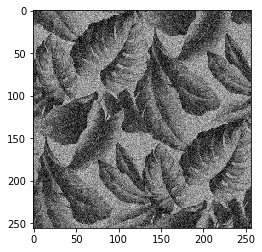

1


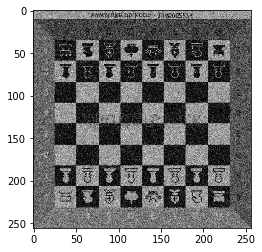

In [69]:
# Show reconstructed maps
for i in range(nc):
    print(i)
    plt.imshow(comprecmaps[i], cmap='gray')
    plt.show()

In [70]:
# Export reconstructions in a FITS file
hdu = fits.PrimaryHDU(data=comprecmaps, header=components[0].header)
hdu.writeto(reconfile, overwrite=True)

In [71]:
# Find residuals and export them in a FITS file
residuals = components_data - comprecmaps
hdu = fits.PrimaryHDU(data=residuals, header=components[0].header)
hdu.writeto(errorfile, overwrite=True)

In [72]:
# Find residual power spectra
residfft = np.fft.fft2(residuals)
residfft = np.fft.fftshift(residfft, axes=(1,2))
residps = np.zeros((nc, topbin+1))
for i in range(nc):
    workspace = np.abs(residfft[i,:,:]**2)
    summ, num = fm.azav(workspace, nx, ny, topbin, bins)
    residps[i,:] = summ

In [73]:
# Find component power spectra
compps = np.zeros((nc, topbin+1))
for i in range(nc):
    workspace = np.abs(compfft[i,:,:]**2)
    summ, num = fm.azav(workspace, nx, ny, topbin, bins)
    compps[i,:] = summ

Component  0


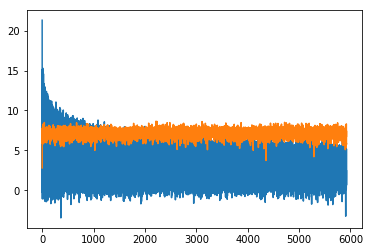

Component  1


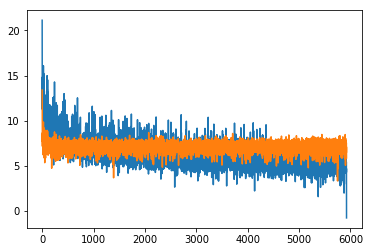

In [74]:
# Show logpower spectra for components and residuals
for i in range(nc):
    print("Component ", i)
    plt.plot(np.log(compps[i,:])), plt.plot(np.log(residps[i,:]))
    plt.show()